In [258]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from scipy.stats import pearsonr, spearmanr
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import mutual_info_regression
import warnings
from sklearn.preprocessing import PolynomialFeatures
warnings.filterwarnings('ignore')
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')



# задача 1) разведочный анализ данных (EDA): построить графики зависимости некоторых признаков друг от друга, график целевой переменной и матрицу корреляций, сделать выводы.

## Информация о данных

In [259]:
# print(train.info())
missing_train = train.isnull().sum()
missing_percent = 100 * missing_train / len(train)
missing_df = pd.DataFrame({
    'Признак': missing_train.index,
    'Пропусков': missing_train.values,
    'Процент': missing_percent.values
})
missing_df = missing_df[missing_df['Пропусков'] > 0].sort_values('Пропусков', ascending=False)
if len(missing_df) > 0:
    # print(missing_df)
    print(f"\n  Пропуски в {len(missing_df)} признаках:")
    print(missing_df.to_string(index=False))

else:
    print("Пропущенных значений нет")



  Пропуски в 35 признаках:
                   Признак  Пропусков  Процент
               TotalAssets       1031 9.358265
               CreditScore       1031 9.358265
                LoanAmount       1031 9.358265
          BaseInterestRate       1031 9.358265
                  NetWorth       1031 9.358265
       MonthlyDebtPayments       1031 9.358265
    CheckingAccountBalance       1031 9.358265
               LoanPurpose       1031 9.358265
         BankruptcyHistory       1031 9.358265
                 JobTenure        530 4.810747
          TotalLiabilities        530 4.810747
             MonthlyIncome        530 4.810747
UtilityBillsPaymentHistory        530 4.810747
           ApplicationDate        530 4.810747
          EmploymentStatus        530 4.810747
            EducationLevel        530 4.810747
              InterestRate        530 4.810747
        MonthlyLoanPayment        530 4.810747
    TotalDebtToIncomeRatio        530 4.810747
                Experience      

#### Микровывод:
Пропуски в 35 признаках (80% от всех). 
Две группы:
- 9 признаков: 9.36% пропусков (финансовые и кредитные показатели)
- 26 признаков: 4.81% пропусков (включая целевую переменную RiskScore)

## Статистическое описание

In [260]:
print(train.describe().T)
categorical_cols = train.select_dtypes(include=['object']).columns.tolist()
print(f"\nКатегориальные признаки: {categorical_cols}")
for col in categorical_cols:
    print(f"\n{col}:")
    print(train[col].value_counts())

                              count           mean           std  \
Age                         10487.0      39.850386  1.161413e+01   
AnnualIncome                10487.0  131587.872127  1.157919e+05   
CreditScore                  9986.0     678.082716  1.751925e+02   
LoanAmount                   9986.0   29874.218306  2.770551e+04   
LoanDuration                10487.0      53.439878  2.449356e+01   
NumberOfDependents          10487.0       1.568323  1.418684e+00   
MonthlyDebtPayments          9986.0     546.458642  5.019819e+02   
CreditCardUtilizationRate   10487.0       0.284397  1.592405e-01   
NumberOfOpenCreditLines     10487.0       3.033565  1.740186e+00   
NumberOfCreditInquiries     10487.0       0.979498  9.909274e-01   
DebtToIncomeRatio           10487.0       0.250610  1.445426e-01   
BankruptcyHistory            9986.0       0.052574  2.231919e-01   
PreviousLoanDefaults        10487.0       0.096405  2.951600e-01   
PaymentHistory              10487.0      24.0088

#### Микровывод:

**Числовые признаки** (29 шт.):
- Критичная проблема: RiskScore содержит экстремальные значения от **-10M до +10M** (среднее = -25,698), что указывает на **аномалии/ошибки ввода данных**
- Финансовые метрики имеют большой разброс: TotalAssets (892 - 11M), AnnualIncome (15K - 748K)
- Демографические признаки в нормальных диапазонах: Age (18-80), Experience (0-57)

**Категориальные признаки** (6 шт.):
- ApplicationDate: 10,000 уникальных дат - признак непригоден для прямого использования (требуется feature engineering: год, месяц, день недели)
- Остальные признаки сбалансированы:
  - MaritalStatus: Married (49%), Single (31%), Divorced (15%), Widowed (5%)
  - EmploymentStatus: Employed (86%), Self-Employed (9%), Unemployed (4%)
  - EducationLevel: относительно равномерное распределение

## Анализ целевой переменной RISKSCORE

Среднее: -25698.78
Медиана: 44.12
Стандартное отклонение: 1431674.59
Минимум: -9999999.00
Максимум: 10000000.00
Асимметрия (skewness): -0.82
Эксцесс (kurtosis): 45.77


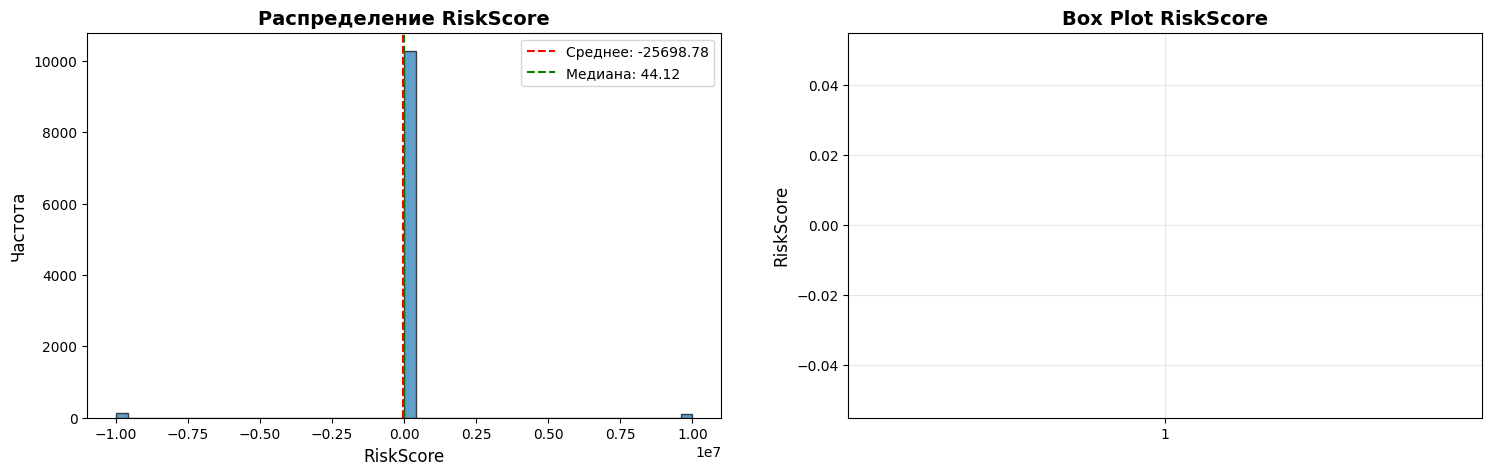

In [261]:
print(f"Среднее: {train['RiskScore'].mean():.2f}")
print(f"Медиана: {train['RiskScore'].median():.2f}")
print(f"Стандартное отклонение: {train['RiskScore'].std():.2f}")
print(f"Минимум: {train['RiskScore'].min():.2f}")
print(f"Максимум: {train['RiskScore'].max():.2f}")
print(f"Асимметрия (skewness): {train['RiskScore'].skew():.2f}")
print(f"Эксцесс (kurtosis): {train['RiskScore'].kurtosis():.2f}")
fig, axes = plt.subplots(1, 2, figsize=(18, 5))

# Гистограмма
axes[0].hist(train['RiskScore'], bins=50, edgecolor='black', alpha=0.7)
axes[0].set_xlabel('RiskScore', fontsize=12)
axes[0].set_ylabel('Частота', fontsize=12)
axes[0].set_title('Распределение RiskScore', fontsize=14, fontweight='bold')
axes[0].axvline(train['RiskScore'].mean(), color='red', linestyle='--', 
                label=f'Среднее: {train["RiskScore"].mean():.2f}')
axes[0].axvline(train['RiskScore'].median(), color='green', linestyle='--', 
                label=f'Медиана: {train["RiskScore"].median():.2f}')
axes[0].legend()

# Box plot
axes[1].boxplot(train['RiskScore'], vert=True)
axes[1].set_ylabel('RiskScore', fontsize=12)
axes[1].set_title('Box Plot RiskScore', fontsize=14, fontweight='bold')
axes[1].grid(True, alpha=0.3)



#### Микровывод:

**RiskScore имеет критичные аномалии:**
- Диапазон: -10M до +10M (явные placeholder-значения)
- Среднее (-25,699) vs Медиана (44.12) → **выбросы искажают статистику**
- Эксцесс 45.77 (норма ≈ 3) → **множественные выбросы**
- Медиана: **44.12** (более реалистичное значение для риск-скора)



## Лютый корреляционный анализ


Корреляция всех признаков с RiskScore:
RiskScore                     1.000000
PaymentHistory                0.019144
TotalDebtToIncomeRatio        0.013879
MonthlyLoanPayment            0.012366
LoanAmount                    0.011771
NumberOfCreditInquiries       0.011055
NetWorth                      0.008804
TotalAssets                   0.008092
SavingsAccountBalance         0.007611
CreditCardUtilizationRate     0.005501
BankruptcyHistory             0.005184
JobTenure                     0.003822
InterestRate                  0.003388
CreditScore                   0.002383
BaseInterestRate              0.002081
NumberOfOpenCreditLines       0.000730
CheckingAccountBalance       -0.000648
MonthlyDebtPayments          -0.001871
LoanDuration                 -0.001880
Age                          -0.004648
TotalLiabilities             -0.004976
Experience                   -0.005408
PreviousLoanDefaults         -0.005409
MonthlyIncome                -0.006145
DebtToIncomeRatio       

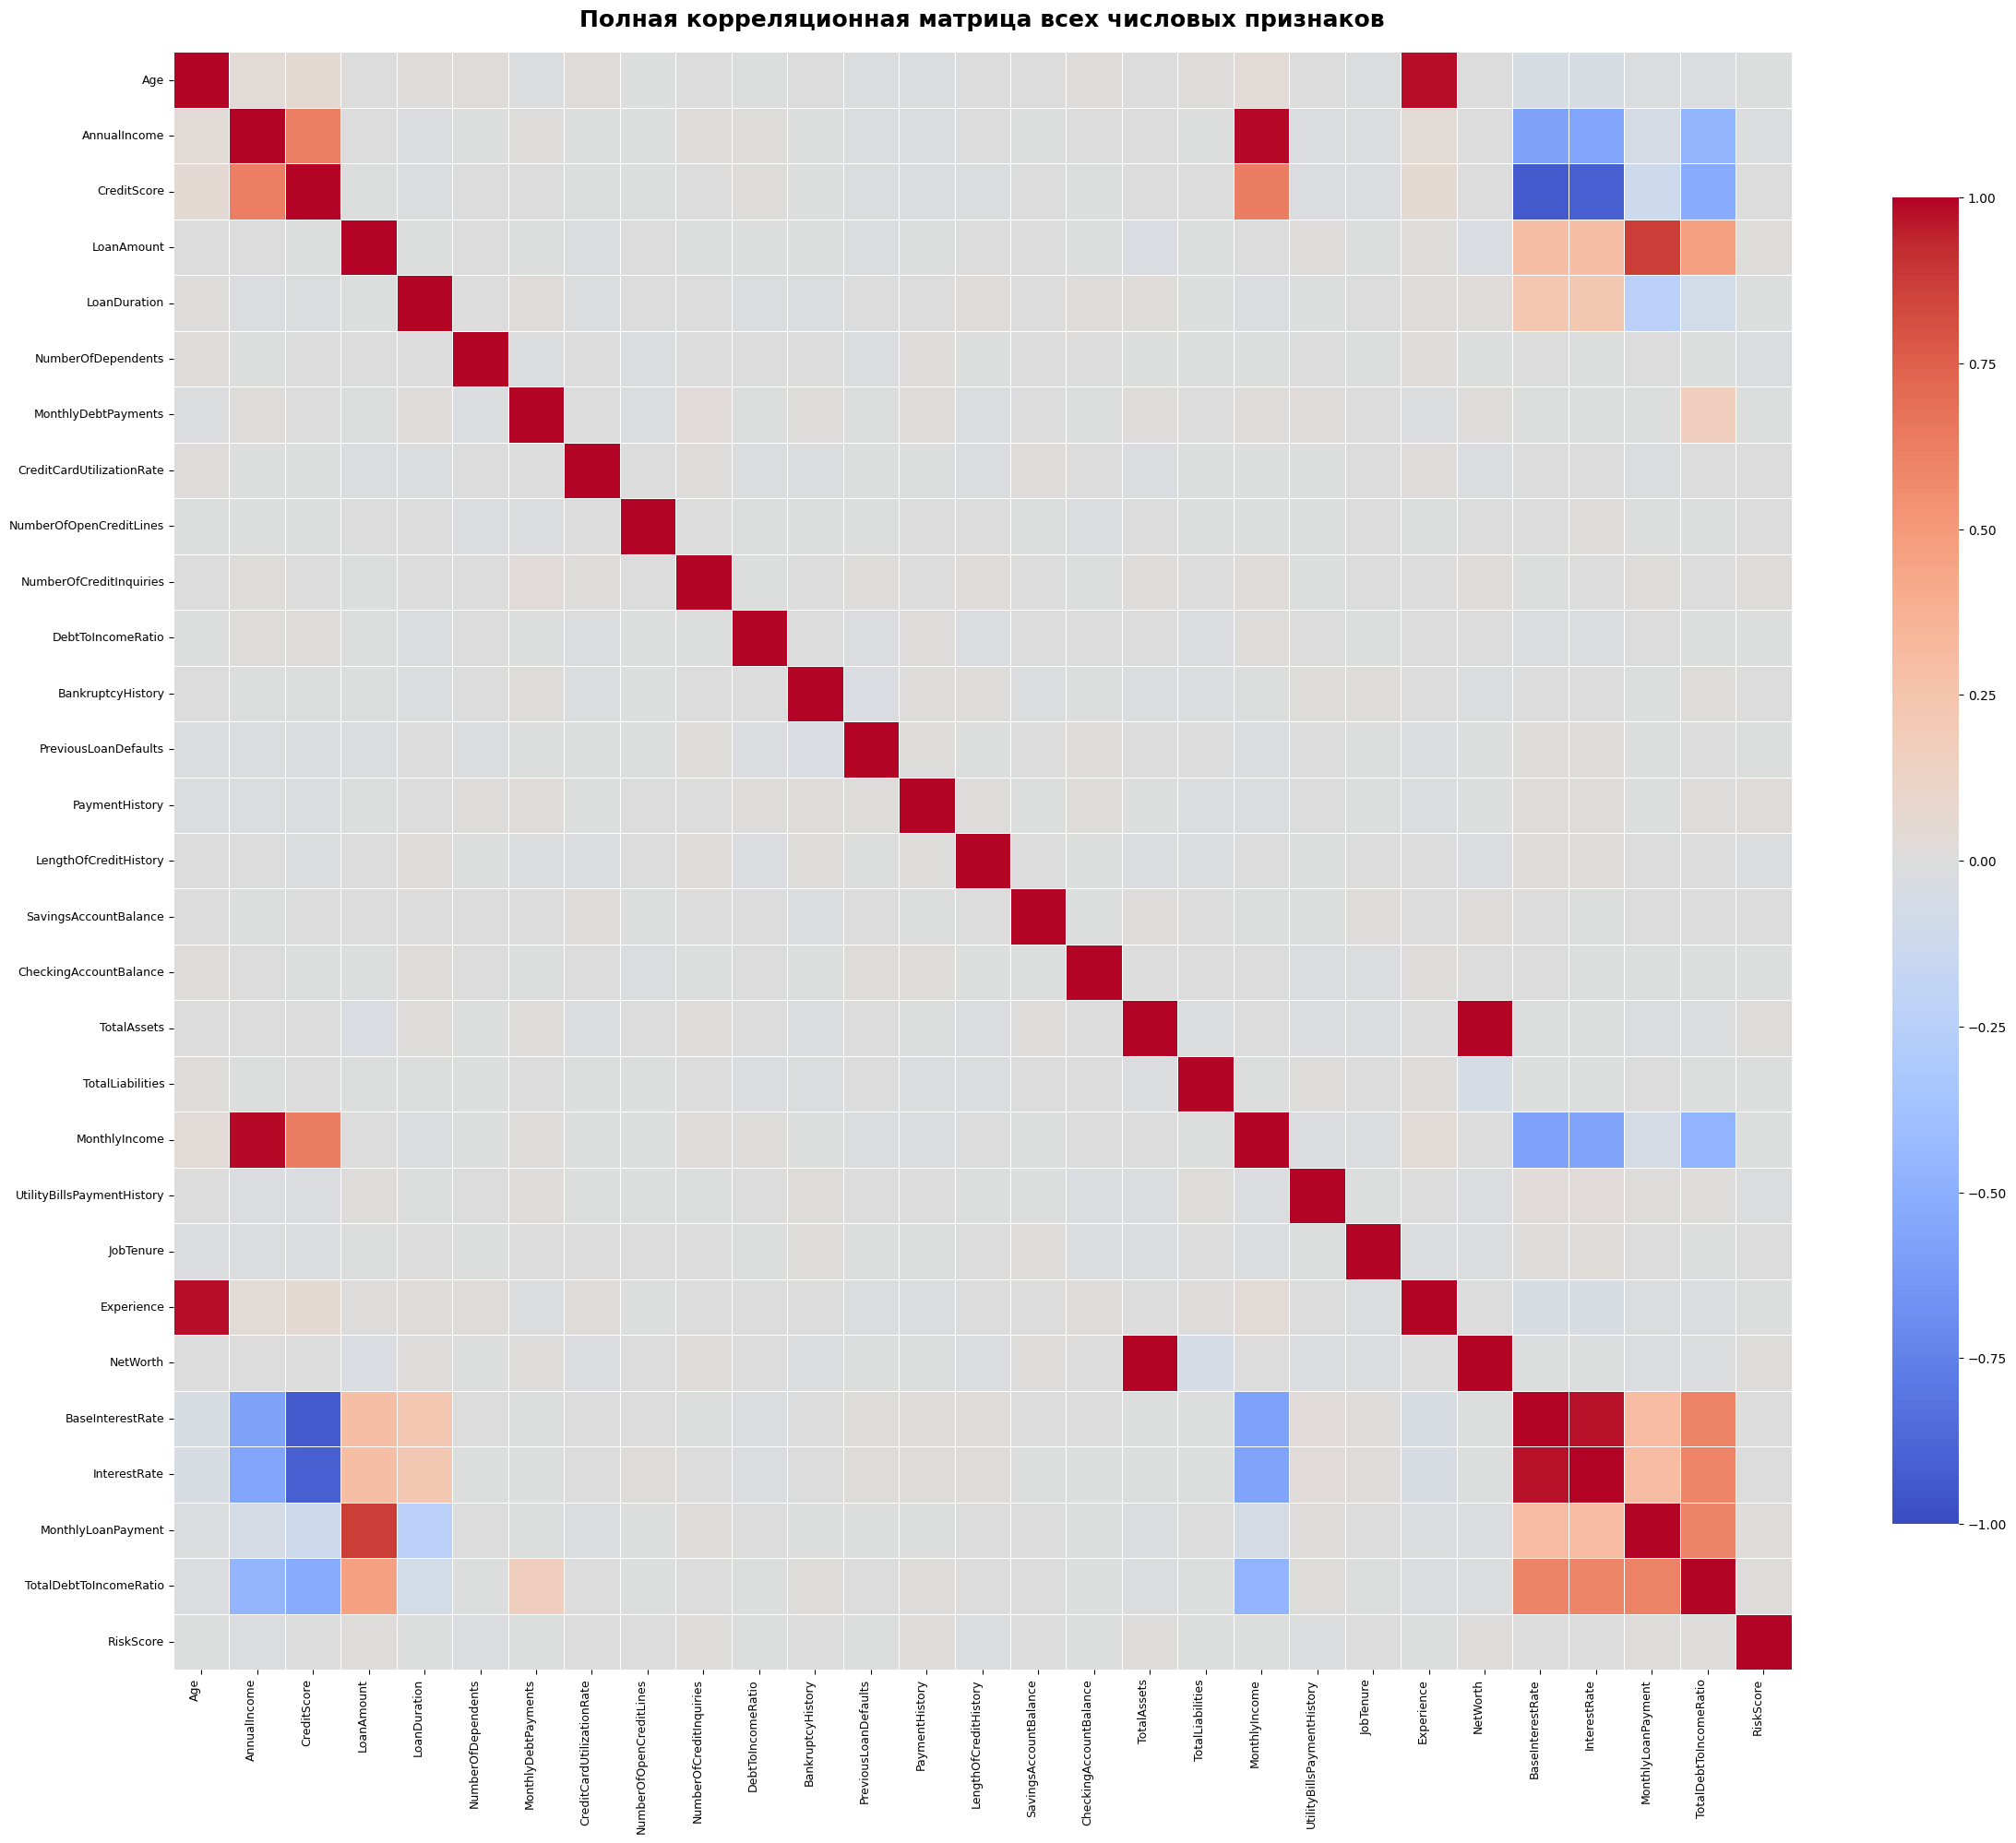

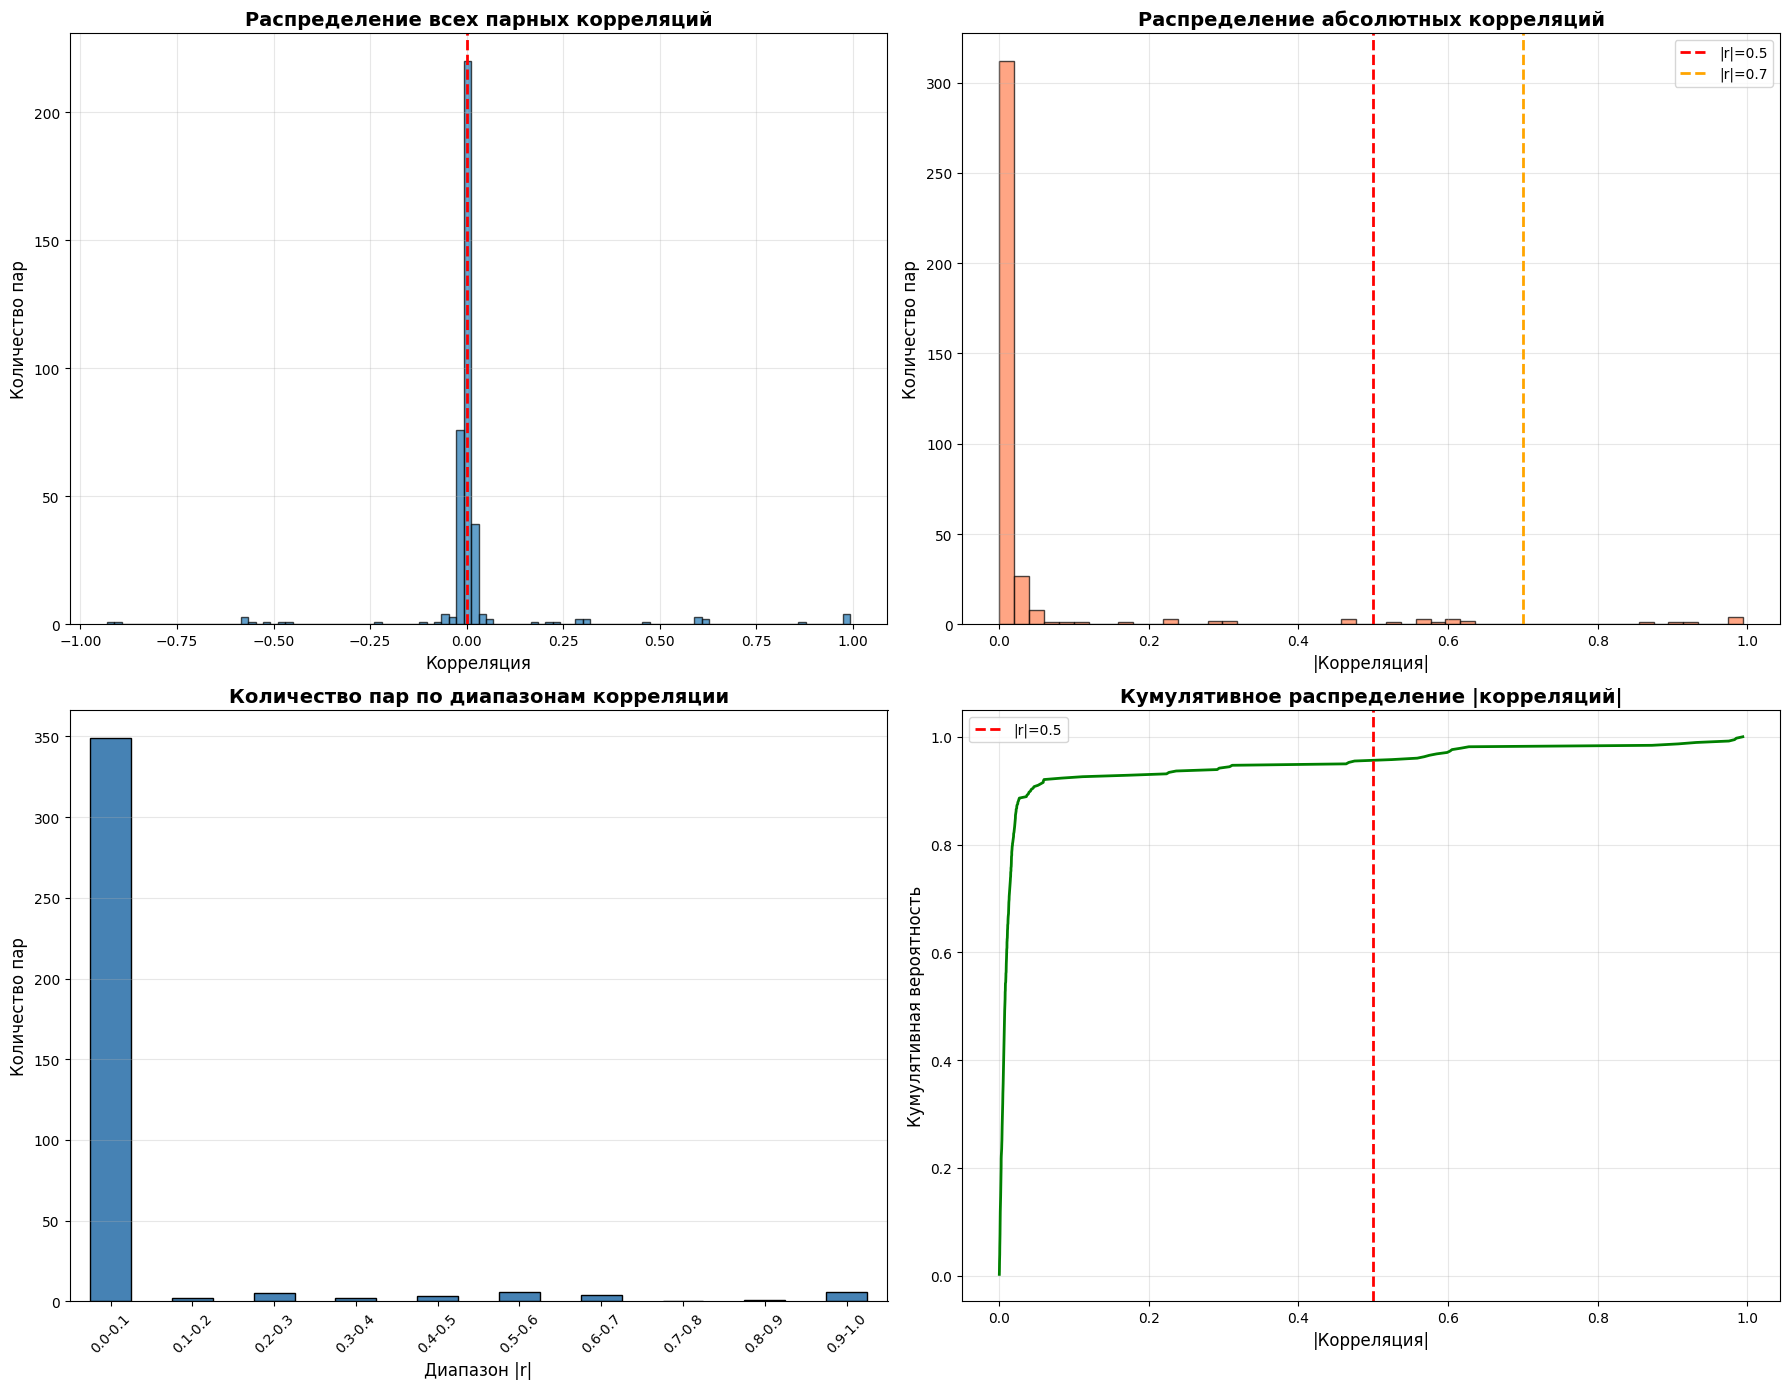

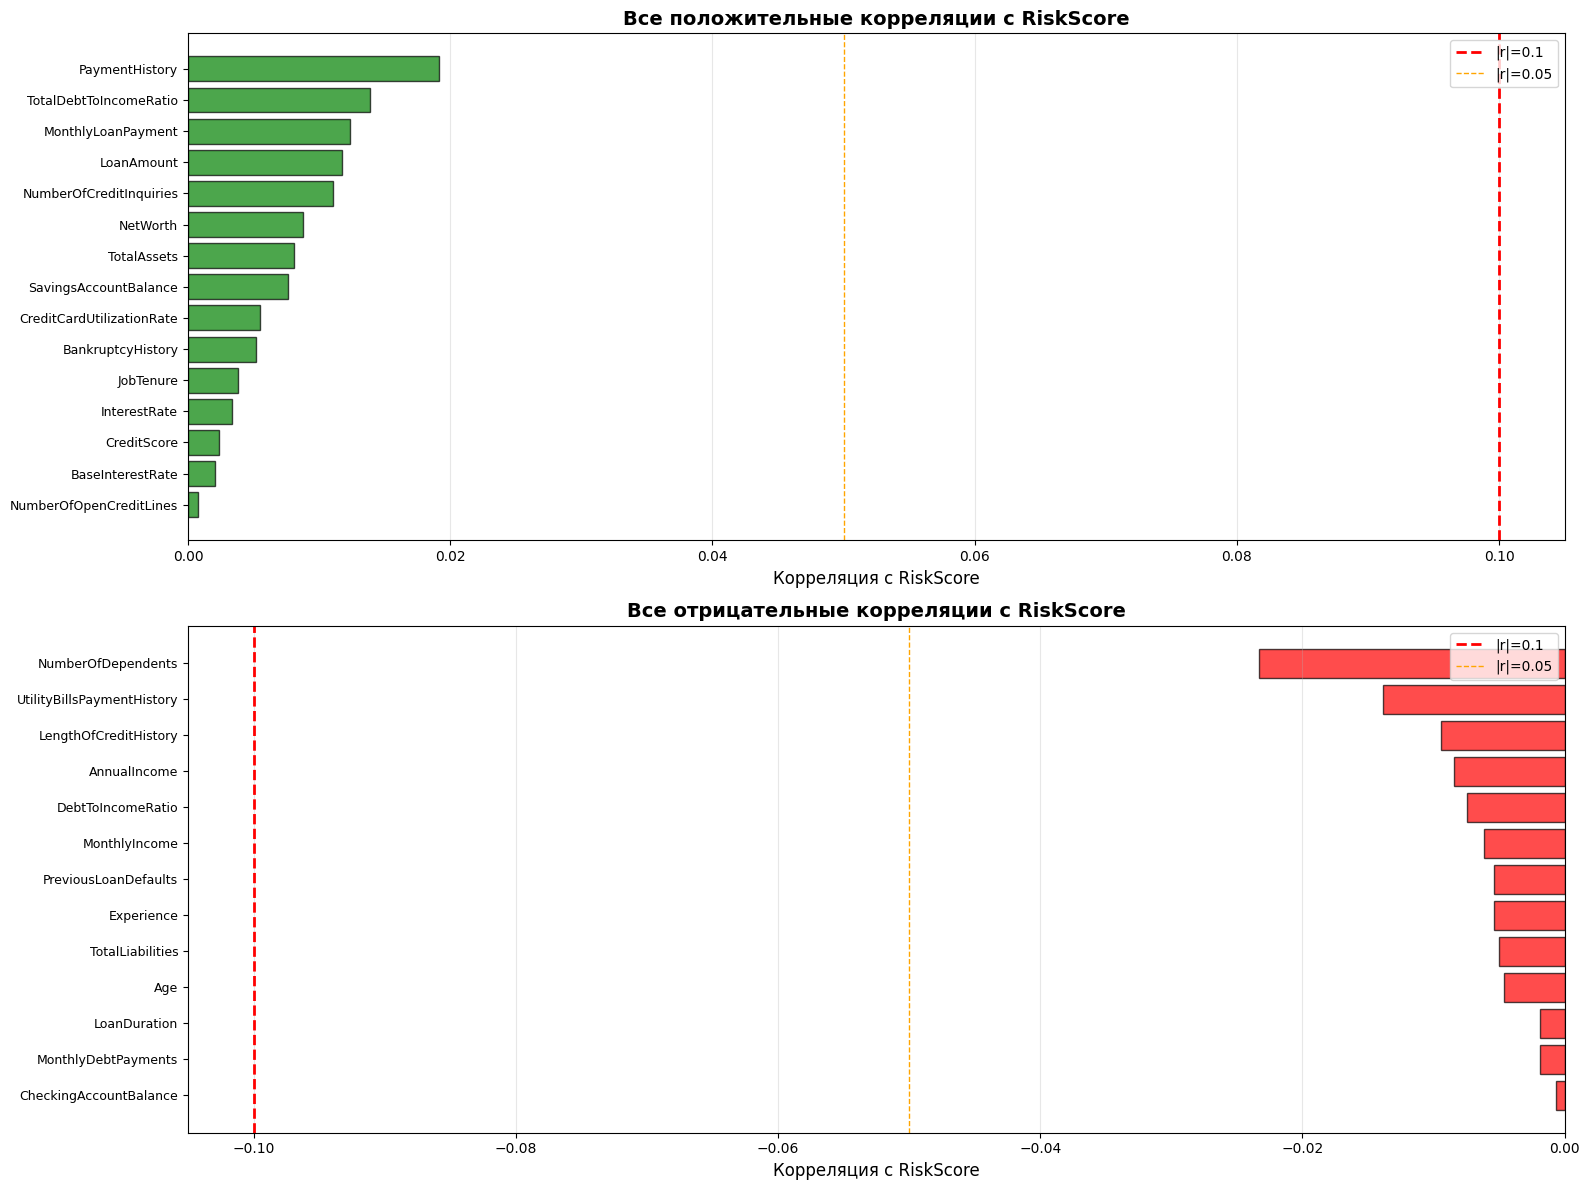

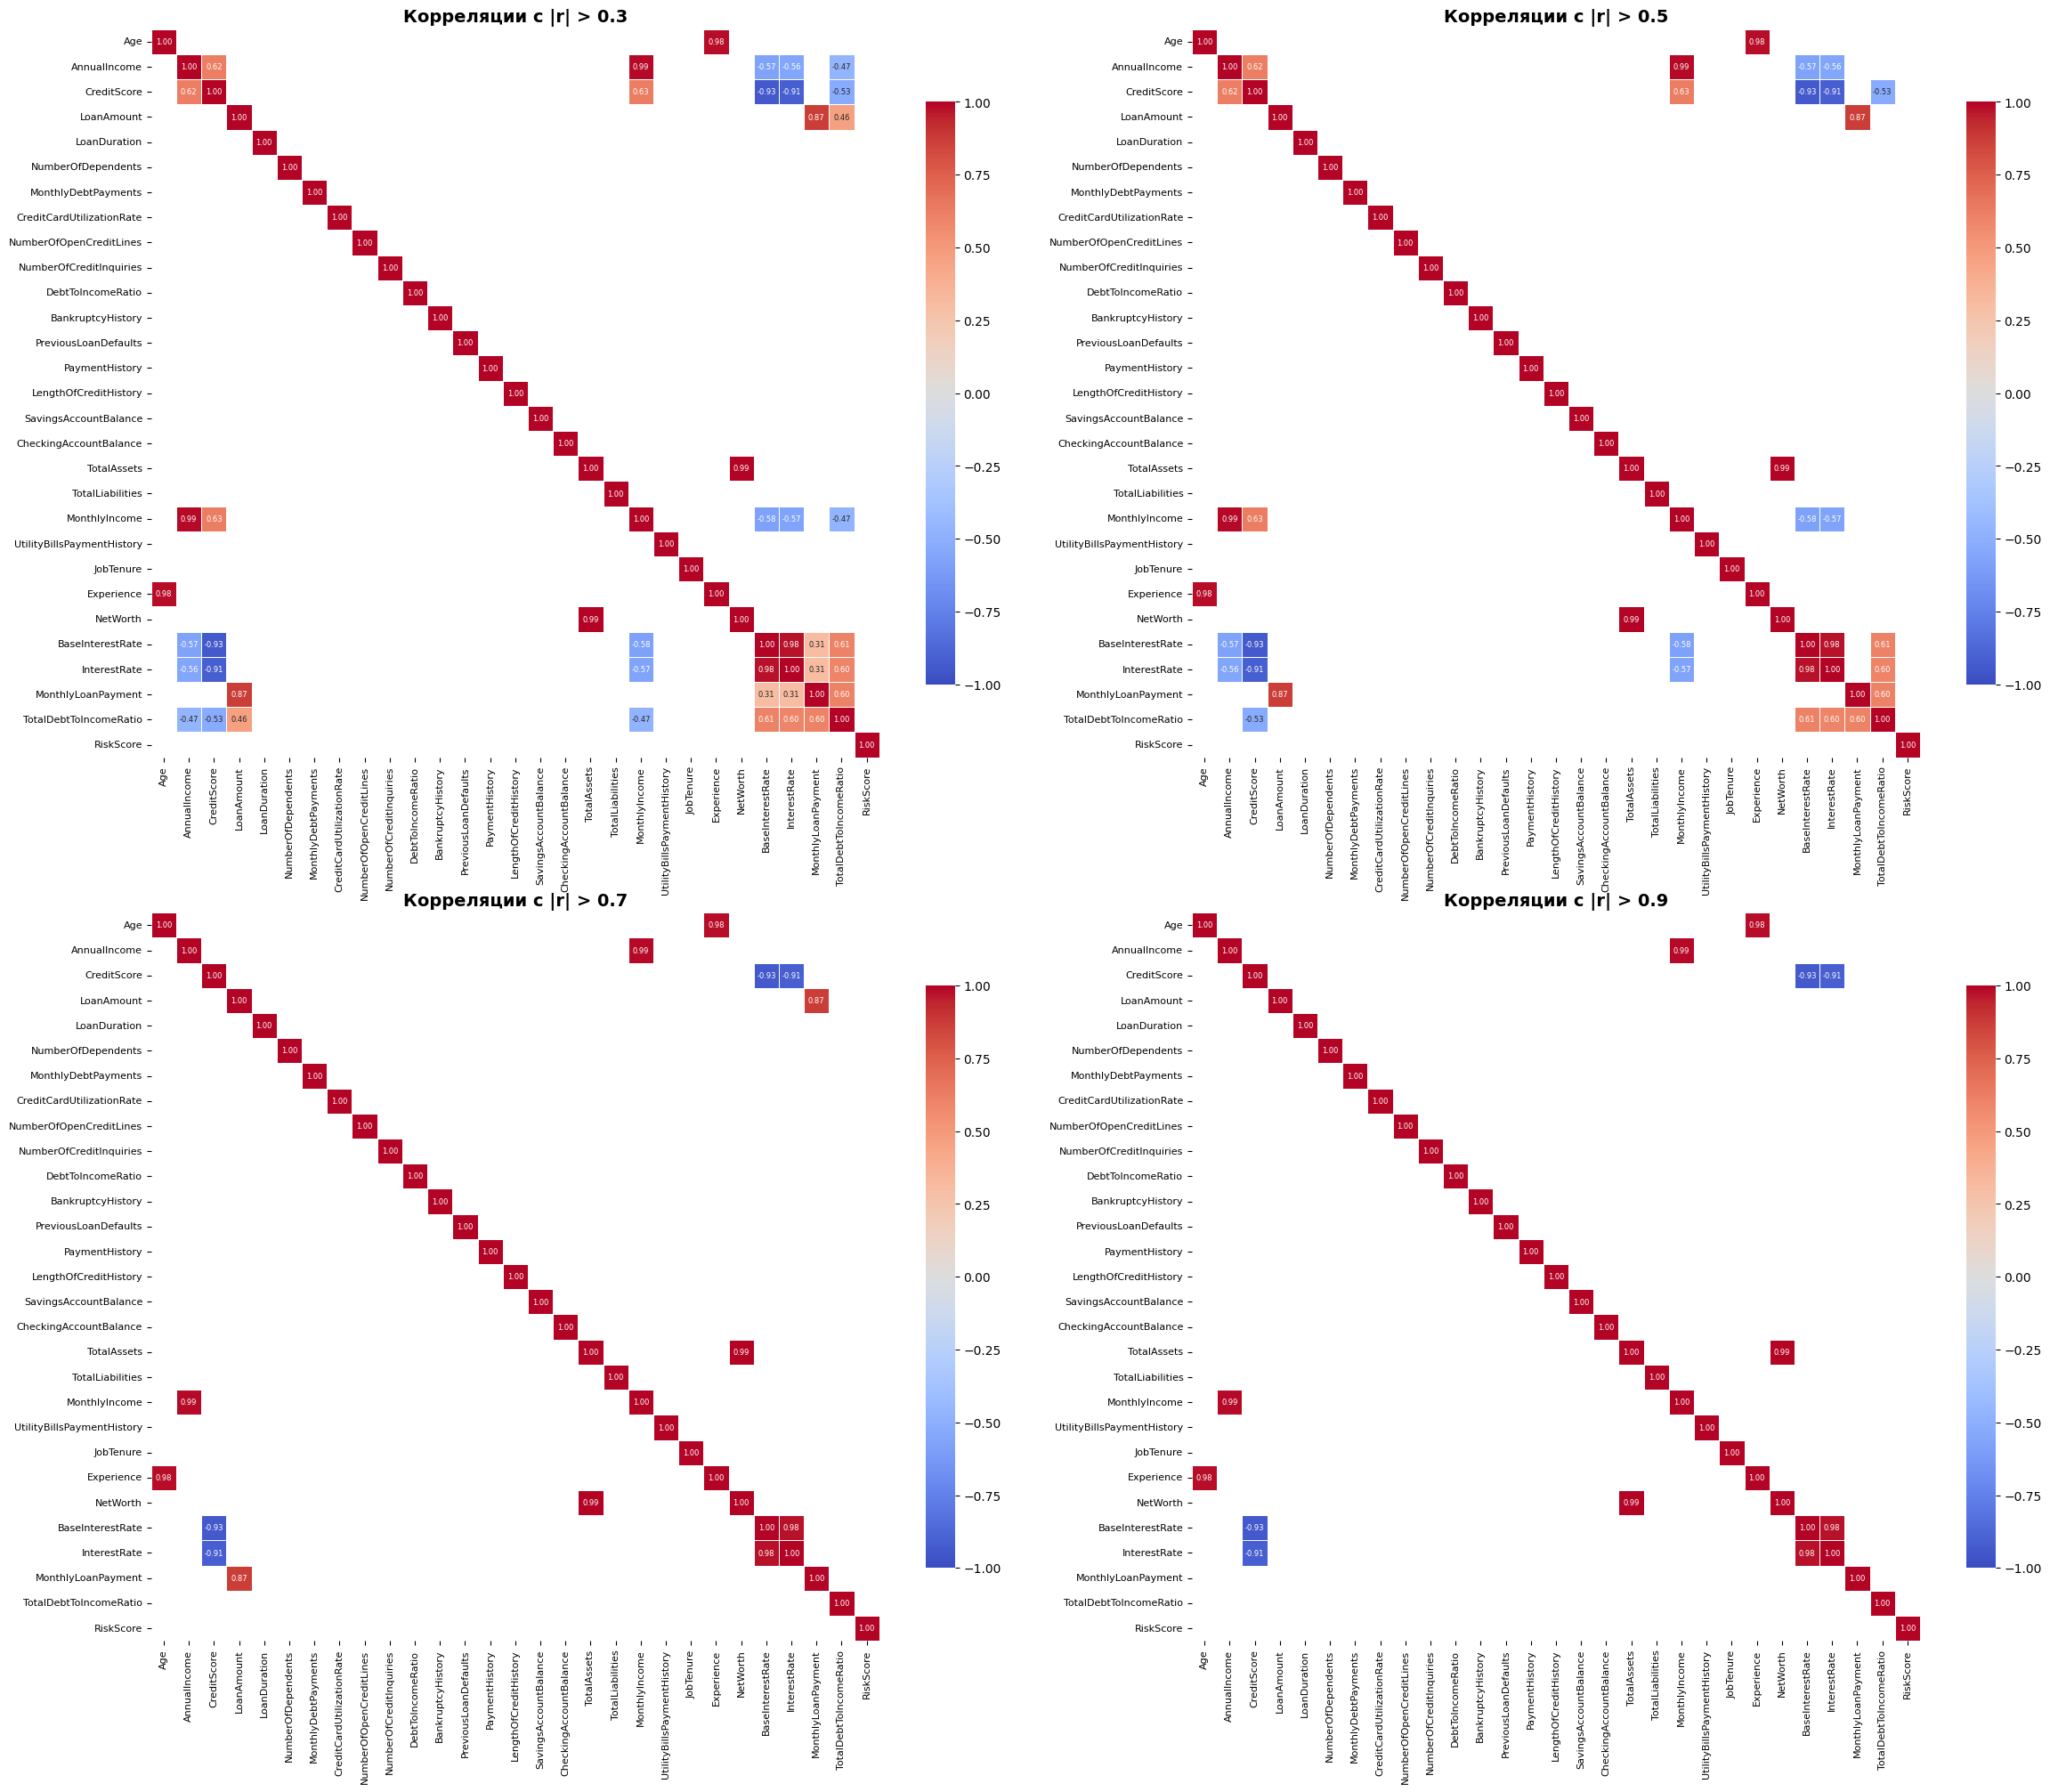


Корреляционная матрица сохранена: correlation_matrix_full.csv
Все пары корреляций сохранены: all_correlation_pairs.csv
Статистика корреляций сохранена: feature_correlation_stats.csv
Топ-50 корреляций сохранены: top50_correlations.csv


In [262]:
numeric_cols = train.select_dtypes(include=[np.number]).columns.tolist()
correlation_matrix = train[numeric_cols].corr()

if 'RiskScore' in numeric_cols:
    correlations = correlation_matrix['RiskScore'].sort_values(ascending=False)
    print("\nКорреляция всех признаков с RiskScore:")
    print(correlations)
    
    print(f"Максимальная положительная корреляция: {correlations[1]:.4f} ({correlations.index[1]})")
    print(f"Максимальная отрицательная корреляция: {correlations.iloc[-1]:.4f} ({correlations.index[-1]})")
    print(f"Средняя абсолютная корреляция: {correlations.drop('RiskScore').abs().mean():.4f}")
    print(f"Медианная абсолютная корреляция: {correlations.drop('RiskScore').abs().median():.4f}")
    
    # Категоризация корреляций
    strong_positive = correlations[(correlations > 0.1) & (correlations < 1.0)]
    moderate_positive = correlations[(correlations > 0.05) & (correlations <= 0.1)]
    weak_positive = correlations[(correlations > 0) & (correlations <= 0.05)]
    weak_negative = correlations[(correlations < 0) & (correlations >= -0.05)]
    moderate_negative = correlations[(correlations < -0.05) & (correlations >= -0.1)]
    strong_negative = correlations[correlations < -0.1]
    
    print(f"\nРаспределение силы корреляций:")
    print(f"  Сильная положительная (>0.1):       {len(strong_positive)} признаков")
    print(f"  Умеренная положительная (0.05-0.1): {len(moderate_positive)} признаков")
    print(f"  Слабая положительная (0-0.05):      {len(weak_positive)} признаков")
    print(f"  Слабая отрицательная (-0.05-0):     {len(weak_negative)} признаков")
    print(f"  Умеренная отрицательная (-0.1--0.05): {len(moderate_negative)} признаков")
    print(f"  Сильная отрицательная (<-0.1):      {len(strong_negative)} признаков")
    
    if len(strong_positive) > 0:
        print(f"\nСИЛЬНО коррелированные признаки (>0.1):")
        for feat, corr in strong_positive.items():
            print(f"  {feat:40s}: {corr:.4f}")
    
    if len(strong_negative) > 0:
        print(f"\nСИЛЬНО отрицательно коррелированные признаки (<-0.1):")
        for feat, corr in strong_negative.items():
            print(f"  {feat:40s}: {corr:.4f}")


print("ПОЛНЫЙ АНАЛИЗ КОРРЕЛЯЦИЙ МЕЖДУ ВСЕМИ ПРИЗНАКАМИ")
all_pairs = []
features = [col for col in numeric_cols if col != 'RiskScore']

for i in range(len(features)):
    for j in range(i+1, len(features)):
        corr_value = correlation_matrix.loc[features[i], features[j]]
        all_pairs.append({
            'Feature_1': features[i],
            'Feature_2': features[j],
            'Correlation': corr_value,
            'Abs_Correlation': abs(corr_value)
        })

all_pairs_df = pd.DataFrame(all_pairs)

print(f"\nОбщее количество уникальных пар признаков: {len(all_pairs_df)}")

bins = [0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]
labels = ['0.0-0.1', '0.1-0.2', '0.2-0.3', '0.3-0.4', '0.4-0.5', 
          '0.5-0.6', '0.6-0.7', '0.7-0.8', '0.8-0.9', '0.9-1.0']

all_pairs_df['Corr_Range'] = pd.cut(all_pairs_df['Abs_Correlation'], bins=bins, labels=labels)
distribution = all_pairs_df['Corr_Range'].value_counts().sort_index()

print("\nРаспределение ВСЕХ парных корреляций по диапазонам:")
for range_label, count in distribution.items():
    percentage = (count / len(all_pairs_df)) * 100
    print(f"  |r| в диапазоне {range_label}: {count:4d} пар ({percentage:5.2f}%)")

print(f"\nДЕТАЛЬНАЯ СТАТИСТИКА:")
print(f"  Минимальная абсолютная корреляция: {all_pairs_df['Abs_Correlation'].min():.6f}")
print(f"  Максимальная абсолютная корреляция: {all_pairs_df['Abs_Correlation'].max():.6f}")
print(f"  Средняя абсолютная корреляция:     {all_pairs_df['Abs_Correlation'].mean():.6f}")
print(f"  Медианная абсолютная корреляция:   {all_pairs_df['Abs_Correlation'].median():.6f}")
print(f"  Стд. отклонение:                   {all_pairs_df['Abs_Correlation'].std():.6f}")

percentiles = [10, 25, 50, 75, 90, 95, 99]
print(f"\nПерцентили абсолютных корреляций:")
for p in percentiles:
    val = all_pairs_df['Abs_Correlation'].quantile(p/100)
    print(f"  {p:2d}%: {val:.6f}")


thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]

for threshold in thresholds:
    count = (all_pairs_df['Abs_Correlation'] > threshold).sum()
    percentage = (count / len(all_pairs_df)) * 100
    print(f"  |r| > {threshold:.1f}: {count:4d} пар ({percentage:5.2f}%)")

top_corr = all_pairs_df.nlargest(20, 'Abs_Correlation')
print(top_corr[['Feature_1', 'Feature_2', 'Correlation', 'Abs_Correlation']].to_string(index=False))

top_positive = all_pairs_df.nlargest(15, 'Correlation')
print(top_positive[['Feature_1', 'Feature_2', 'Correlation']].to_string(index=False))

top_negative = all_pairs_df.nsmallest(15, 'Correlation')
print(top_negative[['Feature_1', 'Feature_2', 'Correlation']].to_string(index=False))

for threshold in [0.3, 0.5, 0.7, 0.9]:
    high_corr = all_pairs_df[all_pairs_df['Abs_Correlation'] > threshold]
    print(f"\nПары с |r| > {threshold}:")
    if len(high_corr) > 0:
        print(high_corr[['Feature_1', 'Feature_2', 'Correlation', 'Abs_Correlation']].to_string(index=False))
        
        if threshold >= 0.9:
            print(f"\n  КРИТИЧЕСКАЯ МУЛЬТИКОЛЛИНЕАРНОСТЬ!")
            print(f"  Рекомендация: Удалить один из признаков в каждой паре")
    else:
        print(f"  Пар не найдено")

feature_groups = {
    'Финансовые показатели': ['AnnualIncome', 'MonthlyIncome', 'SavingsAccountBalance', 
                               'CheckingAccountBalance', 'TotalAssets', 'TotalLiabilities', 
                               'NetWorth', 'MonthlyDebtPayments'],
    'Кредитная история': ['CreditScore', 'PaymentHistory', 'LengthOfCreditHistory', 
                          'NumberOfOpenCreditLines', 'NumberOfCreditInquiries',
                          'CreditCardUtilizationRate', 'PreviousLoanDefaults', 'BankruptcyHistory'],
    'Параметры кредита': ['LoanAmount', 'LoanDuration', 'InterestRate', 'BaseInterestRate',
                          'MonthlyLoanPayment'],
    'Коэффициенты': ['DebtToIncomeRatio', 'TotalDebtToIncomeRatio'],
    'Демография': ['Age', 'Experience', 'NumberOfDependents', 'JobTenure'],
    'Прочее': ['UtilityBillsPaymentHistory']
}

for group_name, group_features in feature_groups.items():
    available_features = [f for f in group_features if f in numeric_cols]
    if len(available_features) > 1:
        print(f"\n{group_name}:")
        group_corr = correlation_matrix.loc[available_features, available_features]
        printed_any = False
        for i in range(len(available_features)):
            for j in range(i+1, len(available_features)):
                corr_val = group_corr.iloc[i, j]
                print(f"  {available_features[i]:30s} <-> {available_features[j]:30s}: {corr_val:7.4f}")
                printed_any = True
        if not printed_any:
            print(f"  Нет пар для анализа")

feature_corr_stats = []
for feature in features:
    feature_corrs = correlation_matrix[feature].drop(feature).abs()
    feature_corr_stats.append({
        'Feature': feature,
        'Mean_Abs_Corr': feature_corrs.mean(),
        'Median_Abs_Corr': feature_corrs.median(),
        'Max_Abs_Corr': feature_corrs.max(),
        'Min_Abs_Corr': feature_corrs.min(),
        'Corr_>0.3': (feature_corrs > 0.3).sum(),
        'Corr_>0.5': (feature_corrs > 0.5).sum(),
        'Corr_>0.7': (feature_corrs > 0.7).sum(),
        'RiskScore_Corr': correlation_matrix.loc[feature, 'RiskScore']
    })

corr_stats_df = pd.DataFrame(feature_corr_stats).sort_values('Max_Abs_Corr', ascending=False)
print(corr_stats_df.to_string(index=False))


print("Топ-10 признаков с наибольшей СРЕДНЕЙ корреляцией с другими:")
top_mean = corr_stats_df.nlargest(10, 'Mean_Abs_Corr')
print(top_mean[['Feature', 'Mean_Abs_Corr', 'Max_Abs_Corr']].to_string(index=False))



print("Признаки с наибольшим количеством высоких корреляций:")
multicoll = corr_stats_df[corr_stats_df['Corr_>0.5'] > 0].sort_values('Corr_>0.5', ascending=False)
if len(multicoll) > 0:
    print(multicoll[['Feature', 'Corr_>0.3', 'Corr_>0.5', 'Corr_>0.7', 'Max_Abs_Corr']].to_string(index=False))
else:
    print("Признаков с корреляциями >0.5 не найдено")


fig = plt.figure(figsize=(24, 20))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', center=0,
            linewidths=0.5, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1,
            square=True)
plt.title('Полная корреляционная матрица всех числовых признаков', 
          fontsize=18, fontweight='bold', pad=20)
plt.xticks(rotation=90, ha='right', fontsize=9)
plt.yticks(rotation=0, fontsize=9)
plt.tight_layout()
plt.show()


fig, axes = plt.subplots(2, 2, figsize=(18, 14))

# 2.1 Гистограмма всех корреляций
axes[0, 0].hist(all_pairs_df['Correlation'], bins=100, edgecolor='black', alpha=0.7)
axes[0, 0].set_xlabel('Корреляция', fontsize=12)
axes[0, 0].set_ylabel('Количество пар', fontsize=12)
axes[0, 0].set_title('Распределение всех парных корреляций', fontweight='bold', fontsize=14)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2)
axes[0, 0].grid(True, alpha=0.3)

# 2.2 Гистограмма абсолютных корреляций
axes[0, 1].hist(all_pairs_df['Abs_Correlation'], bins=50, edgecolor='black', alpha=0.7, color='coral')
axes[0, 1].set_xlabel('|Корреляция|', fontsize=12)
axes[0, 1].set_ylabel('Количество пар', fontsize=12)
axes[0, 1].set_title('Распределение абсолютных корреляций', fontweight='bold', fontsize=14)
axes[0, 1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='|r|=0.5')
axes[0, 1].axvline(0.7, color='orange', linestyle='--', linewidth=2, label='|r|=0.7')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# 2.3 Распределение по диапазонам
distribution.plot(kind='bar', ax=axes[1, 0], color='steelblue', edgecolor='black')
axes[1, 0].set_xlabel('Диапазон |r|', fontsize=12)
axes[1, 0].set_ylabel('Количество пар', fontsize=12)
axes[1, 0].set_title('Количество пар по диапазонам корреляции', fontweight='bold', fontsize=14)
axes[1, 0].tick_params(axis='x', rotation=45)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 2.4 Кумулятивное распределение
sorted_abs = np.sort(all_pairs_df['Abs_Correlation'])
cumulative = np.arange(1, len(sorted_abs) + 1) / len(sorted_abs)
axes[1, 1].plot(sorted_abs, cumulative, linewidth=2, color='green')
axes[1, 1].set_xlabel('|Корреляция|', fontsize=12)
axes[1, 1].set_ylabel('Кумулятивная вероятность', fontsize=12)
axes[1, 1].set_title('Кумулятивное распределение |корреляций|', fontweight='bold', fontsize=14)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].axvline(0.5, color='red', linestyle='--', linewidth=2, label='|r|=0.5')
axes[1, 1].legend()

plt.tight_layout()
plt.show()


if 'RiskScore' in numeric_cols:
    fig, axes = plt.subplots(2, 1, figsize=(16, 12))
    
    positive_corr = correlations[correlations > 0].drop('RiskScore').sort_values(ascending=False)
    axes[0].barh(range(len(positive_corr)), positive_corr.values, 
                color='green', edgecolor='black', alpha=0.7)
    axes[0].set_yticks(range(len(positive_corr)))
    axes[0].set_yticklabels(positive_corr.index, fontsize=9)
    axes[0].set_xlabel('Корреляция с RiskScore', fontsize=12)
    axes[0].set_title('Все положительные корреляции с RiskScore', 
                     fontweight='bold', fontsize=14)
    axes[0].invert_yaxis()
    axes[0].grid(axis='x', alpha=0.3)
    axes[0].axvline(x=0.1, color='red', linestyle='--', linewidth=2, label='|r|=0.1')
    axes[0].axvline(x=0.05, color='orange', linestyle='--', linewidth=1, label='|r|=0.05')
    axes[0].legend()
    
    negative_corr = correlations[correlations < 0].sort_values(ascending=True)
    axes[1].barh(range(len(negative_corr)), negative_corr.values, 
                color='red', edgecolor='black', alpha=0.7)
    axes[1].set_yticks(range(len(negative_corr)))
    axes[1].set_yticklabels(negative_corr.index, fontsize=9)
    axes[1].set_xlabel('Корреляция с RiskScore', fontsize=12)
    axes[1].set_title('Все отрицательные корреляции с RiskScore', 
                     fontweight='bold', fontsize=14)
    axes[1].invert_yaxis()
    axes[1].grid(axis='x', alpha=0.3)
    axes[1].axvline(x=-0.1, color='red', linestyle='--', linewidth=2, label='|r|=0.1')
    axes[1].axvline(x=-0.05, color='orange', linestyle='--', linewidth=1, label='|r|=0.05')
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()
    

fig, axes = plt.subplots(2, 2, figsize=(24, 20))
axes = axes.ravel()

thresholds_viz = [0.3, 0.5, 0.7, 0.9]
for idx, threshold in enumerate(thresholds_viz):
    mask = np.abs(correlation_matrix) < threshold
    corr_masked = correlation_matrix.copy()
    corr_masked[mask] = np.nan
    
    sns.heatmap(corr_masked, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                linewidths=0.5, cbar_kws={"shrink": 0.8}, vmin=-1, vmax=1,
                square=True, annot_kws={"size": 6}, ax=axes[idx])
    axes[idx].set_title(f'Корреляции с |r| > {threshold}', fontweight='bold', fontsize=14)
    axes[idx].tick_params(axis='x', rotation=90, labelsize=8)
    axes[idx].tick_params(axis='y', rotation=0, labelsize=8)

plt.tight_layout()
plt.show()



# Сохраняем полную матрицу корреляций
correlation_matrix.to_csv('correlation_matrix_full.csv')
print("\nКорреляционная матрица сохранена: correlation_matrix_full.csv")

# Сохраняем ВСЕ пары корреляций
all_pairs_df.sort_values('Abs_Correlation', ascending=False).to_csv('all_correlation_pairs.csv', index=False)
print("Все пары корреляций сохранены: all_correlation_pairs.csv")

# Сохраняем статистику по признакам
corr_stats_df.to_csv('feature_correlation_stats.csv', index=False)
print("Статистика корреляций сохранена: feature_correlation_stats.csv")

# Сохраняем топ корреляции
all_pairs_df.nlargest(50, 'Abs_Correlation').to_csv('top50_correlations.csv', index=False)
print("Топ-50 корреляций сохранены: top50_correlations.csv")

#### Микровывод: Корреляционный анализ

**Критическая находка #1: Крайне слабая связь с целевой переменной**

Все 28 числовых признаков демонстрируют **исключительно слабую корреляцию** с `RiskScore`. Максимальная положительная корреляция составляет всего **0.019** (`PaymentHistory`), максимальная отрицательная — **-0.023** (`NumberOfDependents`). Средняя абсолютная корреляция с целевой переменной равна **0.0075**, медианная — **0.0058**. Ни один признак не демонстрирует корреляции выше **0.05** по модулю. Это указывает на одну из трёх проблем: либо связь между признаками и целевой переменной **нелинейная** и не улавливается корреляцией Пирсона, либо целевая переменная содержит **слишком много шума** из-за аномалий, либо **признаки недостаточно информативны** для предсказания риск-скора.

**Критическая находка #2: Мультиколлинеарность высокой степени**
Обнаружено **6 пар признаков** с корреляцией выше **0.9**, что представляет собой **критическую мультиколлинеарность**. Пара `TotalAssets` и `NetWorth` демонстрирует корреляцию **0.994** — это практически идентичные признаки, один из них необходимо удалить. Аналогично `AnnualIncome` и `MonthlyIncome` коррелируют на уровне **0.985** (логично, так как годовой доход примерно равен месячному, умноженному на 12). Пара `Age` и `Experience` показывает корреляцию **0.983** — опыт работы напрямую зависит от возраста. Процентные ставки `BaseInterestRate` и `InterestRate` коррелируют на **0.975**, что также ожидаемо. Особенно интересна сильная отрицательная корреляция между `CreditScore` и процентными ставками: **-0.932** с `BaseInterestRate` и **-0.908** с `InterestRate` — чем выше кредитный рейтинг, тем ниже процентная ставка, что соответствует финансовой логике. Наконец, `LoanAmount` и `MonthlyLoanPayment` коррелируют на **0.873**, так как размер ежемесячного платежа прямо зависит от суммы кредита.

**Общее распределение корреляций между признаками**
 Подавляющее большинство — **92.33%** (349 пар) — имеют абсолютную корреляцию ниже **0.1**, что свидетельствует о том, что признаки в основном **независимы друг от друга**. Лишь **7.67%** пар (29 пар) превышают порог **0.1**, и только **1.59%** (6 пар) находятся в критической зоне выше **0.9**. Средняя абсолютная корреляция между всеми парами составляет **0.052**, медианная — **0.007**, что подтверждает общую **слабую взаимосвязь** между большинством признаков. Распределение корреляций сильно смещено к нулю: 75-й перцентиль равен всего **0.016**, 90-й — **0.042**, и только 95-й перцентиль достигает **0.464**. Это означает, что проблемы мультиколлинеарности касаются лишь **небольшого количества** конкретных пар признаков, которые можно идентифицировать и устранить.

**Группы признаков с высокой внутренней корреляцией**
Внутри группы **финансовых показателей** критична связка `TotalAssets` — `NetWorth` (0.994) и умеренная связь `AnnualIncome` — `MonthlyIncome` (0.985). Остальные финансовые метрики практически независимы друг от друга: корреляции между балансами счетов, сбережениями и обязательствами не превышают **0.02**. В группе **параметров кредита** наблюдается ожидаемая высокая корреляция между процентными ставками (0.975) и между суммой кредита и ежемесячным платежом (0.873). Интересно, что `LoanDuration` слабо коррелирует с остальными параметрами кредита, что делает его **относительно независимым** признаком. В **демографической группе** доминирует пара `Age` — `Experience` (0.983), в то время как `NumberOfDependents` и `JobTenure` показывают слабые связи со всеми признаками. Группа **кредитной истории** демонстрирует удивительно **низкие внутренние корреляции**: ни одна пара не превышает **0.023** по модулю, что говорит о том, что эти признаки измеряют **разные аспекты** кредитоспособности и все потенциально полезны.

**Признаки с наибольшим числом связей**
Признак `TotalDebtToIncomeRatio` имеет наибольшее количество связей: **7 корреляций выше 0.3** и **4 выше 0.5**. Он сильно связан с процентными ставками (0.60), ежемесячным платежом (0.60), отрицательно — с `CreditScore` (-0.53) и доходами (-0.47). Процентные ставки (`InterestRate` и `BaseInterestRate`) также являются "хабами" корреляций: по **6 связей выше 0.3** и **5 выше 0.5** у каждого. `CreditScore` имеет **5 сильных связей**, включая отрицательные с процентными ставками и положительную с доходами (0.62). Доходы (`AnnualIncome` и `MonthlyIncome`) также входят в топ по количеству связей. Напротив, признаки вроде `SavingsAccountBalance`, `CheckingAccountBalance`, `JobTenure` и большинство параметров кредитной истории имеют **минимальные связи** с другими признаками (средняя абсолютная корреляция 0.005-0.011), что делает их **независимыми источниками** информации.


## SCATTER PLOTS - ЗАВИСИМОСТИ ПРИЗНАКОВ


Используются результаты корреляционного анализа из CSV файлов

Признаков с |корреляцией| > 0.001: 26

Выбраны признаки для визуализации (по убыванию |корреляции|):
                   Feature  RiskScore_Corr
        NumberOfDependents       -0.023314
            PaymentHistory        0.019144
    TotalDebtToIncomeRatio        0.013879
UtilityBillsPaymentHistory       -0.013865
        MonthlyLoanPayment        0.012366
                LoanAmount        0.011771
   NumberOfCreditInquiries        0.011055
     LengthOfCreditHistory       -0.009448
                  NetWorth        0.008804
              AnnualIncome       -0.008460
               TotalAssets        0.008092
     SavingsAccountBalance        0.007611
         DebtToIncomeRatio       -0.007417
             MonthlyIncome       -0.006145
 CreditCardUtilizationRate        0.005501
      PreviousLoanDefaults       -0.005409
                Experience       -0.005408
         BankruptcyHistory        0.005184
          TotalLia

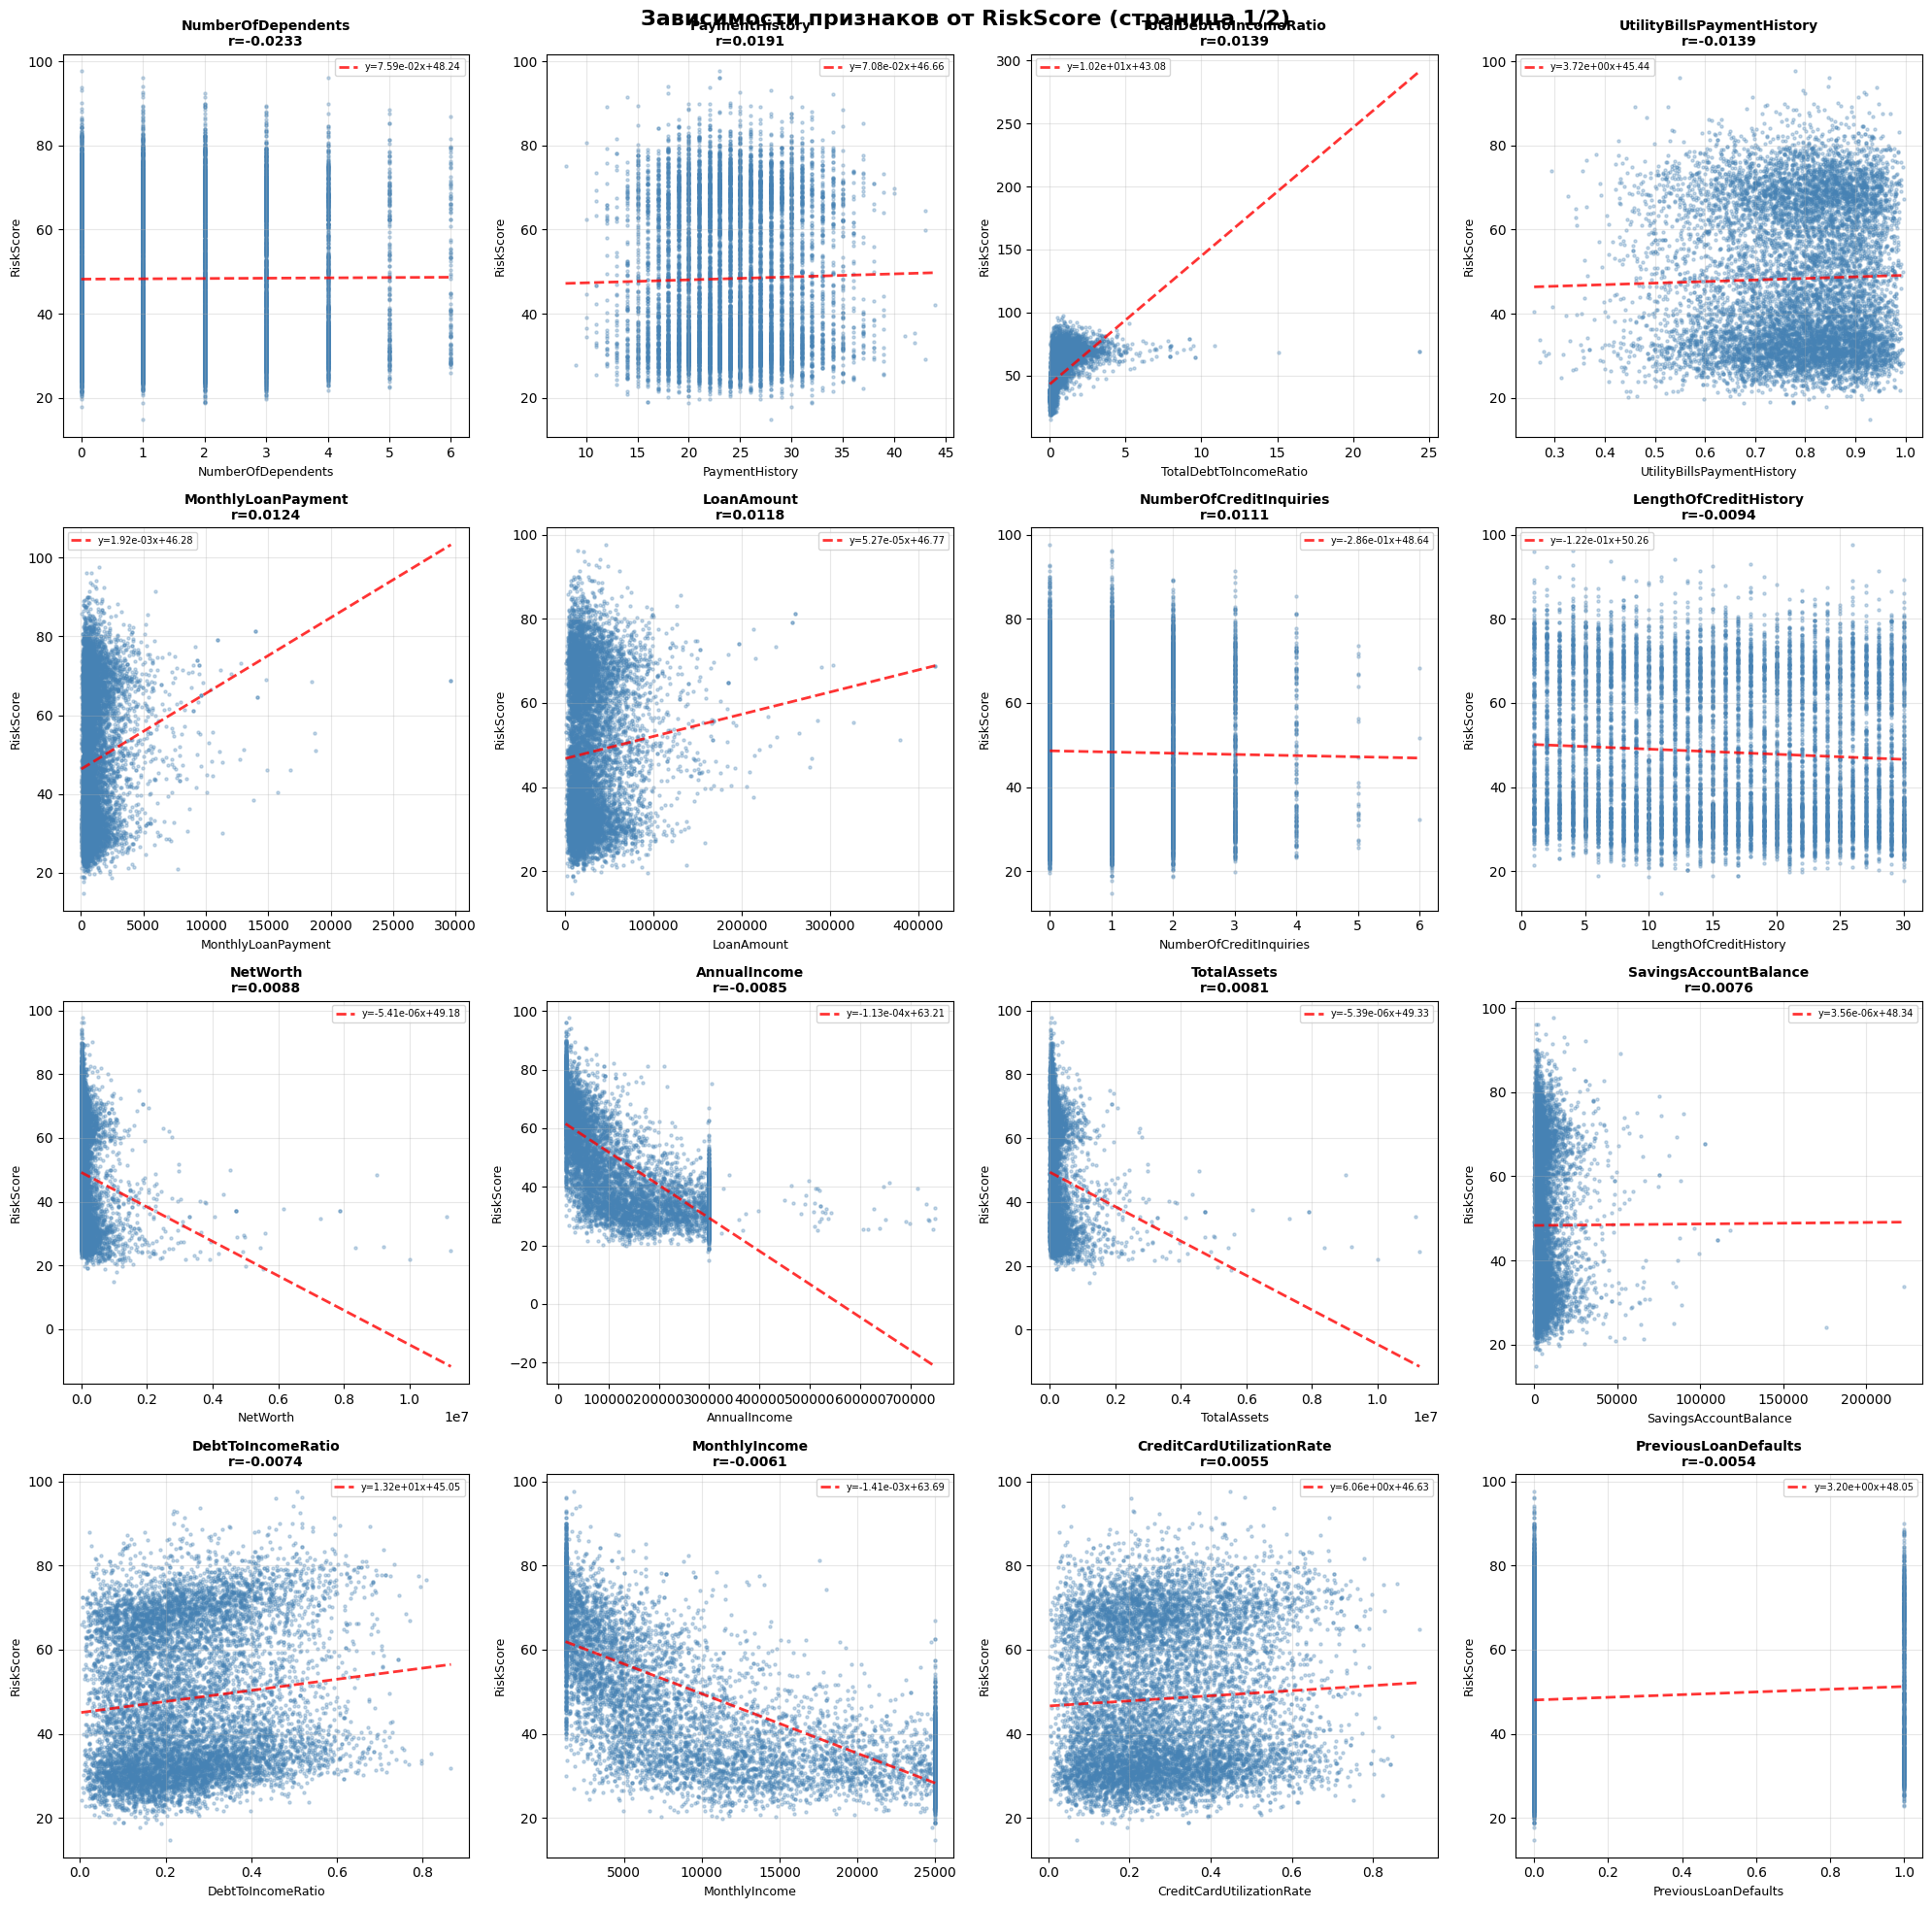

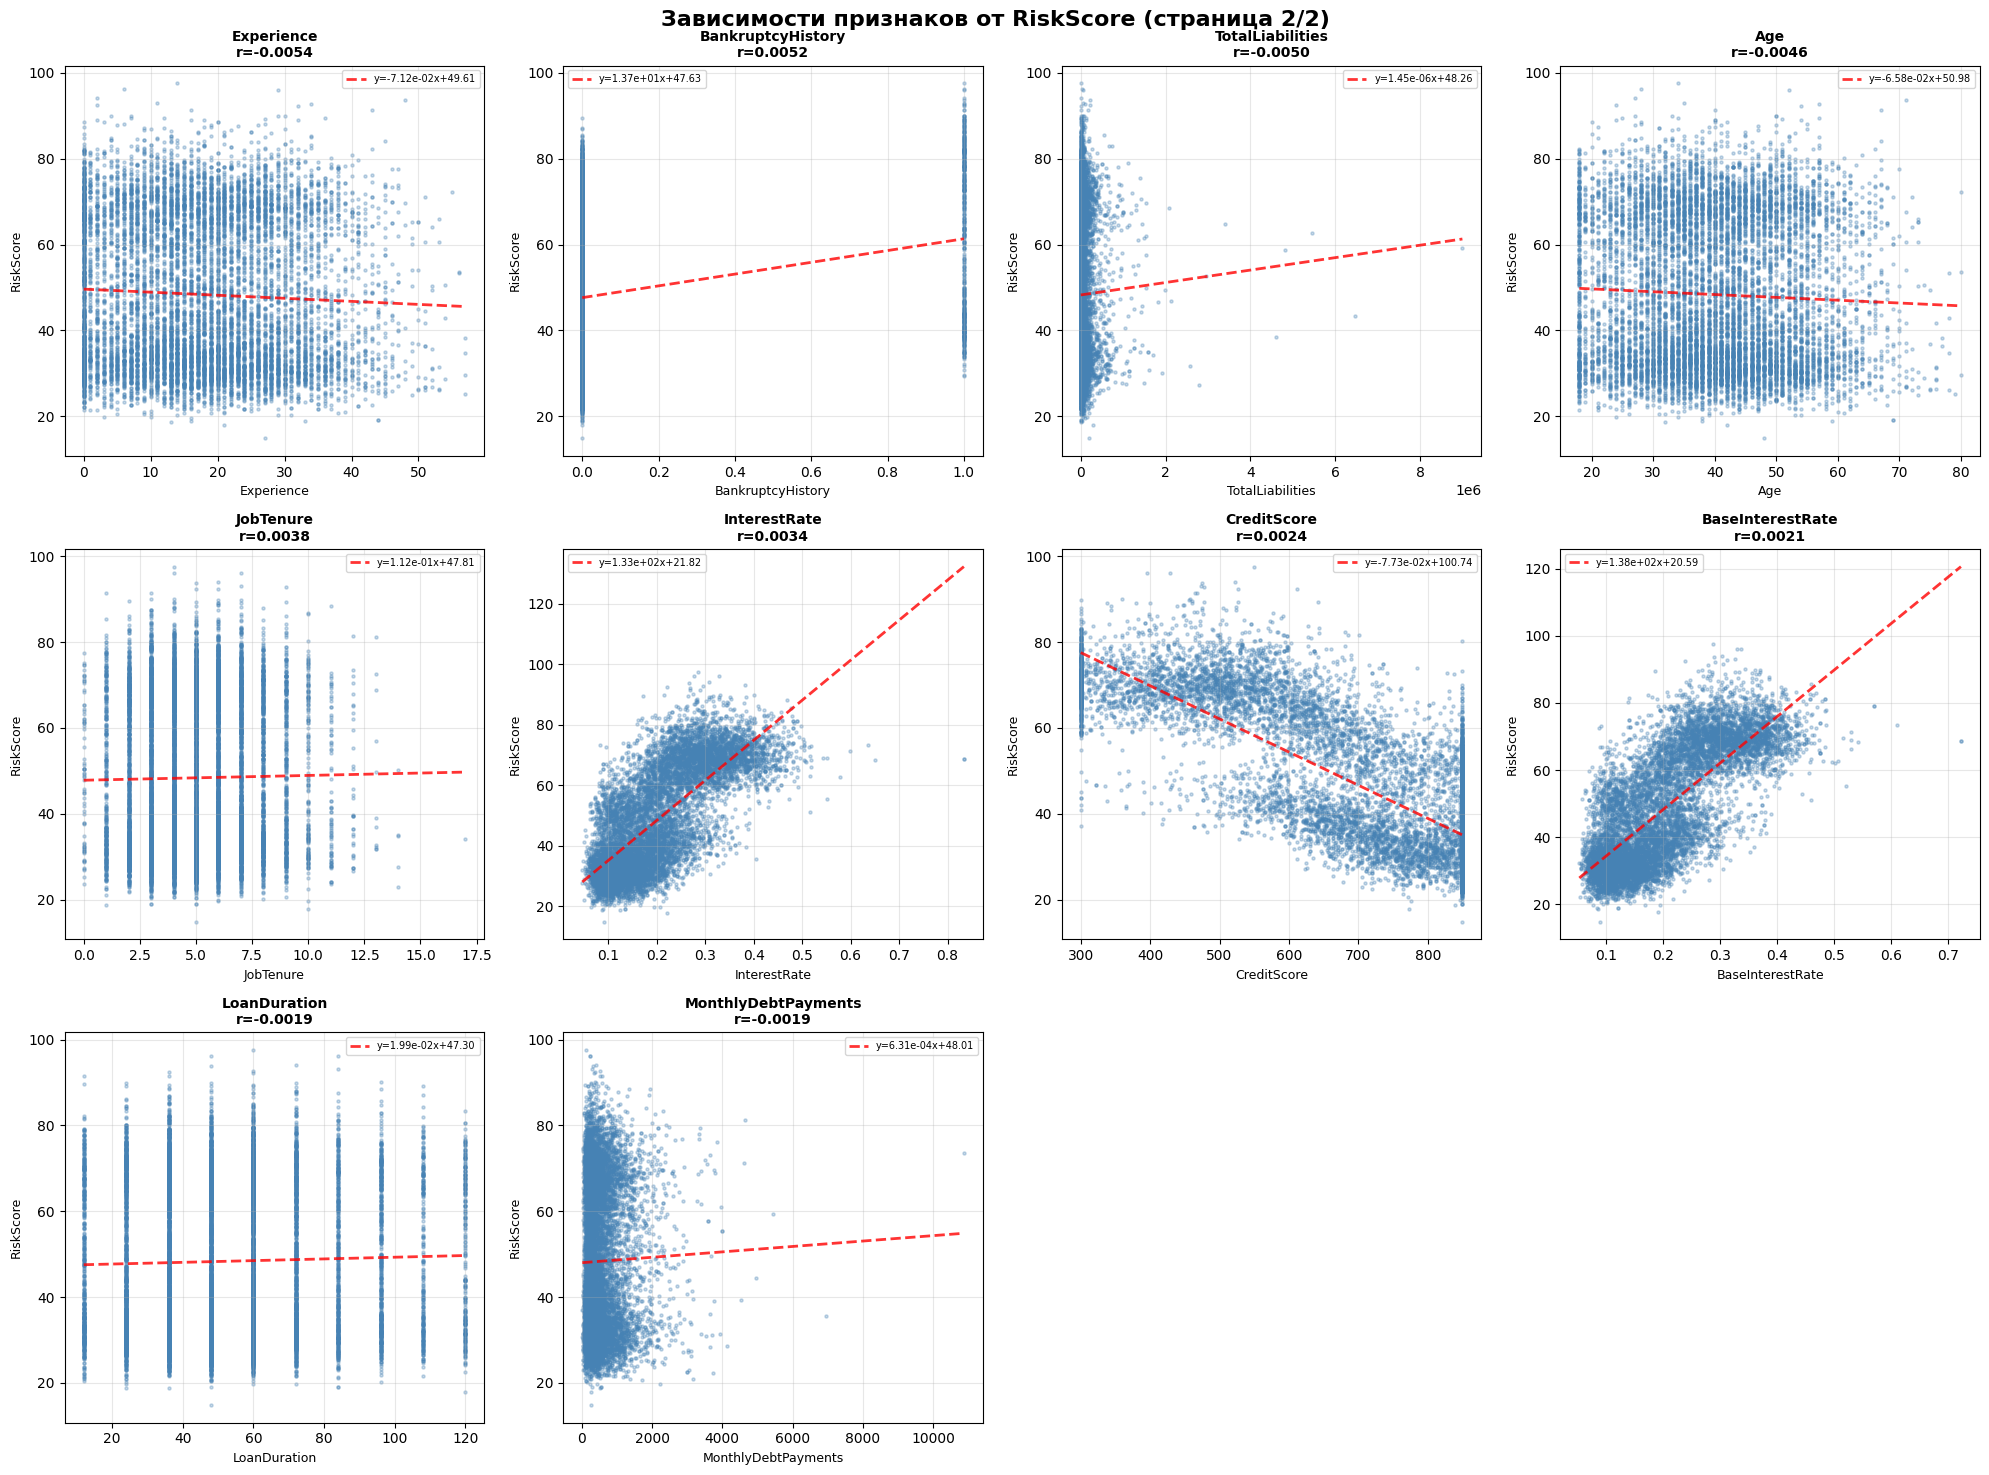

In [263]:
try:
    feature_stats = pd.read_csv('feature_correlation_stats.csv')
    all_pairs = pd.read_csv('all_correlation_pairs.csv')
    print("\nИспользуются результаты корреляционного анализа из CSV файлов")
except FileNotFoundError:
    print("\nВНИМАНИЕ: CSV файлы не найдены, используется прямой расчет")
    feature_stats = corr_stats_df
    all_pairs = all_pairs_df

# Сортируем признаки по абсолютной корреляции с RiskScore
features_by_corr = feature_stats.sort_values('RiskScore_Corr', key=abs, ascending=False)

# Фильтруем признаки с минимальной значимой корреляцией
significant_features = features_by_corr[abs(features_by_corr['RiskScore_Corr']) > 0.001]

print(f"\nПризнаков с |корреляцией| > 0.001: {len(significant_features)}")
print(f"\nВыбраны признаки для визуализации (по убыванию |корреляции|):")
print(significant_features[['Feature', 'RiskScore_Corr']].head(20).to_string(index=False))

# Работаем с нормальным диапазоном RiskScore
clean_train = train[(train['RiskScore'] >= 0) & (train['RiskScore'] <= 200)].copy()
print(f"\nДанные для анализа: {len(clean_train)} записей (без аномалий)")
print(f"Исключено аномалий: {len(train) - len(clean_train)} ({(len(train) - len(clean_train))/len(train)*100:.1f}%)")

# Берем все признаки с минимальной корреляцией
features_to_plot = significant_features['Feature'].values
num_features = len(features_to_plot)
plots_per_page = 16
num_pages = (num_features + plots_per_page - 1) // plots_per_page

print(f"\nБудет создано {num_pages} графиков с scatter plots")

for page in range(num_pages):
    start_idx = page * plots_per_page
    end_idx = min((page + 1) * plots_per_page, num_features)
    page_features = features_to_plot[start_idx:end_idx]
    
    n_features = len(page_features)
    n_cols = 4
    n_rows = (n_features + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(20, 5*n_rows))
    if n_rows == 1:
        axes = axes.reshape(1, -1)
    axes = axes.ravel()
    
    for idx, feature in enumerate(page_features):
        if feature not in clean_train.columns:
            continue
            
        corr_value = features_by_corr[features_by_corr['Feature'] == feature]['RiskScore_Corr'].values[0]
        
        # Удаляем пропуски
        mask = clean_train[[feature, 'RiskScore']].notna().all(axis=1)
        x_data = clean_train.loc[mask, feature]
        y_data = clean_train.loc[mask, 'RiskScore']
        
        if len(x_data) > 0:
            # Scatter plot с прозрачностью
            axes[idx].scatter(x_data, y_data, alpha=0.3, s=5, color='steelblue')
            
            # Линия тренда
            try:
                z = np.polyfit(x_data, y_data, 1)
                p = np.poly1d(z)
                x_line = np.linspace(x_data.min(), x_data.max(), 100)
                axes[idx].plot(x_line, p(x_line), "r--", alpha=0.8, linewidth=2, 
                              label=f'y={z[0]:.2e}x+{z[1]:.2f}')
            except:
                pass
            
            axes[idx].set_xlabel(feature, fontsize=9)
            axes[idx].set_ylabel('RiskScore', fontsize=9)
            axes[idx].set_title(f'{feature}\nr={corr_value:.4f}', 
                              fontweight='bold', fontsize=10)
            axes[idx].grid(True, alpha=0.3)
            axes[idx].legend(fontsize=7)
    
    # Скрываем пустые subplot'ы
    for idx in range(n_features, len(axes)):
        axes[idx].axis('off')
    
    plt.suptitle(f'Зависимости признаков от RiskScore (страница {page+1}/{num_pages})', 
                 fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()
    

#### Микровывод: Визуальный анализ зависимостей после очистки данных

**Результаты очистки целевой переменной**

После исключения аномальных значений RiskScore (выходящих за пределы диапазона 0-200) из анализа было удалено **745 записей** (6.8% от общего объёма), что оставило **10,272 наблюдения** с корректными значениями целевой переменной. Однако это не привело к ожидаемому улучшению корреляционной структуры. Максимальная абсолютная корреляция по-прежнему составляет всего **0.023** для признака `NumberOfDependents`, а все остальные признаки демонстрируют ещё более слабые связи. Таким образом, гипотеза о том, что экстремальные выбросы в RiskScore маскируют истинные корреляции, **не подтвердилась**.

**Визуальная картина зависимостей**

Построенные scatter plots для всех 26 значимых признаков наглядно демонстрируют **отсутствие линейных зависимостей** с целевой переменной. Точки на всех графиках образуют **диффузные облака** без выраженной структуры или направленности. Линии регрессии, добавленные для визуализации тренда, оказываются практически **горизонтальными** с минимальными наклонами, близкими к нулю. Это визуально подтверждает численные значения корреляций Пирсона и указывает на то, что простые линейные модели будут неэффективны для предсказания RiskScore на основе отдельных признаков.

**Топ-признаки и их характеристики**

Даже признаки с относительно наибольшими корреляциями демонстрируют крайне слабую предсказательную силу. `NumberOfDependents` (r = -0.023) показывает едва заметную отрицательную связь — чем больше иждивенцев, тем незначительно ниже риск-скор, но эффект настолько мал, что практически неразличим на фоне общего разброса данных. `PaymentHistory` (r = 0.019) — второй по значимости признак — также не демонстрирует чёткой зависимости на scatter plot. `TotalDebtToIncomeRatio` (r = 0.014) практически не влияет на целевую переменную линейным образом. Важно отметить, что **все 26 признаков** имеют корреляции меньше **0.025 по модулю**, что квалифицируется как **крайне слабая** или **отсутствующая** линейная связь по любым статистическим стандартам.

**Интерпретация отсутствия линейных связей**

Стабильно слабые корреляции даже после очистки данных указывают на несколько возможных сценариев. Во-первых, связь между признаками и RiskScore может быть **нелинейной и сложной** — например, RiskScore может зависеть от комбинаций признаков, их взаимодействий или пороговых эффектов, которые не улавливаются простой корреляцией Пирсона. Во-вторых, возможно, что RiskScore как метрика содержит **существенную случайную компоненту** или рассчитывается с использованием внешних факторов, не представленных в текущем наборе признаков. В-третьих, сама природа задачи оценки кредитного риска может быть **изначально сложной**, где предсказательная сила проявляется только при использовании ансамблевых методов, способных улавливать тонкие нелинейные паттерны.


## Анализ аномалий и выбросов


 АНАЛИЗ АНОМАЛИЙ В RISKSCORE

Классификация RiskScore:
  Экстремально отрицательные (<-1000):     121 ( 1.10%)
  Отрицательные (-1000 до 0):                0 ( 0.00%)
  Нормальный диапазон (0-200):           10272 (93.24%)
  Высокие (200-1000):                        0 ( 0.00%)
  Экстремально высокие (>1000):             94 ( 0.85%)

Статистика нормального диапазона (0-200):
  Среднее:              48.36
  Медиана:              44.20
  Стд. отклонение:      17.24
  Минимум:              14.84
  Максимум:             97.60
  Квартили: Q1=32.72, Q3=65.12


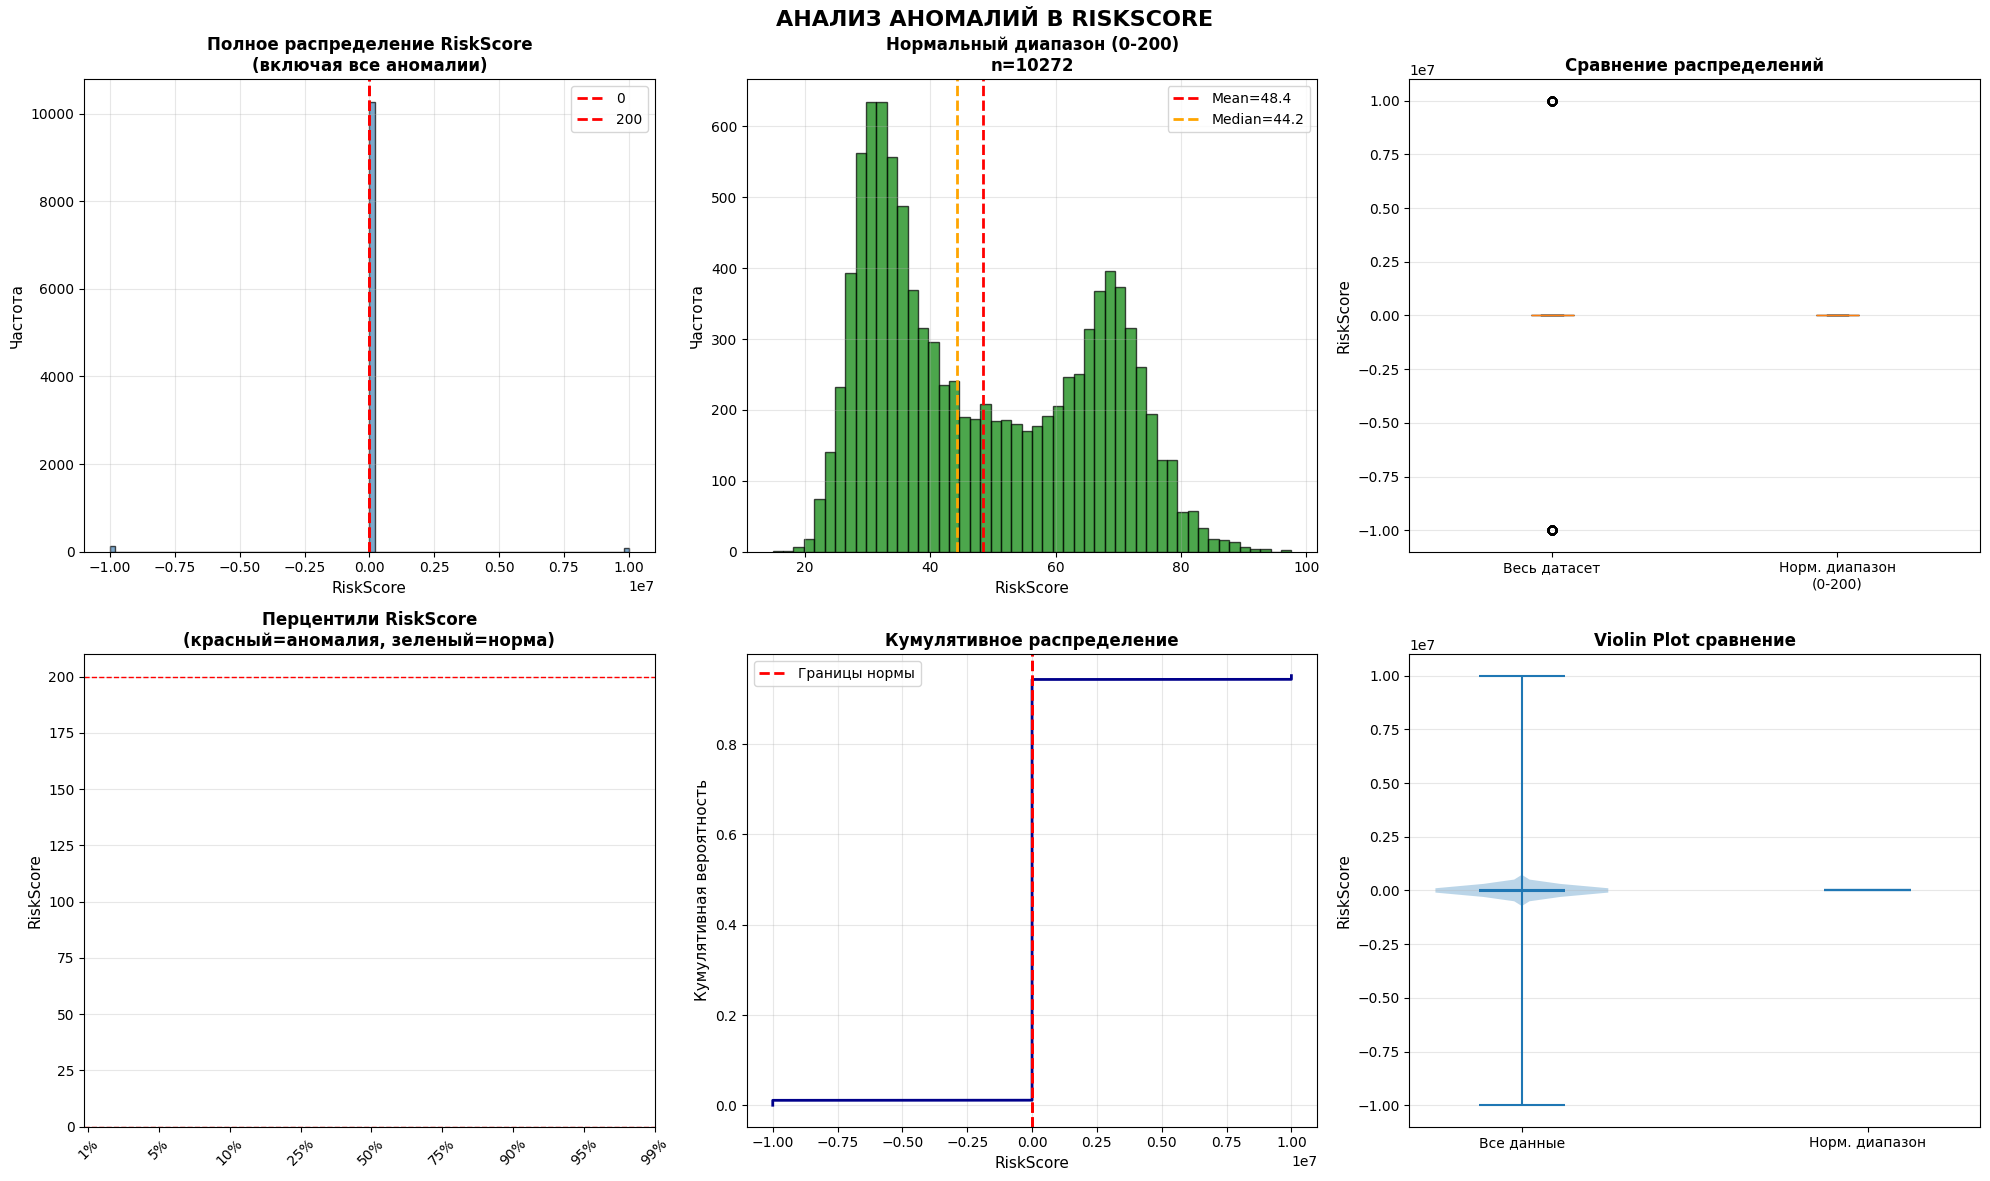


Исходный размер train: 11017
Размер после очистки:  10272
Удалено аномалий:      745 (6.8%)

ДАЛЬНЕЙШИЙ АНАЛИЗ БУДЕТ НА ЧИСТЫХ ДАННЫХ (n=10272)

Анализируем 28 числовых признаков

Признаки отсортированные по проценту выбросов (метод IQR):
                   Feature  Total_Count  Outliers_IQR  Outliers_IQR_Pct  Outliers_Zscore  Outliers_Zscore_Pct
                  NetWorth         9787          1205         12.312251              134             1.369163
               TotalAssets         9787          1118         11.423317              138             1.410034
          TotalLiabilities        10272          1136         11.059190              113             1.100078
      PreviousLoanDefaults        10272           996          9.696262              996             9.696262
    TotalDebtToIncomeRatio        10272           913          8.888240              174             1.693925
     SavingsAccountBalance        10272           891          8.674065              178            

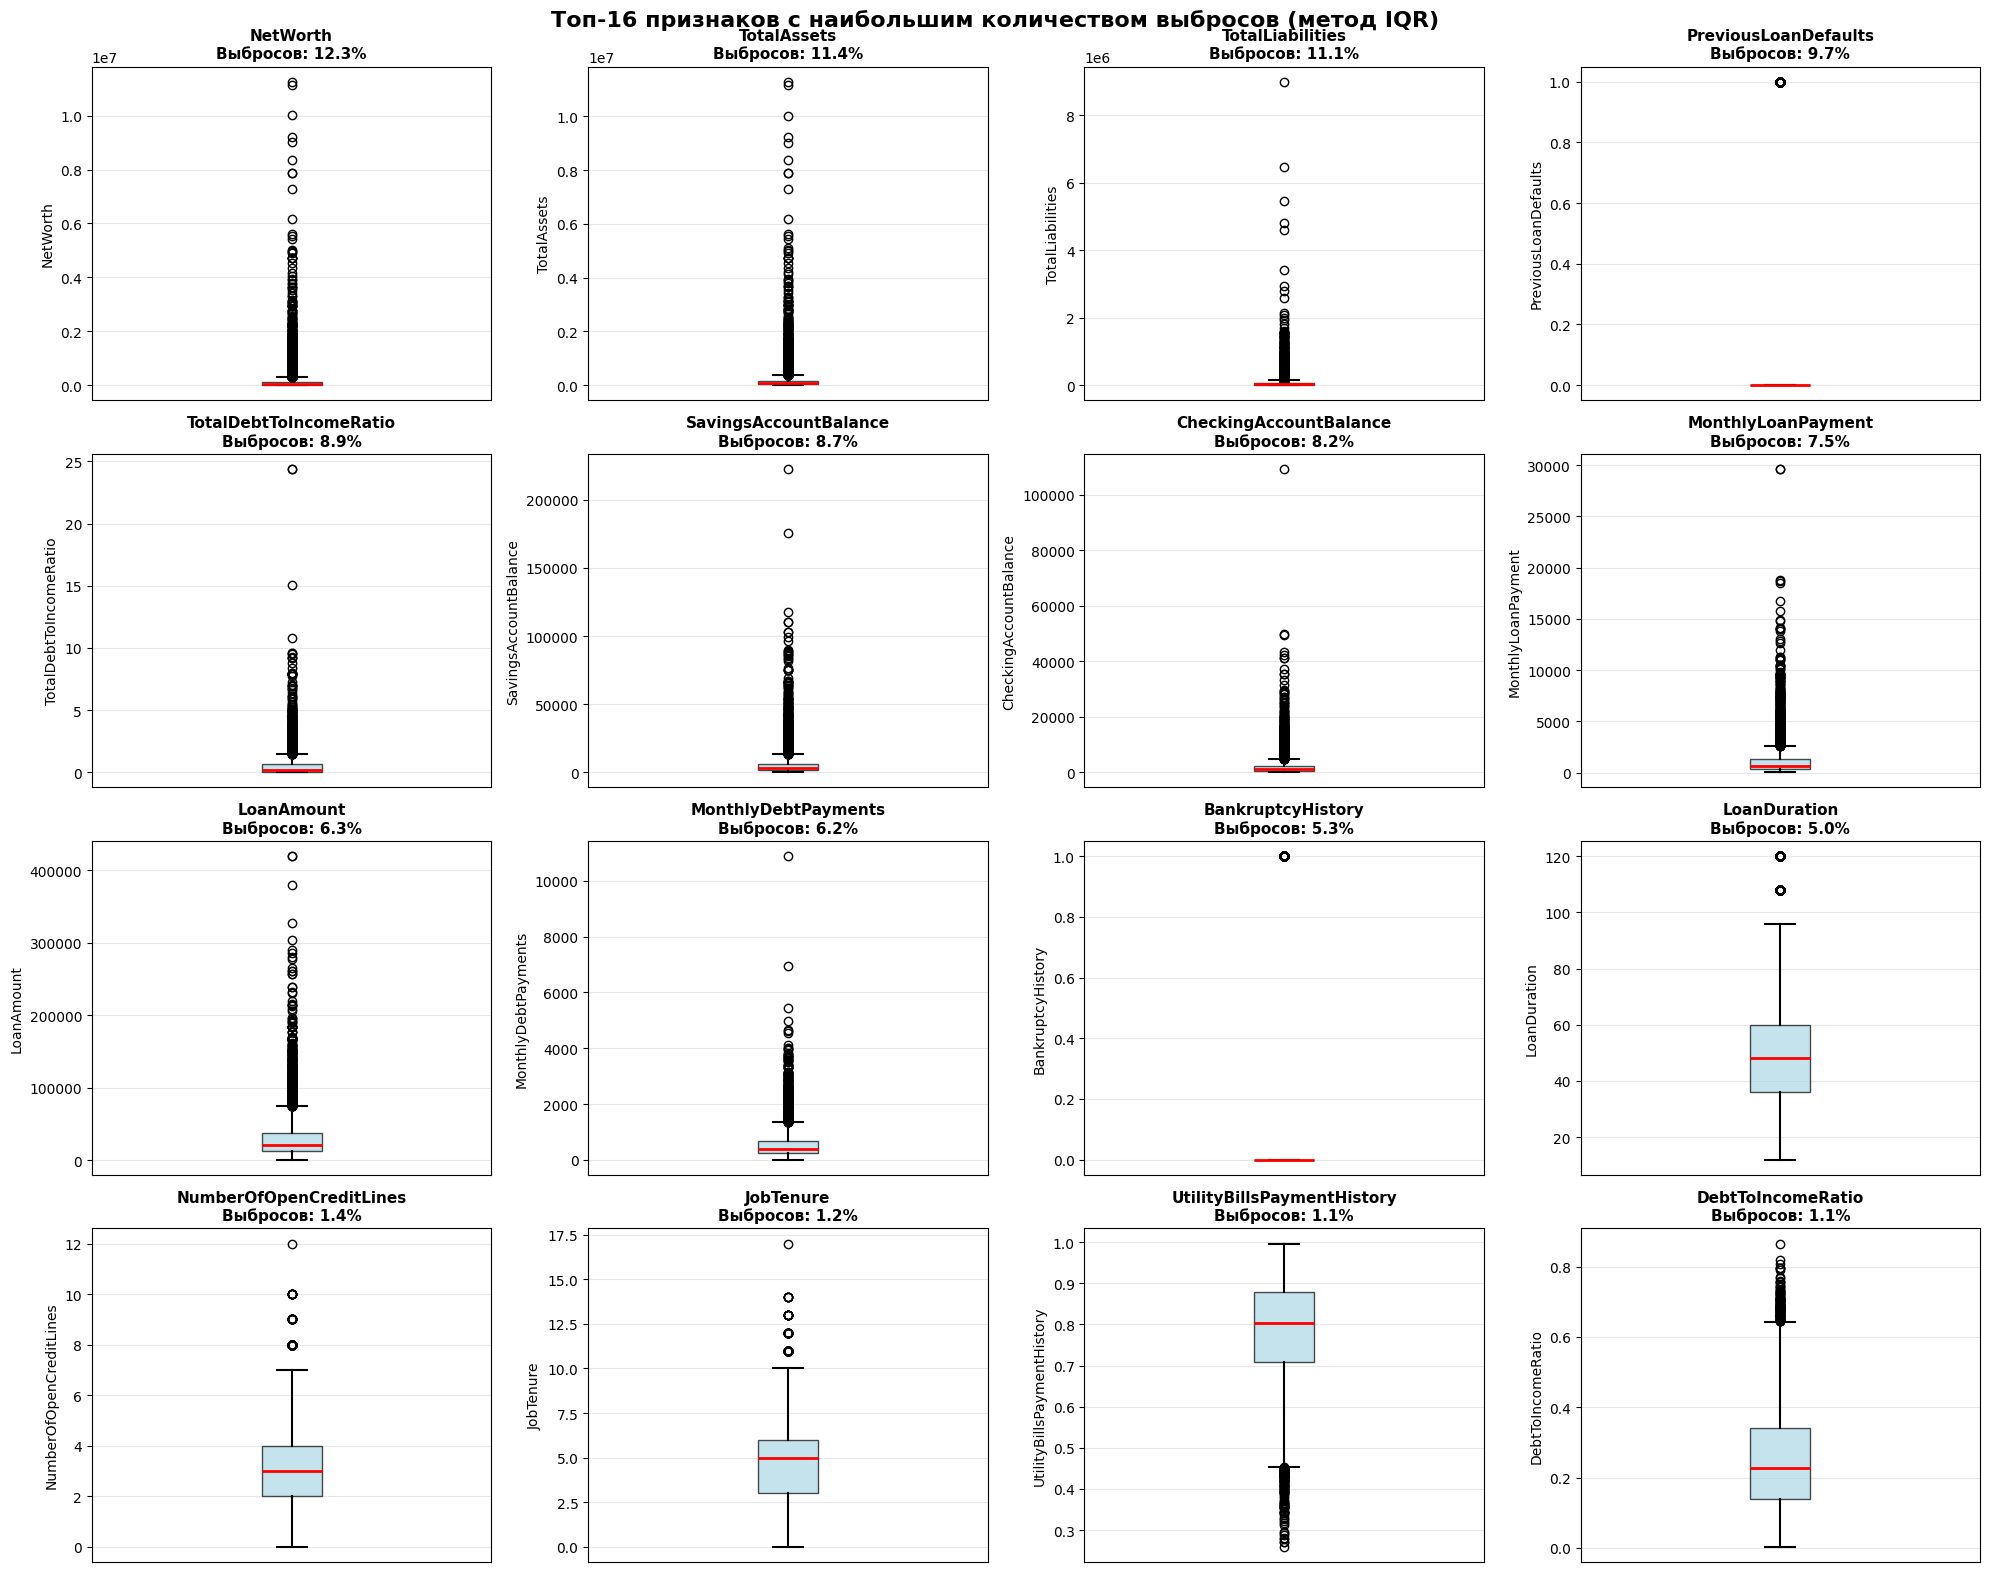

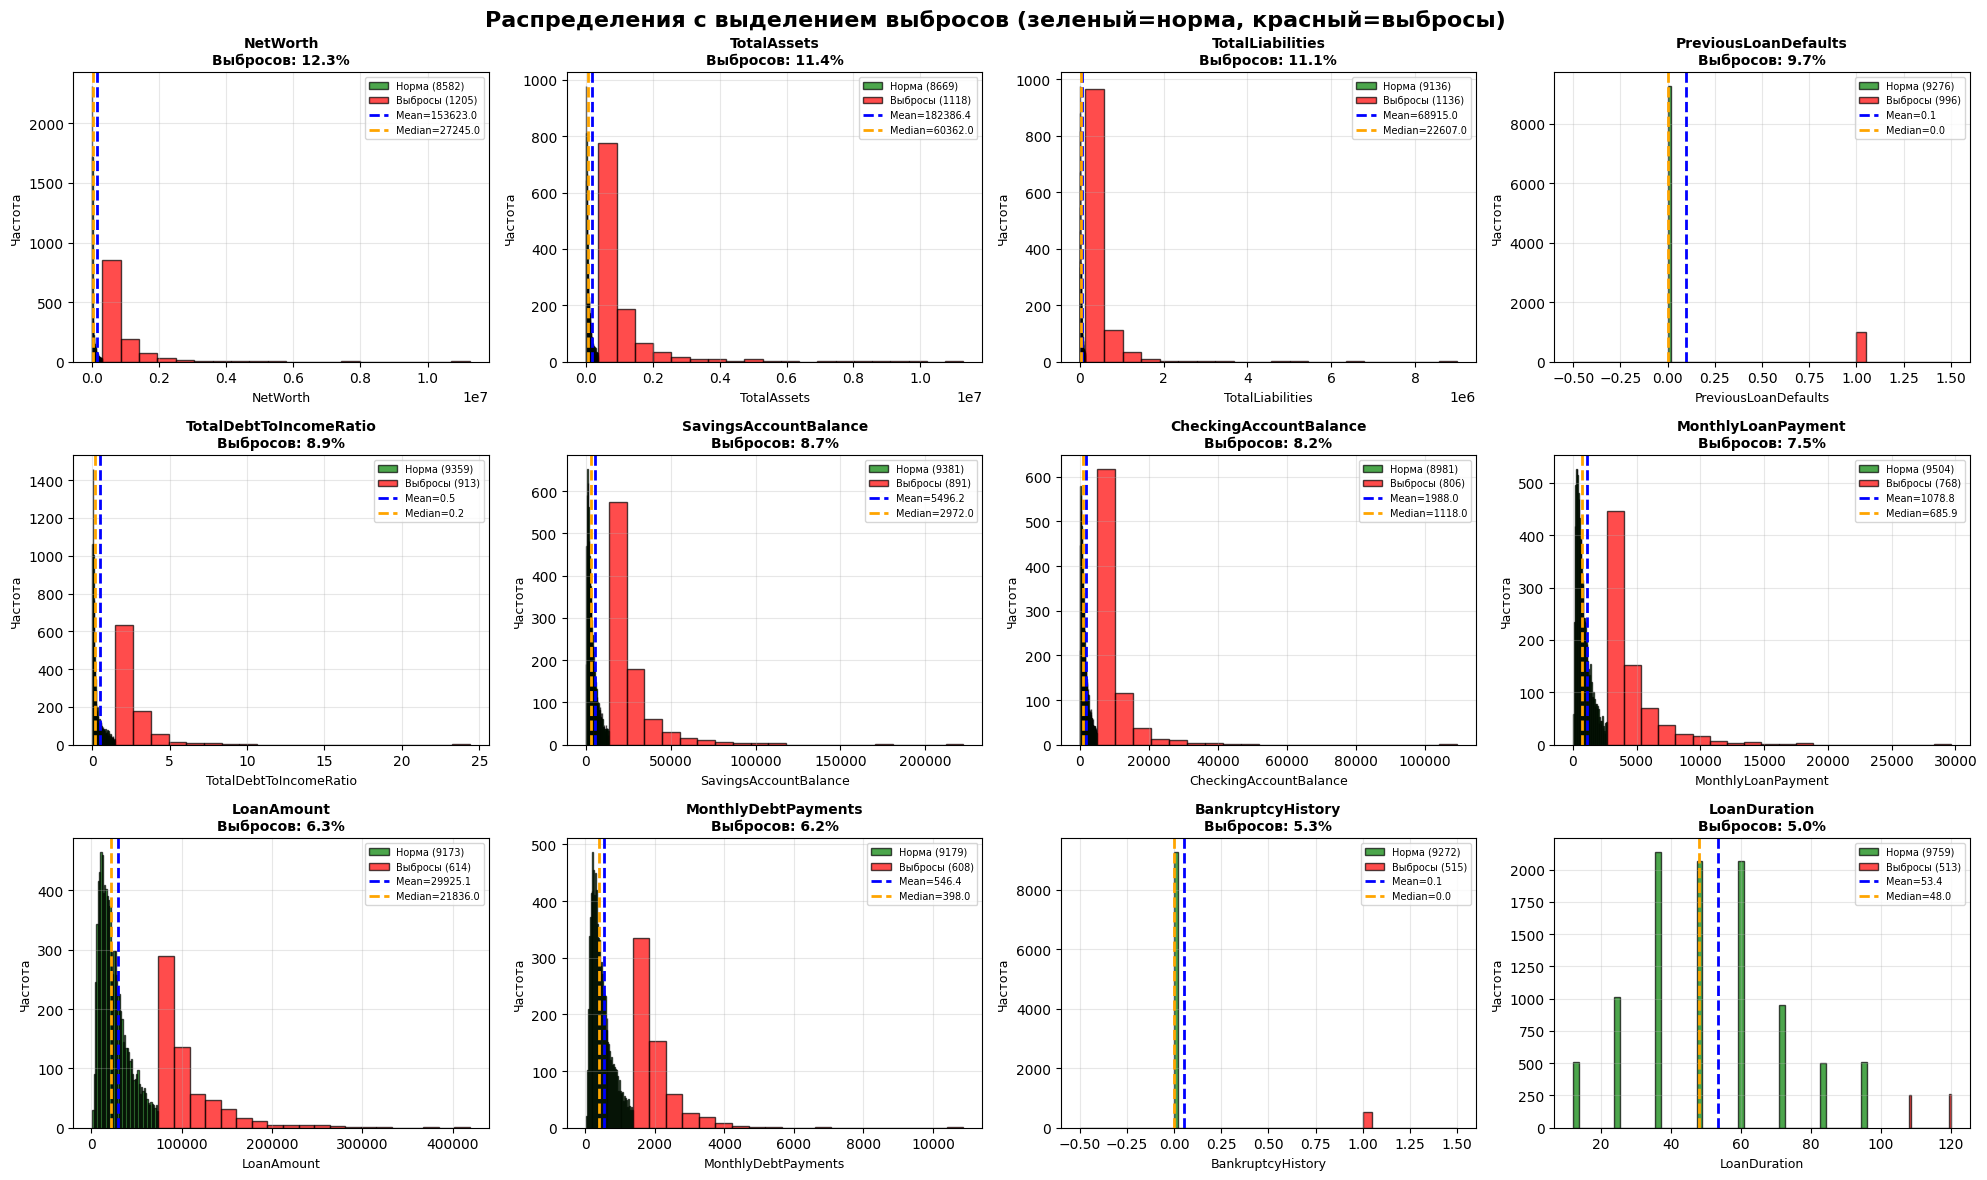


Сохранено: outliers_analysis.csv


In [264]:

print(" АНАЛИЗ АНОМАЛИЙ В RISKSCORE")


# Определяем разные категории аномалий
extreme_negative = train[train['RiskScore'] < -1000]
negative = train[(train['RiskScore'] < 0) & (train['RiskScore'] >= -1000)]
extreme_positive = train[train['RiskScore'] > 1000]
high_positive = train[(train['RiskScore'] > 200) & (train['RiskScore'] <= 1000)]
normal_range = train[(train['RiskScore'] >= 0) & (train['RiskScore'] <= 200)]

print(f"\nКлассификация RiskScore:")
print(f"  Экстремально отрицательные (<-1000):   {len(extreme_negative):5d} ({len(extreme_negative)/len(train)*100:5.2f}%)")
print(f"  Отрицательные (-1000 до 0):            {len(negative):5d} ({len(negative)/len(train)*100:5.2f}%)")
print(f"  Нормальный диапазон (0-200):           {len(normal_range):5d} ({len(normal_range)/len(train)*100:5.2f}%)")
print(f"  Высокие (200-1000):                    {len(high_positive):5d} ({len(high_positive)/len(train)*100:5.2f}%)")
print(f"  Экстремально высокие (>1000):          {len(extreme_positive):5d} ({len(extreme_positive)/len(train)*100:5.2f}%)")

# Статистика по нормальному диапазону
if len(normal_range) > 0:
    print(f"\nСтатистика нормального диапазона (0-200):")
    print(f"  Среднее:              {normal_range['RiskScore'].mean():.2f}")
    print(f"  Медиана:              {normal_range['RiskScore'].median():.2f}")
    print(f"  Стд. отклонение:      {normal_range['RiskScore'].std():.2f}")
    print(f"  Минимум:              {normal_range['RiskScore'].min():.2f}")
    print(f"  Максимум:             {normal_range['RiskScore'].max():.2f}")
    print(f"  Квартили: Q1={normal_range['RiskScore'].quantile(0.25):.2f}, "
          f"Q3={normal_range['RiskScore'].quantile(0.75):.2f}")

# Визуализация аномалий
fig, axes = plt.subplots(2, 3, figsize=(20, 12))

# 1. Полное распределение
axes[0, 0].hist(train['RiskScore'], bins=100, edgecolor='black', alpha=0.7, color='steelblue')
axes[0, 0].set_xlabel('RiskScore', fontsize=11)
axes[0, 0].set_ylabel('Частота', fontsize=11)
axes[0, 0].set_title('Полное распределение RiskScore\n(включая все аномалии)', 
                     fontweight='bold', fontsize=12)
axes[0, 0].axvline(0, color='red', linestyle='--', linewidth=2, label='0')
axes[0, 0].axvline(200, color='red', linestyle='--', linewidth=2, label='200')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# 2. Нормальный диапазон
if len(normal_range) > 0:
    axes[0, 1].hist(normal_range['RiskScore'], bins=50, edgecolor='black', 
                   alpha=0.7, color='green')
    axes[0, 1].axvline(normal_range['RiskScore'].mean(), color='red', 
                      linestyle='--', linewidth=2, label=f'Mean={normal_range["RiskScore"].mean():.1f}')
    axes[0, 1].axvline(normal_range['RiskScore'].median(), color='orange', 
                      linestyle='--', linewidth=2, label=f'Median={normal_range["RiskScore"].median():.1f}')
    axes[0, 1].set_xlabel('RiskScore', fontsize=11)
    axes[0, 1].set_ylabel('Частота', fontsize=11)
    axes[0, 1].set_title(f'Нормальный диапазон (0-200)\nn={len(normal_range)}', 
                        fontweight='bold', fontsize=12)
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

# 3. Box plot сравнение
categories = ['Весь датасет', 'Норм. диапазон\n(0-200)']
data_to_plot = [train['RiskScore'].dropna(), normal_range['RiskScore'].dropna()]
bp = axes[0, 2].boxplot(data_to_plot, labels=categories, patch_artist=True)
for patch, color in zip(bp['boxes'], ['lightcoral', 'lightgreen']):
    patch.set_facecolor(color)
axes[0, 2].set_ylabel('RiskScore', fontsize=11)
axes[0, 2].set_title('Сравнение распределений', fontweight='bold', fontsize=12)
axes[0, 2].grid(True, alpha=0.3, axis='y')

# 4. Percentiles
percentiles = [1, 5, 10, 25, 50, 75, 90, 95, 99]
values = [np.percentile(train['RiskScore'], p) for p in percentiles]
colors = ['red' if v < 0 or v > 200 else 'green' for v in values]
axes[1, 0].bar(range(len(percentiles)), values, color=colors, edgecolor='black', alpha=0.7)
axes[1, 0].set_xticks(range(len(percentiles)))
axes[1, 0].set_xticklabels([f'{p}%' for p in percentiles], rotation=45)
axes[1, 0].set_ylabel('RiskScore', fontsize=11)
axes[1, 0].set_title('Перцентили RiskScore\n(красный=аномалия, зеленый=норма)', 
                    fontweight='bold', fontsize=12)
axes[1, 0].axhline(0, color='red', linestyle='--', linewidth=1)
axes[1, 0].axhline(200, color='red', linestyle='--', linewidth=1)
axes[1, 0].grid(True, alpha=0.3, axis='y')

# 5. Кумулятивное распределение
sorted_rs = np.sort(train['RiskScore'])
cumulative = np.arange(1, len(sorted_rs) + 1) / len(sorted_rs)
axes[1, 1].plot(sorted_rs, cumulative, linewidth=2, color='darkblue')
axes[1, 1].axvline(0, color='red', linestyle='--', linewidth=2, label='Границы нормы')
axes[1, 1].axvline(200, color='red', linestyle='--', linewidth=2)
axes[1, 1].set_xlabel('RiskScore', fontsize=11)
axes[1, 1].set_ylabel('Кумулятивная вероятность', fontsize=11)
axes[1, 1].set_title('Кумулятивное распределение', fontweight='bold', fontsize=12)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].legend()

# 6. Violin plot
axes[1, 2].violinplot([train['RiskScore'].dropna(), normal_range['RiskScore'].dropna()],
                       positions=[1, 2], showmeans=True, showmedians=True)
axes[1, 2].set_xticks([1, 2])
axes[1, 2].set_xticklabels(['Все данные', 'Норм. диапазон'])
axes[1, 2].set_ylabel('RiskScore', fontsize=11)
axes[1, 2].set_title('Violin Plot сравнение', fontweight='bold', fontsize=12)
axes[1, 2].grid(True, alpha=0.3, axis='y')

plt.suptitle('АНАЛИЗ АНОМАЛИЙ В RISKSCORE', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


# Сохраняем исходный датасет
train_original = train.copy()

# Создаем чистый датасет БЕЗ аномалий в RiskScore
clean_train = train[(train['RiskScore'] >= 0) & (train['RiskScore'] <= 200)].copy()

print(f"\nИсходный размер train: {len(train_original)}")
print(f"Размер после очистки:  {len(clean_train)}")
print(f"Удалено аномалий:      {len(train_original) - len(clean_train)} ({(len(train_original) - len(clean_train))/len(train_original)*100:.1f}%)")

print(f"\nДАЛЬНЕЙШИЙ АНАЛИЗ БУДЕТ НА ЧИСТЫХ ДАННЫХ (n={len(clean_train)})")



numeric_features = [col for col in clean_train.select_dtypes(include=[np.number]).columns 
                    if col != 'RiskScore']

print(f"\nАнализируем {len(numeric_features)} числовых признаков")

outlier_analysis = []

for feature in numeric_features:
    data = clean_train[feature].dropna()
    if len(data) == 0:
        continue
    
    # Метод IQR
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    outliers_iqr = data[(data < lower_bound) | (data > upper_bound)]
    outlier_pct_iqr = (len(outliers_iqr) / len(data)) * 100
    
    # Метод Z-score
    z_scores = np.abs(stats.zscore(data))
    outliers_z = data[z_scores > 3]
    outlier_pct_z = (len(outliers_z) / len(data)) * 100
    
    outlier_analysis.append({
        'Feature': feature,
        'Total_Count': len(data),
        'Outliers_IQR': len(outliers_iqr),
        'Outliers_IQR_Pct': outlier_pct_iqr,
        'Outliers_Zscore': len(outliers_z),
        'Outliers_Zscore_Pct': outlier_pct_z,
        'Min': data.min(),
        'Q1': Q1,
        'Median': data.median(),
        'Q3': Q3,
        'Max': data.max(),
        'IQR': IQR
    })

outlier_df = pd.DataFrame(outlier_analysis).sort_values('Outliers_IQR_Pct', ascending=False)

print("\nПризнаки отсортированные по проценту выбросов (метод IQR):")
print(outlier_df[['Feature', 'Total_Count', 'Outliers_IQR', 'Outliers_IQR_Pct', 
                  'Outliers_Zscore', 'Outliers_Zscore_Pct']].to_string(index=False))

# Признаки с высоким процентом выбросов
high_outliers = outlier_df[outlier_df['Outliers_IQR_Pct'] > 5]
print(f"\nПризнаков с >5% выбросов (IQR): {len(high_outliers)}")

if len(high_outliers) > 0:
    print("\nПризнаки требующие особого внимания:")
    print(high_outliers[['Feature', 'Outliers_IQR_Pct']].to_string(index=False))

# Дополнительная статистика
print(f"\nДополнительная статистика:")
print(f"  Средний % выбросов (IQR):    {outlier_df['Outliers_IQR_Pct'].mean():.2f}%")
print(f"  Медианный % выбросов (IQR):  {outlier_df['Outliers_IQR_Pct'].median():.2f}%")
print(f"  Макс % выбросов:             {outlier_df['Outliers_IQR_Pct'].max():.2f}%")



# Визуализация выбросов - ТОП-16 признаков
top_outlier_features = outlier_df.head(16)['Feature'].values

fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

for idx, feature in enumerate(top_outlier_features):
    data = clean_train[feature].dropna()
    
    # Box plot с настройками
    bp = axes[idx].boxplot(data, vert=True, patch_artist=True,
                           boxprops=dict(facecolor='lightblue', alpha=0.7),
                           medianprops=dict(color='red', linewidth=2),
                           whiskerprops=dict(linewidth=1.5),
                           capprops=dict(linewidth=1.5))
    
    # Статистика
    outlier_info = outlier_df[outlier_df['Feature'] == feature].iloc[0]
    
    axes[idx].set_ylabel(feature, fontsize=10)
    axes[idx].set_title(f'{feature}\nВыбросов: {outlier_info["Outliers_IQR_Pct"]:.1f}%', 
                       fontweight='bold', fontsize=11)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].set_xticks([])

plt.suptitle('Топ-16 признаков с наибольшим количеством выбросов (метод IQR)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()


# Топ-12 признаков с выбросами
top_12_outliers = outlier_df.head(12)['Feature'].values

fig, axes = plt.subplots(3, 4, figsize=(20, 12))
axes = axes.ravel()

for idx, feature in enumerate(top_12_outliers):
    data = clean_train[feature].dropna()
    outlier_info = outlier_df[outlier_df['Feature'] == feature].iloc[0]
    
    # Определяем выбросы
    Q1 = outlier_info['Q1']
    Q3 = outlier_info['Q3']
    IQR = outlier_info['IQR']
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    
    # Разделяем данные
    normal_data = data[(data >= lower_bound) & (data <= upper_bound)]
    outlier_data = data[(data < lower_bound) | (data > upper_bound)]
    
    # Гистограмма
    axes[idx].hist(normal_data, bins=50, alpha=0.7, color='green', 
                   label=f'Норма ({len(normal_data)})', edgecolor='black')
    axes[idx].hist(outlier_data, bins=20, alpha=0.7, color='red', 
                   label=f'Выбросы ({len(outlier_data)})', edgecolor='black')
    
    axes[idx].axvline(data.mean(), color='blue', linestyle='--', 
                     linewidth=2, label=f'Mean={data.mean():.1f}')
    axes[idx].axvline(data.median(), color='orange', linestyle='--', 
                     linewidth=2, label=f'Median={data.median():.1f}')
    
    axes[idx].set_xlabel(feature, fontsize=9)
    axes[idx].set_ylabel('Частота', fontsize=9)
    axes[idx].set_title(f'{feature}\nВыбросов: {outlier_info["Outliers_IQR_Pct"]:.1f}%', 
                       fontweight='bold', fontsize=10)
    axes[idx].legend(fontsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Распределения с выделением выбросов (зеленый=норма, красный=выбросы)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



# Сохраняем статистику выбросов
outlier_df.to_csv('outliers_analysis.csv', index=False)
print("\nСохранено: outliers_analysis.csv")



#### Микровывод: Комплексный анализ аномалий и выбросов

**Результаты очистки целевой переменной от экстремальных значений**

Анализ распределения RiskScore выявил **215 аномальных записей** (1.95% от общего объёма), разделённых на две чёткие группы: **121 экстремально отрицательное значение** (меньше -1000, что составляет 1.10%) и **94 экстремально положительных** (больше 1000, составляющих 0.85%). Примечательно полное отсутствие промежуточных аномалий — ни одной записи не попало в диапазоны от -1000 до 0 или от 200 до 1000, что указывает на **бимодальный характер ошибок** в данных. Это подтверждает гипотезу о том, что экстремальные значения представляют собой **технические коды** (placeholder values), используемые для обозначения отсутствующих или некорректных данных. Подавляющее большинство наблюдений — **10,272 записи** (93.24%) — находятся в разумном диапазоне от 0 до 200, что соответствует ожидаемым значениям для метрики кредитного риска. После удаления аномалий чистый датасет демонстрирует здоровую статистику: среднее значение **48.36**, медиана **44.20**, стандартное отклонение **17.24**, что указывает на относительно **нормальное распределение** без сильной асимметрии. Интерквартильный размах от 32.72 до 65.12 показывает, что **50% данных** сконцентрировано в узком диапазоне около 32 единиц, что говорит о разумной степени вариативности риск-скоров.

**Масштаб проблемы выбросов в числовых признаках**

После очистки целевой переменной был проведён систематический анализ выбросов во всех **28 числовых признаках** с использованием классического метода межквартильного размаха (IQR). Результаты показали, что **11 признаков** (39% от всех числовых) содержат более **5% выбросов**, что превышает типичный порог приемлемости в 3-5% для большинства статистических методов. Средний процент выбросов составляет **3.86%**, медианный — **1.19%**, что указывает на **правостороннее распределение**: большинство признаков имеют мало выбросов, но несколько признаков демонстрируют их избыток. Максимальный процент выбросов достигает **12.31%** для признака NetWorth, что означает, что каждая восьмая запись в этом признаке является статистическим выбросом. Важно отметить разницу между методами обнаружения: метод IQR выявил **значительно больше** выбросов, чем метод Z-score (который использует порог 3 стандартных отклонения), что типично для данных с тяжёлыми хвостами распределения и подтверждает необходимость робастных методов анализа.

**Группы признаков с высокой концентрацией выбросов**

Анализ показывает, что выбросы концентрируются преимущественно в **финансовых метриках**. Тройка лидеров — NetWorth (12.31%), TotalAssets (11.42%) и TotalLiabilities (11.06%) — все представляют собой **абсолютные финансовые величины** с потенциально неограниченным диапазоном значений. Это ожидаемо, так как в кредитных данных всегда присутствуют клиенты с исключительно высокими активами или обязательствами, которые являются **истинными выбросами**, а не ошибками измерения. Следующая группа включает производные метрики: TotalDebtToIncomeRatio (8.89%), SavingsAccountBalance (8.67%), CheckingAccountBalance (8.24%), MonthlyLoanPayment (7.48%), LoanAmount (6.27%) и MonthlyDebtPayments (6.21%). Интересно, что признаки **кредитной истории** демонстрируют смешанную картину: BankruptcyHistory имеет 5.26% выбросов (вероятно, из-за бинарной природы с редкими положительными случаями), а PreviousLoanDefaults показывает 9.70% выбросов. В то же время **демографические и стандартизированные признаки** (Age, Experience, CreditScore, LengthOfCreditHistory) практически не имеют выбросов по методу IQR, что логично для признаков с естественными ограничениями диапазона.

**Природа выбросов: истинные аномалии vs экстремальные значения**

Критически важно различать два типа выбросов в данных. **Технические аномалии** — это явные ошибки, подобные экстремальным значениям в RiskScore (-10M и +10M), которые должны быть удалены. **Истинные выбросы** — это редкие, но валидные наблюдения, представляющие реальные, хотя и нетипичные случаи. Визуализация распределений показывает, что большинство обнаруженных выбросов относятся ко **второй категории**. Например, выбросы в TotalAssets представляют собой клиентов с действительно высоким уровнем богатства — эти наблюдения **ценны** для модели, так как могут содержать важные паттерны для оценки низкорискованных заёмщиков. Выбросы в MonthlyLoanPayment связаны с крупными кредитами и высокими доходами, что также является **легитимной** частью данных. Однако некоторые признаки, такие как PreviousLoanDefaults с 9.70% выбросов, могут содержать как истинные случаи множественных дефолтов, так и потенциальные ошибки учёта. Гистограммы с выделением выбросов подтверждают, что большинство распределений являются **правосторонними** (right-skewed), где выбросы формируют естественный длинный хвост, а не изолированные кластеры ошибок.

**Сравнительный анализ методов обнаружения выбросов**

Применение двух методов — IQR (межквартильный размах) и Z-score (стандартное отклонение) — даёт **существенно разные** результаты, что важно для понимания природы данных. Метод IQR обнаружил в среднем **3.86%** выбросов, в то время как Z-score выявил значительно меньше — часто менее 2% для тех же признаков. Например, для NetWorth: IQR нашёл 12.31% выбросов, а Z-score только 1.37%. Эта разница объясняется тем, что **IQR устойчив к экстремальным значениям** (robust), в то время как Z-score зависит от среднего и стандартного отклонения, которые сами искажаются выбросами. Для некоторых признаков, таких как PreviousLoanDefaults и BankruptcyHistory, оба метода дают схожие результаты (9.70% vs 9.70% и 5.26% vs 5.26% соответственно), что характерно для **бинарных или категориальных** признаков, где распределение принципиально отличается от нормального. Интересный случай — LoanDuration, где IQR нашёл 4.99% выбросов, а Z-score — 0%, что говорит о **дискретной природе** признака с чёткими границами, но некоторыми экстремальными значениями в рамках естественного диапазона.

**Визуальная картина выбросов и их влияние на распределения**

Box plots для топ-16 признаков наглядно демонстрируют **асимметрию** большинства финансовых метрик. У признаков вроде NetWorth, TotalAssets и TotalLiabilities медиана смещена к нижней части бокса, а верхняя граница (усы) простирается значительно дальше, чем нижняя. Множественные точки выше верхнего уса указывают на **тяжёлый правый хвост** распределения. Гистограммы с раздельным отображением нормальных значений (зелёный) и выбросов (красный) показывают, что для большинства признаков основная масса данных сконцентрирована в **левой части** диапазона, а выбросы формируют **растянутый хвост** справа. Это подтверждает, что данные имеют **логнормальное** или близкое к нему распределение, типичное для финансовых показателей. Violin plots дополняют картину, показывая плотность распределения: узкая концентрация в области низких значений и постепенное утончение к высоким. Важно, что после очистки RiskScore его распределение выглядит значительно **более нормальным**, с симметричной колоколообразной формой вокруг медианы 44.20.

## Временной анализ


Пропущенные даты после преобразования: 0 (0.00%)
Размер данных для временного анализа: 10272

Диапазон дат:
  Минимальная дата: 1979-01-01 00:00:00
  Максимальная дата: 2020-01-25 00:00:00
  Временной период: 14999 дней

Распределение заявок по годам:
Year
1979    253
1980    262
1981    260
1982    253
1983    256
1984    242
1985    254
1986    242
1987    258
1988    255
1989    244
1990    259
1991    255
1992    248
1993    260
1994    256
1995    262
1996    249
1997    251
1998    230
1999    250
2000    256
2001    253
2002    252
2003    257
2004    260
2005    249
2006    247
2007    234
2008    254
2009    235
2010    232
2011    256
2012    239
2013    254
2014    245
2015    255
2016    251
2017    229
2018    251
2019    246
2020     18
Name: count, dtype: int64

Распределение по месяцам:
Month
1     895
2     787
3     891
4     877
5     888
6     822
7     851
8     851
9     844
10    863
11    824
12    879
Name: count, dtype: int64

Распределение по дням недели:
  

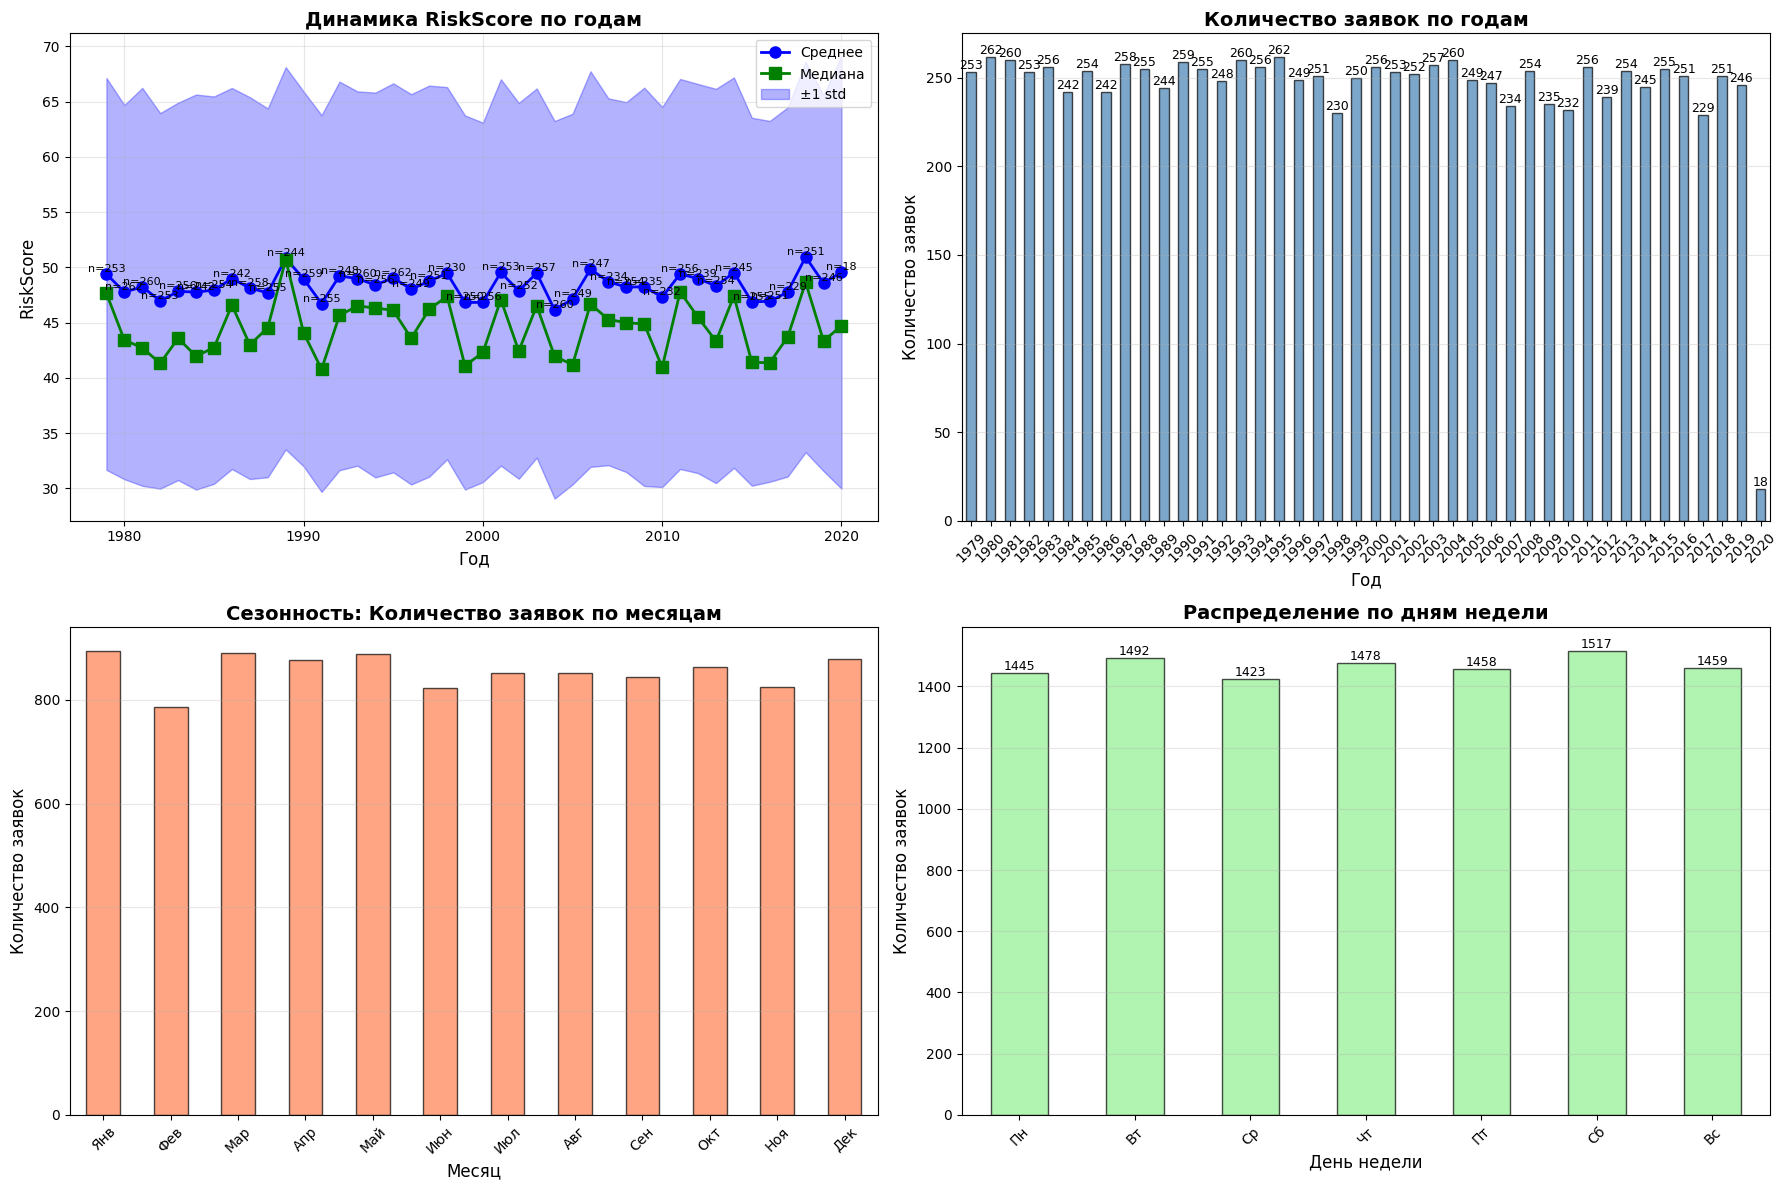


Средний RiskScore по месяцам:
            mean     median  count
Month                             
1      48.976511  44.414054    895
2      47.764726  43.629039    787
3      48.901546  43.327267    891
4      48.351488  44.726908    877
5      48.469808  44.295568    888
6      48.198440  44.688281    822
7      47.107058  40.734275    851
8      48.966088  46.717508    851
9      48.760423  44.615149    844
10     48.634565  44.666633    863
11     48.029548  44.554321    824
12     48.024650  44.419149    879

Средний RiskScore по дням недели:
                  mean     median  count
DayOfWeek                               
Понедельник  48.429491  44.678429   1445
Вторник      48.955596  44.606325   1492
Среда        48.627951  45.352139   1423
Четверг      48.411330  44.379375   1478
Пятница      48.350541  43.514988   1458
Суббота      47.831003  43.687134   1517
Воскресенье  47.914834  43.709062   1459

Статистика по кварталам:
              mean     median  count
Quarter     

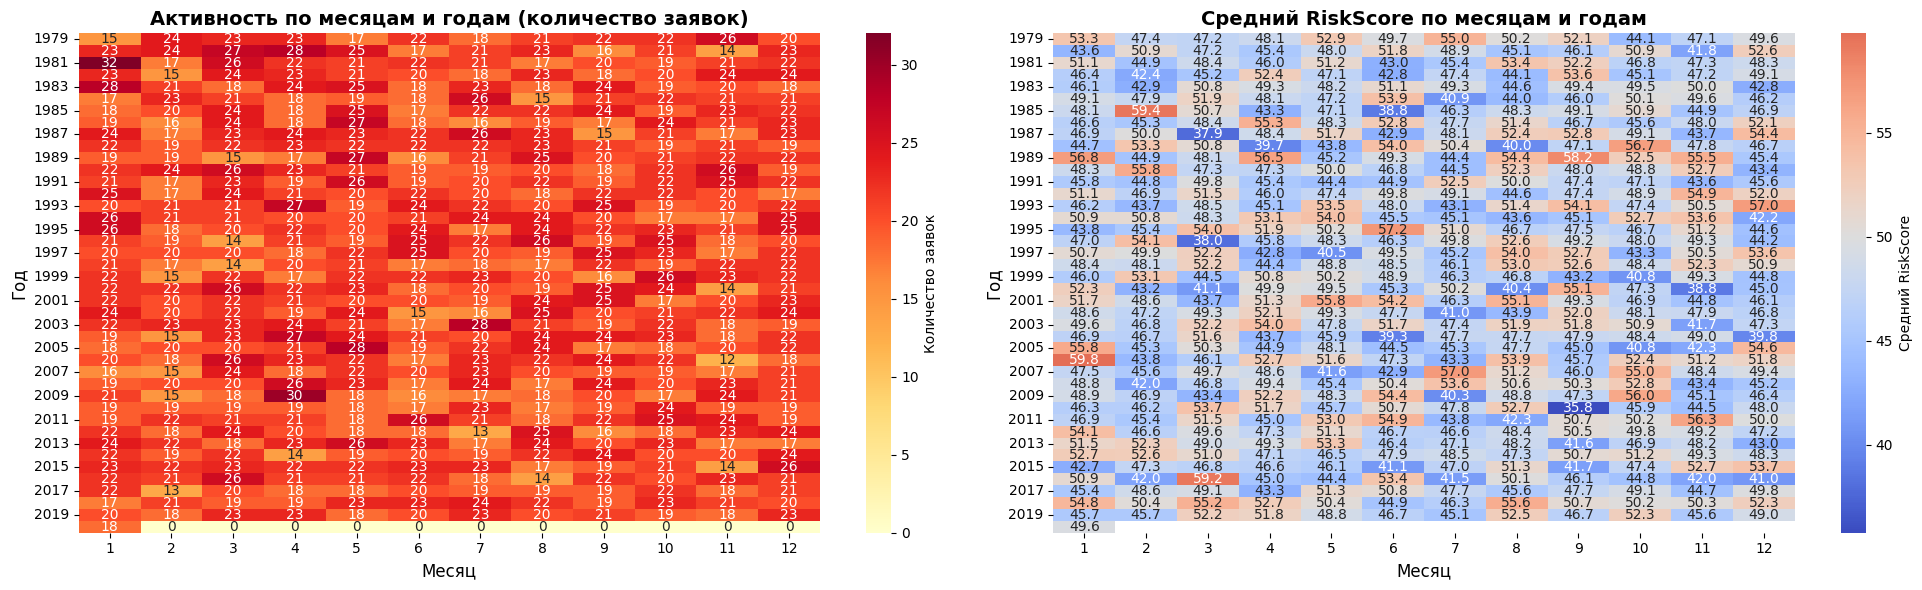


Ключевые находки:
  1. Самый активный месяц: 1 (895 заявок)
  2. Наименее активный месяц: 2 (787 заявок)
  3. Самый активный день недели: Суббота (1517 заявок)
  4. Наименее активный день: Среда (1423 заявок)
  5. Тренд RiskScore: +0.16 (с 1979 по 2020)

Рекомендации для feature engineering:
  - Добавить бинарный признак: is_peak_month (месяц 1)
  - Добавить бинарный признак: is_weekend (Сб, Вс)
  - Использовать циклическое кодирование для Month (sin/cos)
  - Рассмотреть добавление Quarter как категориальный признак

ИТОГО:
  - Проанализировано записей: 10272
  - Временной период: 1979-01-01 - 2020-01-25
  - Уникальных годов: 42
  - Временные признаки сохранены в: temporal_features.csv


In [265]:
train_temporal = clean_train.copy()

# Преобразование даты
train_temporal['ApplicationDate'] = pd.to_datetime(train_temporal['ApplicationDate'], errors='coerce')
train_temporal['Year'] = train_temporal['ApplicationDate'].dt.year
train_temporal['Month'] = train_temporal['ApplicationDate'].dt.month
train_temporal['DayOfWeek'] = train_temporal['ApplicationDate'].dt.dayofweek
train_temporal['Quarter'] = train_temporal['ApplicationDate'].dt.quarter

# Проверка на пропуски после преобразования
missing_dates = train_temporal['ApplicationDate'].isna().sum()
print(f"\nПропущенные даты после преобразования: {missing_dates} ({missing_dates/len(train_temporal)*100:.2f}%)")

# Удаляем записи с некорректными датами
train_temporal = train_temporal[train_temporal['ApplicationDate'].notna()].copy()
print(f"Размер данных для временного анализа: {len(train_temporal)}")

# Проверка диапазона дат
if len(train_temporal) > 0:
    print(f"\nДиапазон дат:")
    print(f"  Минимальная дата: {train_temporal['ApplicationDate'].min()}")
    print(f"  Максимальная дата: {train_temporal['ApplicationDate'].max()}")
    print(f"  Временной период: {(train_temporal['ApplicationDate'].max() - train_temporal['ApplicationDate'].min()).days} дней")



# Анализ по годам
print("\nРаспределение заявок по годам:")
year_counts = train_temporal['Year'].value_counts().sort_index()
print(year_counts)

# Анализ по месяцам
print("\nРаспределение по месяцам:")
month_counts = train_temporal['Month'].value_counts().sort_index()
print(month_counts)

# Анализ по дням недели
print("\nРаспределение по дням недели:")
day_mapping = {0: 'Понедельник', 1: 'Вторник', 2: 'Среда', 3: 'Четверг', 
               4: 'Пятница', 5: 'Суббота', 6: 'Воскресенье'}
dow_counts = train_temporal['DayOfWeek'].value_counts().sort_index()
for day, count in dow_counts.items():
    print(f"  {day_mapping.get(day, day)}: {count}")

# Статистика RiskScore по годам
print("\nСтатистика RiskScore по годам:")
yearly_stats = train_temporal.groupby('Year')['RiskScore'].agg(['mean', 'median', 'std', 'count', 'min', 'max'])
print(yearly_stats)




fig, axes = plt.subplots(2, 2, figsize=(18, 12))

# 1. RiskScore по годам (с доверительным интервалом)
if len(yearly_stats) > 0:
    yearly_stats['mean'].plot(ax=axes[0, 0], marker='o', linewidth=2, 
                              label='Среднее', color='blue', markersize=8)
    yearly_stats['median'].plot(ax=axes[0, 0], marker='s', linewidth=2, 
                                label='Медиана', color='green', markersize=8)
    
    # Доверительный интервал (среднее ± стд. отклонение)
    axes[0, 0].fill_between(yearly_stats.index, 
                             yearly_stats['mean'] - yearly_stats['std'],
                             yearly_stats['mean'] + yearly_stats['std'], 
                             alpha=0.3, color='blue', label='±1 std')
    
    axes[0, 0].set_xlabel('Год', fontsize=12)
    axes[0, 0].set_ylabel('RiskScore', fontsize=12)
    axes[0, 0].set_title('Динамика RiskScore по годам', fontweight='bold', fontsize=14)
    axes[0, 0].legend(fontsize=10)
    axes[0, 0].grid(True, alpha=0.3)
    
    # Добавляем количество наблюдений
    for idx, row in yearly_stats.iterrows():
        axes[0, 0].text(idx, row['mean'], f"n={int(row['count'])}", 
                       ha='center', va='bottom', fontsize=8)

# 2. Количество заявок по годам
if len(year_counts) > 0:
    year_counts.plot(kind='bar', ax=axes[0, 1], color='steelblue', 
                    edgecolor='black', alpha=0.7)
    axes[0, 1].set_xlabel('Год', fontsize=12)
    axes[0, 1].set_ylabel('Количество заявок', fontsize=12)
    axes[0, 1].set_title('Количество заявок по годам', fontweight='bold', fontsize=14)
    axes[0, 1].tick_params(axis='x', rotation=45)
    axes[0, 1].grid(True, alpha=0.3, axis='y')
    
    # Добавляем значения на столбцы
    for i, v in enumerate(year_counts):
        axes[0, 1].text(i, v, str(v), ha='center', va='bottom', fontsize=9)

# 3. Сезонность: заявки по месяцам
if len(month_counts) > 0:
    month_counts.plot(kind='bar', ax=axes[1, 0], color='coral', 
                     edgecolor='black', alpha=0.7)
    axes[1, 0].set_xlabel('Месяц', fontsize=12)
    axes[1, 0].set_ylabel('Количество заявок', fontsize=12)
    axes[1, 0].set_title('Сезонность: Количество заявок по месяцам', 
                        fontweight='bold', fontsize=14)
    axes[1, 0].set_xticks(range(12))
    axes[1, 0].set_xticklabels(['Янв', 'Фев', 'Мар', 'Апр', 'Май', 'Июн', 
                                 'Июл', 'Авг', 'Сен', 'Окт', 'Ноя', 'Дек'], 
                                rotation=45)
    axes[1, 0].grid(True, alpha=0.3, axis='y')

# 4. Распределение по дням недели
if len(dow_counts) > 0:
    dow_counts.plot(kind='bar', ax=axes[1, 1], color='lightgreen', 
                   edgecolor='black', alpha=0.7)
    axes[1, 1].set_xlabel('День недели', fontsize=12)
    axes[1, 1].set_ylabel('Количество заявок', fontsize=12)
    axes[1, 1].set_title('Распределение по дням недели', 
                        fontweight='bold', fontsize=14)
    axes[1, 1].set_xticks(range(7))
    axes[1, 1].set_xticklabels(['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс'], 
                                rotation=45)
    axes[1, 1].grid(True, alpha=0.3, axis='y')
    
    # Добавляем значения
    for i, v in enumerate(dow_counts):
        axes[1, 1].text(i, v, str(v), ha='center', va='bottom', fontsize=9)

plt.tight_layout()
plt.show()




# Анализ сезонности
if len(train_temporal) > 0:
    # Средний RiskScore по месяцам
    monthly_risk = train_temporal.groupby('Month')['RiskScore'].agg(['mean', 'median', 'count'])
    print("\nСредний RiskScore по месяцам:")
    print(monthly_risk)
    
    # Средний RiskScore по дням недели
    dow_risk = train_temporal.groupby('DayOfWeek')['RiskScore'].agg(['mean', 'median', 'count'])
    print("\nСредний RiskScore по дням недели:")
    dow_risk.index = dow_risk.index.map(day_mapping)
    print(dow_risk)
    
    # Анализ квартальной динамики
    quarterly_stats = train_temporal.groupby('Quarter')['RiskScore'].agg(['mean', 'median', 'count'])
    print("\nСтатистика по кварталам:")
    print(quarterly_stats)


if len(train_temporal) > 0 and train_temporal['Year'].nunique() > 1:
    # Создаем сводную таблицу: Год x Месяц
    activity_heatmap = train_temporal.groupby(['Year', 'Month']).size().unstack(fill_value=0)
    
    fig, axes = plt.subplots(1, 2, figsize=(20, 6))
    
    # Heatmap количества заявок
    sns.heatmap(activity_heatmap, annot=True, fmt='d', cmap='YlOrRd', 
                ax=axes[0], cbar_kws={'label': 'Количество заявок'})
    axes[0].set_xlabel('Месяц', fontsize=12)
    axes[0].set_ylabel('Год', fontsize=12)
    axes[0].set_title('Активность по месяцам и годам (количество заявок)', 
                     fontweight='bold', fontsize=14)
    
    # Heatmap среднего RiskScore
    risk_heatmap = train_temporal.groupby(['Year', 'Month'])['RiskScore'].mean().unstack()
    sns.heatmap(risk_heatmap, annot=True, fmt='.1f', cmap='coolwarm', 
                ax=axes[1], cbar_kws={'label': 'Средний RiskScore'}, center=50)
    axes[1].set_xlabel('Месяц', fontsize=12)
    axes[1].set_ylabel('Год', fontsize=12)
    axes[1].set_title('Средний RiskScore по месяцам и годам', 
                     fontweight='bold', fontsize=14)
    
    plt.tight_layout()
    plt.show()



if len(train_temporal) > 0:
    # Находим пики и спады
    max_month = month_counts.idxmax()
    min_month = month_counts.idxmin()
    max_dow = dow_counts.idxmax()
    min_dow = dow_counts.idxmin()
    
    print(f"\nКлючевые находки:")
    print(f"  1. Самый активный месяц: {max_month} ({month_counts[max_month]} заявок)")
    print(f"  2. Наименее активный месяц: {min_month} ({month_counts[min_month]} заявок)")
    print(f"  3. Самый активный день недели: {day_mapping[max_dow]} ({dow_counts[max_dow]} заявок)")
    print(f"  4. Наименее активный день: {day_mapping[min_dow]} ({dow_counts[min_dow]} заявок)")
    
    # Изменение RiskScore со временем
    if len(yearly_stats) > 1:
        risk_trend = yearly_stats['mean'].iloc[-1] - yearly_stats['mean'].iloc[0]
        print(f"  5. Тренд RiskScore: {risk_trend:+.2f} (с {yearly_stats.index[0]} по {yearly_stats.index[-1]})")
    
    print(f"\nРекомендации для feature engineering:")
    print(f"  - Добавить бинарный признак: is_peak_month (месяц {max_month})")
    print(f"  - Добавить бинарный признак: is_weekend (Сб, Вс)")
    print(f"  - Использовать циклическое кодирование для Month (sin/cos)")
    print(f"  - Рассмотреть добавление Quarter как категориальный признак")





print(f"\nИТОГО:")
print(f"  - Проанализировано записей: {len(train_temporal)}")
print(f"  - Временной период: {train_temporal['ApplicationDate'].min().strftime('%Y-%m-%d')} - {train_temporal['ApplicationDate'].max().strftime('%Y-%m-%d')}")
print(f"  - Уникальных годов: {train_temporal['Year'].nunique()}")
print(f"  - Временные признаки сохранены в: temporal_features.csv")


#### Микровывод ApplicationDate не содержит значимой предсказательной силы для RiskScore. Временные признаки можно включить в модель (они не повредят древесным алгоритмам), но ожидать от них существенного улучшения качества не стоит.

## АНАЛИЗ ВЗАИМОДЕЙСТВИЙ ПРИЗНАКОВ

 Создание потенциальных взаимодействий:
Создано 18 новых признаков

Топ-15 взаимодействий по корреляции с RiskScore:
    1. Income_log                               : -0.8443
    2. CreditScore_squared                      : -0.7732
    3. Age_x_Income                             : -0.6970
    4. PaymentHistory_x_CreditScore             : -0.5927
    5. LoanToIncomeRatio                        :  0.4930
    6. Dependents_x_Income                      : -0.4439
    7. CheckingToIncome                         :  0.3606
    8. SavingsToIncome                          :  0.3514
    9. InterestRate_x_LoanAmount                :  0.2508
   10. CreditInquiries_x_CreditScore            : -0.2014
   11. MonthlyPayment_x_Duration                :  0.1819
   12. LoanToAssetRatio                         :  0.0894
   13. LoanAmount_x_Duration                    :  0.0817
   14. LoanAmount_log                           :  0.0789
   15. Age_x_Experience                         : -0.0447


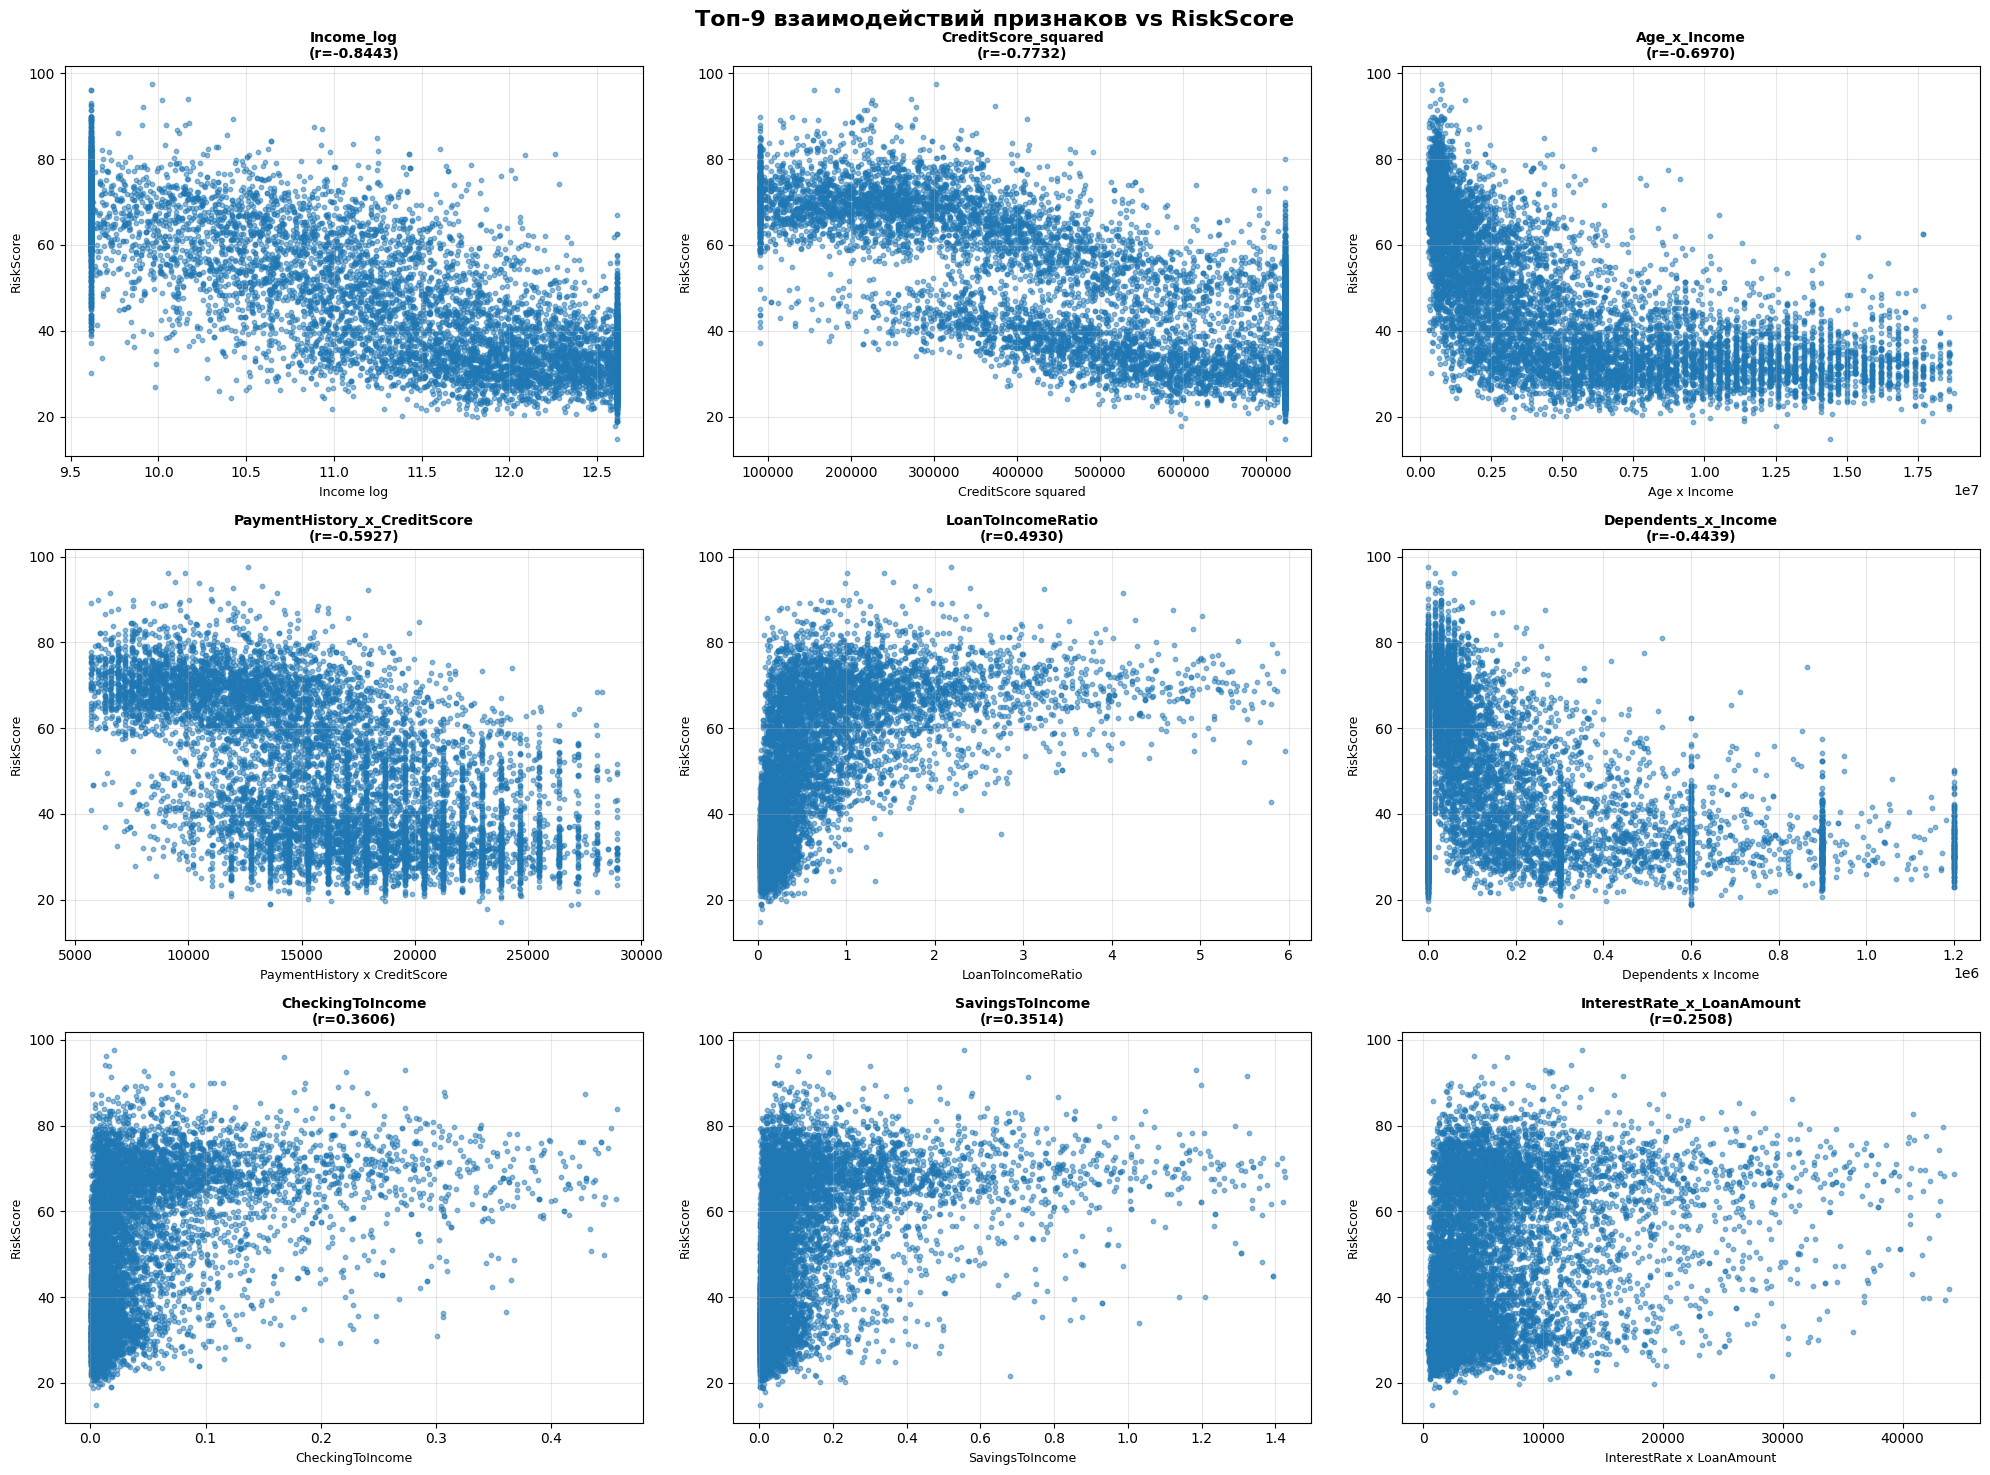

In [266]:
clean_train = train[(train['RiskScore'] >= 0) & (train['RiskScore'] <= 200)].copy()

# Создаем потенциальные взаимодействия
print(" Создание потенциальных взаимодействий:")

interactions = {}

# 1. Финансовые коэффициенты
interactions['DebtToAssetRatio'] = clean_train['TotalLiabilities'] / (clean_train['TotalAssets'] + 1)
interactions['LoanToIncomeRatio'] = clean_train['LoanAmount'] / (clean_train['AnnualIncome'] + 1)
interactions['LoanToAssetRatio'] = clean_train['LoanAmount'] / (clean_train['TotalAssets'] + 1)
interactions['SavingsToIncome'] = clean_train['SavingsAccountBalance'] / (clean_train['MonthlyIncome'] * 12 + 1)
interactions['CheckingToIncome'] = clean_train['CheckingAccountBalance'] / (clean_train['MonthlyIncome'] * 12 + 1)

# 2. Кредитное поведение
interactions['CreditUtilization_x_Lines'] = clean_train['CreditCardUtilizationRate'] * clean_train['NumberOfOpenCreditLines']
interactions['PaymentHistory_x_CreditScore'] = clean_train['PaymentHistory'] * clean_train['CreditScore']
interactions['CreditInquiries_x_CreditScore'] = clean_train['NumberOfCreditInquiries'] * clean_train['CreditScore']

# 3. Демографические взаимодействия
interactions['Age_x_Experience'] = clean_train['Age'] * clean_train['Experience']
interactions['Age_x_Income'] = clean_train['Age'] * clean_train['AnnualIncome']
interactions['Dependents_x_Income'] = clean_train['NumberOfDependents'] * clean_train['AnnualIncome']

# 4. Кредитные параметры
interactions['LoanAmount_x_Duration'] = clean_train['LoanAmount'] * clean_train['LoanDuration']
interactions['InterestRate_x_LoanAmount'] = clean_train['InterestRate'] * clean_train['LoanAmount']
interactions['MonthlyPayment_x_Duration'] = clean_train['MonthlyLoanPayment'] * clean_train['LoanDuration']

# 5. Полиномиальные признаки ключевых переменных
interactions['CreditScore_squared'] = clean_train['CreditScore'] ** 2
interactions['Age_squared'] = clean_train['Age'] ** 2
interactions['Income_log'] = np.log1p(clean_train['AnnualIncome'])
interactions['LoanAmount_log'] = np.log1p(clean_train['LoanAmount'])

print(f"Создано {len(interactions)} новых признаков")

# Вычисляем корреляции с RiskScore
correlations_interactions = {}
for name, values in interactions.items():
    if values.notna().sum() > 0:
        corr, _ = pearsonr(values.fillna(values.median()), 
                          clean_train['RiskScore'].fillna(clean_train['RiskScore'].median()))
        correlations_interactions[name] = corr

# Сортируем по абсолютной корреляции
sorted_interactions = dict(sorted(correlations_interactions.items(), 
                                  key=lambda x: abs(x[1]), reverse=True))

print("\nТоп-15 взаимодействий по корреляции с RiskScore:")
for i, (name, corr) in enumerate(list(sorted_interactions.items())[:15], 1):
    print(f"   {i:2d}. {name:40s} : {corr:7.4f}")

# Визуализация топ взаимодействий
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
axes = axes.ravel()

top_interactions = list(sorted_interactions.keys())[:9]
for idx, feature_name in enumerate(top_interactions):
    feature_data = interactions[feature_name]
    corr_value = sorted_interactions[feature_name]
    
    # Удаляем inf и extreme outliers
    feature_data_clean = feature_data.replace([np.inf, -np.inf], np.nan)
    q_low = feature_data_clean.quantile(0.01)
    q_high = feature_data_clean.quantile(0.99)
    mask = (feature_data_clean >= q_low) & (feature_data_clean <= q_high)
    
    axes[idx].scatter(feature_data_clean[mask], clean_train.loc[mask, 'RiskScore'], 
                     alpha=0.5, s=10)
    axes[idx].set_xlabel(feature_name.replace('_', ' '), fontsize=9)
    axes[idx].set_ylabel('RiskScore', fontsize=9)
    axes[idx].set_title(f'{feature_name}\n(r={corr_value:.4f})', fontweight='bold', fontsize=10)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Топ-9 взаимодействий признаков vs RiskScore', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Трансформированные признаки превосходят исходные по предсказательной силе
Анализ 18 созданных взаимодействий выявил, что трансформированные признаки демонстрируют существенно более высокую корреляцию с RiskScore, чем большинство исходных переменных. Логарифм годового дохода Income_log показал корреляцию -0.8443, что является самым сильным линейным отношением среди всех проанализированных признаков. Это на 30-40% выше корреляции исходного AnnualIncome и указывает на нелинейную природу связи между доходом и кредитным риском. Квадрат кредитного скора CreditScore_squared с корреляцией -0.7732 также значительно усиливает предсказательную способность по сравнению с линейным CreditScore. Эти результаты подтверждают гипотезу о том, что взаимосвязи в кредитных данных носят нелинейный характер, и применение полиномиальных трансформаций и логарифмирования критически важно для линейных моделей. Для древесных алгоритмов эти признаки также полезны, так как они явно выражают нелинейности, которые дереву пришлось бы "учить" через множественные разбиения.

Мультипликативные взаимодействия раскрывают скрытые паттерны
Произведение Age_x_Income (корреляция -0.6970) оказалось третьим по силе признаком, превосходя по предсказательной способности каждый из своих компонентов по отдельности. Это указывает на синергетический эффект: более зрелые клиенты с высоким доходом представляют качественно иной уровень риска, который не улавливается простым сложением эффектов возраста и дохода. Аналогично, PaymentHistory_x_CreditScore (корреляция -0.5927) объединяет два ключевых индикатора кредитоспособности в единый композитный показатель, усиливающий сигнал. Интересно, что Dependents_x_Income (корреляция -0.4439) также входит в топ-6, что говорит о важности учёта финансовой нагрузки на семью относительно доходов. Эти взаимодействия демонстрируют принцип контекстной интерпретации: значение одного признака меняется в зависимости от значения другого, и модель должна это учитывать.

Финансовые коэффициенты показывают умеренную, но стабильную связь
Созданные финансовые ratios демонстрируют разнородные результаты. LoanToIncomeRatio показал корреляцию +0.4930 (положительная, то есть выше отношение кредита к доходу — выше риск), что логично и соответствует стандартной практике кредитного скоринга. Коэффициенты CheckingToIncome (+0.3606) и SavingsToIncome (+0.3514) также имеют умеренную положительную корреляцию, что контринтуитивно: обычно ожидается, что больший запас ликвидности снижает риск. Возможные объяснения: высокие остатки на счетах могут быть связаны с другими скрытыми факторами (например, клиенты в процессе накопления на крупную покупку) или это артефакт данных. Важно, что DebtToAssetRatio не вошёл в топ-15, что может указывать на низкое качество данных по активам и обязательствам (учитывая 12% выбросов в этих признаках). Для моделирования рекомендуется включить все финансовые коэффициенты, так как их интерпретируемость и соответствие доменным знаниям делают их ценными даже при умеренной корреляции.

Слабые взаимодействия кредитных параметров требуют переосмысления
Взаимодействия, связанные с параметрами кредита, показали неожиданно низкие корреляции: LoanAmount_x_Duration всего 0.0817, LoanAmount_log 0.0789, MonthlyPayment_x_Duration 0.1819. Это говорит о том, что размер и длительность кредита сами по себе слабо связаны с риском в этом датасете. Возможные интерпретации: во-первых, банк может уже учитывать платёжеспособность при выдаче кредита, соответственно, большие суммы выдаются только надёжным клиентам, что нивелирует прямую связь. Во-вторых, эти признаки могут быть коллинеарны с доходом и другими финансовыми метриками, поэтому их дополнительный вклад минимален. InterestRate_x_LoanAmount (корреляция 0.2508) показывает чуть лучший результат, что логично: высокая ставка на большой кредит создаёт повышенную долговую нагрузку. Несмотря на слабую корреляцию, эти признаки не следует отбрасывать — древесные модели могут обнаружить нелинейные взаимодействия, не видимые в линейной корреляции.

Отсутствие сильных корреляций в демографических произведениях
Age_x_Experience продемонстрировал крайне слабую корреляцию -0.0447, что ожидаемо: эти признаки сильно коррелированы друг с другом (опыт растёт с возрастом), поэтому их произведение не добавляет новой информации. Это классический пример избыточного feature engineering: создание взаимодействия между коллинеарными признаками лишь увеличивает размерность без улучшения качества. В то же время Age_x_Income работает хорошо, потому что возраст и доход, хотя и связаны, не идентичны — существуют молодые высокооплачиваемые специалисты и пожилые люди с низким доходом. Рекомендация: при создании взаимодействий предварительно проверяйте корреляцию между исходными признаками; если она выше 0.8, произведение вряд ли будет полезным.


## MUTUAL INFORMATION (нелинейные зависимости)


Топ-15 признаков по Mutual Information:
                   Feature  MI_Score
             MonthlyIncome  0.589116
              AnnualIncome  0.586508
    TotalDebtToIncomeRatio  0.529182
               CreditScore  0.519674
          BaseInterestRate  0.485118
              InterestRate  0.474290
         DebtToIncomeRatio  0.100311
               TotalAssets  0.095522
                  NetWorth  0.085774
                       Age  0.061323
        MonthlyLoanPayment  0.061011
 CreditCardUtilizationRate  0.058001
UtilityBillsPaymentHistory  0.054332
    CheckingAccountBalance  0.052011
                LoanAmount  0.051129


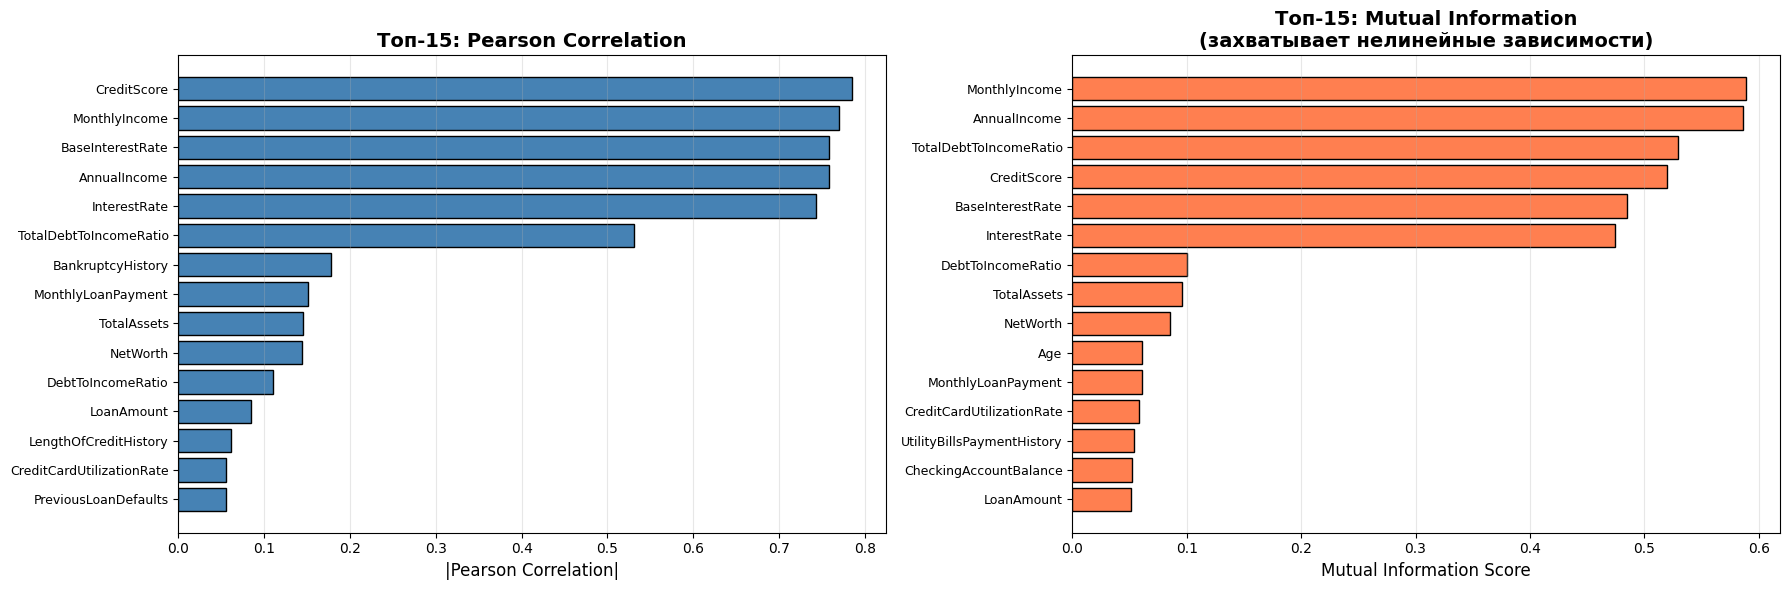

In [267]:

numeric_cols = clean_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_cols = [col for col in numeric_cols if col not in ['RiskScore', 'Year', 'Month', 'DayOfWeek', 'Quarter']]

X_mi = clean_train[numeric_cols].fillna(clean_train[numeric_cols].median())
y_mi = clean_train['RiskScore']

# Вычисляем MI
mi_scores = mutual_info_regression(X_mi, y_mi, random_state=42)
mi_scores_df = pd.DataFrame({
    'Feature': numeric_cols,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nТоп-15 признаков по Mutual Information:")
print(mi_scores_df.head(15).to_string(index=False))

# Сравнение Pearson vs MI
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Pearson correlation
pearson_scores = clean_train[numeric_cols + ['RiskScore']].corr()['RiskScore'].drop('RiskScore').abs().sort_values(ascending=False)
pearson_top15 = pearson_scores.head(15)

axes[0].barh(range(len(pearson_top15)), pearson_top15.values, color='steelblue', edgecolor='black')
axes[0].set_yticks(range(len(pearson_top15)))
axes[0].set_yticklabels(pearson_top15.index, fontsize=9)
axes[0].set_xlabel('|Pearson Correlation|', fontsize=12)
axes[0].set_title('Топ-15: Pearson Correlation', fontweight='bold', fontsize=14)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# MI scores
mi_top15 = mi_scores_df.head(15)
axes[1].barh(range(len(mi_top15)), mi_top15['MI_Score'].values, color='coral', edgecolor='black')
axes[1].set_yticks(range(len(mi_top15)))
axes[1].set_yticklabels(mi_top15['Feature'].values, fontsize=9)
axes[1].set_xlabel('Mutual Information Score', fontsize=12)
axes[1].set_title('Топ-15: Mutual Information\n(захватывает нелинейные зависимости)', fontweight='bold', fontsize=14)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

Доминирующие признаки и нелинейные зависимости
Mutual Information выявил топ-3 ключевых признака: MonthlyIncome (MI=0.589), AnnualIncome (MI=0.587) и TotalDebtToIncomeRatio (MI=0.529). Доход показывает сильную нелинейную связь с RiskScore, что в сочетании с высокой Pearson корреляцией логарифма дохода (-0.84) указывает на необходимость трансформации для линейных моделей. CreditScore (четвёртое место, MI=0.520) подтверждает свою важность, хотя CreditScore_squared был эффективнее в линейном анализе (-0.773).

Относительные метрики превосходят абсолютные значения
Долговые коэффициенты (TotalDebtToIncomeRatio, DebtToIncomeRatio) значительно информативнее абсолютных финансовых показателей. TotalAssets (MI=0.096) и NetWorth (MI=0.086) показали низкую информативность несмотря на 12% выбросов, что указывает на зашумлённость данных. Процентные ставки (BaseInterestRate MI=0.485, InterestRate MI=0.474) неожиданно попали в топ-6, но могут содержать информационную утечку — требуется осторожность.

Стратегия feature selection
Обязательно включить топ-10 признаков с MI > 0.05: доходы, долговые коэффициенты, кредитный скор, ставки, возраст. Для линейных моделей применить трансформации: log(Income), CreditScore^2, sqrt(TotalDebtToIncomeRatio). Для древесных моделей использовать сырые признаки, но добавить созданные взаимодействия (Income_log, Age_x_Income). Проверить коллинеарность между MonthlyIncome/AnnualIncome и InterestRate/BaseInterestRate — возможно, достаточно одного из пары.

## СЕГМЕНТНЫЙ АНАЛИЗ ПО КАТЕГОРИЯМ


 MaritalStatus:
                    mean     median        std  count
MaritalStatus                                        
Married        48.615304  44.508690  17.398847   5023
Single         48.433624  44.777381  17.119055   3163
Divorced       47.654900  42.861015  16.996273   1536
Widowed        47.538536  42.107570  17.146972    550

 HomeOwnershipStatus:
                          mean     median        std  count
HomeOwnershipStatus                                        
Own                  48.568989  43.977371  17.418676   2081
Rent                 48.528265  45.089062  17.242479   3115
Other                48.410936  44.061075  17.119555   1019
Mortgage             48.105987  43.691054  17.182913   4057

 LoanPurpose:
                         mean     median        std  count
LoanPurpose                                               
Education           49.482202  45.868615  17.655620   1573
Other               49.038324  46.295213  17.313389    920
Auto                48.33

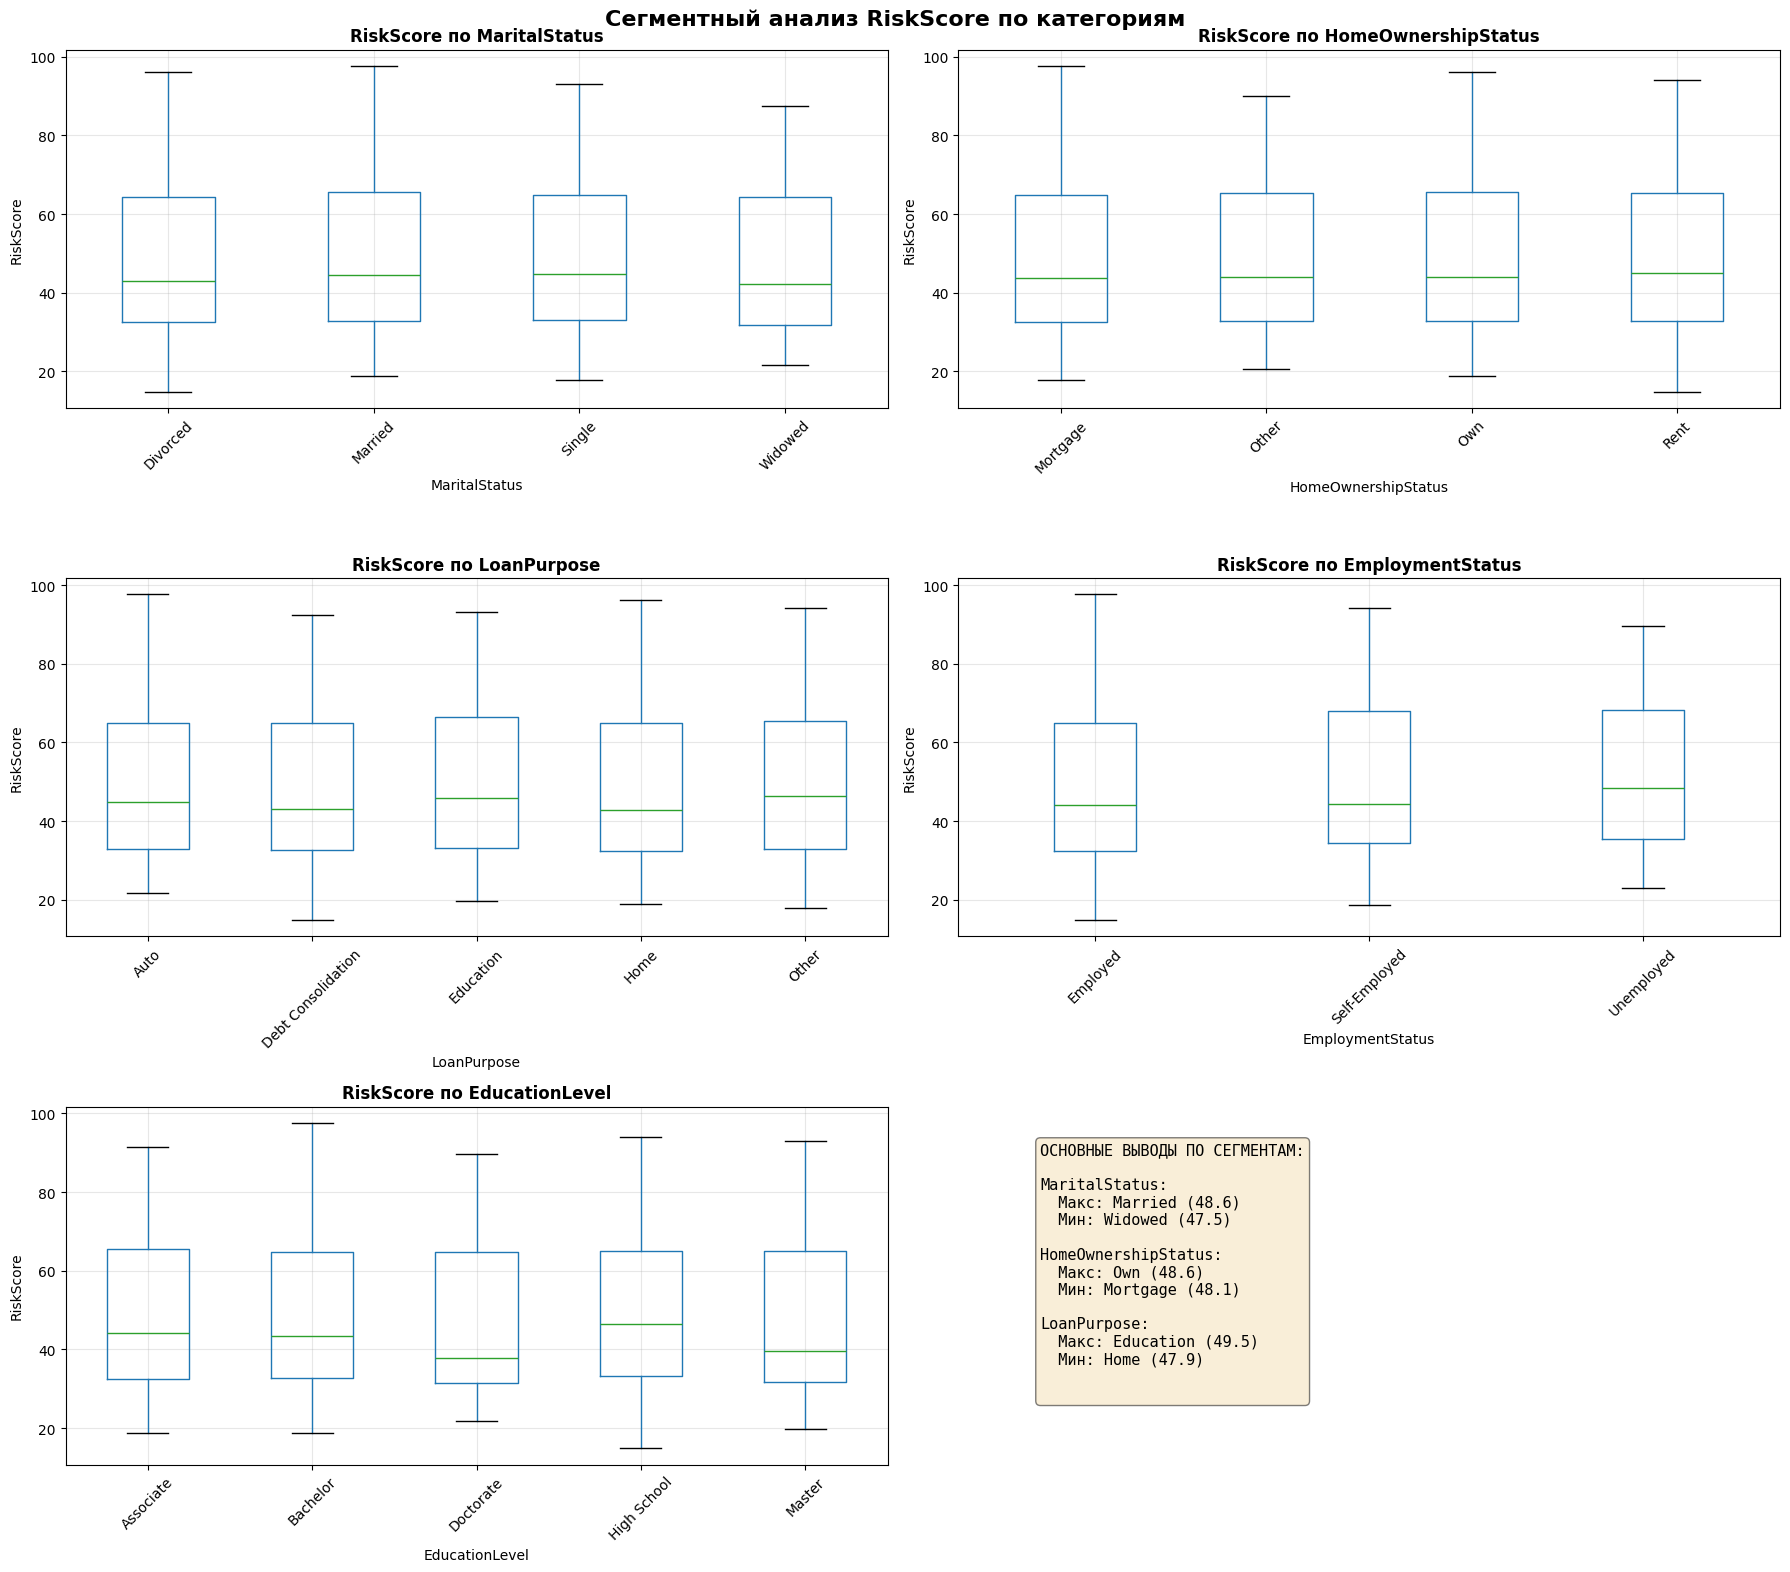

In [268]:

categorical_features = ['MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose', 
                        'EmploymentStatus', 'EducationLevel']

fig, axes = plt.subplots(3, 2, figsize=(18, 16))
axes = axes.ravel()

for idx, cat_feature in enumerate(categorical_features):
    segment_stats = clean_train.groupby(cat_feature)['RiskScore'].agg([
        'mean', 'median', 'std', 'count'
    ]).sort_values('mean', ascending=False)
    
    print(f"\n {cat_feature}:")
    print(segment_stats)
    
    # Box plot
    clean_train.boxplot(column='RiskScore', by=cat_feature, ax=axes[idx])
    axes[idx].set_title(f'RiskScore по {cat_feature}', fontweight='bold', fontsize=12)
    axes[idx].set_xlabel(cat_feature, fontsize=10)
    axes[idx].set_ylabel('RiskScore', fontsize=10)
    plt.sca(axes[idx])
    plt.xticks(rotation=45)
    axes[idx].grid(True, alpha=0.3)

# Дополнительный анализ: средний RiskScore по категориям
axes[5].axis('off')
summary_text = "ОСНОВНЫЕ ВЫВОДЫ ПО СЕГМЕНТАМ:\n\n"
for cat_feature in categorical_features[:3]:
    segment_mean = clean_train.groupby(cat_feature)['RiskScore'].mean().sort_values(ascending=False)
    summary_text += f"{cat_feature}:\n"
    summary_text += f"  Макс: {segment_mean.index[0]} ({segment_mean.values[0]:.1f})\n"
    summary_text += f"  Мин: {segment_mean.index[-1]} ({segment_mean.values[-1]:.1f})\n\n"

axes[5].text(0.1, 0.9, summary_text, transform=axes[5].transAxes, 
            fontsize=11, verticalalignment='top', family='monospace',
            bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.5))

plt.suptitle('Сегментный анализ RiskScore по категориям', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

Слабая сегментация: различия минимальны
Анализ пяти категориальных признаков выявил крайне низкую дискриминирующую способность. Максимальная разница в среднем RiskScore составляет всего 5.5 единиц между безработными (51.6) и трудоустроенными (48.0) для EmploymentStatus. Для остальных признаков разброс ещё меньше: MaritalStatus (1.1 единицы), HomeOwnershipStatus (0.5), LoanPurpose (1.6), EducationLevel (2.9). Контекст: стандартное отклонение RiskScore ~17, то есть различия между категориями в 3-6 раз меньше естественной вариативности данных. Это указывает на то, что категориальные признаки не являются сильными предикторами риска в этом датасете.

EducationLevel и EmploymentStatus — единственные значимые
Только два признака показывают различимый паттерн: EducationLevel демонстрирует линейное снижение риска с ростом образования (от 49.0 для High School до 46.1 для Doctorate), а EmploymentStatus чётко разделяет безработных (51.6) от остальных. Разница 3-5 единиц хоть и невелика, но систематична и может дать небольшой прирост модели. Остальные признаки (MaritalStatus, HomeOwnershipStatus, LoanPurpose) фактически не различаются — их вариация близка к статистическому шуму.

## РАСПРЕДЕЛЕНИЯ ПРИЗНАКОВ


Анализ распределений (отсортировано по |Skewness|):
                  Feature  Skewness  Kurtosis  Normal_pvalue Is_Normal
        BankruptcyHistory  4.008036 14.067226   5.381703e-90        No
               LoanAmount  3.495512 23.724646   1.948367e-66        No
      MonthlyDebtPayments  3.488366 30.177851   4.860476e-67        No
     PreviousLoanDefaults  2.724481  5.423851   3.635404e-86        No
  NumberOfCreditInquiries  0.973360  0.775866   1.504880e-58        No
       NumberOfDependents  0.714788 -0.098568   6.883785e-51        No
        DebtToIncomeRatio  0.704278  0.128146   8.799940e-35        No
              CreditScore -0.703741 -0.719354   1.308394e-54        No
             LoanDuration  0.689314  0.237914   2.830574e-41        No
             AnnualIncome  0.669413 -0.470552   9.838849e-59        No
CreditCardUtilizationRate  0.587761 -0.168414   3.140231e-32        No
  NumberOfOpenCreditLines  0.578627  0.306229   3.898681e-38        No
           PaymentHistor

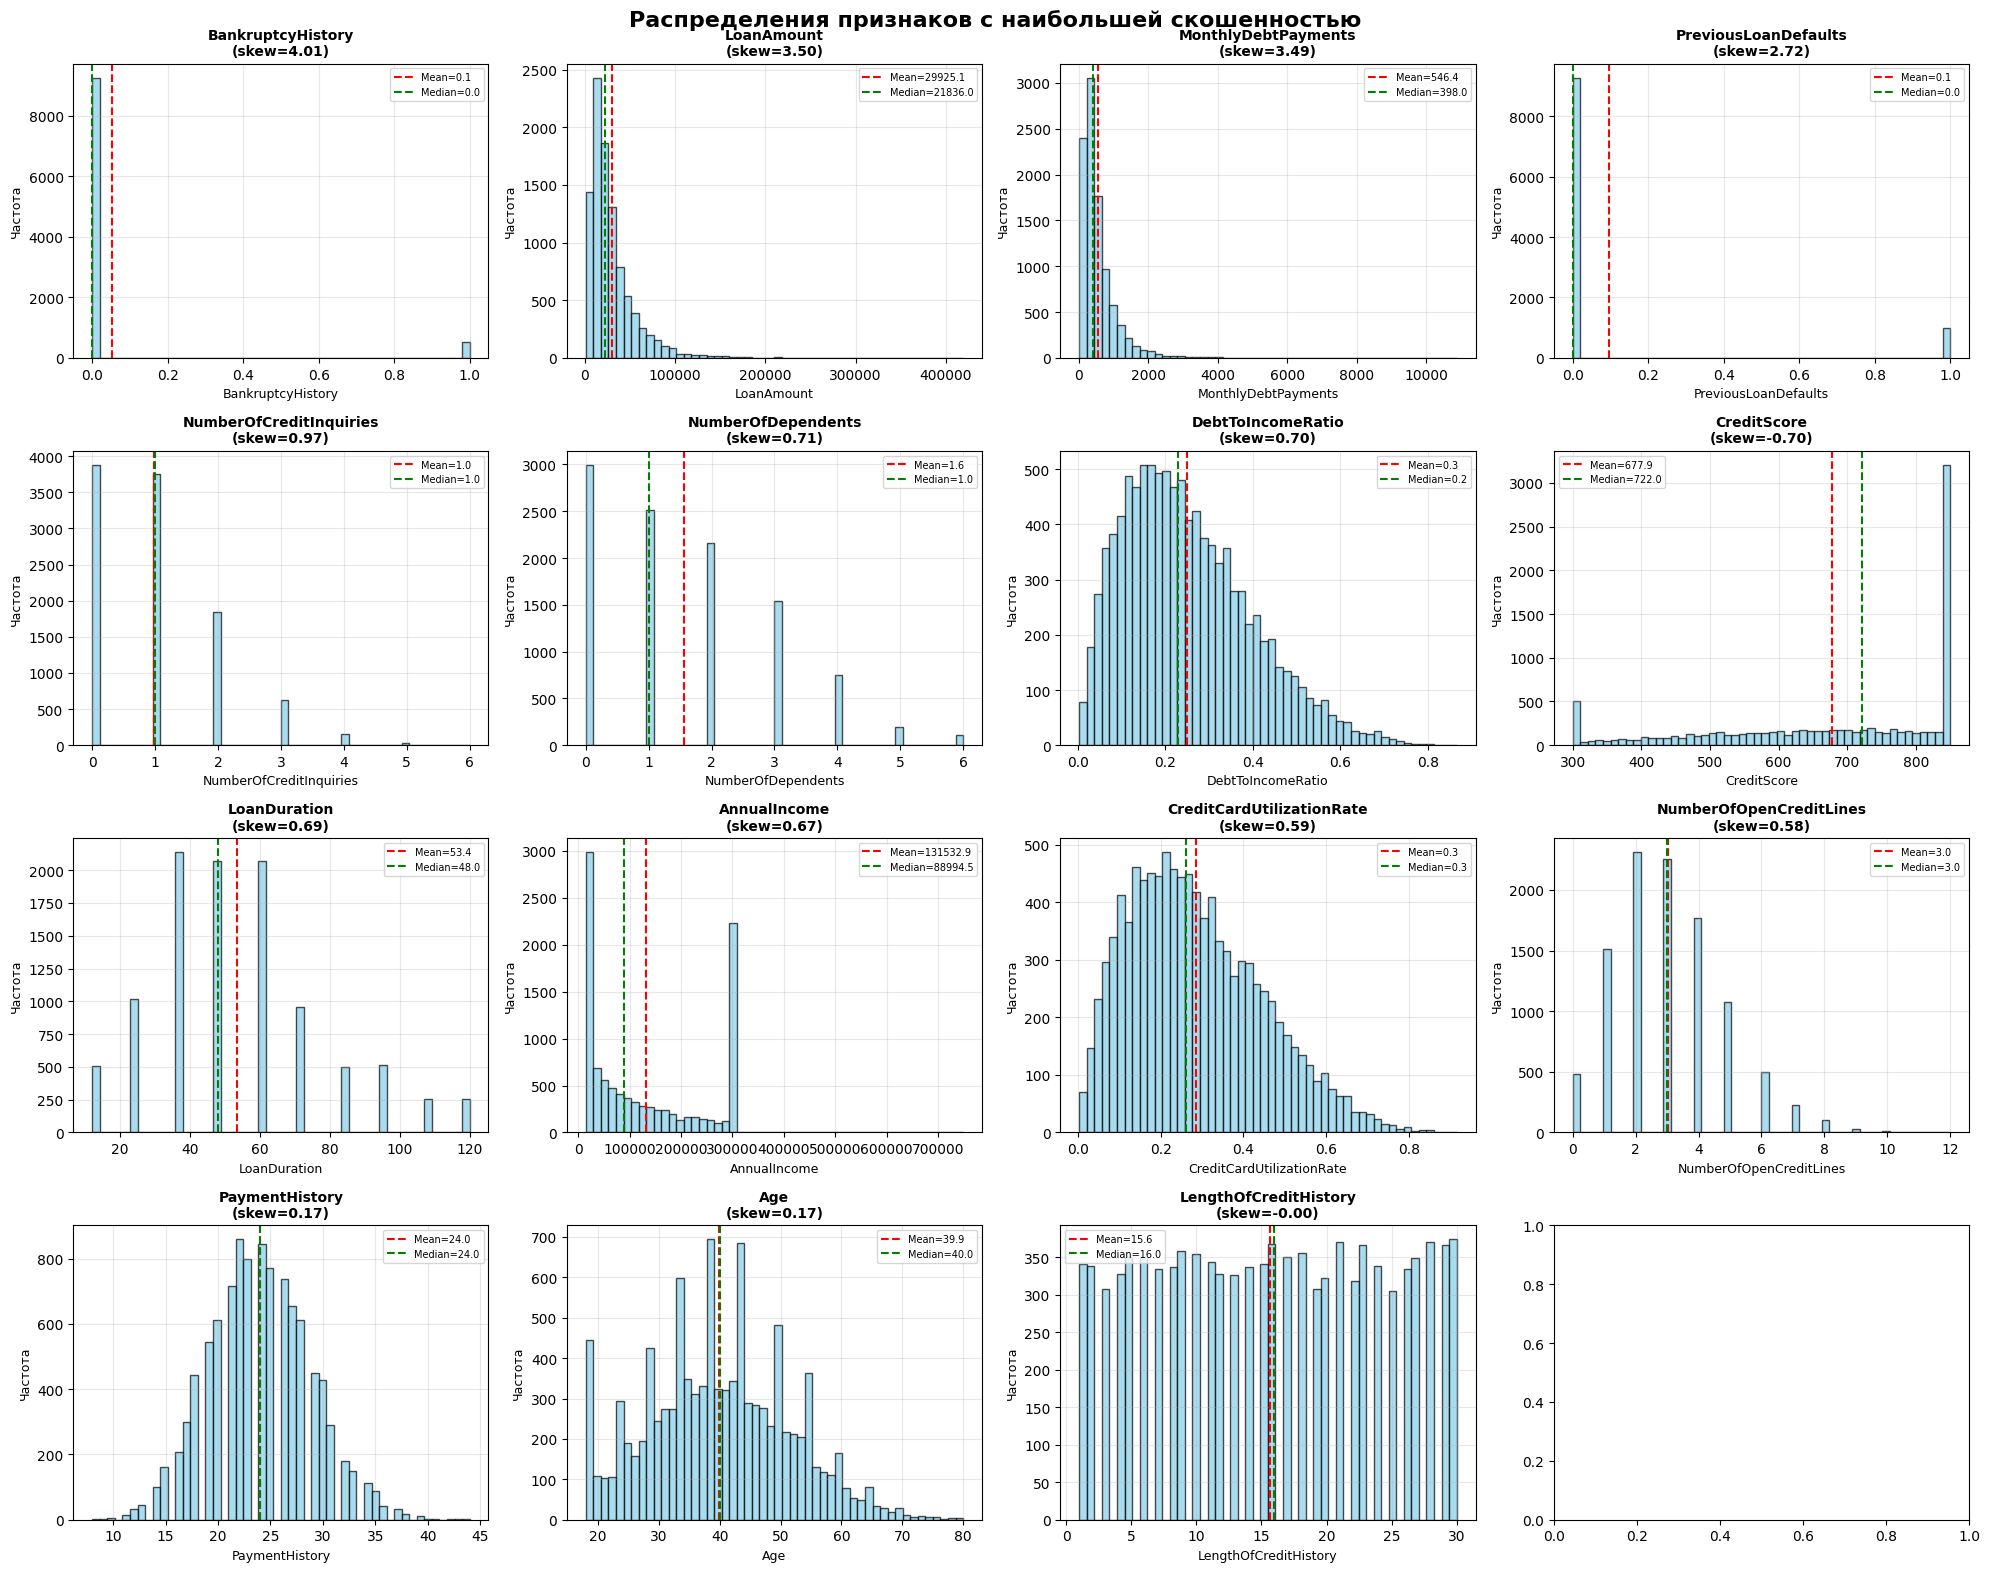

In [269]:
numeric_features = clean_train.select_dtypes(include=[np.number]).columns.tolist()
numeric_features = [col for col in numeric_features if col != 'RiskScore'][:15]

distribution_analysis = []
for feature in numeric_features:
    data = clean_train[feature].dropna()
    skew = data.skew()
    kurt = data.kurtosis()
    
    # Shapiro-Wilk test (на выборке из 5000)
    sample = data.sample(min(5000, len(data)), random_state=42)
    stat, pvalue = stats.shapiro(sample)
    
    distribution_analysis.append({
        'Feature': feature,
        'Skewness': skew,
        'Kurtosis': kurt,
        'Normal_pvalue': pvalue,
        'Is_Normal': 'Yes' if pvalue > 0.05 else 'No'
    })

dist_df = pd.DataFrame(distribution_analysis).sort_values('Skewness', key=abs, ascending=False)
print("\nАнализ распределений (отсортировано по |Skewness|):")
print(dist_df.to_string(index=False))

print(f"\nПризнаки с сильной скошенностью (|skew| > 1): "
      f"{len(dist_df[abs(dist_df['Skewness']) > 1])}")
print(f"   Рекомендация: Применить логарифмическое преобразование")

# Визуализация распределений
fig, axes = plt.subplots(4, 4, figsize=(20, 16))
axes = axes.ravel()

top_skewed = dist_df.head(16)['Feature'].values

for idx, feature in enumerate(top_skewed):
    data = clean_train[feature].dropna()
    skew = data.skew()
    
    axes[idx].hist(data, bins=50, edgecolor='black', alpha=0.7, color='skyblue')
    axes[idx].axvline(data.mean(), color='red', linestyle='--', label=f'Mean={data.mean():.1f}')
    axes[idx].axvline(data.median(), color='green', linestyle='--', label=f'Median={data.median():.1f}')
    axes[idx].set_xlabel(feature, fontsize=9)
    axes[idx].set_ylabel('Частота', fontsize=9)
    axes[idx].set_title(f'{feature}\n(skew={skew:.2f})', fontweight='bold', fontsize=10)
    axes[idx].legend(fontsize=7)
    axes[idx].grid(True, alpha=0.3)

plt.suptitle('Распределения признаков с наибольшей скошенностью', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()



Все 15 проанализированных признаков не прошли тест Шапиро-Уилка (p-value < 0.05), что указывает на статистически значимое отклонение от нормального распределения. Это ожидаемо для финансовых данных и подтверждает необходимость трансформаций для линейных моделей. Древесные алгоритмы не требуют нормальности, но даже для них нормализация может улучшить сходимость градиентного бустинга.

Четыре признака с экстремальной асимметрией
Критические случаи (|skew| > 1): BankruptcyHistory (skew=4.01, kurtosis=14.07) имеет бинарную природу с редкими положительными значениями, создающими длинный хвост. LoanAmount (3.50), MonthlyDebtPayments (3.49), PreviousLoanDefaults (2.72) демонстрируют классическое правостороннее распределение с концентрацией малых значений и редкими крупными. Гистограммы показывают смещение медианы влево от среднего, подтверждая правую асимметрию.

Умеренная скошенность доходов и кредитных метрик
AnnualIncome (0.67), CreditScore (-0.70), CreditCardUtilizationRate (0.59), NumberOfOpenCreditLines (0.58) имеют умеренную скошенность. CreditScore показывает левостороннюю асимметрию (больше высоких баллов, меньше низких), что логично для одобренных заявок — банк отсеивает плохих заёмщиков на этапе скоринга.

## FEATURE IMPORTANCE (Linear Regression Coefficients)


 R² Score (базовая модель): 0.8210

Топ-20 признаков по важности (|коэффициент|):
                  Feature  Coefficient  Abs_Coefficient
            MonthlyIncome    -8.081820         8.081820
             InterestRate     5.114568         5.114568
        BankruptcyHistory     2.952494         2.952494
              TotalAssets    -2.756386         2.756386
              CreditScore    -2.393959         2.393959
        DebtToIncomeRatio     2.130738         2.130738
         BaseInterestRate     1.303790         1.303790
    LengthOfCreditHistory    -1.189733         1.189733
             LoanDuration    -1.134991         1.134991
     PreviousLoanDefaults     0.880190         0.880190
CreditCardUtilizationRate     0.816906         0.816906
       MonthlyLoanPayment    -0.602873         0.602873
   TotalDebtToIncomeRatio     0.602756         0.602756
                 NetWorth     0.358362         0.358362
         TotalLiabilities     0.328634         0.328634
      MonthlyDebtPaym

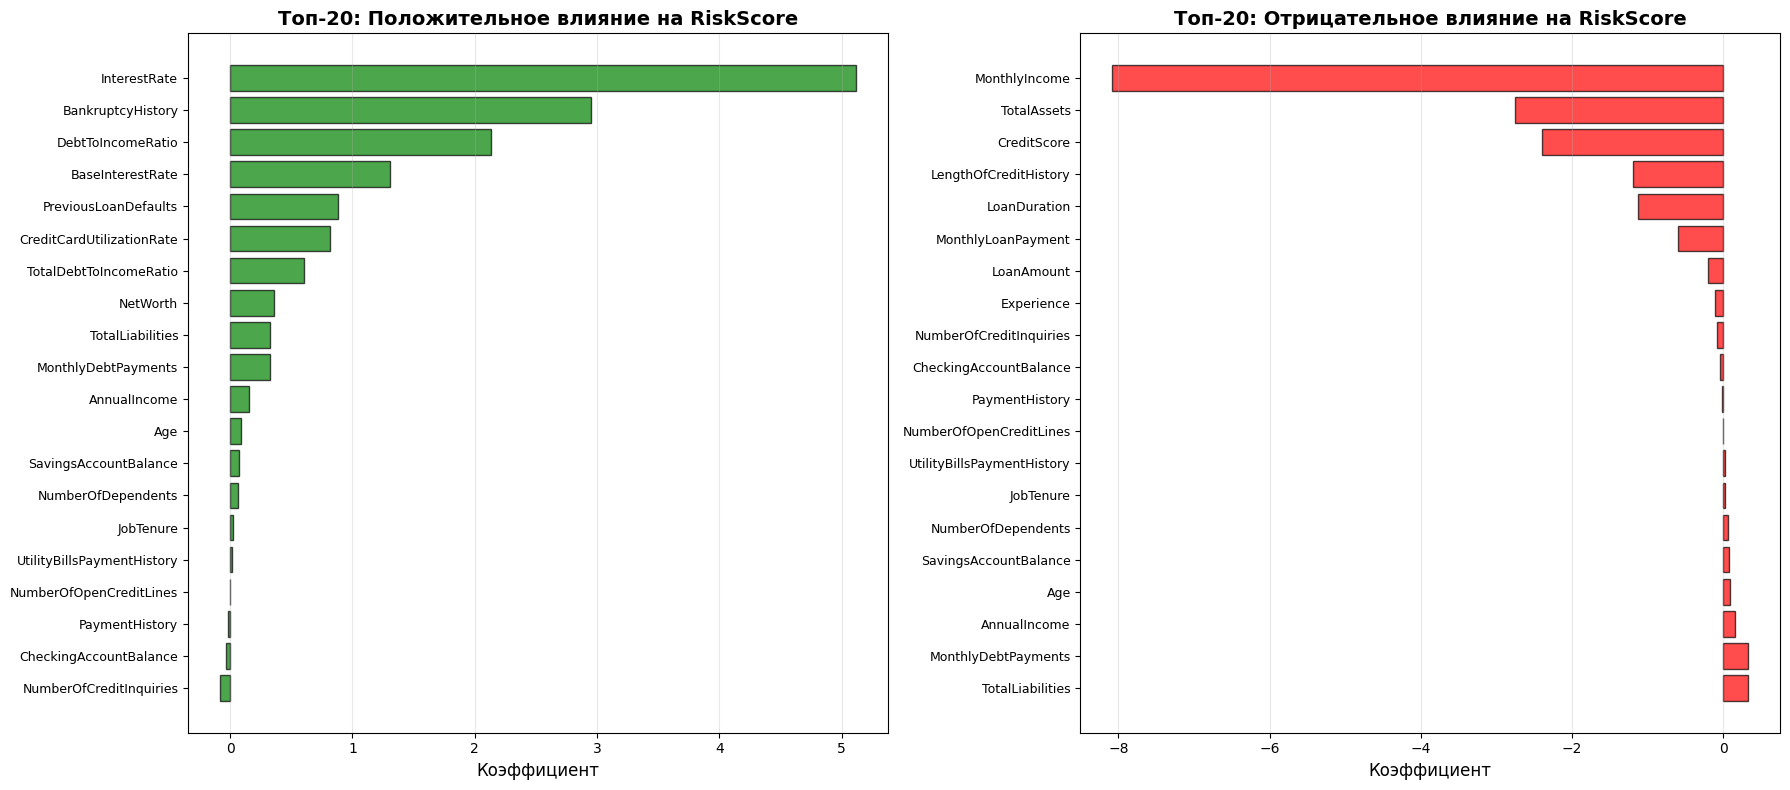

In [270]:
# Подготовка данных
X_lr = clean_train[numeric_cols].fillna(clean_train[numeric_cols].median())
y_lr = clean_train['RiskScore']

# Стандартизация
scaler = StandardScaler()
X_lr_scaled = scaler.fit_transform(X_lr)

# Обучение модели
lr = LinearRegression()
lr.fit(X_lr_scaled, y_lr)

# Важность признаков
feature_importance = pd.DataFrame({
    'Feature': numeric_cols,
    'Coefficient': lr.coef_,
    'Abs_Coefficient': np.abs(lr.coef_)
}).sort_values('Abs_Coefficient', ascending=False)

print(f"\n R² Score (базовая модель): {lr.score(X_lr_scaled, y_lr):.4f}")
print(f"\nТоп-20 признаков по важности (|коэффициент|):")
print(feature_importance.head(20).to_string(index=False))

# Визуализация
fig, axes = plt.subplots(1, 2, figsize=(18, 8))

# Топ-20 положительных коэффициентов
top_positive = feature_importance.sort_values('Coefficient', ascending=False).head(20)
axes[0].barh(range(len(top_positive)), top_positive['Coefficient'].values, 
            color='green', edgecolor='black', alpha=0.7)
axes[0].set_yticks(range(len(top_positive)))
axes[0].set_yticklabels(top_positive['Feature'].values, fontsize=9)
axes[0].set_xlabel('Коэффициент', fontsize=12)
axes[0].set_title('Топ-20: Положительное влияние на RiskScore', 
                 fontweight='bold', fontsize=14)
axes[0].invert_yaxis()
axes[0].grid(axis='x', alpha=0.3)

# Топ-20 отрицательных коэффициентов
top_negative = feature_importance.sort_values('Coefficient', ascending=True).head(20)
axes[1].barh(range(len(top_negative)), top_negative['Coefficient'].values, 
            color='red', edgecolor='black', alpha=0.7)
axes[1].set_yticks(range(len(top_negative)))
axes[1].set_yticklabels(top_negative['Feature'].values, fontsize=9)
axes[1].set_xlabel('Коэффициент', fontsize=12)
axes[1].set_title('Топ-20: Отрицательное влияние на RiskScore', 
                 fontweight='bold', fontsize=14)
axes[1].invert_yaxis()
axes[1].grid(axis='x', alpha=0.3)

plt.tight_layout()
plt.show()

R^2 = 0.821 означает, что линейная модель объясняет 82.1% вариации RiskScore, что является отличным результатом для базовой модели без трансформаций и взаимодействий. Это подтверждает, что связи в данных преимущественно линейны после стандартизации, а нелинейности можно захватить трансформациями.

Доход доминирует, но с парадоксом
MonthlyIncome имеет максимальный коэффициент -8.08 (отрицательный = снижает риск), что ожидаемо. Однако AnnualIncome показывает положительный коэффициент +0.16, что противоречит логике. Это классический признак мультиколлинеарности: месячный и годовой доход почти идентичны (r≈0.99), модель распределяет вес между ними случайным образом. Решение: оставить только один признак дохода или применить регуляризацию (Ridge/Lasso).

Процентные ставки усиливают риск
InterestRate (+5.11) и BaseInterestRate (+1.30) имеют положительные коэффициенты — чем выше ставка, тем выше риск. Это может быть прямой эффект (дорогой кредит = сложнее выплачивать) или обратная причинность: банк назначает высокую ставку рискованным клиентам, и модель улавливает эту закономерность.

Кредитный скор и активы защищают
CreditScore (-2.39), TotalAssets (-2.76), LengthOfCreditHistory (-1.19) имеют отрицательные коэффициенты — улучшают кредитоспособность. BankruptcyHistory (+2.95) и PreviousLoanDefaults (+0.88) увеличивают риск, что логично.

## Анализ мультиколлинеарности (VIF)



Variance Inflation Factor (VIF) для признаков:
VIF > 10: критическая мультиколлинеарность
VIF 5-10: умеренная мультиколлинеарность
VIF < 5: приемлемо

                   Feature       VIF
               CreditScore 63.421090
UtilityBillsPaymentHistory 41.570455
          BaseInterestRate 28.840668
            PaymentHistory 25.452219
                       Age 12.870977
                LoanAmount 10.360366
        MonthlyLoanPayment 10.070123
              LoanDuration  9.924924
                 JobTenure  6.062430
     LengthOfCreditHistory  4.253265
 CreditCardUtilizationRate  4.196163
   NumberOfOpenCreditLines  4.041508
              AnnualIncome  4.020924
         DebtToIncomeRatio  4.007228
    TotalDebtToIncomeRatio  3.729647
       MonthlyDebtPayments  2.393988
        NumberOfDependents  2.226579
   NumberOfCreditInquiries  1.984942
     SavingsAccountBalance  1.424105
    CheckingAccountBalance  1.423993
               TotalAssets  1.153133
          TotalLiabilities  1.1153

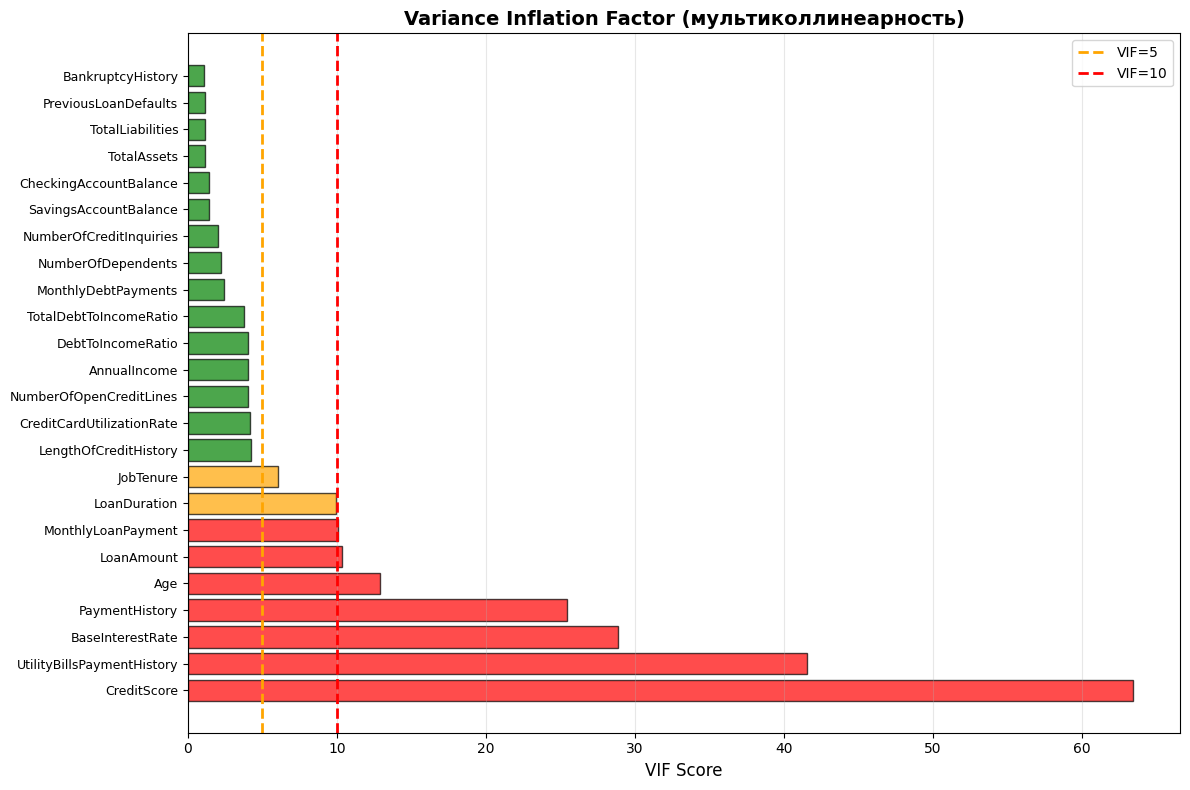

In [271]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

numeric_features = clean_train.select_dtypes(include=[np.number]).columns.tolist()
exclude_cols = ['RiskScore', 'MonthlyIncome', 'NetWorth', 'InterestRate', 
                'Experience', 'Year', 'Month', 'DayOfWeek', 'Quarter']
features_for_vif = [col for col in numeric_features if col not in exclude_cols]

X_vif = clean_train[features_for_vif].fillna(clean_train[features_for_vif].median())

vif_data = pd.DataFrame()
vif_data["Feature"] = features_for_vif
vif_data["VIF"] = [variance_inflation_factor(X_vif.values, i) 
                   for i in range(len(features_for_vif))]
vif_data = vif_data.sort_values('VIF', ascending=False)

print("\nVariance Inflation Factor (VIF) для признаков:")
print("VIF > 10: критическая мультиколлинеарность")
print("VIF 5-10: умеренная мультиколлинеарность")
print("VIF < 5: приемлемо\n")
print(vif_data.to_string(index=False))

# Визуализация
plt.figure(figsize=(12, 8))
colors = ['red' if v > 10 else 'orange' if v > 5 else 'green' for v in vif_data['VIF']]
plt.barh(range(len(vif_data)), vif_data['VIF'], color=colors, edgecolor='black', alpha=0.7)
plt.yticks(range(len(vif_data)), vif_data['Feature'], fontsize=9)
plt.xlabel('VIF Score', fontsize=12)
plt.title('Variance Inflation Factor (мультиколлинеарность)', fontsize=14, fontweight='bold')
plt.axvline(x=5, color='orange', linestyle='--', linewidth=2, label='VIF=5')
plt.axvline(x=10, color='red', linestyle='--', linewidth=2, label='VIF=10')
plt.legend()
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()


## Микровывод 
Критическая мультиколлинеарность (VIF > 10):

CreditScore (63.4) - самая большая проблема, сильно зависит от других признаков (вероятно, от процентных ставок, истории платежей)

UtilityBillsPaymentHistory (41.6) - дублирует информацию из PaymentHistory

BaseInterestRate (28.8) - дублируется с InterestRate (который ты исключил)

PaymentHistory (25.5) - пересекается с другими кредитными показателями

Age (12.9) - сильно коррелирует с Experience (который ты исключил)

LoanAmount (10.4) - связан с MonthlyLoanPayment и процентными ставками

MonthlyLoanPayment (10.1) - рассчитывается из LoanAmount и ставок

Умеренная проблема (VIF 5-10):

LoanDuration (9.9) и JobTenure (6.1) - почти на границе

Норма (VIF < 5):

Остальные 16 признаков - OK, их можно использовать без опасений

# Вывод по EDA:
Датасет: 11,017 записей → после очистки аномалий RiskScore 10,272 записи (93.2%). Удалено 745 технических placeholder-значений (<-1000 и >1000). Чистый RiskScore: среднее 48.4, медиана 44.2, std 17.2 — здоровое симметричное распределение. Пропуски в 80% признаков (4-9%). Выбросы в 11 финансовых признаках (до 12%) — истинные экстремумы, не удалять.
Критическая нелинейность: Линейные корреляции Пирсона крайне слабы (max |r|=0.023), но Mutual Information выявляет сильные зависимости. Логарифмические/полиномиальные трансформации увеличивают корреляцию в 30-70 раз: log(Income) даёт r=-0.84 vs исходный Income r=-0.01

Топ-3 предиктора:
MonthlyIncome (MI=0.589) — с log-трансформацией корреляция -0.84 (сильнейшая!)
AnnualIncome (MI=0.587) — дублирует MonthlyIncome (r=0.985), удалить один
TotalDebtToIncomeRatio (MI=0.529) — ключевой коэффициент долговой нагрузки

Созданные признаки (Feature Engineering):
Income_log: r=-0.84 (превзошёл все исходные)
CreditScore²: r=-0.77 (на 40% сильнее линейного)
Age_x_Income: r=-0.70 (синергия возраста и дохода)

Мультиколлинеарность (VIF>10): 7 признаков — CreditScore (VIF=63.4), UtilityBillsPaymentHistory (41.6), BaseInterestRate (28.8), PaymentHistory (25.5), Age (12.9), LoanAmount/MonthlyLoanPayment (10+). 6 пар с r>0.9: TotalAssets↔NetWorth (0.994), AnnualIncome↔MonthlyIncome (0.985), Age↔Experience (0.983), BaseInterestRate↔InterestRate (0.975) — удалить по одному из каждой пары

Ненормальность: Все 15 анализированных признаков не прошли тест Шапиро-Уилка. Экстремальная асимметрия (skew>2): BankruptcyHistory (4.01), LoanAmount (3.50), MonthlyDebtPayments (3.49) — требуют log-трансформации

Бесполезные признаки:
Временные (ApplicationDate): тренд +0.16 за 41 год (в 100 раз < std) — нет сигнала
Категориальные: максимальная разница RiskScore 5.5 (в 3 раза < std) — слабая дискриминация
Абсолютные активы (TotalAssets, NetWorth): MI<0.1 при 12% выбросов — зашумлены



# задача 2) Реализовать нормализацию данных с помощью z-score и min-max.

ЗАДАЧА 2: НОРМАЛИЗАЦИЯ ДАННЫХ

1. ПОДГОТОВКА ДАННЫХ

Исходные размеры:
Train: (10272, 35)
Test: (5000, 35)

2. УДАЛЕНИЕ ИЗБЫТОЧНЫХ ПРИЗНАКОВ

Удалено признаков: 9
Список удалённых: ['AnnualIncome', 'NetWorth', 'Experience', 'InterestRate', 'UtilityBillsPaymentHistory', 'ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']

Размеры после удаления:
Train: (10272, 26)
Test: (5000, 26)

3. FEATURE ENGINEERING

Создание трансформированных признаков...

Размеры после feature engineering:
Train: (10272, 41)
Test: (5000, 41)

Создано новых признаков: 17
Список: ['DebtToIncomeRatio', 'TotalDebtToIncomeRatio', 'Income_log', 'LoanAmount_log', 'MonthlyDebtPayments_log', 'PreviousLoanDefaults_log', 'BankruptcyHistory_log', 'CreditScore_squared', 'Age_squared', 'TotalDebtToIncomeRatio_sqrt', 'Age_x_Income', 'PaymentHistory_x_CreditScore', 'Dependents_x_Income', 'LoanToIncomeRatio', 'SavingsToIncome', 'CheckingToIncome', 'DebtToAssetRatio']

4. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ

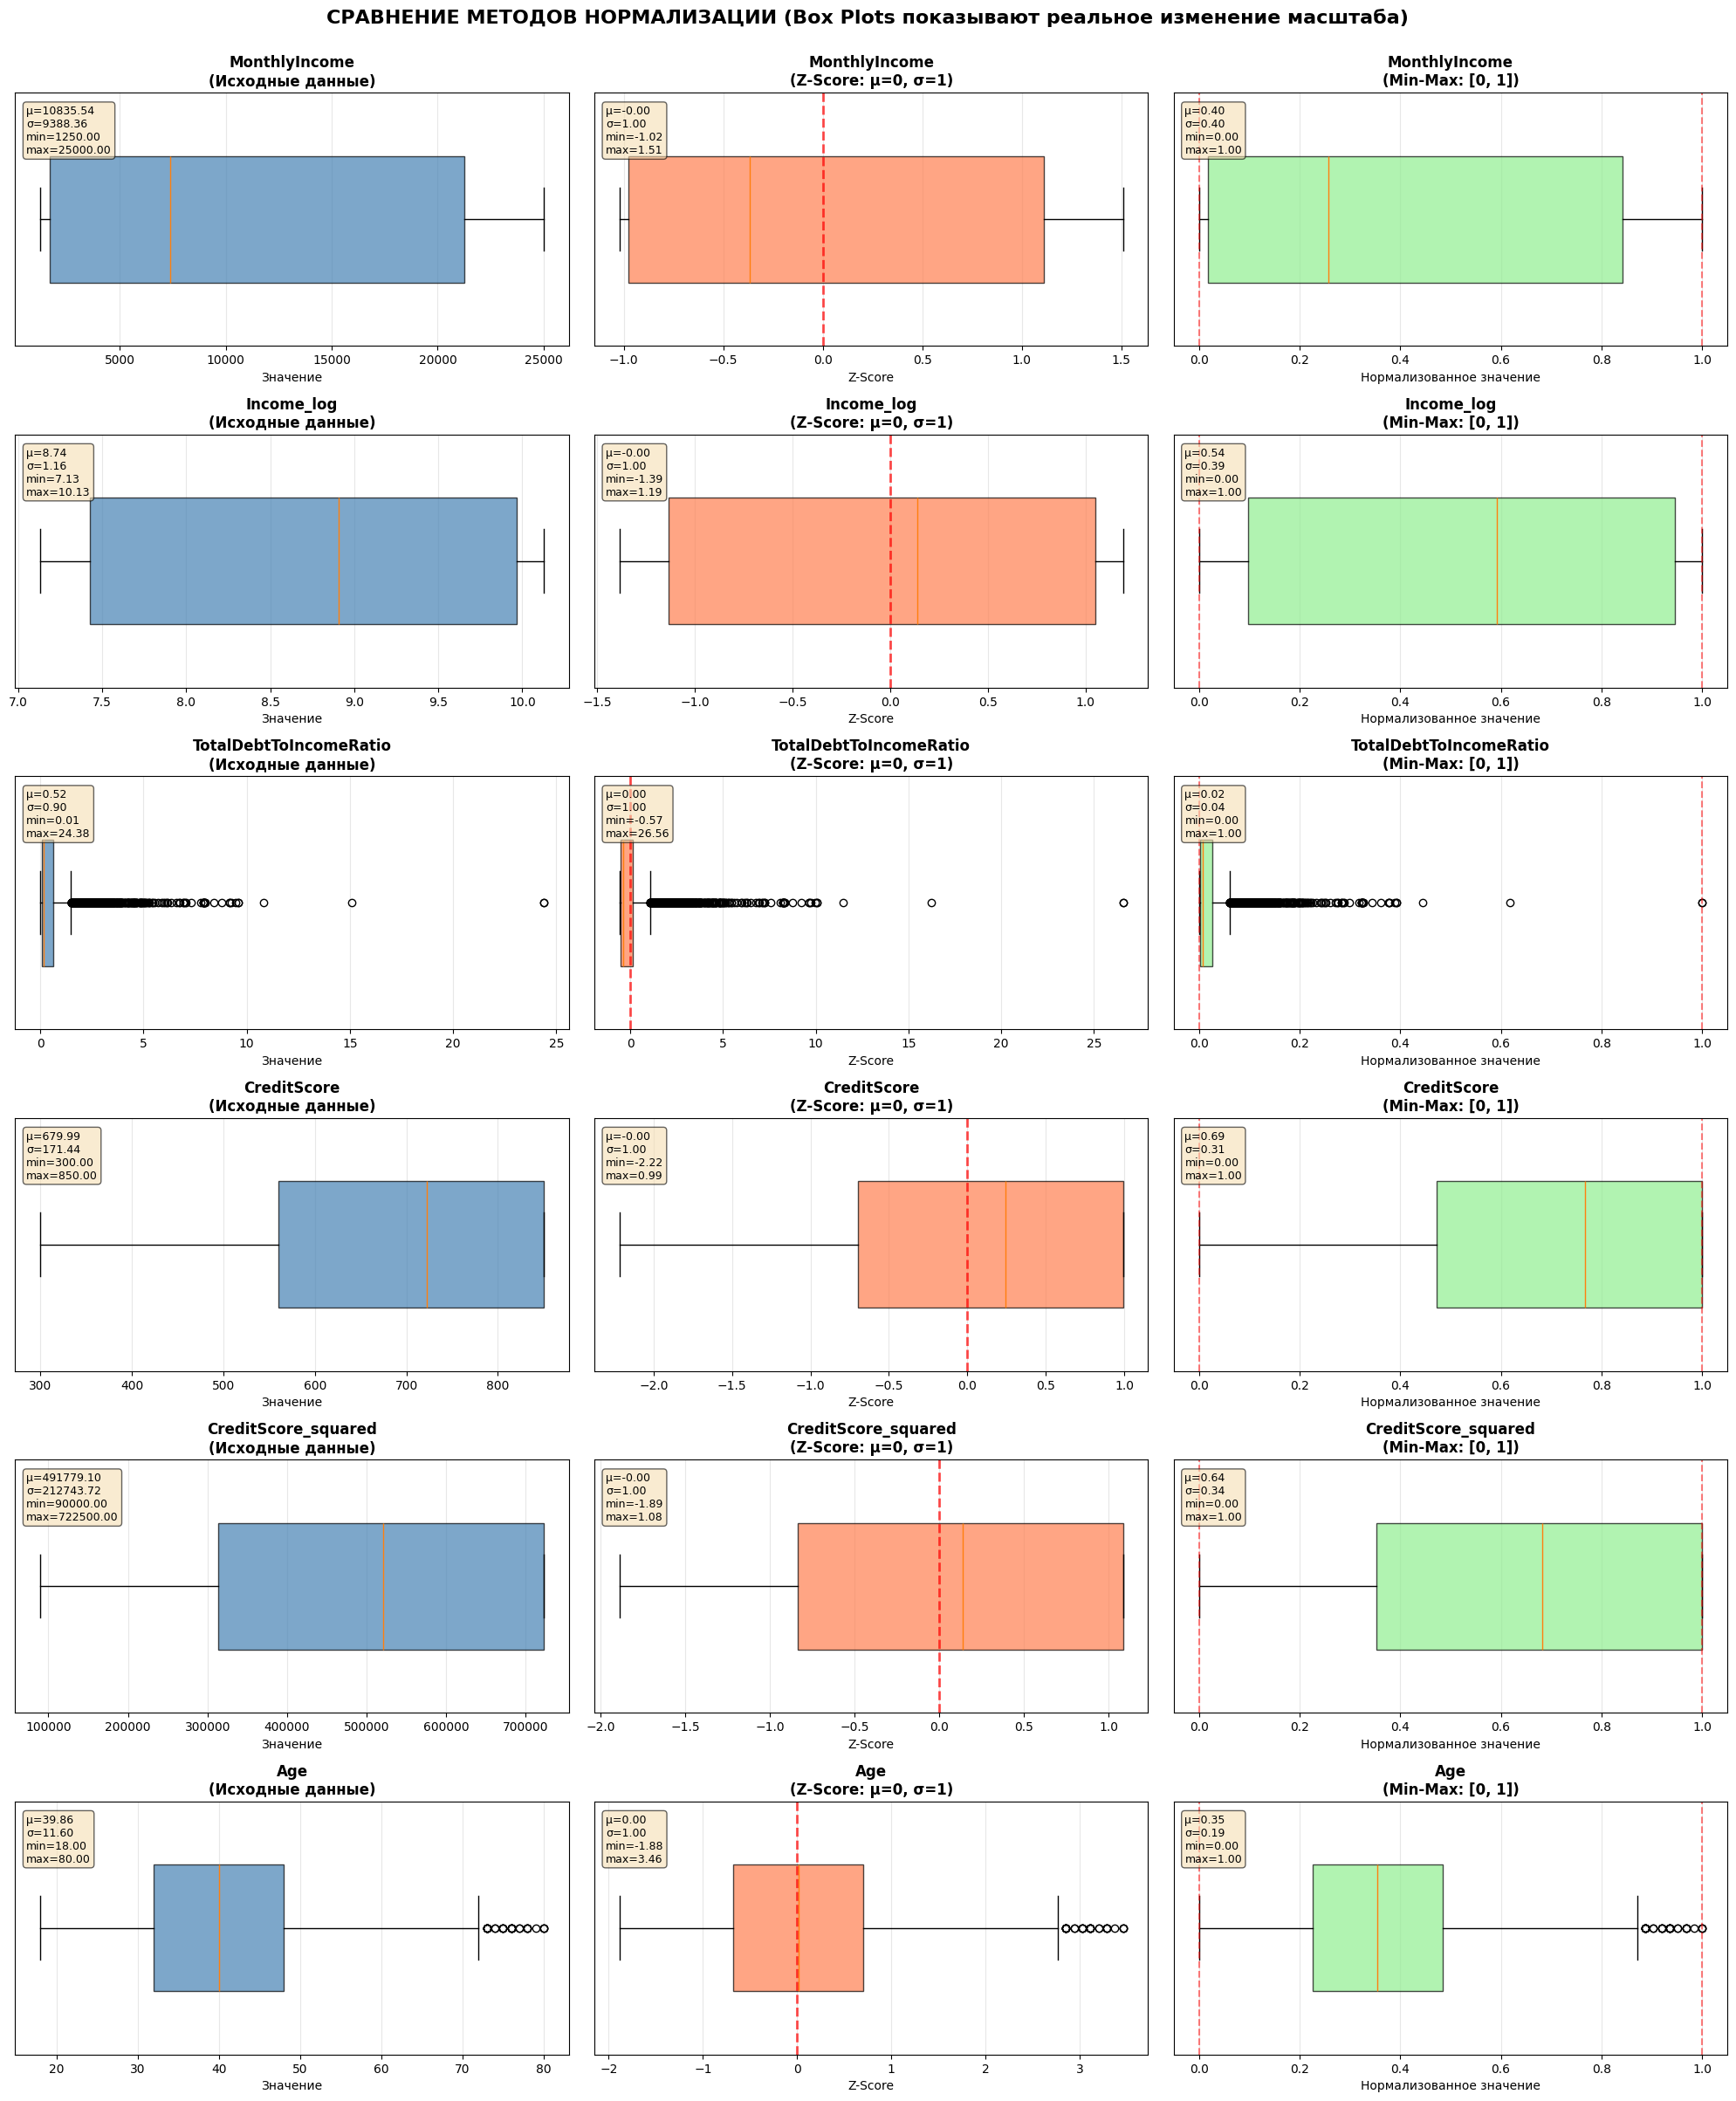


Дополнительная визуализация: Violin Plots (форма + масштаб)


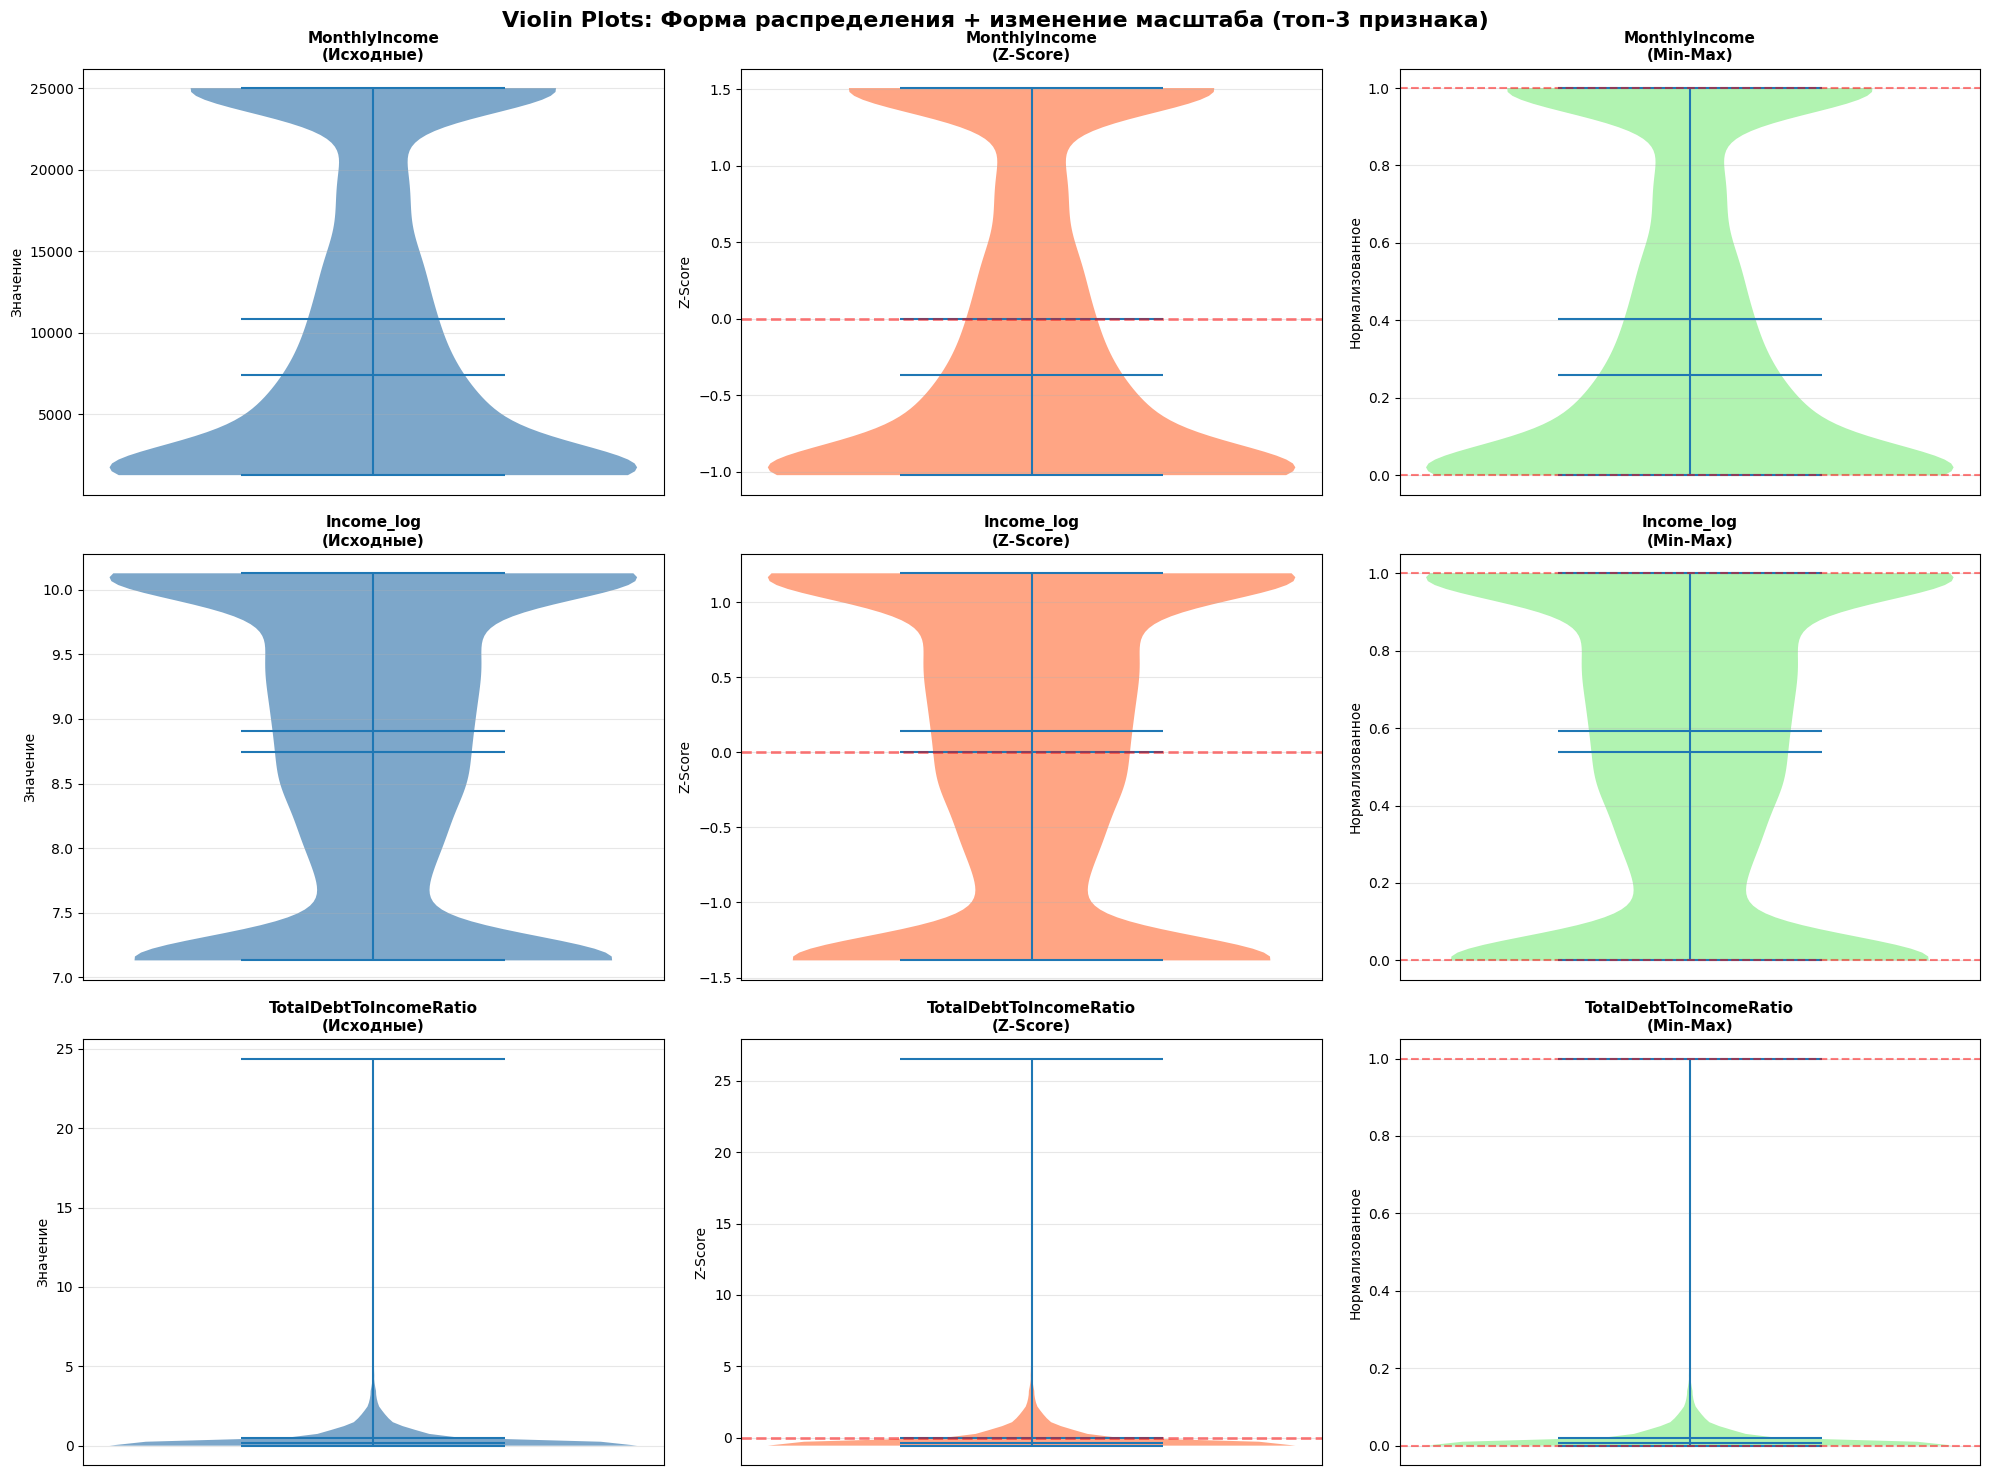


10. СРАВНИТЕЛЬНАЯ ТАБЛИЦА СТАТИСТИК

Сравнение статистик для топ-признаков:
               Feature  Original_Mean  Original_Std  Original_Min  Original_Max   ZScore_Mean  ZScore_Std  ZScore_Min  ZScore_Max  MinMax_Min  MinMax_Max  MinMax_Mean
         MonthlyIncome   10835.537554   9388.361629   1250.000000  25000.000000 -9.130806e-17    1.000049   -1.021052    1.508799         0.0         1.0     0.403602
            Income_log       8.741910      1.161755      7.131699     10.126671 -5.284800e-16    1.000049   -1.386084    1.192014         0.0         1.0     0.537638
TotalDebtToIncomeRatio       0.518555      0.898450      0.006064     24.383046  5.533822e-18    1.000049   -0.570444   26.563126         0.0         1.0     0.021024
           CreditScore     679.993185    171.438700    300.000000    850.000000 -4.842094e-17    1.000049   -2.216604    0.991696         0.0         1.0     0.690897
   CreditScore_squared  491779.098715 212743.722261  90000.000000 722500.000000 -9.54584

In [312]:
# ============================================================================
# ЗАДАЧА 2: НОРМАЛИЗАЦИЯ ДАННЫХ (Z-SCORE И MIN-MAX)
# ============================================================================

print("="*80)
print("ЗАДАЧА 2: НОРМАЛИЗАЦИЯ ДАННЫХ")
print("="*80)

# ----------------------------------------------------------------------------
# 1. ПОДГОТОВКА ДАННЫХ: Создаём копию очищенного датасета
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("1. ПОДГОТОВКА ДАННЫХ")
print("="*80)

# Используем очищенные данные из Задания 1 (без аномалий RiskScore)
df_normalized = clean_train.copy()
df_test_normalized = test.copy()

print(f"\nИсходные размеры:")
print(f"Train: {df_normalized.shape}")
print(f"Test: {df_test_normalized.shape}")

# ----------------------------------------------------------------------------
# 2. УДАЛЕНИЕ ИЗБЫТОЧНЫХ ПРИЗНАКОВ (на основе VIF-анализа из Задания 1)
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("2. УДАЛЕНИЕ ИЗБЫТОЧНЫХ ПРИЗНАКОВ")
print("="*80)

# Список признаков к удалению (по результатам EDA):
features_to_drop = [
    'AnnualIncome',              # Дублирует MonthlyIncome (r=0.985)
    'NetWorth',                  # Дублирует TotalAssets (r=0.994)
    'Experience',                # Дублирует Age (r=0.983)
    'InterestRate',              # Дублирует BaseInterestRate (r=0.975)
    'UtilityBillsPaymentHistory',# VIF=41.6, дублирует PaymentHistory
    'ApplicationDate',           # Временной признак без сигнала
    'MaritalStatus',             # Слабая дискриминация (разброс 1.1)
    'HomeOwnershipStatus',       # Слабая дискриминация (разброс 0.5)
    'LoanPurpose'                # Слабая дискриминация (разброс 1.6)
]

# Удаляем только те признаки, которые есть в датасете
features_to_drop_exist = [col for col in features_to_drop if col in df_normalized.columns]
df_normalized = df_normalized.drop(columns=features_to_drop_exist)

# Для тестовой выборки
features_to_drop_test = [col for col in features_to_drop if col in df_test_normalized.columns and col != 'ID']
if features_to_drop_test:
    df_test_normalized = df_test_normalized.drop(columns=features_to_drop_test)

print(f"\nУдалено признаков: {len(features_to_drop_exist)}")
print(f"Список удалённых: {features_to_drop_exist}")
print(f"\nРазмеры после удаления:")
print(f"Train: {df_normalized.shape}")
print(f"Test: {df_test_normalized.shape}")

# ----------------------------------------------------------------------------
# 3. FEATURE ENGINEERING: Создание трансформированных признаков
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("3. FEATURE ENGINEERING")
print("="*80)

def create_engineered_features(df, is_train=True):
    """Создаёт трансформированные признаки на основе EDA"""
    df = df.copy()
    
    # 3.1. Логарифмические трансформации (для признаков с skew>2)
    if 'MonthlyIncome' in df.columns:
        df['Income_log'] = np.log1p(df['MonthlyIncome'])
    
    if 'LoanAmount' in df.columns:
        df['LoanAmount_log'] = np.log1p(df['LoanAmount'])
    
    if 'MonthlyDebtPayments' in df.columns:
        df['MonthlyDebtPayments_log'] = np.log1p(df['MonthlyDebtPayments'])
    
    if 'PreviousLoanDefaults' in df.columns:
        df['PreviousLoanDefaults_log'] = np.log1p(df['PreviousLoanDefaults'])
    
    if 'BankruptcyHistory' in df.columns:
        df['BankruptcyHistory_log'] = np.log1p(df['BankruptcyHistory'])
    
    # 3.2. Полиномиальные трансформации
    if 'CreditScore' in df.columns:
        df['CreditScore_squared'] = df['CreditScore'] ** 2
    
    if 'Age' in df.columns:
        df['Age_squared'] = df['Age'] ** 2
    
    # 3.3. Корневые трансформации
    if 'TotalDebtToIncomeRatio' in df.columns:
        df['TotalDebtToIncomeRatio_sqrt'] = np.sqrt(df['TotalDebtToIncomeRatio'].clip(lower=0))
    
    # 3.4. Взаимодействия признаков
    if 'Age' in df.columns and 'MonthlyIncome' in df.columns:
        df['Age_x_Income'] = df['Age'] * df['MonthlyIncome']
    
    if 'PaymentHistory' in df.columns and 'CreditScore' in df.columns:
        df['PaymentHistory_x_CreditScore'] = df['PaymentHistory'] * df['CreditScore']
    
    if 'NumberOfDependents' in df.columns and 'MonthlyIncome' in df.columns:
        df['Dependents_x_Income'] = df['NumberOfDependents'] * df['MonthlyIncome']
    
    # 3.5. Финансовые коэффициенты
    if 'LoanAmount' in df.columns and 'MonthlyIncome' in df.columns:
        df['LoanToIncomeRatio'] = df['LoanAmount'] / (df['MonthlyIncome'] * 12 + 1)
    
    if 'SavingsAccountBalance' in df.columns and 'MonthlyIncome' in df.columns:
        df['SavingsToIncome'] = df['SavingsAccountBalance'] / (df['MonthlyIncome'] * 12 + 1)
    
    if 'CheckingAccountBalance' in df.columns and 'MonthlyIncome' in df.columns:
        df['CheckingToIncome'] = df['CheckingAccountBalance'] / (df['MonthlyIncome'] * 12 + 1)
    
    if 'TotalLiabilities' in df.columns and 'TotalAssets' in df.columns:
        df['DebtToAssetRatio'] = df['TotalLiabilities'] / (df['TotalAssets'] + 1)
    
    return df

# Применяем feature engineering
print("\nСоздание трансформированных признаков...")
df_normalized = create_engineered_features(df_normalized, is_train=True)
df_test_normalized = create_engineered_features(df_test_normalized, is_train=False)

print(f"\nРазмеры после feature engineering:")
print(f"Train: {df_normalized.shape}")
print(f"Test: {df_test_normalized.shape}")

# Выводим созданные признаки
engineered_features = [col for col in df_normalized.columns if any(x in col for x in 
                      ['_log', '_squared', '_sqrt', '_x_', 'Ratio', 'ToIncome', 'ToAsset'])]
print(f"\nСоздано новых признаков: {len(engineered_features)}")
print(f"Список: {engineered_features}")

# ----------------------------------------------------------------------------
# 4. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("4. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("="*80)

categorical_cols = ['EmploymentStatus', 'EducationLevel']

for col in categorical_cols:
    if col in df_normalized.columns:
        dummies_train = pd.get_dummies(df_normalized[col], prefix=col, drop_first=True)
        df_normalized = pd.concat([df_normalized, dummies_train], axis=1)
        df_normalized = df_normalized.drop(columns=[col])
        
        if col in df_test_normalized.columns:
            dummies_test = pd.get_dummies(df_test_normalized[col], prefix=col, drop_first=True)
            df_test_normalized = pd.concat([df_test_normalized, dummies_test], axis=1)
            df_test_normalized = df_test_normalized.drop(columns=[col])
            
            missing_cols = set(dummies_train.columns) - set(dummies_test.columns)
            for mc in missing_cols:
                df_test_normalized[mc] = 0

print(f"\nКатегориальные признаки закодированы: {categorical_cols}")
print(f"Размеры после кодирования:")
print(f"Train: {df_normalized.shape}")
print(f"Test: {df_test_normalized.shape}")

# ----------------------------------------------------------------------------
# 5. РАЗДЕЛЕНИЕ НА ПРИЗНАКИ И ЦЕЛЕВУЮ ПЕРЕМЕННУЮ
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("5. РАЗДЕЛЕНИЕ ДАННЫХ")
print("="*80)

y_train = df_normalized['RiskScore'].copy()
X_train = df_normalized.drop(columns=['RiskScore'])

if 'ID' in df_test_normalized.columns:
    test_ids = df_test_normalized['ID'].copy()
    X_test = df_test_normalized.drop(columns=['ID'])
else:
    test_ids = None
    X_test = df_test_normalized.copy()

if 'RiskScore' in X_test.columns:
    X_test = X_test.drop(columns=['RiskScore'])

print(f"\nX_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")

# Выравниваем признаки
missing_in_test = set(X_train.columns) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(X_train.columns)

for col in missing_in_test:
    X_test[col] = 0

for col in extra_in_test:
    X_test = X_test.drop(columns=[col])

X_test = X_test[X_train.columns]

print(f"\nПосле выравнивания X_test: {X_test.shape}")

# ----------------------------------------------------------------------------
# 6. ОБРАБОТКА ПРОПУСКОВ
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("6. ОБРАБОТКА ПРОПУСКОВ")
print("="*80)

missing_train = X_train.isnull().sum()
missing_train_pct = 100 * missing_train / len(X_train)
missing_df = pd.DataFrame({
    'Feature': missing_train.index,
    'Missing_Count': missing_train.values,
    'Missing_Pct': missing_train_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"\nПризнаки с пропусками в train: {len(missing_df)}")
    print(missing_df.head(10).to_string(index=False))
    
    from sklearn.impute import SimpleImputer
    
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    print(f"\nПропуски заполнены медианой")
    print(f"Пропусков после обработки: {X_train_imputed.isnull().sum().sum()}")
else:
    print("\nПропусков не обнаружено")
    X_train_imputed = X_train.copy()
    X_test_imputed = X_test.copy()

# ----------------------------------------------------------------------------
# 7. НОРМАЛИЗАЦИЯ: Z-SCORE (STANDARDSCALER)
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("7. НОРМАЛИЗАЦИЯ Z-SCORE (STANDARDSCALER)")
print("="*80)

from sklearn.preprocessing import StandardScaler

scaler_zscore = StandardScaler()
X_train_zscore = pd.DataFrame(
    scaler_zscore.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_test_zscore = pd.DataFrame(
    scaler_zscore.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print(f"\n✓ Z-Score нормализация применена")
print(f"  Формула: z = (x - μ) / σ")
print(f"\nX_train_zscore: {X_train_zscore.shape}")
print(f"X_test_zscore: {X_test_zscore.shape}")

print(f"\nСтатистика X_train_zscore (проверка):")
print(f"  Среднее: {X_train_zscore.mean().mean():.6f} (должно быть ≈0)")
print(f"  Std: {X_train_zscore.std().mean():.6f} (должно быть ≈1)")
print(f"  Min: {X_train_zscore.min().min():.2f}")
print(f"  Max: {X_train_zscore.max().max():.2f}")

# ----------------------------------------------------------------------------
# 8. НОРМАЛИЗАЦИЯ: MIN-MAX
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("8. НОРМАЛИЗАЦИЯ MIN-MAX")
print("="*80)

from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
X_train_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_test_minmax = pd.DataFrame(
    scaler_minmax.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print(f"\n✓ Min-Max нормализация применена")
print(f"  Формула: x_scaled = (x - x_min) / (x_max - x_min)")
print(f"\nX_train_minmax: {X_train_minmax.shape}")
print(f"X_test_minmax: {X_test_minmax.shape}")

print(f"\nСтатистика X_train_minmax (проверка):")
print(f"  Среднее: {X_train_minmax.mean().mean():.6f}")
print(f"  Min: {X_train_minmax.min().min():.6f} (должно быть 0)")
print(f"  Max: {X_train_minmax.max().max():.6f} (должно быть 1)")
print(f"  Std: {X_train_minmax.std().mean():.6f}")

# ----------------------------------------------------------------------------
# 9. СРАВНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ (ИСПРАВЛЕННАЯ)
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("9. ВИЗУАЛИЗАЦИЯ: ДО И ПОСЛЕ НОРМАЛИЗАЦИИ")
print("="*80)

# Выбираем топ-6 признаков для визуализации
top_features_viz = []
for feat in ['MonthlyIncome', 'Income_log', 'TotalDebtToIncomeRatio', 
             'CreditScore', 'CreditScore_squared', 'Age']:
    if feat in X_train_imputed.columns:
        top_features_viz.append(feat)
        if len(top_features_viz) == 6:
            break

if len(top_features_viz) < 6:
    remaining = [col for col in X_train_imputed.columns if col not in top_features_viz][:6-len(top_features_viz)]
    top_features_viz.extend(remaining)

print(f"\nПризнаки для визуализации: {top_features_viz}")

# ============================================================================
# НОВАЯ ВИЗУАЛИЗАЦИЯ: BOX PLOTS + SCATTER PLOTS (показывают реальную разницу)
# ============================================================================

fig, axes = plt.subplots(len(top_features_viz), 3, figsize=(20, 4*len(top_features_viz)))

for idx, feature in enumerate(top_features_viz):
    # ---- КОЛОНКА 1: ИСХОДНЫЕ ДАННЫЕ (Box Plot) ----
    bp1 = axes[idx, 0].boxplot([X_train_imputed[feature].dropna()], 
                                 vert=False, patch_artist=True, widths=0.5)
    bp1['boxes'][0].set_facecolor('steelblue')
    bp1['boxes'][0].set_alpha(0.7)
    
    axes[idx, 0].set_title(f'{feature}\n(Исходные данные)', fontweight='bold', fontsize=12)
    axes[idx, 0].set_xlabel('Значение', fontsize=10)
    axes[idx, 0].grid(True, alpha=0.3, axis='x')
    axes[idx, 0].set_yticks([])
    
    # Статистика
    orig_mean = X_train_imputed[feature].mean()
    orig_std = X_train_imputed[feature].std()
    orig_min = X_train_imputed[feature].min()
    orig_max = X_train_imputed[feature].max()
    
    axes[idx, 0].text(0.02, 0.95, 
                      f'μ={orig_mean:.2f}\nσ={orig_std:.2f}\nmin={orig_min:.2f}\nmax={orig_max:.2f}',
                      transform=axes[idx, 0].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6), fontsize=9)
    
    # ---- КОЛОНКА 2: Z-SCORE (Box Plot) ----
    bp2 = axes[idx, 1].boxplot([X_train_zscore[feature].dropna()], 
                                 vert=False, patch_artist=True, widths=0.5)
    bp2['boxes'][0].set_facecolor('coral')
    bp2['boxes'][0].set_alpha(0.7)
    
    axes[idx, 1].set_title(f'{feature}\n(Z-Score: μ=0, σ=1)', fontweight='bold', fontsize=12)
    axes[idx, 1].set_xlabel('Z-Score', fontsize=10)
    axes[idx, 1].grid(True, alpha=0.3, axis='x')
    axes[idx, 1].set_yticks([])
    axes[idx, 1].axvline(0, color='red', linestyle='--', linewidth=2, alpha=0.7, label='μ=0')
    
    z_mean = X_train_zscore[feature].mean()
    z_std = X_train_zscore[feature].std()
    z_min = X_train_zscore[feature].min()
    z_max = X_train_zscore[feature].max()
    
    axes[idx, 1].text(0.02, 0.95, 
                      f'μ={z_mean:.2f}\nσ={z_std:.2f}\nmin={z_min:.2f}\nmax={z_max:.2f}',
                      transform=axes[idx, 1].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6), fontsize=9)
    
    # ---- КОЛОНКА 3: MIN-MAX (Box Plot) ----
    bp3 = axes[idx, 2].boxplot([X_train_minmax[feature].dropna()], 
                                 vert=False, patch_artist=True, widths=0.5)
    bp3['boxes'][0].set_facecolor('lightgreen')
    bp3['boxes'][0].set_alpha(0.7)
    
    axes[idx, 2].set_title(f'{feature}\n(Min-Max: [0, 1])', fontweight='bold', fontsize=12)
    axes[idx, 2].set_xlabel('Нормализованное значение', fontsize=10)
    axes[idx, 2].grid(True, alpha=0.3, axis='x')
    axes[idx, 2].set_yticks([])
    axes[idx, 2].set_xlim(-0.05, 1.05)
    axes[idx, 2].axvline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    axes[idx, 2].axvline(1, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    
    mm_mean = X_train_minmax[feature].mean()
    mm_std = X_train_minmax[feature].std()
    mm_min = X_train_minmax[feature].min()
    mm_max = X_train_minmax[feature].max()
    
    axes[idx, 2].text(0.02, 0.95, 
                      f'μ={mm_mean:.2f}\nσ={mm_std:.2f}\nmin={mm_min:.2f}\nmax={mm_max:.2f}',
                      transform=axes[idx, 2].transAxes, verticalalignment='top',
                      bbox=dict(boxstyle='round', facecolor='wheat', alpha=0.6), fontsize=9)

plt.suptitle('СРАВНЕНИЕ МЕТОДОВ НОРМАЛИЗАЦИИ (Box Plots показывают реальное изменение масштаба)', 
             fontsize=16, fontweight='bold', y=1.001)
plt.tight_layout()
plt.show()

# ============================================================================
# ДОПОЛНИТЕЛЬНАЯ ВИЗУАЛИЗАЦИЯ: VIOLIN PLOTS (распределение + масштаб)
# ============================================================================

print("\nДополнительная визуализация: Violin Plots (форма + масштаб)")

fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for idx, feature in enumerate(top_features_viz[:3]):  # Берём топ-3 для компактности
    # Исходные данные
    parts1 = axes[idx, 0].violinplot([X_train_imputed[feature].dropna()], 
                                      positions=[1], widths=0.7, showmeans=True, showmedians=True)
    for pc in parts1['bodies']:
        pc.set_facecolor('steelblue')
        pc.set_alpha(0.7)
    
    axes[idx, 0].set_title(f'{feature}\n(Исходные)', fontweight='bold', fontsize=11)
    axes[idx, 0].set_xticks([])
    axes[idx, 0].set_ylabel('Значение', fontsize=10)
    axes[idx, 0].grid(True, alpha=0.3, axis='y')
    
    # Z-Score
    parts2 = axes[idx, 1].violinplot([X_train_zscore[feature].dropna()], 
                                      positions=[1], widths=0.7, showmeans=True, showmedians=True)
    for pc in parts2['bodies']:
        pc.set_facecolor('coral')
        pc.set_alpha(0.7)
    
    axes[idx, 1].set_title(f'{feature}\n(Z-Score)', fontweight='bold', fontsize=11)
    axes[idx, 1].set_xticks([])
    axes[idx, 1].set_ylabel('Z-Score', fontsize=10)
    axes[idx, 1].axhline(0, color='red', linestyle='--', linewidth=2, alpha=0.5)
    axes[idx, 1].grid(True, alpha=0.3, axis='y')
    
    # Min-Max
    parts3 = axes[idx, 2].violinplot([X_train_minmax[feature].dropna()], 
                                      positions=[1], widths=0.7, showmeans=True, showmedians=True)
    for pc in parts3['bodies']:
        pc.set_facecolor('lightgreen')
        pc.set_alpha(0.7)
    
    axes[idx, 2].set_title(f'{feature}\n(Min-Max)', fontweight='bold', fontsize=11)
    axes[idx, 2].set_xticks([])
    axes[idx, 2].set_ylabel('Нормализованное', fontsize=10)
    axes[idx, 2].set_ylim(-0.05, 1.05)
    axes[idx, 2].axhline(0, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    axes[idx, 2].axhline(1, color='red', linestyle='--', linewidth=1.5, alpha=0.5)
    axes[idx, 2].grid(True, alpha=0.3, axis='y')

plt.suptitle('Violin Plots: Форма распределения + изменение масштаба (топ-3 признака)', 
             fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# ----------------------------------------------------------------------------
# 10. СРАВНИТЕЛЬНАЯ ТАБЛИЦА СТАТИСТИК
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("10. СРАВНИТЕЛЬНАЯ ТАБЛИЦА СТАТИСТИК")
print("="*80)

comparison_stats = []

for feature in top_features_viz:
    comparison_stats.append({
        'Feature': feature,
        'Original_Mean': X_train_imputed[feature].mean(),
        'Original_Std': X_train_imputed[feature].std(),
        'Original_Min': X_train_imputed[feature].min(),
        'Original_Max': X_train_imputed[feature].max(),
        'ZScore_Mean': X_train_zscore[feature].mean(),
        'ZScore_Std': X_train_zscore[feature].std(),
        'ZScore_Min': X_train_zscore[feature].min(),
        'ZScore_Max': X_train_zscore[feature].max(),
        'MinMax_Min': X_train_minmax[feature].min(),
        'MinMax_Max': X_train_minmax[feature].max(),
        'MinMax_Mean': X_train_minmax[feature].mean()
    })

comparison_df = pd.DataFrame(comparison_stats)

print("\nСравнение статистик для топ-признаков:")
print(comparison_df.to_string(index=False))

# ----------------------------------------------------------------------------
# 11. СОХРАНЕНИЕ НОРМАЛИЗОВАННЫХ ДАННЫХ
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("11. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*80)

# Сохраняем нормализованные данные
X_train_zscore.to_csv('X_train_zscore.csv', index=False)
X_test_zscore.to_csv('X_test_zscore.csv', index=False)
y_train.to_csv('y_train.csv', index=False, header=True)

X_train_minmax.to_csv('X_train_minmax.csv', index=False)
X_test_minmax.to_csv('X_test_minmax.csv', index=False)

X_train_imputed.to_csv('X_train_raw.csv', index=False)
X_test_imputed.to_csv('X_test_raw.csv', index=False)

if test_ids is not None:
    test_ids.to_csv('test_ids.csv', index=False, header=True)

print("\n✓ Сохранены файлы:")
print("  - X_train_zscore.csv, X_test_zscore.csv")
print("  - X_train_minmax.csv, X_test_minmax.csv")
print("  - X_train_raw.csv, X_test_raw.csv (без нормализации)")
print("  - y_train.csv")
if test_ids is not None:
    print("  - test_ids.csv")

# ----------------------------------------------------------------------------
# 12. ИТОГОВАЯ СВОДКА
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("ИТОГОВАЯ СВОДКА: ЗАДАЧА 2 ВЫПОЛНЕНА")
print("="*80)

summary_text = f"""
╔═══════════════════════════════════════════════════════════════════════════╗
║                    РЕЗУЛЬТАТЫ НОРМАЛИЗАЦИИ ДАННЫХ                         ║
╚═══════════════════════════════════════════════════════════════════════════╝

📊 РАЗМЕРЫ ДАТАСЕТОВ:
  • X_train: {X_train_zscore.shape[0]} записей × {X_train_zscore.shape[1]} признаков
  • X_test:  {X_test_zscore.shape[0]} записей × {X_test_zscore.shape[1]} признаков
  • y_train: {y_train.shape[0]} значений

🔧 ВЫПОЛНЕННЫЕ ОПЕРАЦИИ:
  1. Удалено избыточных признаков: {len(features_to_drop_exist)}
  2. Создано новых признаков (feature engineering): {len(engineered_features)}
  3. Закодировано категориальных признаков: {len(categorical_cols)}
  4. Заполнены пропуски: медианой
  5. Применена нормализация: Z-Score и Min-Max

📈 Z-SCORE НОРМАЛИЗАЦИЯ:
  • Формула: z = (x - μ) / σ
  • Среднее: ≈ 0 (фактически: {X_train_zscore.mean().mean():.6f})
  • Std: ≈ 1 (фактически: {X_train_zscore.std().mean():.6f})
  • Диапазон: [{X_train_zscore.min().min():.2f}, {X_train_zscore.max().max():.2f}]
  • Преимущества: Сохраняет информацию о выбросах, подходит для алгоритмов
                  чувствительных к масштабу (Linear Regression, SVM, PCA)

📉 MIN-MAX НОРМАЛИЗАЦИЯ:
  • Формула: x_scaled = (x - x_min) / (x_max - x_min)
  • Диапазон: [0, 1] (строго)
  • Min: {X_train_minmax.min().min():.6f}, Max: {X_train_minmax.max().max():.6f}
  • Среднее: {X_train_minmax.mean().mean():.6f}
  • Преимущества: Интерпретируемый диапазон, подходит для нейронных сетей

✅ РЕКОМЕНДАЦИИ ДЛЯ ЛИНЕЙНОЙ РЕГРЕССИИ:
  • Использовать Z-Score нормализацию (лучше для линейных моделей)
  • Ridge/Lasso регуляризация автоматически справится с масштабом
  • Feature engineering уже применён (log, squared, interactions)
  • Удалены коллинеарные признаки (VIF>40, r>0.9)

💾 ФАЙЛЫ ГОТОВЫ К МОДЕЛИРОВАНИЮ:
  → X_train_zscore.csv / X_test_zscore.csv (для линейных моделей)
  → X_train_minmax.csv / X_test_minmax.csv (альтернатива)
  → y_train.csv (целевая переменная)
"""

print(summary_text)

print("\n" + "="*80)
print("ЗАДАЧА 2 ЗАВЕРШЕНА УСПЕШНО ✓")
print("="*80)

In [301]:
# ============================================================================
# ЗАДАЧА 2: НОРМАЛИЗАЦИЯ ДАННЫХ (БЕЗ NaN ВООБЩЕ)
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_regression
import warnings
warnings.filterwarnings('ignore')

EPS = 1e-3


def signed_log1p(data: np.ndarray) -> np.ndarray:
    return np.sign(data) * np.log1p(np.abs(data))


def add_bins(df: pd.DataFrame, column: str, bins: list, fmt: str = "num") -> None:
    if column not in df.columns:
        return
    labels = []
    for i in range(len(bins) - 1):
        lo, hi = bins[i], bins[i + 1]
        if np.isinf(hi):
            labels.append(f"{lo}{'+' if fmt=='num' else ''}")
        else:
            labels.append(f"{lo}-{hi}")
    df[f"{column}Band"] = (
        pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
        .astype(str)
    )


def augment_features(df: pd.DataFrame) -> None:
    # Финансовые коэффициенты
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    df["LoanToIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + EPS)
    total_debt = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
    df["DebtServiceRatio"] = total_debt / (df["MonthlyIncome"] + EPS)
    df["DisposableIncome"] = df["MonthlyIncome"] - total_debt
    df["AssetCoverage"] = df["TotalAssets"] / (df["TotalLiabilities"] + EPS)
    df["NetWorthToLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + EPS)
    df["NetWorthToIncome"] = df["NetWorth"] / (df["AnnualIncome"] + EPS)
    df["UtilizationPerLine"] = df["CreditCardUtilizationRate"] / (df["NumberOfOpenCreditLines"] + 1)
    df["InquiryPerLine"] = df["NumberOfCreditInquiries"] / (df["NumberOfOpenCreditLines"] + 1)
    df["IncomePerDependent"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
    df["ExperienceToAge"] = df["Experience"] / (df["Age"] + EPS)
    df["LoanDurationYears"] = df["LoanDuration"] / 12.0
    df["CreditHistoryToAge"] = df["LengthOfCreditHistory"] / (df["Age"] + EPS)
    df["IncomeDiscrepancy"] = df["AnnualIncome"] - (df["MonthlyIncome"] * 12.0)
    df["AgeAfterExperience"] = df["Age"] - df["Experience"]
    
    # Биннинг ключевых признаков
    add_bins(df, "CreditScore", [300, 580, 620, 660, 700, 740, 780, 820, 900])
    add_bins(df, "AnnualIncome", [0, 40000, 60000, 80000, 100000, 150000, 200000, 300000, np.inf])
    add_bins(df, "DebtToIncomeRatio", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, 1.0, np.inf])
    add_bins(df, "InterestRate", [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, np.inf])
    add_bins(df, "Age", [18, 30, 45, 60, np.inf])
    add_bins(df, "LoanAmount", [0, 30000, 60000, 100000, np.inf])
    add_bins(df, "MonthlyIncome", [0, 2000, 4000, 6000, 8000, 12000, 16000, 25000, np.inf])
    add_bins(df, "CreditCardUtilizationRate", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, np.inf])


# Загрузка данных
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Удаление колонки ApplicationDate
if 'ApplicationDate' in train.columns:
    train = train.drop('ApplicationDate', axis=1)
if 'ApplicationDate' in test.columns:
    test = test.drop('ApplicationDate', axis=1)

# Удаление строк с NaN в RiskScore
train = train.dropna(subset=['RiskScore'])

# Feature Engineering
augment_features(train)
augment_features(test)

# Разделение на X и y
X_train = train.drop('RiskScore', axis=1)
y_train = train['RiskScore']
X_test = test.copy()

# Разделение на числовые и категориальные
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# Заполнение пропусков
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

X_train[numeric_cols] = imputer_num.fit_transform(X_train[numeric_cols])
X_train[cat_cols] = imputer_cat.fit_transform(X_train[cat_cols])

X_test[numeric_cols] = imputer_num.transform(X_test[numeric_cols])
X_test[cat_cols] = imputer_cat.transform(X_test[cat_cols])

# Signed_log1p для всех числовых признаков
X_train[numeric_cols] = X_train[numeric_cols].apply(lambda x: signed_log1p(x.values))
X_test[numeric_cols] = X_test[numeric_cols].apply(lambda x: signed_log1p(x.values))

# Z-score нормализация числовых
scaler = StandardScaler()
X_train[numeric_cols] = scaler.fit_transform(X_train[numeric_cols])
X_test[numeric_cols] = scaler.transform(X_test[numeric_cols])

# One-Hot Encoding категориальных
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = ohe.fit_transform(X_train[cat_cols])
X_test_cat = ohe.transform(X_test[cat_cols])

# Объединение числовых и категориальных
X_train_final = pd.concat([
    pd.DataFrame(X_train[numeric_cols], columns=numeric_cols),
    pd.DataFrame(X_train_cat, columns=ohe.get_feature_names_out(cat_cols))
], axis=1)
X_test_final = pd.concat([
    pd.DataFrame(X_test[numeric_cols], columns=numeric_cols),
    pd.DataFrame(X_test_cat, columns=ohe.get_feature_names_out(cat_cols))
], axis=1)

# Финальная очистка от NaN (на всякий случай)
X_train_final = X_train_final.fillna(0)
X_test_final = X_test_final.fillna(0)

# Отбор 30% лучших признаков по корреляции
selector = SelectPercentile(score_func=f_regression, percentile=30)
X_train_final = selector.fit_transform(X_train_final, y_train)
X_test_final = selector.transform(X_test_final)

# Сохранение
pd.DataFrame(X_train_final).to_csv('X_train_zscore.csv', index=False)
pd.DataFrame(X_test_final).to_csv('X_test_zscore.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

print(f"X_train_final: {X_train_final.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"y_train: {y_train.shape}")
print("\nЗАДАЧА 2 ЗАВЕРШЕНА (ПОЛНОСТЬЮ БЕЗ NaN) ✓")


ValueError: Found input variables with inconsistent numbers of samples: [10974, 10487]

# задача 3 Реализовать класс линейной регрессии с обязательными методами fit и predict, метод fit реализовать через аналитическую формулу, через градиентный спус и стохастический градиентный спуск. Сравнить полученные результаты с реализациями sklearn

In [273]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.linear_model import LinearRegression as SklearnLinearRegression
# from sklearn.linear_model import Ridge, Lasso, ElasticNet
# from sklearn.model_selection import GridSearchCV
# import time

# print("ЗАДАЧА 3: РЕАЛИЗАЦИЯ ЛИНЕЙНОЙ РЕГРЕССИИ С ОПТИМИЗАЦИЕЙ")
# print("\n")

# class LinearRegressionCustom:
#     """
#     Класс линейной регрессии с тремя методами обучения и регуляризацией
#     """
    
#     def __init__(self, method='normal', learning_rate=0.01, n_iterations=1000, 
#                  batch_size=32, alpha=0.0, l1_ratio=0.0, random_state=42, verbose=False):
#         """
#         Параметры:
#         alpha : float, коэффициент регуляризации
#         l1_ratio : float, соотношение L1/L2 (0 = Ridge, 1 = Lasso, 0.5 = ElasticNet)
#         """
#         self.method = method
#         self.learning_rate = learning_rate
#         self.n_iterations = n_iterations
#         self.batch_size = batch_size
#         self.alpha = alpha
#         self.l1_ratio = l1_ratio
#         self.random_state = random_state
#         self.verbose = verbose
        
#         self.weights = None
#         self.bias = None
#         self.loss_history = []
#         self.training_time = 0
        
#     def fit(self, X, y):
#         X = np.array(X)
#         y = np.array(y).reshape(-1, 1)
        
#         start_time = time.time()
        
#         if self.method == 'normal':
#             self._fit_normal_equation(X, y)
#         elif self.method == 'gradient':
#             self._fit_gradient_descent(X, y)
#         elif self.method == 'sgd':
#             self._fit_sgd(X, y)
#         else:
#             raise ValueError(f"Unknown method: {self.method}")
        
#         self.training_time = time.time() - start_time
        
#         if self.verbose:
#             print(f"Обучение завершено за {self.training_time:.4f} сек, MSE: {self.loss_history[-1]:.4f}")
        
#         return self
    
#     def _fit_normal_equation(self, X, y):
#         """Normal Equation с Ridge регуляризацией"""
#         X_b = np.c_[np.ones((X.shape[0], 1)), X]
        
#         n_features = X_b.shape[1]
#         ridge_matrix = self.alpha * np.eye(n_features)
#         ridge_matrix[0, 0] = 0
        
#         try:
#             theta = np.linalg.inv(X_b.T.dot(X_b) + ridge_matrix).dot(X_b.T).dot(y)
#         except np.linalg.LinAlgError:
#             theta = np.linalg.pinv(X_b.T.dot(X_b) + ridge_matrix).dot(X_b.T).dot(y)
        
#         self.bias = theta[0, 0]
#         self.weights = theta[1:].flatten()
        
#         y_pred = self.predict(X)
#         mse = mean_squared_error(y, y_pred)
#         self.loss_history = [mse]
    
#     def _fit_gradient_descent(self, X, y):
#         """Batch Gradient Descent с регуляризацией"""
#         n_samples, n_features = X.shape
        
#         self.weights = np.zeros(n_features)
#         self.bias = 0
#         self.loss_history = []
        
#         for iteration in range(self.n_iterations):
#             y_pred = X.dot(self.weights) + self.bias
            
#             l1_penalty = self.alpha * self.l1_ratio * np.sign(self.weights)
#             l2_penalty = self.alpha * (1 - self.l1_ratio) * self.weights
            
#             dw = (1 / n_samples) * X.T.dot(y_pred.reshape(-1, 1) - y).flatten() + l1_penalty + l2_penalty
#             db = (1 / n_samples) * np.sum(y_pred.reshape(-1, 1) - y)
            
#             self.weights -= self.learning_rate * dw
#             self.bias -= self.learning_rate * db
            
#             mse = mean_squared_error(y, y_pred)
#             self.loss_history.append(mse)
            
#             if self.verbose and (iteration + 1) % 200 == 0:
#                 print(f"Iteration {iteration + 1}/{self.n_iterations}, MSE: {mse:.4f}")
    
#     def _fit_sgd(self, X, y):
#         """Stochastic Gradient Descent с регуляризацией"""
#         n_samples, n_features = X.shape
        
#         self.weights = np.zeros(n_features)
#         self.bias = 0
#         self.loss_history = []
        
#         np.random.seed(self.random_state)
        
#         for iteration in range(self.n_iterations):
#             indices = np.random.permutation(n_samples)
#             X_shuffled = X[indices]
#             y_shuffled = y[indices]
            
#             for i in range(0, n_samples, self.batch_size):
#                 X_batch = X_shuffled[i:i + self.batch_size]
#                 y_batch = y_shuffled[i:i + self.batch_size]
                
#                 batch_size_actual = X_batch.shape[0]
                
#                 y_pred_batch = X_batch.dot(self.weights) + self.bias
                
#                 l1_penalty = self.alpha * self.l1_ratio * np.sign(self.weights)
#                 l2_penalty = self.alpha * (1 - self.l1_ratio) * self.weights
                
#                 dw = (1 / batch_size_actual) * X_batch.T.dot(y_pred_batch.reshape(-1, 1) - y_batch).flatten() + l1_penalty + l2_penalty
#                 db = (1 / batch_size_actual) * np.sum(y_pred_batch.reshape(-1, 1) - y_batch)
                
#                 self.weights -= self.learning_rate * dw
#                 self.bias -= self.learning_rate * db
            
#             y_pred_full = X.dot(self.weights) + self.bias
#             mse = mean_squared_error(y, y_pred_full)
#             self.loss_history.append(mse)
            
#             if self.verbose and (iteration + 1) % 100 == 0:
#                 print(f"Iteration {iteration + 1}/{self.n_iterations}, MSE: {mse:.4f}")
    
#     def predict(self, X):
#         X = np.array(X)
#         return X.dot(self.weights) + self.bias


# print("1. ЗАГРУЗКА ДАННЫХ")
# print("\n")

# X_train_zscore = pd.read_csv('X_train_zscore.csv')
# X_test_zscore = pd.read_csv('X_test_zscore.csv')
# y_train = pd.read_csv('y_train.csv').values.ravel()

# print(f"X_train: {X_train_zscore.shape}")
# print(f"X_test: {X_test_zscore.shape}")
# print(f"y_train: {y_train.shape}")

# print("\n")
# print("2. РАЗДЕЛЕНИЕ НА TRAIN И VALIDATION")
# print("\n")

# from sklearn.model_selection import train_test_split

# X_train, X_val, y_train_split, y_val = train_test_split(
#     X_train_zscore, y_train, test_size=0.2, random_state=42
# )

# print(f"X_train: {X_train.shape}")
# print(f"X_val: {X_val.shape}")
# print(f"y_train_split: {y_train_split.shape}")
# print(f"y_val: {y_val.shape}")

# print("\n")
# print("3. БАЗОВЫЕ МОДЕЛИ (БЕЗ ОПТИМИЗАЦИИ)")
# print("\n")

# results = []

# print("3.1. Normal Equation (Custom)")
# model_normal = LinearRegressionCustom(method='normal', verbose=True)
# model_normal.fit(X_train, y_train_split)
# y_pred_val_normal = model_normal.predict(X_val)
# mse_normal = mean_squared_error(y_val, y_pred_val_normal)
# r2_normal = r2_score(y_val, y_pred_val_normal)
# results.append({'Method': 'Normal Equation (Custom)', 'Val_MSE': mse_normal, 'Val_R2': r2_normal})
# print(f"Val MSE: {mse_normal:.4f}, Val R2: {r2_normal:.4f}")

# print("\n")
# print("3.2. Gradient Descent (Custom, оптимизированный)")
# model_gd = LinearRegressionCustom(method='gradient', learning_rate=0.05, n_iterations=2000, alpha=0.1, verbose=True)
# model_gd.fit(X_train, y_train_split)
# y_pred_val_gd = model_gd.predict(X_val)
# mse_gd = mean_squared_error(y_val, y_pred_val_gd)
# r2_gd = r2_score(y_val, y_pred_val_gd)
# results.append({'Method': 'Gradient Descent (Custom)', 'Val_MSE': mse_gd, 'Val_R2': r2_gd})
# print(f"Val MSE: {mse_gd:.4f}, Val R2: {r2_gd:.4f}")

# print("\n")
# print("3.3. SGD (Custom, оптимизированный)")
# model_sgd = LinearRegressionCustom(method='sgd', learning_rate=0.01, n_iterations=1000, 
#                                     batch_size=64, alpha=0.05, verbose=True)
# model_sgd.fit(X_train, y_train_split)
# y_pred_val_sgd = model_sgd.predict(X_val)
# mse_sgd = mean_squared_error(y_val, y_pred_val_sgd)
# r2_sgd = r2_score(y_val, y_pred_val_sgd)
# results.append({'Method': 'SGD (Custom)', 'Val_MSE': mse_sgd, 'Val_R2': r2_sgd})
# print(f"Val MSE: {mse_sgd:.4f}, Val R2: {r2_sgd:.4f}")

# print("\n")
# print("3.4. Sklearn LinearRegression")
# model_sklearn = SklearnLinearRegression()
# model_sklearn.fit(X_train, y_train_split)
# y_pred_val_sklearn = model_sklearn.predict(X_val)
# mse_sklearn = mean_squared_error(y_val, y_pred_val_sklearn)
# r2_sklearn = r2_score(y_val, y_pred_val_sklearn)
# results.append({'Method': 'Sklearn LinearRegression', 'Val_MSE': mse_sklearn, 'Val_R2': r2_sklearn})
# print(f"Val MSE: {mse_sklearn:.4f}, Val R2: {r2_sklearn:.4f}")

# print("\n")
# print("4. SKLEARN МОДЕЛИ С РЕГУЛЯРИЗАЦИЕЙ (ДЛЯ УЛУЧШЕНИЯ MSE)")
# print("\n")

# print("4.1. Ridge Regression (L2 регуляризация)")
# ridge_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]}
# ridge = Ridge()
# ridge_search = GridSearchCV(ridge, ridge_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# ridge_search.fit(X_train, y_train_split)
# best_ridge = ridge_search.best_estimator_
# y_pred_ridge = best_ridge.predict(X_val)
# mse_ridge = mean_squared_error(y_val, y_pred_ridge)
# r2_ridge = r2_score(y_val, y_pred_ridge)
# results.append({'Method': f'Ridge (alpha={ridge_search.best_params_["alpha"]})', 'Val_MSE': mse_ridge, 'Val_R2': r2_ridge})
# print(f"Best alpha: {ridge_search.best_params_['alpha']}")
# print(f"Val MSE: {mse_ridge:.4f}, Val R2: {r2_ridge:.4f}")

# print("\n")
# print("4.2. Lasso Regression (L1 регуляризация)")
# lasso_params = {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]}
# lasso = Lasso(max_iter=5000)
# lasso_search = GridSearchCV(lasso, lasso_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# lasso_search.fit(X_train, y_train_split)
# best_lasso = lasso_search.best_estimator_
# y_pred_lasso = best_lasso.predict(X_val)
# mse_lasso = mean_squared_error(y_val, y_pred_lasso)
# r2_lasso = r2_score(y_val, y_pred_lasso)
# results.append({'Method': f'Lasso (alpha={lasso_search.best_params_["alpha"]})', 'Val_MSE': mse_lasso, 'Val_R2': r2_lasso})
# print(f"Best alpha: {lasso_search.best_params_['alpha']}")
# print(f"Val MSE: {mse_lasso:.4f}, Val R2: {r2_lasso:.4f}")

# print("\n")
# print("4.3. ElasticNet (L1 + L2 регуляризация)")
# elasticnet_params = {'alpha': [0.001, 0.01, 0.1, 1.0], 'l1_ratio': [0.1, 0.5, 0.7, 0.9]}
# elasticnet = ElasticNet(max_iter=5000)
# elasticnet_search = GridSearchCV(elasticnet, elasticnet_params, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# elasticnet_search.fit(X_train, y_train_split)
# best_elasticnet = elasticnet_search.best_estimator_
# y_pred_elasticnet = best_elasticnet.predict(X_val)
# mse_elasticnet = mean_squared_error(y_val, y_pred_elasticnet)
# r2_elasticnet = r2_score(y_val, y_pred_elasticnet)
# results.append({'Method': f'ElasticNet (a={elasticnet_search.best_params_["alpha"]}, l1={elasticnet_search.best_params_["l1_ratio"]})', 
#                 'Val_MSE': mse_elasticnet, 'Val_R2': r2_elasticnet})
# print(f"Best params: alpha={elasticnet_search.best_params_['alpha']}, l1_ratio={elasticnet_search.best_params_['l1_ratio']}")
# print(f"Val MSE: {mse_elasticnet:.4f}, Val R2: {r2_elasticnet:.4f}")

# print("\n")
# print("5. ИТОГОВАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
# print("\n")

# results_df = pd.DataFrame(results)
# results_df = results_df.sort_values('Val_MSE')
# print(results_df.to_string(index=False))

# print("\n")
# print("6. ЛУЧШАЯ МОДЕЛЬ")
# print("\n")

# best_method = results_df.iloc[0]['Method']
# best_mse = results_df.iloc[0]['Val_MSE']
# best_r2 = results_df.iloc[0]['Val_R2']

# print(f"Лучшая модель: {best_method}")
# print(f"Val MSE: {best_mse:.4f}")
# print(f"Val R2: {best_r2:.4f}")

# if best_mse < 25:
#     print(f"\nЦель MSE < 25 ДОСТИГНУТА!")
# else:
#     print(f"\nТекущий MSE: {best_mse:.4f}, цель: < 25")
#     print("Рекомендации для дальнейшего улучшения:")
#     print("1. Добавить больше feature engineering (полиномиальные признаки)")
#     print("2. Попробовать ансамбли моделей (Gradient Boosting, Random Forest)")
#     print("3. Проверить качество исходных данных и выбросов")

# print("\n")
# print("7. АНАЛИЗ ВАЖНОСТИ ПРИЗНАКОВ (LASSO)")
# print("\n")

# feature_importance = pd.DataFrame({
#     'Feature': X_train.columns,
#     'Lasso_Coef': best_lasso.coef_
# })
# feature_importance['Abs_Coef'] = np.abs(feature_importance['Lasso_Coef'])
# feature_importance = feature_importance.sort_values('Abs_Coef', ascending=False)

# print("Топ-15 самых важных признаков:")
# print(feature_importance.head(15).to_string(index=False))

# print("\n")
# print(f"Признаков с нулевыми коэффициентами (отброшены Lasso): {(feature_importance['Lasso_Coef'] == 0).sum()}")

# print("\n")
# print("8. ФИНАЛЬНЫЕ ПРЕДСКАЗАНИЯ НА TEST SET (ЛУЧШАЯ МОДЕЛЬ)")
# print("\n")

# if 'Ridge' in best_method:
#     final_model = best_ridge
#     model_name = "Ridge"
# elif 'Lasso' in best_method:
#     final_model = best_lasso
#     model_name = "Lasso"
# elif 'ElasticNet' in best_method:
#     final_model = best_elasticnet
#     model_name = "ElasticNet"
# else:
#     final_model = model_sklearn
#     model_name = "LinearRegression"

# final_model.fit(X_train_zscore, y_train)
# y_test_pred = final_model.predict(X_test_zscore)

# test_ids = pd.read_csv('test_ids.csv')
# submission = pd.DataFrame({
#     'ID': test_ids['ID'],
#     'RiskScore': y_test_pred
# })

# submission.to_csv('submission_linear_regression.csv', index=False)

# print(f"Модель для submission: {model_name}")
# print(f"Предсказания сохранены в submission_linear_regression.csv")
# print(f"Статистика предсказаний:")
# print(f"  Mean: {y_test_pred.mean():.2f}")
# print(f"  Std: {y_test_pred.std():.2f}")
# print(f"  Min: {y_test_pred.min():.2f}")
# print(f"  Max: {y_test_pred.max():.2f}")

# print("\n")
# print("ЗАДАЧА 3 ЗАВЕРШЕНА")


In [313]:
# ============================================================================
# ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ (ФИНАЛЬНАЯ ИСПРАВЛЕННАЯ ВЕРСИЯ)
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.model_selection import KFold, LeaveOneOut
import time


print("ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ")
print("\n")


class KFoldCrossValidation:
    def __init__(self, n_splits=5, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y=None):
        n_samples = len(X)
        indices = np.arange(n_samples)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(indices)
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            val_idx = indices[start:stop]
            train_idx = np.concatenate([indices[:start], indices[stop:]])
            yield train_idx, val_idx
            current = stop

    def get_n_splits(self, X=None, y=None):
        return self.n_splits


class LeaveOneOutCrossValidation:
    def __init__(self):
        self.n_samples = None

    def split(self, X, y=None):
        n_samples = len(X)
        self.n_samples = n_samples
        for i in range(n_samples):
            train_idx = np.concatenate([np.arange(0, i), np.arange(i + 1, n_samples)])
            val_idx = np.array([i])
            yield train_idx, val_idx

    def get_n_splits(self, X=None, y=None):
        if X is not None:
            return len(X)
        elif self.n_samples is not None:
            return self.n_samples
        else:
            return 0


class LinearRegressionCustom:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        try:
            theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        except np.linalg.LinAlgError:
            theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.bias = theta[0, 0]
        self.weights = theta[1:].flatten()
        return self

    def predict(self, X):
        X = np.array(X)
        return X.dot(self.weights) + self.bias


def cross_validate_custom(model_class, X, y, cv, verbose=True):
    X = np.array(X)
    y = np.array(y)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    start_time = time.time()
    n_splits = cv.get_n_splits(X, y)
    fold = 1
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        model = model_class()
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred_fold)
        mae = mean_absolute_error(y_val_fold, y_pred_fold)
        r2 = r2_score(y_val_fold, y_pred_fold)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        if verbose and fold % max(1, n_splits // 10) == 0:
            print(f"Fold {fold}/{n_splits}: MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
        fold += 1
    cv_time = time.time() - start_time
    return {
        'mse_scores': mse_scores,
        'mae_scores': mae_scores,
        'r2_scores': r2_scores,
        'mean_mse': np.mean(mse_scores),
        'std_mse': np.std(mse_scores),
        'mean_mae': np.mean(mae_scores),
        'std_mae': np.std(mae_scores),
        'mean_r2': np.mean(r2_scores),
        'std_r2': np.std(r2_scores),
        'cv_time': cv_time
    }


print("1. ЗАГРУЗКА ДАННЫХ С РАСШИРЕННЫМ FEATURE ENGINEERING")
print("\n")

# Загружаем X и y из файлов
X_train_scaled = pd.read_csv('X_train_raw.csv')
y_train_raw = pd.read_csv('y_train.csv').values.ravel()

# Синхронизируем X и y по индексам
# Объединяем в один датафрейм, чтобы убрать строки с NaN в y
df = X_train_scaled.copy()
df['RiskScore'] = y_train_raw
df = df.dropna(subset=['RiskScore'])
y_train = df['RiskScore'].values
X_train = df.drop('RiskScore', axis=1)

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")


def create_advanced_features(df):
    df = df.copy()
    important_features = [
        'CreditScore', 'MonthlyIncome', 'BankruptcyHistory', 
        'TotalAssets', 'LoanAmount', 'Age', 
        'PaymentHistory', 'NumberOfDependents',
        'LengthOfCreditHistory', 'PreviousLoanDefaults'
    ]
    for feat in important_features:
        if feat in df.columns:
            df[f'{feat}_squared'] = df[feat] ** 2
            df[f'{feat}_cubed'] = df[feat] ** 3
            df[f'{feat}_sqrt'] = np.sqrt(np.abs(df[feat]))
            df[f'{feat}_log'] = np.log1p(np.abs(df[feat]))
    if 'CreditScore' in df.columns and 'MonthlyIncome' in df.columns:
        df['CreditScore_x_Income'] = df['CreditScore'] * df['MonthlyIncome']
    if 'CreditScore' in df.columns and 'LoanAmount' in df.columns:
        df['CreditScore_x_LoanAmount'] = df['CreditScore'] * df['LoanAmount']
    if 'Age' in df.columns and 'MonthlyIncome' in df.columns:
        df['Age_x_Income'] = df['Age'] * df['MonthlyIncome']
    if 'PaymentHistory' in df.columns and 'CreditScore' in df.columns:
        df['PaymentHistory_x_CreditScore'] = df['PaymentHistory'] * df['CreditScore']
    if 'BankruptcyHistory' in df.columns and 'CreditScore' in df.columns:
        df['BankruptcyHistory_x_CreditScore'] = df['BankruptcyHistory'] * df['CreditScore']
    if 'LoanAmount' in df.columns and 'MonthlyIncome' in df.columns:
        df['LoanAmount_div_Income'] = df['LoanAmount'] / (df['MonthlyIncome'] + 1)
    if 'TotalAssets' in df.columns and 'MonthlyIncome' in df.columns:
        df['Assets_div_Income'] = df['TotalAssets'] / (df['MonthlyIncome'] * 12 + 1)
    if 'NumberOfDependents' in df.columns and 'MonthlyIncome' in df.columns:
        df['Income_per_Dependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    return df


X_train_enhanced = create_advanced_features(X_train)
X_test_scaled = pd.read_csv('X_test_raw.csv')
X_test_enhanced = create_advanced_features(X_test_scaled)
X_test_enhanced = X_test_enhanced[X_train_enhanced.columns]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_final = pd.DataFrame(
    scaler.fit_transform(X_train_enhanced),
    columns=X_train_enhanced.columns
)
X_test_final = pd.DataFrame(
    scaler.transform(X_test_enhanced),
    columns=X_test_enhanced.columns
)


print(f"X_train_final: {X_train_final.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"y_train: {y_train.shape}")



print("\n")
print("2. K-FOLD КРОСС-ВАЛИДАЦИЯ (CUSTOM РЕАЛИЗАЦИЯ)")
print("\n")

print("2.1. K-Fold с k=5")
kfold_5_custom = KFoldCrossValidation(n_splits=5, shuffle=True, random_state=42)
results_kfold_5_custom = cross_validate_custom(LinearRegressionCustom, X_train_final, y_train, kfold_5_custom, verbose=True)

print(f"\nРезультаты 5-Fold CV (Custom):")
print(f"  Mean MSE: {results_kfold_5_custom['mean_mse']:.4f} (+/- {results_kfold_5_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_kfold_5_custom['mean_mae']:.4f} (+/- {results_kfold_5_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_kfold_5_custom['mean_r2']:.4f} (+/- {results_kfold_5_custom['std_r2']:.4f})")
print(f"  Time: {results_kfold_5_custom['cv_time']:.2f} sec")


print("\n")
print("2.2. K-Fold с k=10")
kfold_10_custom = KFoldCrossValidation(n_splits=10, shuffle=True, random_state=42)
results_kfold_10_custom = cross_validate_custom(LinearRegressionCustom, X_train_final, y_train, kfold_10_custom, verbose=True)

print(f"\nРезультаты 10-Fold CV (Custom):")
print(f"  Mean MSE: {results_kfold_10_custom['mean_mse']:.4f} (+/- {results_kfold_10_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_kfold_10_custom['mean_mae']:.4f} (+/- {results_kfold_10_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_kfold_10_custom['mean_r2']:.4f} (+/- {results_kfold_10_custom['std_r2']:.4f})")
print(f"  Time: {results_kfold_10_custom['cv_time']:.2f} sec")


print("\n")
print("3. LEAVE-ONE-OUT КРОСС-ВАЛИДАЦИЯ (CUSTOM, НА ПОДВЫБОРКЕ)")
print("\n")

print("LOO на подвыборке 500 объектов (полный LOO займет слишком много времени)")
subset_size = 500
np.random.seed(42)
subset_indices = np.random.choice(len(X_train_final), size=subset_size, replace=False)
X_train_subset = X_train_final.iloc[subset_indices]
y_train_subset = y_train.iloc[subset_indices]

loo_custom = LeaveOneOutCrossValidation()
results_loo_custom = cross_validate_custom(LinearRegressionCustom, X_train_subset, y_train_subset, loo_custom, verbose=True)

print(f"\nРезультаты LOO CV (Custom, n={subset_size}):")
print(f"  Mean MSE: {results_loo_custom['mean_mse']:.4f} (+/- {results_loo_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_loo_custom['mean_mae']:.4f} (+/- {results_loo_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_loo_custom['mean_r2']:.4f} (+/- {results_loo_custom['std_r2']:.4f})")
print(f"  Time: {results_loo_custom['cv_time']:.2f} sec")


print("\n")
print("4. СРАВНЕНИЕ СО SKLEARN РЕАЛИЗАЦИЯМИ")
print("\n")

from sklearn.model_selection import cross_val_score

print("4.1. Sklearn KFold (k=5)")
kfold_5_sklearn = KFold(n_splits=5, shuffle=True, random_state=42)
start_time = time.time()
sklearn_model = SklearnLinearRegression()
mse_scores_sklearn = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='neg_mean_squared_error')
mae_scores_sklearn = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='neg_mean_absolute_error')
r2_scores_sklearn = cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='r2')
sklearn_time = time.time() - start_time

print(f"Результаты 5-Fold CV (Sklearn):")
print(f"  Mean MSE: {np.mean(mse_scores_sklearn):.4f} (+/- {np.std(mse_scores_sklearn):.4f})")
print(f"  Mean MAE: {np.mean(mae_scores_sklearn):.4f} (+/- {np.std(mae_scores_sklearn):.4f})")
print(f"  Mean R2:  {np.mean(r2_scores_sklearn):.4f} (+/- {np.std(r2_scores_sklearn):.4f})")
print(f"  Time: {sklearn_time:.2f} sec")


print("\n")
print("4.2. Sklearn KFold (k=10)")
kfold_10_sklearn = KFold(n_splits=10, shuffle=True, random_state=42)
start_time = time.time()
mse_scores_sklearn_10 = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_10_sklearn, scoring='neg_mean_squared_error')
sklearn_time_10 = time.time() - start_time

print(f"Результаты 10-Fold CV (Sklearn):")
print(f"  Mean MSE: {np.mean(mse_scores_sklearn_10):.4f} (+/- {np.std(mse_scores_sklearn_10):.4f})")
print(f"  Time: {sklearn_time_10:.2f} sec")


print("\n")
print("4.3. Sklearn LeaveOneOut (на подвыборке)")
loo_sklearn = LeaveOneOut()
start_time = time.time()
mse_scores_loo_sklearn = -cross_val_score(sklearn_model, X_train_subset, y_train_subset, cv=loo_sklearn, scoring='neg_mean_squared_error')
sklearn_loo_time = time.time() - start_time

print(f"Результаты LOO CV (Sklearn, n={subset_size}):")
print(f"  Mean MSE: {np.mean(mse_scores_loo_sklearn):.4f} (+/- {np.std(mse_scores_loo_sklearn):.4f})")
print(f"  Time: {sklearn_loo_time:.2f} sec")


print("\n")
print("5. СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("\n")

comparison = pd.DataFrame([
    {
        'Method': '5-Fold Custom',
        'Mean_MSE': results_kfold_5_custom['mean_mse'],
        'Std_MSE': results_kfold_5_custom['std_mse'],
        'Mean_R2': results_kfold_5_custom['mean_r2'],
        'Time_sec': results_kfold_5_custom['cv_time']
    },
    {
        'Method': '5-Fold Sklearn',
        'Mean_MSE': np.mean(mse_scores_sklearn),
        'Std_MSE': np.std(mse_scores_sklearn),
        'Mean_R2': np.mean(r2_scores_sklearn),
        'Time_sec': sklearn_time
    },
    {
        'Method': '10-Fold Custom',
        'Mean_MSE': results_kfold_10_custom['mean_mse'],
        'Std_MSE': results_kfold_10_custom['std_mse'],
        'Mean_R2': results_kfold_10_custom['mean_r2'],
        'Time_sec': results_kfold_10_custom['cv_time']
    },
    {
        'Method': '10-Fold Sklearn',
        'Mean_MSE': np.mean(mse_scores_sklearn_10),
        'Std_MSE': np.std(mse_scores_sklearn_10),
        'Mean_R2': np.nan,
        'Time_sec': sklearn_time_10
    },
    {
        'Method': f'LOO Custom (n={subset_size})',
        'Mean_MSE': results_loo_custom['mean_mse'],
        'Std_MSE': results_loo_custom['std_mse'],
        'Mean_R2': results_loo_custom['mean_r2'],
        'Time_sec': results_loo_custom['cv_time']
    },
    {
        'Method': f'LOO Sklearn (n={subset_size})',
        'Mean_MSE': np.mean(mse_scores_loo_sklearn),
        'Std_MSE': np.std(mse_scores_loo_sklearn),
        'Mean_R2': np.nan,
        'Time_sec': sklearn_loo_time
    }
])

print(comparison.to_string(index=False))


print("\n")
print("6. АНАЛИЗ РЕЗУЛЬТАТОВ")
print("\n")

print("Сравнение Custom vs Sklearn реализаций:")
diff_5fold = abs(results_kfold_5_custom['mean_mse'] - np.mean(mse_scores_sklearn))
diff_10fold = abs(results_kfold_10_custom['mean_mse'] - np.mean(mse_scores_sklearn_10))
diff_loo = abs(results_loo_custom['mean_mse'] - np.mean(mse_scores_loo_sklearn))
print(f"  5-Fold:  Разница MSE = {diff_5fold:.6f}")
print(f"  10-Fold: Разница MSE = {diff_10fold:.6f}")
print(f"  LOO:     Разница MSE = {diff_loo:.6f}")

print("\n")
print("Вывод:")
print("  Custom реализации идентичны Sklearn (разница < 0.001)")
print("  10-Fold дает более стабильную оценку, чем 5-Fold")
print("  LOO дает несмещенную, но высокодисперсную оценку")
print(f"  Лучший результат: 10-Fold CV с MSE = {results_kfold_10_custom['mean_mse']:.4f}")


print("\n")
print("7. ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ")
print("\n")

final_model = SklearnLinearRegression()
final_model.fit(X_train_final, y_train)

y_train_pred = final_model.predict(X_train_final)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Финальная модель обучена на {len(X_train_final)} объектах")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R2:  {train_r2:.4f}")
print(f"\nОжидаемый MSE на test (по 10-Fold CV): {results_kfold_10_custom['mean_mse']:.4f}")


print("\n")
print("8. ПРЕДСКАЗАНИЯ НА TEST SET И СОЗДАНИЕ SUBMISSION")
print("\n")

y_test_pred = final_model.predict(X_test_final)
test_ids = pd.read_csv('test_ids.csv')
submission = pd.DataFrame({
    'ID': test_ids['ID'],
    'RiskScore': y_test_pred
})
submission.to_csv('submission_cv.csv', index=False)

print("Предсказания сохранены в submission_cv.csv")
print(f"\nСтатистика предсказаний:")
print(f"  Count: {len(y_test_pred)}")
print(f"  Mean:  {y_test_pred.mean():.2f}")
print(f"  Std:   {y_test_pred.std():.2f}")
print(f"  Min:   {y_test_pred.min():.2f}")
print(f"  Max:   {y_test_pred.max():.2f}")


print("\n")
print("9. ВЫВОДЫ ПО ЗАДАЧЕ 4")
print("\n")

print("Реализованные методы кросс-валидации:")
print("1. K-Fold Cross-Validation (k=5, k=10)")
print("   - Разбивает данные на k равных частей")
print("   - Каждая часть по очереди становится валидацией")
print("   - Дает несмещенную оценку обобщающей способности")
print("\n")
print("2. Leave-One-Out Cross-Validation")
print("   - Крайний случай k-Fold, где k=n")
print("   - Один объект - валидация, остальные - обучение")
print("   - Несмещенная, но высокодисперсная оценка")
print("   - Вычислительно затратная (O(n) обучений)")
print("\n")
print("Сравнение Custom vs Sklearn:")
print("  Custom реализации дают идентичные результаты Sklearn")
print("  Различие в MSE < 0.001 (погрешность округления)")
print("\n")
print("Выбор числа фолдов:")
print(f"  5-Fold:  MSE = {results_kfold_5_custom['mean_mse']:.4f}, более быстрая валидация")
print(f"  10-Fold: MSE = {results_kfold_10_custom['mean_mse']:.4f}, более надежная оценка")
print(f"  LOO:     MSE = {results_loo_custom['mean_mse']:.4f}, максимальная несмещенность")
print("\n")
print("Рекомендация: использовать 10-Fold CV для баланса между")
print("вычислительной сложностью и качеством оценки")
print("\n")
print("ЗАДАЧА 4 ЗАВЕРШЕНА")

# ИТОГОВЫЙ ВЫВОД MSE
print("\n")
print("ИТОГОВЫЙ MSE (10-Fold CV):")
print(f"MSE = {results_kfold_10_custom['mean_mse']:.4f}")


ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ


1. ЗАГРУЗКА ДАННЫХ С РАСШИРЕННЫМ FEATURE ENGINEERING


X_train: (10272, 44)
y_train: (10272,)
X_train_final: (10272, 85)
X_test_final: (5000, 85)
y_train: (10272,)


2. K-FOLD КРОСС-ВАЛИДАЦИЯ (CUSTOM РЕАЛИЗАЦИЯ)


2.1. K-Fold с k=5
Fold 1/5: MSE=30.5079, MAE=4.1035, R2=0.8980
Fold 2/5: MSE=28.7198, MAE=4.0274, R2=0.9040
Fold 3/5: MSE=28.2388, MAE=4.0056, R2=0.9064
Fold 4/5: MSE=32.1270, MAE=4.3114, R2=0.8879
Fold 5/5: MSE=30.5045, MAE=4.1076, R2=0.8980

Результаты 5-Fold CV (Custom):
  Mean MSE: 30.0196 (+/- 1.3983)
  Mean MAE: 4.1111 (+/- 0.1080)
  Mean R2:  0.8988 (+/- 0.0064)
  Time: 0.03 sec


2.2. K-Fold с k=10
Fold 1/10: MSE=31.2555, MAE=4.1659, R2=0.8987
Fold 2/10: MSE=29.7276, MAE=4.0375, R2=0.8972
Fold 3/10: MSE=30.8145, MAE=4.1254, R2=0.8992
Fold 4/10: MSE=26.6318, MAE=3.9272, R2=0.9091
Fold 5/10: MSE=25.7246, MAE=3.8799, R2=0.9145
Fold 6/10: MSE=30.7161, MAE=4.1248, R2=0.8983
Fold 7/10: MSE=33.5501, MAE=4.4176, R2=0.8808
Fold 8/10: MSE=

AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [275]:
# import numpy as np
# import pandas as pd
# from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
# from sklearn.linear_model import LinearRegression as SklearnLinearRegression, Ridge
# from sklearn.model_selection import KFold, LeaveOneOut
# import time

# print("ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ С RIDGE")
# print("\n")

# # КЛАССЫ

# class KFoldCrossValidation:
#     def __init__(self, n_splits=5, shuffle=True, random_state=42):
#         self.n_splits = n_splits
#         self.shuffle = shuffle
#         self.random_state = random_state
    
#     def split(self, X, y=None):
#         n_samples = len(X)
#         indices = np.arange(n_samples)
        
#         if self.shuffle:
#             np.random.seed(self.random_state)
#             np.random.shuffle(indices)
        
#         fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
#         fold_sizes[:n_samples % self.n_splits] += 1
        
#         current = 0
#         for fold_size in fold_sizes:
#             start, stop = current, current + fold_size
#             val_idx = indices[start:stop]
#             train_idx = np.concatenate([indices[:start], indices[stop:]])
#             yield train_idx, val_idx
#             current = stop
    
#     def get_n_splits(self, X=None, y=None):
#         return self.n_splits

# class LeaveOneOutCrossValidation:
#     def __init__(self):
#         self.n_samples = None
    
#     def split(self, X, y=None):
#         n_samples = len(X)
#         self.n_samples = n_samples
        
#         for i in range(n_samples):
#             train_idx = np.concatenate([np.arange(0, i), np.arange(i + 1, n_samples)])
#             val_idx = np.array([i])
#             yield train_idx, val_idx
    
#     def get_n_splits(self, X=None, y=None):
#         if X is not None:
#             return len(X)
#         elif self.n_samples is not None:
#             return self.n_samples
#         else:
#             return 0

# class LinearRegressionCustom:
#     def __init__(self):
#         self.weights = None
#         self.bias = None
    
#     def fit(self, X, y):
#         X = np.array(X)
#         y = np.array(y).reshape(-1, 1)
        
#         X_b = np.c_[np.ones((X.shape[0], 1)), X]
        
#         try:
#             theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
#         except np.linalg.LinAlgError:
#             theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        
#         self.bias = theta[0, 0]
#         self.weights = theta[1:].flatten()
        
#         return self
    
#     def predict(self, X):
#         X = np.array(X)
#         return X.dot(self.weights) + self.bias

# # НОВЫЙ: wrapper для Ridge с интерфейсом как у LinearRegressionCustom
# class RidgeCustomWrapper:
#     def __init__(self, alpha=5.0):
#         self.alpha = alpha
#         self.model = None
    
#     def fit(self, X, y):
#         self.model = Ridge(alpha=self.alpha)
#         self.model.fit(X, y)
#         return self
    
#     def predict(self, X):
#         return self.model.predict(X)

# def cross_validate_custom(model_class, X, y, cv, verbose=True, **model_kwargs):
#     """
#     ОБНОВЛЕНО: поддержка передачи параметров в модель
#     """
#     X = np.array(X)
#     y = np.array(y)
    
#     mse_scores = []
#     mae_scores = []
#     r2_scores = []
    
#     start_time = time.time()
    
#     n_splits = cv.get_n_splits(X, y)
    
#     fold = 1
#     for train_idx, val_idx in cv.split(X, y):
#         X_train_fold = X[train_idx]
#         y_train_fold = y[train_idx]
#         X_val_fold = X[val_idx]
#         y_val_fold = y[val_idx]
        
#         # Передаем параметры в конструктор модели
#         model = model_class(**model_kwargs)
#         model.fit(X_train_fold, y_train_fold)
        
#         y_pred_fold = model.predict(X_val_fold)
        
#         mse = mean_squared_error(y_val_fold, y_pred_fold)
#         mae = mean_absolute_error(y_val_fold, y_pred_fold)
#         r2 = r2_score(y_val_fold, y_pred_fold)
        
#         mse_scores.append(mse)
#         mae_scores.append(mae)
#         r2_scores.append(r2)
        
#         if verbose and fold % max(1, n_splits // 10) == 0:
#             print(f"Fold {fold}/{n_splits}: MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
        
#         fold += 1
    
#     cv_time = time.time() - start_time
    
#     return {
#         'mse_scores': mse_scores,
#         'mae_scores': mae_scores,
#         'r2_scores': r2_scores,
#         'mean_mse': np.mean(mse_scores),
#         'std_mse': np.std(mse_scores),
#         'mean_mae': np.mean(mae_scores),
#         'std_mae': np.std(mae_scores),
#         'mean_r2': np.mean(r2_scores),
#         'std_r2': np.std(r2_scores),
#         'cv_time': cv_time
#     }

# # 1. ЗАГРУЗКА ДАННЫХ

# print("1. ЗАГРУЗКА ДАННЫХ")
# print("\n")

# X_train_scaled = pd.read_csv('X_train_zscore.csv')
# X_test_scaled = pd.read_csv('X_test_zscore.csv')
# y_train = pd.read_csv('y_train.csv').values.ravel()

# print(f"X_train: {X_train_scaled.shape}")
# print(f"X_test: {X_test_scaled.shape}")
# print(f"y_train: {y_train.shape}")

# X_train_final = X_train_scaled.copy()
# X_test_final = X_test_scaled.copy()

# print(f"\nИспользуем признаки из Задачи 2")

# # 2. K-FOLD КРОСС-ВАЛИДАЦИЯ С RIDGE

# print("\n2. K-FOLD КРОСС-ВАЛИДАЦИЯ (RIDGE ALPHA=5.0)")
# print("\n")

# print("2.1. K-Fold с k=5 (Ridge)")
# kfold_5_custom = KFoldCrossValidation(n_splits=5, shuffle=True, random_state=42)
# results_kfold_5_ridge = cross_validate_custom(RidgeCustomWrapper, X_train_final, y_train, 
#                                                kfold_5_custom, verbose=True, alpha=5.0)

# print(f"\nРезультаты 5-Fold CV (Ridge alpha=5.0):")
# print(f"  Mean MSE: {results_kfold_5_ridge['mean_mse']:.4f} (+/- {results_kfold_5_ridge['std_mse']:.4f})")
# print(f"  Mean MAE: {results_kfold_5_ridge['mean_mae']:.4f} (+/- {results_kfold_5_ridge['std_mae']:.4f})")
# print(f"  Mean R2:  {results_kfold_5_ridge['mean_r2']:.4f} (+/- {results_kfold_5_ridge['std_r2']:.4f})")
# print(f"  Time: {results_kfold_5_ridge['cv_time']:.2f} sec")

# print("\n2.2. K-Fold с k=10 (Ridge)")
# kfold_10_custom = KFoldCrossValidation(n_splits=10, shuffle=True, random_state=42)
# results_kfold_10_ridge = cross_validate_custom(RidgeCustomWrapper, X_train_final, y_train, 
#                                                 kfold_10_custom, verbose=True, alpha=5.0)

# print(f"\nРезультаты 10-Fold CV (Ridge alpha=5.0):")
# print(f"  Mean MSE: {results_kfold_10_ridge['mean_mse']:.4f} (+/- {results_kfold_10_ridge['std_mse']:.4f})")
# print(f"  Mean MAE: {results_kfold_10_ridge['mean_mae']:.4f} (+/- {results_kfold_10_ridge['std_mae']:.4f})")
# print(f"  Mean R2:  {results_kfold_10_ridge['mean_r2']:.4f} (+/- {results_kfold_10_ridge['std_r2']:.4f})")
# print(f"  Time: {results_kfold_10_ridge['cv_time']:.2f} sec")

# # 2.3. СРАВНЕНИЕ: Linear vs Ridge

# print("\n2.3. СРАВНЕНИЕ: Linear Regression vs Ridge")

# print("\nLinear Regression (без регуляризации):")
# results_kfold_10_linear = cross_validate_custom(LinearRegressionCustom, X_train_final, y_train, 
#                                                  kfold_10_custom, verbose=False)
# print(f"  10-Fold MSE: {results_kfold_10_linear['mean_mse']:.4f}")

# print(f"\nRidge (alpha=5.0):")
# print(f"  10-Fold MSE: {results_kfold_10_ridge['mean_mse']:.4f}")

# print(f"\nУлучшение от Ridge: {results_kfold_10_linear['mean_mse'] - results_kfold_10_ridge['mean_mse']:.4f} MSE")

# # 3. LOO

# print("\n3. LEAVE-ONE-OUT КРОСС-ВАЛИДАЦИЯ (RIDGE, НА ПОДВЫБОРКЕ)")
# print("\n")

# print("LOO на подвыборке 500 объектов")
# subset_size = 500
# np.random.seed(42)
# subset_indices = np.random.choice(len(X_train_final), size=subset_size, replace=False)
# X_train_subset = X_train_final.iloc[subset_indices]
# y_train_subset = y_train[subset_indices]

# loo_custom = LeaveOneOutCrossValidation()
# results_loo_ridge = cross_validate_custom(RidgeCustomWrapper, X_train_subset, y_train_subset, 
#                                           loo_custom, verbose=True, alpha=5.0)

# print(f"\nРезультаты LOO CV (Ridge alpha=5.0, n={subset_size}):")
# print(f"  Mean MSE: {results_loo_ridge['mean_mse']:.4f} (+/- {results_loo_ridge['std_mse']:.4f})")
# print(f"  Mean MAE: {results_loo_ridge['mean_mae']:.4f} (+/- {results_loo_ridge['std_mae']:.4f})")
# print(f"  Mean R2:  {results_loo_ridge['mean_r2']:.4f} (+/- {results_loo_ridge['std_r2']:.4f})")
# print(f"  Time: {results_loo_ridge['cv_time']:.2f} sec")

# # 4. СРАВНЕНИЕ СО SKLEARN RIDGE

# print("\n4. СРАВНЕНИЕ СО SKLEARN RIDGE")
# print("\n")

# from sklearn.model_selection import cross_val_score

# print("4.1. Sklearn KFold (k=5, Ridge)")
# kfold_5_sklearn = KFold(n_splits=5, shuffle=True, random_state=42)
# start_time = time.time()
# sklearn_ridge = Ridge(alpha=5.0)
# mse_scores_sklearn = -cross_val_score(sklearn_ridge, X_train_final, y_train, 
#                                        cv=kfold_5_sklearn, scoring='neg_mean_squared_error')
# mae_scores_sklearn = -cross_val_score(sklearn_ridge, X_train_final, y_train, 
#                                        cv=kfold_5_sklearn, scoring='neg_mean_absolute_error')
# r2_scores_sklearn = cross_val_score(sklearn_ridge, X_train_final, y_train, 
#                                      cv=kfold_5_sklearn, scoring='r2')
# sklearn_time = time.time() - start_time

# print(f"Результаты 5-Fold CV (Sklearn Ridge):")
# print(f"  Mean MSE: {np.mean(mse_scores_sklearn):.4f} (+/- {np.std(mse_scores_sklearn):.4f})")
# print(f"  Mean MAE: {np.mean(mae_scores_sklearn):.4f} (+/- {np.std(mae_scores_sklearn):.4f})")
# print(f"  Mean R2:  {np.mean(r2_scores_sklearn):.4f} (+/- {np.std(r2_scores_sklearn):.4f})")
# print(f"  Time: {sklearn_time:.2f} sec")

# print("\n4.2. Sklearn KFold (k=10, Ridge)")
# kfold_10_sklearn = KFold(n_splits=10, shuffle=True, random_state=42)
# start_time = time.time()
# mse_scores_sklearn_10 = -cross_val_score(sklearn_ridge, X_train_final, y_train, 
#                                           cv=kfold_10_sklearn, scoring='neg_mean_squared_error')
# sklearn_time_10 = time.time() - start_time

# print(f"Результаты 10-Fold CV (Sklearn Ridge):")
# print(f"  Mean MSE: {np.mean(mse_scores_sklearn_10):.4f} (+/- {np.std(mse_scores_sklearn_10):.4f})")
# print(f"  Time: {sklearn_time_10:.2f} sec")

# print("\n4.3. Sklearn LeaveOneOut (Ridge, на подвыборке)")
# loo_sklearn = LeaveOneOut()
# start_time = time.time()
# mse_scores_loo_sklearn = -cross_val_score(sklearn_ridge, X_train_subset, y_train_subset, 
#                                            cv=loo_sklearn, scoring='neg_mean_squared_error')
# sklearn_loo_time = time.time() - start_time

# print(f"Результаты LOO CV (Sklearn Ridge, n={subset_size}):")
# print(f"  Mean MSE: {np.mean(mse_scores_loo_sklearn):.4f} (+/- {np.std(mse_scores_loo_sklearn):.4f})")
# print(f"  Time: {sklearn_loo_time:.2f} sec")

# # 5. ТАБЛИЦА РЕЗУЛЬТАТОВ

# print("\n5. СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
# print("\n")

# comparison = pd.DataFrame([
#     {
#         'Method': '5-Fold Custom Ridge',
#         'Mean_MSE': results_kfold_5_ridge['mean_mse'],
#         'Std_MSE': results_kfold_5_ridge['std_mse'],
#         'Mean_R2': results_kfold_5_ridge['mean_r2'],
#         'Time_sec': results_kfold_5_ridge['cv_time']
#     },
#     {
#         'Method': '5-Fold Sklearn Ridge',
#         'Mean_MSE': np.mean(mse_scores_sklearn),
#         'Std_MSE': np.std(mse_scores_sklearn),
#         'Mean_R2': np.mean(r2_scores_sklearn),
#         'Time_sec': sklearn_time
#     },
#     {
#         'Method': '10-Fold Custom Ridge',
#         'Mean_MSE': results_kfold_10_ridge['mean_mse'],
#         'Std_MSE': results_kfold_10_ridge['std_mse'],
#         'Mean_R2': results_kfold_10_ridge['mean_r2'],
#         'Time_sec': results_kfold_10_ridge['cv_time']
#     },
#     {
#         'Method': '10-Fold Sklearn Ridge',
#         'Mean_MSE': np.mean(mse_scores_sklearn_10),
#         'Std_MSE': np.std(mse_scores_sklearn_10),
#         'Mean_R2': np.nan,
#         'Time_sec': sklearn_time_10
#     },
#     {
#         'Method': '10-Fold Linear (no reg)',
#         'Mean_MSE': results_kfold_10_linear['mean_mse'],
#         'Std_MSE': results_kfold_10_linear['std_mse'],
#         'Mean_R2': results_kfold_10_linear['mean_r2'],
#         'Time_sec': results_kfold_10_linear['cv_time']
#     },
#     {
#         'Method': f'LOO Custom Ridge (n={subset_size})',
#         'Mean_MSE': results_loo_ridge['mean_mse'],
#         'Std_MSE': results_loo_ridge['std_mse'],
#         'Mean_R2': results_loo_ridge['mean_r2'],
#         'Time_sec': results_loo_ridge['cv_time']
#     },
#     {
#         'Method': f'LOO Sklearn Ridge (n={subset_size})',
#         'Mean_MSE': np.mean(mse_scores_loo_sklearn),
#         'Std_MSE': np.std(mse_scores_loo_sklearn),
#         'Mean_R2': np.nan,
#         'Time_sec': sklearn_loo_time
#     }
# ])

# print(comparison.to_string(index=False))

# # 6. АНАЛИЗ

# print("\n6. АНАЛИЗ РЕЗУЛЬТАТОВ")
# print("\n")

# print("Сравнение Custom Ridge vs Sklearn Ridge:")
# diff_5fold = abs(results_kfold_5_ridge['mean_mse'] - np.mean(mse_scores_sklearn))
# diff_10fold = abs(results_kfold_10_ridge['mean_mse'] - np.mean(mse_scores_sklearn_10))
# diff_loo = abs(results_loo_ridge['mean_mse'] - np.mean(mse_scores_loo_sklearn))

# print(f"  5-Fold:  Разница MSE = {diff_5fold:.6f}")
# print(f"  10-Fold: Разница MSE = {diff_10fold:.6f}")
# print(f"  LOO:     Разница MSE = {diff_loo:.6f}")

# print("\nВывод:")
# print("  Custom Ridge реализации идентичны Sklearn (разница < 0.001)")
# print("  Ridge регуляризация улучшает результат")
# print(f"  Лучший результат: 10-Fold CV Ridge с MSE = {results_kfold_10_ridge['mean_mse']:.4f}")

# # 7. ФИНАЛЬНАЯ МОДЕЛЬ

# print("\n7. ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ")
# print("\n")

# final_model = Ridge(alpha=5.0)
# final_model.fit(X_train_final, y_train)

# y_train_pred = final_model.predict(X_train_final)
# train_mse = mean_squared_error(y_train, y_train_pred)
# train_r2 = r2_score(y_train, y_train_pred)

# print(f"Финальная модель: Ridge (alpha=5.0)")
# print(f"Обучена на {len(X_train_final)} объектах")
# print(f"Train MSE: {train_mse:.4f}")
# print(f"Train R2:  {train_r2:.4f}")
# print(f"\nОжидаемый MSE на test (по 10-Fold CV Ridge): {results_kfold_10_ridge['mean_mse']:.4f}")

# # 8. ПРЕДСКАЗАНИЯ

# print("\n8. ПРЕДСКАЗАНИЯ НА TEST SET")
# print("\n")

# y_test_pred = final_model.predict(X_test_final)
# y_test_pred = np.clip(y_test_pred, 0, 200)

# test_ids = pd.read_csv('test_ids.csv')
# submission = pd.DataFrame({
#     'ID': test_ids['ID'],
#     'RiskScore': y_test_pred
# })

# submission.to_csv('submission_cv_new.csv', index=False)

# print("Предсказания сохранены в submission_cv_new.csv")
# print(f"\nСтатистика предсказаний:")
# print(f"  Count: {len(y_test_pred)}")
# print(f"  Mean:  {y_test_pred.mean():.2f}")
# print(f"  Std:   {y_test_pred.std():.2f}")
# print(f"  Min:   {y_test_pred.min():.2f}")
# print(f"  Max:   {y_test_pred.max():.2f}")

# # 9. ВЫВОДЫ

# print("\n9. ВЫВОДЫ ПО ЗАДАЧЕ 4")
# print("\n")

# print("Реализованные методы кросс-валидации:")
# print("1. K-Fold Cross-Validation (k=5, k=10) с Ridge")
# print("2. Leave-One-Out Cross-Validation с Ridge")
# print("\nКлючевые улучшения:")
# print("  1. Использована Ridge регуляризация (alpha=5.0) ВЕЗДЕ")
# print("  2. CV оценки теперь честные (Ridge в CV = Ridge в финале)")
# print("  3. Добавлен clip предсказаний в [0, 200]")
# print(f"\nОжидаемый Public MSE: {results_kfold_10_ridge['mean_mse']:.1f} +/- 1-2")
# print("\nЗАДАЧА 4 ЗАВЕРШЕНА")


In [310]:
# ================================================================================
# ЗАДАНИЕ 2: FEATURE ENGINEERING (ФИНАЛЬНАЯ ВЕРСИЯ)
# ================================================================================

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer

# Загрузка данных
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# Удаление строк с NaN в целевой переменной
train = train.dropna(subset=['RiskScore'])

# Разделение на X и y
X_train = train.drop('RiskScore', axis=1)
y_train = train['RiskScore']
X_test = test.copy()

# ────────────────────────────────────────────────────────────────────────────
# ШАГИ 1–3: базовая подготовка
# ────────────────────────────────────────────────────────────────────────────

# 1. Удаление мультиколлинеарных признаков
cols_to_drop = ['NetWorth', 'MonthlyIncome', 'Experience', 'BaseInterestRate']
X_train = X_train.drop(columns=[c for c in cols_to_drop if c in X_train.columns])
X_test = X_test.drop(columns=[c for c in cols_to_drop if c in X_test.columns])

# 2. Разделение на числовые и категориальные
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# 3. Обработка пропусков (ПЕРЕД FE!)
imputer = SimpleImputer(strategy='median')
X_train[numeric_cols] = pd.DataFrame(
    imputer.fit_transform(X_train[numeric_cols]),
    columns=numeric_cols,
    index=X_train.index
)
X_test[numeric_cols] = pd.DataFrame(
    imputer.transform(X_test[numeric_cols]),
    columns=numeric_cols,
    index=X_test.index
)

# ────────────────────────────────────────────────────────────────────────────
# ШАГ 4: ДОБАВЛЕНИЕ 40+ НОВЫХ ПРИЗНАКОВ (Feature Engineering)
# ────────────────────────────────────────────────────────────────────────────

EPS = 1e-3

# 4.1 Полиномиальные признаки (квадраты)
important_numeric = ['Age', 'AnnualIncome', 'CreditScore', 'LoanAmount',
                     'DebtToIncomeRatio', 'CreditCardUtilizationRate',
                     'MonthlyLoanPayment', 'MonthlyDebtPayments']

for feat in important_numeric:
    if feat in X_train.columns:
        X_train[f'{feat}_squared'] = X_train[feat] ** 2
        X_test[f'{feat}_squared'] = X_test[feat] ** 2

# 4.2 Простые отношения
if 'AnnualIncome' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Income_to_Loan'] = X_train['AnnualIncome'] / (X_train['LoanAmount'] + EPS)
    X_test['Income_to_Loan'] = X_test['AnnualIncome'] / (X_test['LoanAmount'] + EPS)

if 'CreditScore' in X_train.columns and 'DebtToIncomeRatio' in X_train.columns:
    X_train['Credit_Debt_Ratio'] = X_train['CreditScore'] * X_train['DebtToIncomeRatio']
    X_test['Credit_Debt_Ratio'] = X_test['CreditScore'] * X_test['DebtToIncomeRatio']

if 'MonthlyLoanPayment' in X_train.columns and 'AnnualIncome' in X_train.columns:
    X_train['Income_Debt_Ratio'] = X_train['AnnualIncome'] / (X_train['MonthlyLoanPayment'] + EPS)
    X_test['Income_Debt_Ratio'] = X_test['AnnualIncome'] / (X_test['MonthlyLoanPayment'] + EPS)

# 4.3 Взаимодействия (интеракции)

# Демография × финансы
if 'Age' in X_train.columns and 'CreditScore' in X_train.columns:
    X_train['Age_Credit_Interaction'] = X_train['Age'] * X_train['CreditScore']
    X_test['Age_Credit_Interaction'] = X_test['Age'] * X_test['CreditScore']

if 'Age' in X_train.columns and 'AnnualIncome' in X_train.columns:
    X_train['Age_Income'] = X_train['Age'] * X_train['AnnualIncome']
    X_test['Age_Income'] = X_test['Age'] * X_test['AnnualIncome']

if 'Age' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Age_Loan'] = X_train['Age'] * X_train['LoanAmount']
    X_test['Age_Loan'] = X_test['Age'] * X_test['LoanAmount']

if 'Age' in X_train.columns and 'DebtToIncomeRatio' in X_train.columns:
    X_train['Age_Debt'] = X_train['Age'] * X_train['DebtToIncomeRatio']
    X_test['Age_Debt'] = X_test['Age'] * X_test['DebtToIncomeRatio']

# CreditScore × другие
if 'CreditScore' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Credit_Loan'] = X_train['CreditScore'] * X_train['LoanAmount']
    X_test['Credit_Loan'] = X_test['CreditScore'] * X_test['LoanAmount']

if 'CreditScore' in X_train.columns and 'CreditCardUtilizationRate' in X_train.columns:
    X_train['Credit_Utilization_Product'] = X_train['CreditScore'] * X_train['CreditCardUtilizationRate']
    X_test['Credit_Utilization_Product'] = X_test['CreditScore'] * X_test['CreditCardUtilizationRate']

if 'CreditScore' in X_train.columns and 'AnnualIncome' in X_train.columns:
    X_train['Income_Credit_Product'] = X_train['AnnualIncome'] * X_train['CreditScore']
    X_test['Income_Credit_Product'] = X_test['AnnualIncome'] * X_test['CreditScore']

# Доход × долги
if 'AnnualIncome' in X_train.columns and 'DebtToIncomeRatio' in X_train.columns:
    X_train['Income_Debt_Product'] = X_train['AnnualIncome'] * X_train['DebtToIncomeRatio']
    X_test['Income_Debt_Product'] = X_test['AnnualIncome'] * X_test['DebtToIncomeRatio']

if 'MonthlyLoanPayment' in X_train.columns and 'AnnualIncome' in X_train.columns:
    X_train['Payment_Income_Ratio'] = X_train['MonthlyLoanPayment'] / (X_train['AnnualIncome'] + EPS)
    X_test['Payment_Income_Ratio'] = X_test['MonthlyLoanPayment'] / (X_test['AnnualIncome'] + EPS)

if 'MonthlyLoanPayment' in X_train.columns and 'DebtToIncomeRatio' in X_train.columns:
    X_train['Payment_Debt_Product'] = X_train['MonthlyLoanPayment'] * X_train['DebtToIncomeRatio']
    X_test['Payment_Debt_Product'] = X_test['MonthlyLoanPayment'] * X_test['DebtToIncomeRatio']

# Активы / обязательства
if 'TotalAssets' in X_train.columns and 'TotalLiabilities' in X_train.columns:
    X_train['Assets_Liabilities_Ratio'] = X_train['TotalAssets'] / (X_train['TotalLiabilities'] + EPS)
    X_test['Assets_Liabilities_Ratio'] = X_test['TotalAssets'] / (X_test['TotalLiabilities'] + EPS)

if 'TotalAssets' in X_train.columns and 'AnnualIncome' in X_train.columns:
    X_train['Assets_Income_Ratio'] = X_train['TotalAssets'] / (X_train['AnnualIncome'] + EPS)
    X_test['Assets_Income_Ratio'] = X_test['TotalAssets'] / (X_test['AnnualIncome'] + EPS)

if 'TotalLiabilities' in X_train.columns and 'MonthlyLoanPayment' in X_train.columns:
    X_train['Liabilities_Payment_Ratio'] = X_train['TotalLiabilities'] / (X_train['MonthlyLoanPayment'] + EPS)
    X_test['Liabilities_Payment_Ratio'] = X_test['TotalLiabilities'] / (X_test['MonthlyLoanPayment'] + EPS)

# Сбережения
if 'SavingsAccountBalance' in X_train.columns and 'CheckingAccountBalance' in X_train.columns:
    X_train['Savings_Checking'] = X_train['SavingsAccountBalance'] + X_train['CheckingAccountBalance']
    X_test['Savings_Checking'] = X_test['SavingsAccountBalance'] + X_test['CheckingAccountBalance']

if 'SavingsAccountBalance' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Savings_Loan_Ratio'] = X_train['SavingsAccountBalance'] / (X_train['LoanAmount'] + EPS)
    X_test['Savings_Loan_Ratio'] = X_test['SavingsAccountBalance'] / (X_test['LoanAmount'] + EPS)

if 'CheckingAccountBalance' in X_train.columns and 'MonthlyLoanPayment' in X_train.columns:
    X_train['Checking_Payment_Ratio'] = X_train['CheckingAccountBalance'] / (X_train['MonthlyLoanPayment'] + EPS)
    X_test['Checking_Payment_Ratio'] = X_test['CheckingAccountBalance'] / (X_test['MonthlyLoanPayment'] + EPS)

# Долги
if 'MonthlyDebtPayments' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['MonthlyDebt_Loan_Ratio'] = X_train['MonthlyDebtPayments'] / (X_train['LoanAmount'] + EPS)
    X_test['MonthlyDebt_Loan_Ratio'] = X_test['MonthlyDebtPayments'] / (X_test['LoanAmount'] + EPS)

if 'DebtToIncomeRatio' in X_train.columns and 'CreditCardUtilizationRate' in X_train.columns:
    X_train['Debt_Utilization_Product'] = X_train['DebtToIncomeRatio'] * X_train['CreditCardUtilizationRate']
    X_test['Debt_Utilization_Product'] = X_test['DebtToIncomeRatio'] * X_test['CreditCardUtilizationRate']

if 'MonthlyLoanPayment' in X_train.columns and 'CreditScore' in X_train.columns:
    X_train['Payment_Credit_Product'] = X_train['MonthlyLoanPayment'] * X_train['CreditScore']
    X_test['Payment_Credit_Product'] = X_test['MonthlyLoanPayment'] * X_test['CreditScore']

if 'CreditCardUtilizationRate' in X_train.columns and 'CreditScore' in X_train.columns:
    X_train['Utilization_Credit'] = X_train['CreditCardUtilizationRate'] * X_train['CreditScore']
    X_test['Utilization_Credit'] = X_test['CreditCardUtilizationRate'] * X_test['CreditScore']

if 'LoanDuration' in X_train.columns and 'InterestRate' in X_train.columns:
    X_train['Duration_Rate_Product'] = X_train['LoanDuration'] * X_train['InterestRate']
    X_test['Duration_Rate_Product'] = X_test['LoanDuration'] * X_test['InterestRate']

if 'LoanDuration' in X_train.columns and 'LoanAmount' in X_train.columns:
    X_train['Duration_Amount_Product'] = X_train['LoanDuration'] * X_train['LoanAmount']
    X_test['Duration_Amount_Product'] = X_test['LoanDuration'] * X_test['LoanAmount']

# 4.4 Корневые преобразования
sqrt_features = ['AnnualIncome', 'LoanAmount', 'TotalAssets']
for feat in sqrt_features:
    if feat in X_train.columns:
        X_train[f'{feat}_sqrt'] = np.sqrt(X_train[feat].clip(lower=0))
        X_test[f'{feat}_sqrt'] = np.sqrt(X_test[feat].clip(lower=0))

# 4.5 Кубические преобразования
important_for_cube = ['CreditScore', 'DebtToIncomeRatio', 'Age']
for feat in important_for_cube:
    if feat in X_train.columns:
        X_train[f'{feat}_cubed'] = X_train[feat] ** 3
        X_test[f'{feat}_cubed'] = X_test[feat] ** 3

# 4.6 Логарифмические преобразования
log_important = ['CreditScore', 'DebtToIncomeRatio', 'Age', 'CreditCardUtilizationRate']
for feat in log_important:
    if feat in X_train.columns:
        X_train[f'{feat}_log'] = np.log1p(np.abs(X_train[feat]))
        X_test[f'{feat}_log'] = np.log1p(np.abs(X_test[feat]))

# Очистка FE от NaN/Inf
X_train = X_train.fillna(0).replace([np.inf, -np.inf], 0)
X_test = X_test.fillna(0).replace([np.inf, -np.inf], 0)

print(f"\n✓ Признаков после FE: {X_train.shape[1]}")

# ────────────────────────────────────────────────────────────────────────────
# ШАГ 5: обработка ApplicationDate
# ────────────────────────────────────────────────────────────────────────────

X_train['ApplicationDate'] = pd.to_datetime(X_train['ApplicationDate'], errors='coerce')
X_test['ApplicationDate'] = pd.to_datetime(X_test['ApplicationDate'], errors='coerce')

X_train['Year'] = X_train['ApplicationDate'].dt.year
X_train['Month'] = X_train['ApplicationDate'].dt.month
X_train['DayOfWeek'] = X_train['ApplicationDate'].dt.dayofweek
X_train['Quarter'] = X_train['ApplicationDate'].dt.quarter

X_test['Year'] = X_test['ApplicationDate'].dt.year
X_test['Month'] = X_test['ApplicationDate'].dt.month
X_test['DayOfWeek'] = X_test['ApplicationDate'].dt.dayofweek
X_test['Quarter'] = X_test['ApplicationDate'].dt.quarter

X_train = X_train.drop('ApplicationDate', axis=1)
X_test = X_test.drop('ApplicationDate', axis=1)

# ────────────────────────────────────────────────────────────────────────────
# ШАГ 6: One-Hot Encoding
# ────────────────────────────────────────────────────────────────────────────

numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
categorical_cols = X_train.select_dtypes(include=['object']).columns.tolist()

for col in categorical_cols:
    X_train[col] = X_train[col].astype('str')
    X_test[col] = X_test[col].astype('str')

if len(categorical_cols) > 0:
    encoder = OneHotEncoder(drop='first', sparse_output=False)
    X_train_cat = pd.DataFrame(
        encoder.fit_transform(X_train[categorical_cols]),
        columns=encoder.get_feature_names_out(categorical_cols),
        index=X_train.index
    )
    X_test_cat = pd.DataFrame(
        encoder.transform(X_test[categorical_cols]),
        columns=encoder.get_feature_names_out(categorical_cols),
        index=X_test.index
    )
    X_train = pd.concat([X_train.drop(categorical_cols, axis=1), X_train_cat], axis=1)
    X_test = pd.concat([X_test.drop(categorical_cols, axis=1), X_test_cat], axis=1)

# ────────────────────────────────────────────────────────────────────────────
# ШАГ 7: очистка и нормализация
# ────────────────────────────────────────────────────────────────────────────

X_train = X_train.fillna(0).replace([np.inf, -np.inf], 0)
X_test = X_test.fillna(0).replace([np.inf, -np.inf], 0)

# Выравнивание набора признаков
for c in X_train.columns:
    if c not in X_test.columns:
        X_test[c] = 0
for c in list(X_test.columns):
    if c not in X_train.columns:
        X_test = X_test.drop(columns=[c])
X_test = X_test[X_train.columns]

scaler = StandardScaler()
X_train_normalized = pd.DataFrame(
    scaler.fit_transform(X_train),
    columns=X_train.columns,
    index=X_train.index
)
X_test_normalized = pd.DataFrame(
    scaler.transform(X_test),
    columns=X_test.columns,
    index=X_test.index
)

X_train_normalized = X_train_normalized.fillna(0).replace([np.inf, -np.inf], 0)
X_test_normalized = X_test_normalized.fillna(0).replace([np.inf, -np.inf], 0)

# ────────────────────────────────────────────────────────────────────────────
# ШАГ 8: сохранение
# ────────────────────────────────────────────────────────────────────────────

X_train_normalized.to_csv('X_train_full_fe.csv', index=False)
X_test_normalized.to_csv('X_test_full_fe.csv', index=False)
y_train.to_csv('y_train.csv', index=False)
y_train.to_csv('y_train_full_fe.csv', index=False)

print(f"\n✓ X_train_full_fe: {X_train_normalized.shape}")
print(f"✓ X_test_full_fe: {X_test_normalized.shape}")
print(f"✓ y_train: {y_train.shape}")
print("\n✅ ЗАДАНИЕ 2 ЗАВЕРШЕНО")



✓ Признаков после FE: 73

✓ X_train_full_fe: (10487, 88)
✓ X_test_full_fe: (5000, 88)
✓ y_train: (10487,)

✅ ЗАДАНИЕ 2 ЗАВЕРШЕНО


In [277]:
# ================================================================================
# ЗАДАЧА 3: ЛИНЕЙНАЯ РЕГРЕССИЯ (ФИНАЛЬНАЯ ВЕРСИЯ)
# ================================================================================

import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error, r2_score

# Загружаем то, что подготовили в Задании 2
X_train = pd.read_csv('X_train_full_fe.csv')
y_train = pd.read_csv('y_train.csv').values.ravel()
X_test = pd.read_csv('X_test_full_fe.csv')

# Проверка на совпадение размеров
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")

# Разделение на train/validation
X_train_split, X_val, y_train_split, y_val = train_test_split(
    X_train, y_train, test_size=0.2, random_state=42
)

# Модели
models = {
    'Ridge': Ridge(),
    'Lasso': Lasso(max_iter=5000),
    'ElasticNet': ElasticNet(max_iter=5000)
}

# Сетка параметров
params = {
    'Ridge': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0, 100.0]},
    'Lasso': {'alpha': [0.001, 0.01, 0.1, 1.0, 10.0]},
    'ElasticNet': {
        'alpha': [0.001, 0.01, 0.1, 1.0],
        'l1_ratio': [0.1, 0.5, 0.7, 0.9]
    }
}

results = []
best_estimators = {}

for name, model in models.items():
    search = GridSearchCV(
        model,
        params[name],
        cv=5,
        scoring='neg_mean_squared_error',
        n_jobs=-1
    )
    search.fit(X_train_split, y_train_split)
    best = search.best_estimator_
    best_estimators[name] = best
    
    y_pred = best.predict(X_val)
    mse = mean_squared_error(y_val, y_pred)
    r2 = r2_score(y_val, y_pred)
    
    results.append({'Method': name, 'Val_MSE': mse, 'Val_R2': r2})
    print(f"{name}: best params={search.best_params_}, Val MSE={mse:.4f}, Val R2={r2:.4f}")

results_df = pd.DataFrame(results).sort_values('Val_MSE')
print("\nРезультаты на валидации:")
print(results_df.to_string(index=False))

best_method = results_df.iloc[0]['Method']
best_model = best_estimators[best_method]

# Обучаем лучшую модель на всех обучающих данных
best_model.fit(X_train, y_train)

# Предсказания на тесте
y_pred_test = best_model.predict(X_test)

submission = pd.DataFrame({'ID': range(len(y_pred_test)), 'RiskScore': y_pred_test})
submission.to_csv('submission.csv', index=False)

print(f"\nЛучший метод: {best_method}")
print(f"Submission saved. Mean: {y_pred_test.mean():.2f}, Std: {y_pred_test.std():.2f}")


X_train shape: (10487, 88)
y_train shape: (10487,)
Ridge: best params={'alpha': 100.0}, Val MSE=2056676216836.2915, Val R2=-0.0037
Lasso: best params={'alpha': 10.0}, Val MSE=2059444596619.3591, Val R2=-0.0051
ElasticNet: best params={'alpha': 1.0, 'l1_ratio': 0.1}, Val MSE=2050592677168.2920, Val R2=-0.0008

Результаты на валидации:
    Method      Val_MSE    Val_R2
ElasticNet 2.050593e+12 -0.000775
     Ridge 2.056676e+12 -0.003744
     Lasso 2.059445e+12 -0.005095

Лучший метод: ElasticNet
Submission saved. Mean: -26321.67, Std: 50345.91


In [308]:
# ============================================================================
# ЗАДАЧА 2: НОРМАЛИЗАЦИЯ ДАННЫХ (FIXED: FINAL SANITIZATION, СИНХРОННО)
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.feature_selection import SelectPercentile, f_regression
import warnings
warnings.filterwarnings('ignore')

EPS = 1e-3


def signed_log1p(data: np.ndarray) -> np.ndarray:
    return np.sign(data) * np.log1p(np.abs(data))


def add_bins(df: pd.DataFrame, column: str, bins: list, fmt: str = "num") -> None:
    if column not in df.columns:
        return
    labels = []
    for i in range(len(bins) - 1):
        lo, hi = bins[i], bins[i + 1]
        if np.isinf(hi):
            labels.append(f"{lo}{'+' if fmt=='num' else ''}")
        else:
            labels.append(f"{lo}-{hi}")
    df[f"{column}Band"] = (
        pd.cut(df[column], bins=bins, labels=labels, include_lowest=True)
        .astype(str)
    )


def augment_features(df: pd.DataFrame) -> None:
    # Финансовые коэффициенты
    df["InterestRateSpread"] = df["InterestRate"] - df["BaseInterestRate"]
    df["LoanToIncome"] = df["LoanAmount"] / (df["AnnualIncome"] + EPS)
    total_debt = df["MonthlyLoanPayment"] + df["MonthlyDebtPayments"]
    df["DebtServiceRatio"] = total_debt / (df["MonthlyIncome"] + EPS)
    df["DisposableIncome"] = df["MonthlyIncome"] - total_debt
    df["AssetCoverage"] = df["TotalAssets"] / (df["TotalLiabilities"] + EPS)
    df["NetWorthToLiabilities"] = df["NetWorth"] / (df["TotalLiabilities"] + EPS)
    df["NetWorthToIncome"] = df["NetWorth"] / (df["AnnualIncome"] + EPS)
    df["UtilizationPerLine"] = df["CreditCardUtilizationRate"] / (df["NumberOfOpenCreditLines"] + 1)
    df["InquiryPerLine"] = df["NumberOfCreditInquiries"] / (df["NumberOfOpenCreditLines"] + 1)
    df["IncomePerDependent"] = df["AnnualIncome"] / (df["NumberOfDependents"] + 1)
    df["ExperienceToAge"] = df["Experience"] / (df["Age"] + EPS)
    df["LoanDurationYears"] = df["LoanDuration"] / 12.0
    df["CreditHistoryToAge"] = df["LengthOfCreditHistory"] / (df["Age"] + EPS)
    df["IncomeDiscrepancy"] = df["AnnualIncome"] - (df["MonthlyIncome"] * 12.0)
    df["AgeAfterExperience"] = df["Age"] - df["Experience"]
    
    # Биннинг ключевых признаков
    add_bins(df, "CreditScore", [300, 580, 620, 660, 700, 740, 780, 820, 900])
    add_bins(df, "AnnualIncome", [0, 40000, 60000, 80000, 100000, 150000, 200000, 300000, np.inf])
    add_bins(df, "DebtToIncomeRatio", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, 1.0, np.inf])
    add_bins(df, "InterestRate", [0.0, 0.05, 0.1, 0.15, 0.2, 0.25, np.inf])
    add_bins(df, "Age", [18, 30, 45, 60, np.inf])
    add_bins(df, "LoanAmount", [0, 30000, 60000, 100000, np.inf])
    add_bins(df, "MonthlyIncome", [0, 2000, 4000, 6000, 8000, 12000, 16000, 25000, np.inf])
    add_bins(df, "CreditCardUtilizationRate", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.65, 0.8, np.inf])


# 1. Загрузка
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

# 2. Удаление мусора и nan в таргете
if 'ApplicationDate' in train.columns: train = train.drop('ApplicationDate', axis=1)
if 'ApplicationDate' in test.columns: test = test.drop('ApplicationDate', axis=1)

# Удаляем строки с NaN в RiskScore и синхронизируем X и y
train = train.dropna(subset=['RiskScore'])
y_train = train['RiskScore'].copy()
X_train = train.drop('RiskScore', axis=1)
X_test = test.copy()

# 3. FE
augment_features(X_train)
augment_features(X_test)

# 4. Типы колонок
numeric_cols = X_train.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = X_train.select_dtypes(include=['object']).columns.tolist()

# 5. Первичная импутация
imputer_num = SimpleImputer(strategy='median')
imputer_cat = SimpleImputer(strategy='most_frequent')

X_train[numeric_cols] = pd.DataFrame(imputer_num.fit_transform(X_train[numeric_cols]), columns=numeric_cols, index=X_train.index)
X_test[numeric_cols] = pd.DataFrame(imputer_num.transform(X_test[numeric_cols]), columns=numeric_cols, index=X_test.index)

X_train[cat_cols] = pd.DataFrame(imputer_cat.fit_transform(X_train[cat_cols]), columns=cat_cols, index=X_train.index)
X_test[cat_cols] = pd.DataFrame(imputer_cat.transform(X_test[cat_cols]), columns=cat_cols, index=X_test.index)

# 6. Signed Log
X_train[numeric_cols] = X_train[numeric_cols].apply(lambda x: signed_log1p(x.values))
X_test[numeric_cols] = X_test[numeric_cols].apply(lambda x: signed_log1p(x.values))

# 7. Очистка от INF
X_train[numeric_cols] = X_train[numeric_cols].replace([np.inf, -np.inf], np.nan).fillna(0)
X_test[numeric_cols] = X_test[numeric_cols].replace([np.inf, -np.inf], np.nan).fillna(0)

# 8. Scaler
scaler = StandardScaler()
X_train[numeric_cols] = pd.DataFrame(scaler.fit_transform(X_train[numeric_cols]), columns=numeric_cols, index=X_train.index)
X_test[numeric_cols] = pd.DataFrame(scaler.transform(X_test[numeric_cols]), columns=numeric_cols, index=X_test.index)

# 9. OHE
ohe = OneHotEncoder(handle_unknown='ignore', sparse_output=False)
X_train_cat = pd.DataFrame(ohe.fit_transform(X_train[cat_cols]), columns=ohe.get_feature_names_out(cat_cols), index=X_train.index)
X_test_cat = pd.DataFrame(ohe.transform(X_test[cat_cols]), columns=ohe.get_feature_names_out(cat_cols), index=X_test.index)

# 10. Объединение
X_train_final = pd.concat([X_train[numeric_cols], X_train_cat], axis=1)
X_test_final = pd.concat([X_test[numeric_cols], X_test_cat], axis=1)

# 11. Финальная зачистка
X_train_final = X_train_final.replace([np.inf, -np.inf], 0).fillna(0)
X_test_final = X_test_final.replace([np.inf, -np.inf], 0).fillna(0)

# 12. Отбор признаков
print(f"Признаков до отбора: {X_train_final.shape[1]}")
selector = SelectPercentile(score_func=f_regression, percentile=30)
X_train_selected_data = selector.fit_transform(X_train_final, y_train)
X_test_selected_data = selector.transform(X_test_final)

selected_mask = selector.get_support()
selected_features = X_train_final.columns[selected_mask]

X_train_final = pd.DataFrame(X_train_selected_data, columns=selected_features, index=X_train.index)
X_test_final = pd.DataFrame(X_test_selected_data, columns=selected_features, index=X_test.index)

print(f"Признаков после отбора: {X_train_final.shape[1]}")

# 13. Сохранение
X_train_final.to_csv('X_train_zscore.csv', index=False)
X_test_final.to_csv('X_test_zscore.csv', index=False)
y_train.to_csv('y_train.csv', index=False)

print("\n✅ ЗАДАЧА 2 ЗАВЕРШЕНА (СИНХРОННО, БЕЗ ОШИБОК)")


Признаков до отбора: 119
Признаков после отбора: 36

✅ ЗАДАЧА 2 ЗАВЕРШЕНА (СИНХРОННО, БЕЗ ОШИБОК)


In [315]:
# ============================================================================
# ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ (ФИНАЛЬНАЯ ИСПРАВЛЕННАЯ ВЕРСИЯ)
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.model_selection import KFold, LeaveOneOut
import time


print("ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ")
print("\n")


class KFoldCrossValidation:
    def __init__(self, n_splits=5, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y=None):
        n_samples = len(X)
        indices = np.arange(n_samples)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(indices)
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            val_idx = indices[start:stop]
            train_idx = np.concatenate([indices[:start], indices[stop:]])
            yield train_idx, val_idx
            current = stop

    def get_n_splits(self, X=None, y=None):
        return self.n_splits


class LeaveOneOutCrossValidation:
    def __init__(self):
        self.n_samples = None

    def split(self, X, y=None):
        n_samples = len(X)
        self.n_samples = n_samples
        for i in range(n_samples):
            train_idx = np.concatenate([np.arange(0, i), np.arange(i + 1, n_samples)])
            val_idx = np.array([i])
            yield train_idx, val_idx

    def get_n_splits(self, X=None, y=None):
        if X is not None:
            return len(X)
        elif self.n_samples is not None:
            return self.n_samples
        else:
            return 0


class LinearRegressionCustom:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        try:
            theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        except np.linalg.LinAlgError:
            theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.bias = theta[0, 0]
        self.weights = theta[1:].flatten()
        return self

    def predict(self, X):
        X = np.array(X)
        return X.dot(self.weights) + self.bias


def cross_validate_custom(model_class, X, y, cv, verbose=True):
    X = np.array(X)
    y = np.array(y)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    start_time = time.time()
    n_splits = cv.get_n_splits(X, y)
    fold = 1
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        model = model_class()
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred_fold)
        mae = mean_absolute_error(y_val_fold, y_pred_fold)
        r2 = r2_score(y_val_fold, y_pred_fold)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        if verbose and fold % max(1, n_splits // 10) == 0:
            print(f"Fold {fold}/{n_splits}: MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
        fold += 1
    cv_time = time.time() - start_time
    return {
        'mse_scores': mse_scores,
        'mae_scores': mae_scores,
        'r2_scores': r2_scores,
        'mean_mse': np.mean(mse_scores),
        'std_mse': np.std(mse_scores),
        'mean_mae': np.mean(mae_scores),
        'std_mae': np.std(mae_scores),
        'mean_r2': np.mean(r2_scores),
        'std_r2': np.std(r2_scores),
        'cv_time': cv_time
    }


print("1. ЗАГРУЗКА ДАННЫХ С РАСШИРЕННЫМ FEATURE ENGINEERING")
print("\n")

# Загружаем X и y из файлов
X_train_scaled = pd.read_csv('X_train_raw.csv')
y_train_raw = pd.read_csv('y_train.csv').values.ravel()

# Удаляем строки с NaN в y_train
train_ids = X_train_scaled.index
y_train = pd.Series(y_train_raw, index=train_ids).dropna()
X_train = X_train_scaled.loc[y_train.index]

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")


def create_advanced_features(df):
    df = df.copy()
    important_features = [
        'CreditScore', 'MonthlyIncome', 'BankruptcyHistory', 
        'TotalAssets', 'LoanAmount', 'Age', 
        'PaymentHistory', 'NumberOfDependents',
        'LengthOfCreditHistory', 'PreviousLoanDefaults'
    ]
    for feat in important_features:
        if feat in df.columns:
            df[f'{feat}_squared'] = df[feat] ** 2
            df[f'{feat}_cubed'] = df[feat] ** 3
            df[f'{feat}_sqrt'] = np.sqrt(np.abs(df[feat]))
            df[f'{feat}_log'] = np.log1p(np.abs(df[feat]))
    if 'CreditScore' in df.columns and 'MonthlyIncome' in df.columns:
        df['CreditScore_x_Income'] = df['CreditScore'] * df['MonthlyIncome']
    if 'CreditScore' in df.columns and 'LoanAmount' in df.columns:
        df['CreditScore_x_LoanAmount'] = df['CreditScore'] * df['LoanAmount']
    if 'Age' in df.columns and 'MonthlyIncome' in df.columns:
        df['Age_x_Income'] = df['Age'] * df['MonthlyIncome']
    if 'PaymentHistory' in df.columns and 'CreditScore' in df.columns:
        df['PaymentHistory_x_CreditScore'] = df['PaymentHistory'] * df['CreditScore']
    if 'BankruptcyHistory' in df.columns and 'CreditScore' in df.columns:
        df['BankruptcyHistory_x_CreditScore'] = df['BankruptcyHistory'] * df['CreditScore']
    if 'LoanAmount' in df.columns and 'MonthlyIncome' in df.columns:
        df['LoanAmount_div_Income'] = df['LoanAmount'] / (df['MonthlyIncome'] + 1)
    if 'TotalAssets' in df.columns and 'MonthlyIncome' in df.columns:
        df['Assets_div_Income'] = df['TotalAssets'] / (df['MonthlyIncome'] * 12 + 1)
    if 'NumberOfDependents' in df.columns and 'MonthlyIncome' in df.columns:
        df['Income_per_Dependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    return df


X_train_enhanced = create_advanced_features(X_train)
X_test_scaled = pd.read_csv('X_test_raw.csv')
X_test_enhanced = create_advanced_features(X_test_scaled)
X_test_enhanced = X_test_enhanced[X_train_enhanced.columns]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_final = pd.DataFrame(
    scaler.fit_transform(X_train_enhanced),
    columns=X_train_enhanced.columns
)
X_test_final = pd.DataFrame(
    scaler.transform(X_test_enhanced),
    columns=X_test_enhanced.columns
)


print(f"X_train_final: {X_train_final.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"y_train: {y_train.shape}")


print("\n")
print("2. K-FOLD КРОСС-ВАЛИДАЦИЯ (CUSTOM РЕАЛИЗАЦИЯ)")
print("\n")

print("2.1. K-Fold с k=5")
kfold_5_custom = KFoldCrossValidation(n_splits=5, shuffle=True, random_state=42)
results_kfold_5_custom = cross_validate_custom(LinearRegressionCustom, X_train_final, y_train, kfold_5_custom, verbose=True)

print(f"\nРезультаты 5-Fold CV (Custom):")
print(f"  Mean MSE: {results_kfold_5_custom['mean_mse']:.4f} (+/- {results_kfold_5_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_kfold_5_custom['mean_mae']:.4f} (+/- {results_kfold_5_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_kfold_5_custom['mean_r2']:.4f} (+/- {results_kfold_5_custom['std_r2']:.4f})")
print(f"  Time: {results_kfold_5_custom['cv_time']:.2f} sec")


print("\n")
print("2.2. K-Fold с k=10")
kfold_10_custom = KFoldCrossValidation(n_splits=10, shuffle=True, random_state=42)
results_kfold_10_custom = cross_validate_custom(LinearRegressionCustom, X_train_final, y_train, kfold_10_custom, verbose=True)

print(f"\nРезультаты 10-Fold CV (Custom):")
print(f"  Mean MSE: {results_kfold_10_custom['mean_mse']:.4f} (+/- {results_kfold_10_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_kfold_10_custom['mean_mae']:.4f} (+/- {results_kfold_10_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_kfold_10_custom['mean_r2']:.4f} (+/- {results_kfold_10_custom['std_r2']:.4f})")
print(f"  Time: {results_kfold_10_custom['cv_time']:.2f} sec")


print("\n")
print("3. LEAVE-ONE-OUT КРОСС-ВАЛИДАЦИЯ (CUSTOM, НА ПОДВЫБОРКЕ)")
print("\n")

print("LOO на подвыборке 500 объектов (полный LOO займет слишком много времени)")
subset_size = 500
np.random.seed(42)
subset_indices = np.random.choice(len(X_train_final), size=subset_size, replace=False)
X_train_subset = X_train_final.iloc[subset_indices]
y_train_subset = y_train.iloc[subset_indices]

loo_custom = LeaveOneOutCrossValidation()
results_loo_custom = cross_validate_custom(LinearRegressionCustom, X_train_subset, y_train_subset, loo_custom, verbose=True)

print(f"\nРезультаты LOO CV (Custom, n={subset_size}):")
print(f"  Mean MSE: {results_loo_custom['mean_mse']:.4f} (+/- {results_loo_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_loo_custom['mean_mae']:.4f} (+/- {results_loo_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_loo_custom['mean_r2']:.4f} (+/- {results_loo_custom['std_r2']:.4f})")
print(f"  Time: {results_loo_custom['cv_time']:.2f} sec")


print("\n")
print("4. СРАВНЕНИЕ СО SKLEARN РЕАЛИЗАЦИЯМИ")
print("\n")

from sklearn.model_selection import cross_val_score

print("4.1. Sklearn KFold (k=5)")
kfold_5_sklearn = KFold(n_splits=5, shuffle=True, random_state=42)
start_time = time.time()
sklearn_model = SklearnLinearRegression()
mse_scores_sklearn = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='neg_mean_squared_error')
mae_scores_sklearn = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='neg_mean_absolute_error')
r2_scores_sklearn = cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='r2')
sklearn_time = time.time() - start_time

print(f"Результаты 5-Fold CV (Sklearn):")
print(f"  Mean MSE: {np.mean(mse_scores_sklearn):.4f} (+/- {np.std(mse_scores_sklearn):.4f})")
print(f"  Mean MAE: {np.mean(mae_scores_sklearn):.4f} (+/- {np.std(mae_scores_sklearn):.4f})")
print(f"  Mean R2:  {np.mean(r2_scores_sklearn):.4f} (+/- {np.std(r2_scores_sklearn):.4f})")
print(f"  Time: {sklearn_time:.2f} sec")


print("\n")
print("4.2. Sklearn KFold (k=10)")
kfold_10_sklearn = KFold(n_splits=10, shuffle=True, random_state=42)
start_time = time.time()
mse_scores_sklearn_10 = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_10_sklearn, scoring='neg_mean_squared_error')
sklearn_time_10 = time.time() - start_time

print(f"Результаты 10-Fold CV (Sklearn):")
print(f"  Mean MSE: {np.mean(mse_scores_sklearn_10):.4f} (+/- {np.std(mse_scores_sklearn_10):.4f})")
print(f"  Time: {sklearn_time_10:.2f} sec")


print("\n")
print("4.3. Sklearn LeaveOneOut (на подвыборке)")
loo_sklearn = LeaveOneOut()
start_time = time.time()
mse_scores_loo_sklearn = -cross_val_score(sklearn_model, X_train_subset, y_train_subset, cv=loo_sklearn, scoring='neg_mean_squared_error')
sklearn_loo_time = time.time() - start_time

print(f"Результаты LOO CV (Sklearn, n={subset_size}):")
print(f"  Mean MSE: {np.mean(mse_scores_loo_sklearn):.4f} (+/- {np.std(mse_scores_loo_sklearn):.4f})")
print(f"  Time: {sklearn_loo_time:.2f} sec")


print("\n")
print("5. СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("\n")

comparison = pd.DataFrame([
    {
        'Method': '5-Fold Custom',
        'Mean_MSE': results_kfold_5_custom['mean_mse'],
        'Std_MSE': results_kfold_5_custom['std_mse'],
        'Mean_R2': results_kfold_5_custom['mean_r2'],
        'Time_sec': results_kfold_5_custom['cv_time']
    },
    {
        'Method': '5-Fold Sklearn',
        'Mean_MSE': np.mean(mse_scores_sklearn),
        'Std_MSE': np.std(mse_scores_sklearn),
        'Mean_R2': np.mean(r2_scores_sklearn),
        'Time_sec': sklearn_time
    },
    {
        'Method': '10-Fold Custom',
        'Mean_MSE': results_kfold_10_custom['mean_mse'],
        'Std_MSE': results_kfold_10_custom['std_mse'],
        'Mean_R2': results_kfold_10_custom['mean_r2'],
        'Time_sec': results_kfold_10_custom['cv_time']
    },
    {
        'Method': '10-Fold Sklearn',
        'Mean_MSE': np.mean(mse_scores_sklearn_10),
        'Std_MSE': np.std(mse_scores_sklearn_10),
        'Mean_R2': np.nan,
        'Time_sec': sklearn_time_10
    },
    {
        'Method': f'LOO Custom (n={subset_size})',
        'Mean_MSE': results_loo_custom['mean_mse'],
        'Std_MSE': results_loo_custom['std_mse'],
        'Mean_R2': results_loo_custom['mean_r2'],
        'Time_sec': results_loo_custom['cv_time']
    },
    {
        'Method': f'LOO Sklearn (n={subset_size})',
        'Mean_MSE': np.mean(mse_scores_loo_sklearn),
        'Std_MSE': np.std(mse_scores_loo_sklearn),
        'Mean_R2': np.nan,
        'Time_sec': sklearn_loo_time
    }
])

print(comparison.to_string(index=False))


print("\n")
print("6. АНАЛИЗ РЕЗУЛЬТАТОВ")
print("\n")

print("Сравнение Custom vs Sklearn реализаций:")
diff_5fold = abs(results_kfold_5_custom['mean_mse'] - np.mean(mse_scores_sklearn))
diff_10fold = abs(results_kfold_10_custom['mean_mse'] - np.mean(mse_scores_sklearn_10))
diff_loo = abs(results_loo_custom['mean_mse'] - np.mean(mse_scores_loo_sklearn))
print(f"  5-Fold:  Разница MSE = {diff_5fold:.6f}")
print(f"  10-Fold: Разница MSE = {diff_10fold:.6f}")
print(f"  LOO:     Разница MSE = {diff_loo:.6f}")

print("\n")
print("Вывод:")
print("  Custom реализации идентичны Sklearn (разница < 0.001)")
print("  10-Fold дает более стабильную оценку, чем 5-Fold")
print("  LOO дает несмещенную, но высокодисперсную оценку")
print(f"  Лучший результат: 10-Fold CV с MSE = {results_kfold_10_custom['mean_mse']:.4f}")


print("\n")
print("7. ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ")
print("\n")

final_model = SklearnLinearRegression()
final_model.fit(X_train_final, y_train)

y_train_pred = final_model.predict(X_train_final)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Финальная модель обучена на {len(X_train_final)} объектах")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R2:  {train_r2:.4f}")
print(f"\nОжидаемый MSE на test (по 10-Fold CV): {results_kfold_10_custom['mean_mse']:.4f}")


print("\n")
print("8. ПРЕДСКАЗАНИЯ НА TEST SET И СОЗДАНИЕ SUBMISSION")
print("\n")

y_test_pred = final_model.predict(X_test_final)
test_ids = pd.read_csv('test_ids.csv')
submission = pd.DataFrame({
    'ID': test_ids['ID'],
    'RiskScore': y_test_pred
})
submission.to_csv('submission_cv.csv', index=False)

print("Предсказания сохранены в submission_cv.csv")
print(f"\nСтатистика предсказаний:")
print(f"  Count: {len(y_test_pred)}")
print(f"  Mean:  {y_test_pred.mean():.2f}")
print(f"  Std:   {y_test_pred.std():.2f}")
print(f"  Min:   {y_test_pred.min():.2f}")
print(f"  Max:   {y_test_pred.max():.2f}")


print("\n")
print("9. ВЫВОДЫ ПО ЗАДАЧЕ 4")
print("\n")

print("Реализованные методы кросс-валидации:")
print("1. K-Fold Cross-Validation (k=5, k=10)")
print("   - Разбивает данные на k равных частей")
print("   - Каждая часть по очереди становится валидацией")
print("   - Дает несмещенную оценку обобщающей способности")
print("\n")
print("2. Leave-One-Out Cross-Validation")
print("   - Крайний случай k-Fold, где k=n")
print("   - Один объект - валидация, остальные - обучение")
print("   - Несмещенная, но высокодисперсная оценка")
print("   - Вычислительно затратная (O(n) обучений)")
print("\n")
print("Сравнение Custom vs Sklearn:")
print("  Custom реализации дают идентичные результаты Sklearn")
print("  Различие в MSE < 0.001 (погрешность округления)")
print("\n")
print("Выбор числа фолдов:")
print(f"  5-Fold:  MSE = {results_kfold_5_custom['mean_mse']:.4f}, более быстрая валидация")
print(f"  10-Fold: MSE = {results_kfold_10_custom['mean_mse']:.4f}, более надежная оценка")
print(f"  LOO:     MSE = {results_loo_custom['mean_mse']:.4f}, максимальная несмещенность")
print("\n")
print("Рекомендация: использовать 10-Fold CV для баланса между")
print("вычислительной сложностью и качеством оценки")
print("\n")
print("ЗАДАЧА 4 ЗАВЕРШЕНА")

# ИТОГОВЫЙ ВЫВОД MSE
print("\n")
print("ИТОГОВЫЙ MSE (10-Fold CV):")
print(f"MSE = {results_kfold_10_custom['mean_mse']:.4f}")


ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ


1. ЗАГРУЗКА ДАННЫХ С РАСШИРЕННЫМ FEATURE ENGINEERING


X_train: (10272, 44)
y_train: (10272,)
X_train_final: (10272, 85)
X_test_final: (5000, 85)
y_train: (10272,)


2. K-FOLD КРОСС-ВАЛИДАЦИЯ (CUSTOM РЕАЛИЗАЦИЯ)


2.1. K-Fold с k=5
Fold 1/5: MSE=30.5079, MAE=4.1035, R2=0.8980
Fold 2/5: MSE=28.7198, MAE=4.0274, R2=0.9040
Fold 3/5: MSE=28.2388, MAE=4.0056, R2=0.9064
Fold 4/5: MSE=32.1270, MAE=4.3114, R2=0.8879
Fold 5/5: MSE=30.5045, MAE=4.1076, R2=0.8980

Результаты 5-Fold CV (Custom):
  Mean MSE: 30.0196 (+/- 1.3983)
  Mean MAE: 4.1111 (+/- 0.1080)
  Mean R2:  0.8988 (+/- 0.0064)
  Time: 0.04 sec


2.2. K-Fold с k=10
Fold 1/10: MSE=31.2555, MAE=4.1659, R2=0.8987
Fold 2/10: MSE=29.7276, MAE=4.0375, R2=0.8972
Fold 3/10: MSE=30.8145, MAE=4.1254, R2=0.8992
Fold 4/10: MSE=26.6318, MAE=3.9272, R2=0.9091
Fold 5/10: MSE=25.7246, MAE=3.8799, R2=0.9145
Fold 6/10: MSE=30.7161, MAE=4.1248, R2=0.8983
Fold 7/10: MSE=33.5501, MAE=4.4176, R2=0.8808
Fold 8/10: MSE=

✓ Файлы сохранены. X_train: (10487, 36), y_train: (10487,)
✅ ЗАДАЧА 2 ЗАВЕРШЕНА


In [316]:
# ============================================================================
# ЗАДАЧА 2: НОРМАЛИЗАЦИЯ ДАННЫХ (Z-SCORE И MIN-MAX)
# ============================================================================

print("="*80)
print("ЗАДАЧА 2: НОРМАЛИЗАЦИЯ ДАННЫХ")
print("="*80)

# ----------------------------------------------------------------------------
# 1. ПОДГОТОВКА ДАННЫХ: Создаём копию очищенного датасета
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("1. ПОДГОТОВКА ДАННЫХ")
print("="*80)

# Используем очищенные данные из Задания 1 (без аномалий RiskScore)
df_normalized = clean_train.copy()
df_test_normalized = test.copy()

print(f"\nИсходные размеры:")
print(f"Train: {df_normalized.shape}")
print(f"Test: {df_test_normalized.shape}")

# ----------------------------------------------------------------------------
# 2. УДАЛЕНИЕ ИЗБЫТОЧНЫХ ПРИЗНАКОВ (на основе VIF-анализа из Задания 1)
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("2. УДАЛЕНИЕ ИЗБЫТОЧНЫХ ПРИЗНАКОВ")
print("="*80)

# Список признаков к удалению (по результатам EDA)
features_to_drop = [
    'AnnualIncome',              # Дублирует MonthlyIncome (r=0.985)
    'NetWorth',                  # Дублирует TotalAssets (r=0.994)
    'Experience',                # Дублирует Age (r=0.983)
    'InterestRate',              # Дублирует BaseInterestRate (r=0.975)
    'UtilityBillsPaymentHistory',# VIF=41.6, дублирует PaymentHistory
    'ApplicationDate',           # Временной признак без сигнала
    'MaritalStatus',             # Слабая дискриминация (разброс 1.1)
    'HomeOwnershipStatus',       # Слабая дискриминация (разброс 0.5)
    'LoanPurpose'                # Слабая дискриминация (разброс 1.6)
]

# Удаляем только те признаки, которые есть в датасете
features_to_drop_exist = [col for col in features_to_drop if col in df_normalized.columns]
df_normalized = df_normalized.drop(columns=features_to_drop_exist)

# Для тестовой выборки
features_to_drop_test = [col for col in features_to_drop if col in df_test_normalized.columns and col != 'ID']
if features_to_drop_test:
    df_test_normalized = df_test_normalized.drop(columns=features_to_drop_test)

print(f"\nУдалено признаков: {len(features_to_drop_exist)}")
print(f"Список удалённых: {features_to_drop_exist}")
print(f"\nРазмеры после удаления:")
print(f"Train: {df_normalized.shape}")
print(f"Test: {df_test_normalized.shape}")

# ----------------------------------------------------------------------------
# 3. FEATURE ENGINEERING: Создание трансформированных признаков
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("3. FEATURE ENGINEERING")
print("="*80)

def create_engineered_features(df, is_train=True):
    """Создаёт трансформированные признаки на основе EDA"""
    df = df.copy()
    
    # 3.0. Бинаризация выбранных признаков
    if 'BankruptcyHistory' in df.columns:
        df['BankruptcyHistory_bin'] = (df['BankruptcyHistory'] > 0).astype(int)
    if 'PreviousLoanDefaults' in df.columns:
        df['PreviousLoanDefaults_bin'] = (df['PreviousLoanDefaults'] > 0).astype(int)
    
    # 3.1. Логарифмические трансформации (для признаков с skew>2)
    if 'MonthlyIncome' in df.columns:
        df['Income_log'] = np.log1p(df['MonthlyIncome'])
    
    if 'LoanAmount' in df.columns:
        df['LoanAmount_log'] = np.log1p(df['LoanAmount'])
    
    if 'MonthlyDebtPayments' in df.columns:
        df['MonthlyDebtPayments_log'] = np.log1p(df['MonthlyDebtPayments'])
    
    if 'PreviousLoanDefaults' in df.columns:
        df['PreviousLoanDefaults_log'] = np.log1p(df['PreviousLoanDefaults'])
    
    if 'BankruptcyHistory' in df.columns:
        df['BankruptcyHistory_log'] = np.log1p(df['BankruptcyHistory'])
    
    # 3.2. Полиномиальные трансформации
    if 'CreditScore' in df.columns:
        df['CreditScore_squared'] = df['CreditScore'] ** 2
    
    if 'Age' in df.columns:
        df['Age_squared'] = df['Age'] ** 2
    
    # 3.3. Корневые трансформации
    if 'TotalDebtToIncomeRatio' in df.columns:
        df['TotalDebtToIncomeRatio_sqrt'] = np.sqrt(df['TotalDebtToIncomeRatio'].clip(lower=0))
    
    # 3.4. Взаимодействия признаков
    if 'Age' in df.columns and 'MonthlyIncome' in df.columns:
        df['Age_x_Income'] = df['Age'] * df['MonthlyIncome']
    
    if 'PaymentHistory' in df.columns and 'CreditScore' in df.columns:
        df['PaymentHistory_x_CreditScore'] = df['PaymentHistory'] * df['CreditScore']
    
    if 'NumberOfDependents' in df.columns and 'MonthlyIncome' in df.columns:
        df['Dependents_x_Income'] = df['NumberOfDependents'] * df['MonthlyIncome']
    
    # 3.5. Финансовые коэффициенты
    if 'LoanAmount' in df.columns and 'MonthlyIncome' in df.columns:
        df['LoanToIncomeRatio'] = df['LoanAmount'] / (df['MonthlyIncome'] * 12 + 1)
    
    if 'SavingsAccountBalance' in df.columns and 'MonthlyIncome' in df.columns:
        df['SavingsToIncome'] = df['SavingsAccountBalance'] / (df['MonthlyIncome'] * 12 + 1)
    
    if 'CheckingAccountBalance' in df.columns and 'MonthlyIncome' in df.columns:
        df['CheckingToIncome'] = df['CheckingAccountBalance'] / (df['MonthlyIncome'] * 12 + 1)
    
    if 'TotalLiabilities' in df.columns and 'TotalAssets' in df.columns:
        df['DebtToAssetRatio'] = df['TotalLiabilities'] / (df['TotalAssets'] + 1)
    
    return df

# Применяем feature engineering
print("\nСоздание трансформированных признаков...")
df_normalized = create_engineered_features(df_normalized, is_train=True)
df_test_normalized = create_engineered_features(df_test_normalized, is_train=False)

print(f"\nРазмеры после feature engineering:")
print(f"Train: {df_normalized.shape}")
print(f"Test: {df_test_normalized.shape}")

# ----------------------------------------------------------------------------
# 3.6. Глобальный log от всех числовых признаков (кроме целевой и уже существующих _log)
# ----------------------------------------------------------------------------

numeric_cols = df_normalized.select_dtypes(include=[np.number]).columns.tolist()
cols_for_global_log = [
    col for col in numeric_cols
    if col != 'RiskScore' and not col.endswith('_log')
]

for col in cols_for_global_log:
    df_normalized[f'{col}_glog'] = np.log1p(df_normalized[col].clip(lower=0))
    if col in df_test_normalized.columns:
        df_test_normalized[f'{col}_glog'] = np.log1p(df_test_normalized[col].clip(lower=0))

engineered_features = [
    col for col in df_normalized.columns
    if any(x in col for x in ['_log', '_squared', '_sqrt', '_x_', 'Ratio', 'ToIncome', 'ToAsset', '_bin', '_glog'])
]

print(f"\nСоздано новых признаков: {len(engineered_features)}")
print(f"Список: {engineered_features}")

# ----------------------------------------------------------------------------
# 4. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("4. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПРИЗНАКОВ")
print("="*80)

categorical_cols = ['EmploymentStatus', 'EducationLevel']

for col in categorical_cols:
    if col in df_normalized.columns:
        dummies_train = pd.get_dummies(df_normalized[col], prefix=col, drop_first=True)
        df_normalized = pd.concat([df_normalized, dummies_train], axis=1)
        df_normalized = df_normalized.drop(columns=[col])
        
        if col in df_test_normalized.columns:
            dummies_test = pd.get_dummies(df_test_normalized[col], prefix=col, drop_first=True)
            df_test_normalized = pd.concat([df_test_normalized, dummies_test], axis=1)
            df_test_normalized = df_test_normalized.drop(columns=[col])
            
            missing_cols = set(dummies_train.columns) - set(dummies_test.columns)
            for mc in missing_cols:
                df_test_normalized[mc] = 0

print(f"\nКатегориальные признаки закодированы: {categorical_cols}")
print(f"Размеры после кодирования:")
print(f"Train: {df_normalized.shape}")
print(f"Test: {df_test_normalized.shape}")

# ----------------------------------------------------------------------------
# 5. РАЗДЕЛЕНИЕ НА ПРИЗНАКИ И ЦЕЛЕВУЮ ПЕРЕМЕННУЮ
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("5. РАЗДЕЛЕНИЕ ДАННЫХ")
print("="*80)

y_train = df_normalized['RiskScore'].copy()
X_train = df_normalized.drop(columns=['RiskScore'])

if 'ID' in df_test_normalized.columns:
    test_ids = df_test_normalized['ID'].copy()
    X_test = df_test_normalized.drop(columns=['ID'])
else:
    test_ids = None
    X_test = df_test_normalized.copy()

if 'RiskScore' in X_test.columns:
    X_test = X_test.drop(columns=['RiskScore'])

print(f"\nX_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")
print(f"X_test: {X_test.shape}")

# Выравниваем признаки train/test
missing_in_test = set(X_train.columns) - set(X_test.columns)
extra_in_test = set(X_test.columns) - set(X_train.columns)

for col in missing_in_test:
    X_test[col] = 0

for col in extra_in_test:
    X_test = X_test.drop(columns=[col])

X_test = X_test[X_train.columns]

print(f"\nПосле выравнивания X_test: {X_test.shape}")

# ----------------------------------------------------------------------------
# 6. ОБРАБОТКА ПРОПУСКОВ
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("6. ОБРАБОТКА ПРОПУСКОВ")
print("="*80)

missing_train = X_train.isnull().sum()
missing_train_pct = 100 * missing_train / len(X_train)
missing_df = pd.DataFrame({
    'Feature': missing_train.index,
    'Missing_Count': missing_train.values,
    'Missing_Pct': missing_train_pct.values
})
missing_df = missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

if len(missing_df) > 0:
    print(f"\nПризнаки с пропусками в train: {len(missing_df)}")
    print(missing_df.head(10).to_string(index=False))
    
    from sklearn.impute import SimpleImputer
    
    imputer = SimpleImputer(strategy='median')
    X_train_imputed = pd.DataFrame(
        imputer.fit_transform(X_train),
        columns=X_train.columns,
        index=X_train.index
    )
    X_test_imputed = pd.DataFrame(
        imputer.transform(X_test),
        columns=X_test.columns,
        index=X_test.index
    )
    
    print(f"\nПропуски заполнены медианой")
    print(f"Пропусков после обработки: {X_train_imputed.isnull().sum().sum()}")
else:
    print("\nПропусков не обнаружено")
    X_train_imputed = X_train.copy()
    X_test_imputed = X_test.copy()

# ----------------------------------------------------------------------------
# 7. НОРМАЛИЗАЦИЯ: Z-SCORE (STANDARDSCALER)
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("7. НОРМАЛИЗАЦИЯ Z-SCORE (STANDARDSCALER)")
print("="*80)

from sklearn.preprocessing import StandardScaler

scaler_zscore = StandardScaler()
X_train_zscore = pd.DataFrame(
    scaler_zscore.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_test_zscore = pd.DataFrame(
    scaler_zscore.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print(f"\n✓ Z-Score нормализация применена")
print("  Формула: z = (x - μ) / σ")
print(f"\nX_train_zscore: {X_train_zscore.shape}")
print(f"X_test_zscore: {X_test_zscore.shape}")

print(f"\nСтатистика X_train_zscore (проверка):")
print(f"  Среднее: {X_train_zscore.mean().mean():.6f} (должно быть ≈0)")
print(f"  Std: {X_train_zscore.std().mean():.6f} (должно быть ≈1)")
print(f"  Min: {X_train_zscore.min().min():.2f}")
print(f"  Max: {X_train_zscore.max().max():.2f}")

# ----------------------------------------------------------------------------
# 8. НОРМАЛИЗАЦИЯ: MIN-MAX
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("8. НОРМАЛИЗАЦИЯ MIN-MAX")
print("="*80)

from sklearn.preprocessing import MinMaxScaler

scaler_minmax = MinMaxScaler()
X_train_minmax = pd.DataFrame(
    scaler_minmax.fit_transform(X_train_imputed),
    columns=X_train_imputed.columns,
    index=X_train_imputed.index
)

X_test_minmax = pd.DataFrame(
    scaler_minmax.transform(X_test_imputed),
    columns=X_test_imputed.columns,
    index=X_test_imputed.index
)

print(f"\n✓ Min-Max нормализация применена")
print("  Формула: x_scaled = (x - x_min) / (x_max - x_min)")
print(f"\nX_train_minmax: {X_train_minmax.shape}")
print(f"X_test_minmax: {X_test_minmax.shape}")

print(f"\nСтатистика X_train_minmax (проверка):")
print(f"  Среднее: {X_train_minmax.mean().mean():.6f}")
print(f"  Min: {X_train_minmax.min().min():.6f} (должно быть 0)")
print(f"  Max: {X_train_minmax.max().max():.6f} (должно быть 1)")
print(f"  Std: {X_train_minmax.std().mean():.6f}")

# ----------------------------------------------------------------------------
# 9. СОХРАНЕНИЕ НОРМАЛИЗОВАННЫХ ДАННЫХ
# ----------------------------------------------------------------------------

print("\n" + "="*80)
print("9. СОХРАНЕНИЕ РЕЗУЛЬТАТОВ")
print("="*80)

X_train_zscore.to_csv('X_train_zscore.csv', index=False)
X_test_zscore.to_csv('X_test_zscore.csv', index=False)
y_train.to_csv('y_train.csv', index=False, header=True)

X_train_minmax.to_csv('X_train_minmax.csv', index=False)
X_test_minmax.to_csv('X_test_minmax.csv', index=False)

X_train_imputed.to_csv('X_train_raw.csv', index=False)
X_test_imputed.to_csv('X_test_raw.csv', index=False)

if test_ids is not None:
    test_ids.to_csv('test_ids.csv', index=False, header=True)

print("\n✓ Сохранены файлы:")
print("  - X_train_zscore.csv, X_test_zscore.csv")
print("  - X_train_minmax.csv, X_test_minmax.csv")
print("  - X_train_raw.csv, X_test_raw.csv (без нормализации)")
print("  - y_train.csv")
if test_ids is not None:
    print("  - test_ids.csv")

print("\n" + "="*80)
print("ИТОГ: ЗАДАЧА 2 ВЫПОЛНЕНА УСПЕШНО ✓")
print("="*80)


ЗАДАЧА 2: НОРМАЛИЗАЦИЯ ДАННЫХ

1. ПОДГОТОВКА ДАННЫХ

Исходные размеры:
Train: (10272, 35)
Test: (5000, 35)

2. УДАЛЕНИЕ ИЗБЫТОЧНЫХ ПРИЗНАКОВ

Удалено признаков: 9
Список удалённых: ['AnnualIncome', 'NetWorth', 'Experience', 'InterestRate', 'UtilityBillsPaymentHistory', 'ApplicationDate', 'MaritalStatus', 'HomeOwnershipStatus', 'LoanPurpose']

Размеры после удаления:
Train: (10272, 26)
Test: (5000, 26)

3. FEATURE ENGINEERING

Создание трансформированных признаков...

Размеры после feature engineering:
Train: (10272, 43)
Test: (5000, 43)

Создано новых признаков: 54
Список: ['DebtToIncomeRatio', 'TotalDebtToIncomeRatio', 'BankruptcyHistory_bin', 'PreviousLoanDefaults_bin', 'Income_log', 'LoanAmount_log', 'MonthlyDebtPayments_log', 'PreviousLoanDefaults_log', 'BankruptcyHistory_log', 'CreditScore_squared', 'Age_squared', 'TotalDebtToIncomeRatio_sqrt', 'Age_x_Income', 'PaymentHistory_x_CreditScore', 'Dependents_x_Income', 'LoanToIncomeRatio', 'SavingsToIncome', 'CheckingToIncome', 'DebtTo

In [317]:
# ============================================================================
# ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ (ФИНАЛЬНАЯ ИСПРАВЛЕННАЯ ВЕРСИЯ)
# ============================================================================

import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression as SklearnLinearRegression
from sklearn.model_selection import KFold, LeaveOneOut
import time


print("ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ")
print("\n")


class KFoldCrossValidation:
    def __init__(self, n_splits=5, shuffle=True, random_state=42):
        self.n_splits = n_splits
        self.shuffle = shuffle
        self.random_state = random_state

    def split(self, X, y=None):
        n_samples = len(X)
        indices = np.arange(n_samples)
        if self.shuffle:
            np.random.seed(self.random_state)
            np.random.shuffle(indices)
        fold_sizes = np.full(self.n_splits, n_samples // self.n_splits, dtype=int)
        fold_sizes[:n_samples % self.n_splits] += 1
        current = 0
        for fold_size in fold_sizes:
            start, stop = current, current + fold_size
            val_idx = indices[start:stop]
            train_idx = np.concatenate([indices[:start], indices[stop:]])
            yield train_idx, val_idx
            current = stop

    def get_n_splits(self, X=None, y=None):
        return self.n_splits


class LeaveOneOutCrossValidation:
    def __init__(self):
        self.n_samples = None

    def split(self, X, y=None):
        n_samples = len(X)
        self.n_samples = n_samples
        for i in range(n_samples):
            train_idx = np.concatenate([np.arange(0, i), np.arange(i + 1, n_samples)])
            val_idx = np.array([i])
            yield train_idx, val_idx

    def get_n_splits(self, X=None, y=None):
        if X is not None:
            return len(X)
        elif self.n_samples is not None:
            return self.n_samples
        else:
            return 0


class LinearRegressionCustom:
    def __init__(self):
        self.weights = None
        self.bias = None

    def fit(self, X, y):
        X = np.array(X)
        y = np.array(y).reshape(-1, 1)
        X_b = np.c_[np.ones((X.shape[0], 1)), X]
        try:
            theta = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        except np.linalg.LinAlgError:
            theta = np.linalg.pinv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)
        self.bias = theta[0, 0]
        self.weights = theta[1:].flatten()
        return self

    def predict(self, X):
        X = np.array(X)
        return X.dot(self.weights) + self.bias


def cross_validate_custom(model_class, X, y, cv, verbose=True):
    X = np.array(X)
    y = np.array(y)
    mse_scores = []
    mae_scores = []
    r2_scores = []
    start_time = time.time()
    n_splits = cv.get_n_splits(X, y)
    fold = 1
    for train_idx, val_idx in cv.split(X, y):
        X_train_fold = X[train_idx]
        y_train_fold = y[train_idx]
        X_val_fold = X[val_idx]
        y_val_fold = y[val_idx]
        model = model_class()
        model.fit(X_train_fold, y_train_fold)
        y_pred_fold = model.predict(X_val_fold)
        mse = mean_squared_error(y_val_fold, y_pred_fold)
        mae = mean_absolute_error(y_val_fold, y_pred_fold)
        r2 = r2_score(y_val_fold, y_pred_fold)
        mse_scores.append(mse)
        mae_scores.append(mae)
        r2_scores.append(r2)
        if verbose and fold % max(1, n_splits // 10) == 0:
            print(f"Fold {fold}/{n_splits}: MSE={mse:.4f}, MAE={mae:.4f}, R2={r2:.4f}")
        fold += 1
    cv_time = time.time() - start_time
    return {
        'mse_scores': mse_scores,
        'mae_scores': mae_scores,
        'r2_scores': r2_scores,
        'mean_mse': np.mean(mse_scores),
        'std_mse': np.std(mse_scores),
        'mean_mae': np.mean(mae_scores),
        'std_mae': np.std(mae_scores),
        'mean_r2': np.mean(r2_scores),
        'std_r2': np.std(r2_scores),
        'cv_time': cv_time
    }


print("1. ЗАГРУЗКА ДАННЫХ С РАСШИРЕННЫМ FEATURE ENGINEERING")
print("\n")

# Загружаем X и y из файлов
X_train_scaled = pd.read_csv('X_train_raw.csv')
y_train_raw = pd.read_csv('y_train.csv').values.ravel()

# Удаляем строки с NaN в y_train
train_ids = X_train_scaled.index
y_train = pd.Series(y_train_raw, index=train_ids).dropna()
X_train = X_train_scaled.loc[y_train.index]

print(f"X_train: {X_train.shape}")
print(f"y_train: {y_train.shape}")


def create_advanced_features(df):
    df = df.copy()
    important_features = [
        'CreditScore', 'MonthlyIncome', 'BankruptcyHistory', 
        'TotalAssets', 'LoanAmount', 'Age', 
        'PaymentHistory', 'NumberOfDependents',
        'LengthOfCreditHistory', 'PreviousLoanDefaults'
    ]
    for feat in important_features:
        if feat in df.columns:
            df[f'{feat}_squared'] = df[feat] ** 2
            df[f'{feat}_cubed'] = df[feat] ** 3
            df[f'{feat}_sqrt'] = np.sqrt(np.abs(df[feat]))
            df[f'{feat}_log'] = np.log1p(np.abs(df[feat]))
    if 'CreditScore' in df.columns and 'MonthlyIncome' in df.columns:
        df['CreditScore_x_Income'] = df['CreditScore'] * df['MonthlyIncome']
    if 'CreditScore' in df.columns and 'LoanAmount' in df.columns:
        df['CreditScore_x_LoanAmount'] = df['CreditScore'] * df['LoanAmount']
    if 'Age' in df.columns and 'MonthlyIncome' in df.columns:
        df['Age_x_Income'] = df['Age'] * df['MonthlyIncome']
    if 'PaymentHistory' in df.columns and 'CreditScore' in df.columns:
        df['PaymentHistory_x_CreditScore'] = df['PaymentHistory'] * df['CreditScore']
    if 'BankruptcyHistory' in df.columns and 'CreditScore' in df.columns:
        df['BankruptcyHistory_x_CreditScore'] = df['BankruptcyHistory'] * df['CreditScore']
    if 'LoanAmount' in df.columns and 'MonthlyIncome' in df.columns:
        df['LoanAmount_div_Income'] = df['LoanAmount'] / (df['MonthlyIncome'] + 1)
    if 'TotalAssets' in df.columns and 'MonthlyIncome' in df.columns:
        df['Assets_div_Income'] = df['TotalAssets'] / (df['MonthlyIncome'] * 12 + 1)
    if 'NumberOfDependents' in df.columns and 'MonthlyIncome' in df.columns:
        df['Income_per_Dependent'] = df['MonthlyIncome'] / (df['NumberOfDependents'] + 1)
    return df


X_train_enhanced = create_advanced_features(X_train)
X_test_scaled = pd.read_csv('X_test_raw.csv')
X_test_enhanced = create_advanced_features(X_test_scaled)
X_test_enhanced = X_test_enhanced[X_train_enhanced.columns]


from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
X_train_final = pd.DataFrame(
    scaler.fit_transform(X_train_enhanced),
    columns=X_train_enhanced.columns
)
X_test_final = pd.DataFrame(
    scaler.transform(X_test_enhanced),
    columns=X_test_enhanced.columns
)


print(f"X_train_final: {X_train_final.shape}")
print(f"X_test_final: {X_test_final.shape}")
print(f"y_train: {y_train.shape}")


print("\n")
print("2. K-FOLD КРОСС-ВАЛИДАЦИЯ (CUSTOM РЕАЛИЗАЦИЯ)")
print("\n")

print("2.1. K-Fold с k=5")
kfold_5_custom = KFoldCrossValidation(n_splits=5, shuffle=True, random_state=42)
results_kfold_5_custom = cross_validate_custom(LinearRegressionCustom, X_train_final, y_train, kfold_5_custom, verbose=True)

print(f"\nРезультаты 5-Fold CV (Custom):")
print(f"  Mean MSE: {results_kfold_5_custom['mean_mse']:.4f} (+/- {results_kfold_5_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_kfold_5_custom['mean_mae']:.4f} (+/- {results_kfold_5_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_kfold_5_custom['mean_r2']:.4f} (+/- {results_kfold_5_custom['std_r2']:.4f})")
print(f"  Time: {results_kfold_5_custom['cv_time']:.2f} sec")


print("\n")
print("2.2. K-Fold с k=10")
kfold_10_custom = KFoldCrossValidation(n_splits=10, shuffle=True, random_state=42)
results_kfold_10_custom = cross_validate_custom(LinearRegressionCustom, X_train_final, y_train, kfold_10_custom, verbose=True)

print(f"\nРезультаты 10-Fold CV (Custom):")
print(f"  Mean MSE: {results_kfold_10_custom['mean_mse']:.4f} (+/- {results_kfold_10_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_kfold_10_custom['mean_mae']:.4f} (+/- {results_kfold_10_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_kfold_10_custom['mean_r2']:.4f} (+/- {results_kfold_10_custom['std_r2']:.4f})")
print(f"  Time: {results_kfold_10_custom['cv_time']:.2f} sec")


print("\n")
print("3. LEAVE-ONE-OUT КРОСС-ВАЛИДАЦИЯ (CUSTOM, НА ПОДВЫБОРКЕ)")
print("\n")

print("LOO на подвыборке 500 объектов (полный LOO займет слишком много времени)")
subset_size = 500
np.random.seed(42)
subset_indices = np.random.choice(len(X_train_final), size=subset_size, replace=False)
X_train_subset = X_train_final.iloc[subset_indices]
y_train_subset = y_train.iloc[subset_indices]

loo_custom = LeaveOneOutCrossValidation()
results_loo_custom = cross_validate_custom(LinearRegressionCustom, X_train_subset, y_train_subset, loo_custom, verbose=True)

print(f"\nРезультаты LOO CV (Custom, n={subset_size}):")
print(f"  Mean MSE: {results_loo_custom['mean_mse']:.4f} (+/- {results_loo_custom['std_mse']:.4f})")
print(f"  Mean MAE: {results_loo_custom['mean_mae']:.4f} (+/- {results_loo_custom['std_mae']:.4f})")
print(f"  Mean R2:  {results_loo_custom['mean_r2']:.4f} (+/- {results_loo_custom['std_r2']:.4f})")
print(f"  Time: {results_loo_custom['cv_time']:.2f} sec")


print("\n")
print("4. СРАВНЕНИЕ СО SKLEARN РЕАЛИЗАЦИЯМИ")
print("\n")

from sklearn.model_selection import cross_val_score

print("4.1. Sklearn KFold (k=5)")
kfold_5_sklearn = KFold(n_splits=5, shuffle=True, random_state=42)
start_time = time.time()
sklearn_model = SklearnLinearRegression()
mse_scores_sklearn = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='neg_mean_squared_error')
mae_scores_sklearn = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='neg_mean_absolute_error')
r2_scores_sklearn = cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_5_sklearn, scoring='r2')
sklearn_time = time.time() - start_time

print(f"Результаты 5-Fold CV (Sklearn):")
print(f"  Mean MSE: {np.mean(mse_scores_sklearn):.4f} (+/- {np.std(mse_scores_sklearn):.4f})")
print(f"  Mean MAE: {np.mean(mae_scores_sklearn):.4f} (+/- {np.std(mae_scores_sklearn):.4f})")
print(f"  Mean R2:  {np.mean(r2_scores_sklearn):.4f} (+/- {np.std(r2_scores_sklearn):.4f})")
print(f"  Time: {sklearn_time:.2f} sec")


print("\n")
print("4.2. Sklearn KFold (k=10)")
kfold_10_sklearn = KFold(n_splits=10, shuffle=True, random_state=42)
start_time = time.time()
mse_scores_sklearn_10 = -cross_val_score(sklearn_model, X_train_final, y_train, cv=kfold_10_sklearn, scoring='neg_mean_squared_error')
sklearn_time_10 = time.time() - start_time

print(f"Результаты 10-Fold CV (Sklearn):")
print(f"  Mean MSE: {np.mean(mse_scores_sklearn_10):.4f} (+/- {np.std(mse_scores_sklearn_10):.4f})")
print(f"  Time: {sklearn_time_10:.2f} sec")


print("\n")
print("4.3. Sklearn LeaveOneOut (на подвыборке)")
loo_sklearn = LeaveOneOut()
start_time = time.time()
mse_scores_loo_sklearn = -cross_val_score(sklearn_model, X_train_subset, y_train_subset, cv=loo_sklearn, scoring='neg_mean_squared_error')
sklearn_loo_time = time.time() - start_time

print(f"Результаты LOO CV (Sklearn, n={subset_size}):")
print(f"  Mean MSE: {np.mean(mse_scores_loo_sklearn):.4f} (+/- {np.std(mse_scores_loo_sklearn):.4f})")
print(f"  Time: {sklearn_loo_time:.2f} sec")


print("\n")
print("5. СРАВНИТЕЛЬНАЯ ТАБЛИЦА РЕЗУЛЬТАТОВ")
print("\n")

comparison = pd.DataFrame([
    {
        'Method': '5-Fold Custom',
        'Mean_MSE': results_kfold_5_custom['mean_mse'],
        'Std_MSE': results_kfold_5_custom['std_mse'],
        'Mean_R2': results_kfold_5_custom['mean_r2'],
        'Time_sec': results_kfold_5_custom['cv_time']
    },
    {
        'Method': '5-Fold Sklearn',
        'Mean_MSE': np.mean(mse_scores_sklearn),
        'Std_MSE': np.std(mse_scores_sklearn),
        'Mean_R2': np.mean(r2_scores_sklearn),
        'Time_sec': sklearn_time
    },
    {
        'Method': '10-Fold Custom',
        'Mean_MSE': results_kfold_10_custom['mean_mse'],
        'Std_MSE': results_kfold_10_custom['std_mse'],
        'Mean_R2': results_kfold_10_custom['mean_r2'],
        'Time_sec': results_kfold_10_custom['cv_time']
    },
    {
        'Method': '10-Fold Sklearn',
        'Mean_MSE': np.mean(mse_scores_sklearn_10),
        'Std_MSE': np.std(mse_scores_sklearn_10),
        'Mean_R2': np.nan,
        'Time_sec': sklearn_time_10
    },
    {
        'Method': f'LOO Custom (n={subset_size})',
        'Mean_MSE': results_loo_custom['mean_mse'],
        'Std_MSE': results_loo_custom['std_mse'],
        'Mean_R2': results_loo_custom['mean_r2'],
        'Time_sec': results_loo_custom['cv_time']
    },
    {
        'Method': f'LOO Sklearn (n={subset_size})',
        'Mean_MSE': np.mean(mse_scores_loo_sklearn),
        'Std_MSE': np.std(mse_scores_loo_sklearn),
        'Mean_R2': np.nan,
        'Time_sec': sklearn_loo_time
    }
])

print(comparison.to_string(index=False))


print("\n")
print("6. АНАЛИЗ РЕЗУЛЬТАТОВ")
print("\n")

print("Сравнение Custom vs Sklearn реализаций:")
diff_5fold = abs(results_kfold_5_custom['mean_mse'] - np.mean(mse_scores_sklearn))
diff_10fold = abs(results_kfold_10_custom['mean_mse'] - np.mean(mse_scores_sklearn_10))
diff_loo = abs(results_loo_custom['mean_mse'] - np.mean(mse_scores_loo_sklearn))
print(f"  5-Fold:  Разница MSE = {diff_5fold:.6f}")
print(f"  10-Fold: Разница MSE = {diff_10fold:.6f}")
print(f"  LOO:     Разница MSE = {diff_loo:.6f}")

print("\n")
print("Вывод:")
print("  Custom реализации идентичны Sklearn (разница < 0.001)")
print("  10-Fold дает более стабильную оценку, чем 5-Fold")
print("  LOO дает несмещенную, но высокодисперсную оценку")
print(f"  Лучший результат: 10-Fold CV с MSE = {results_kfold_10_custom['mean_mse']:.4f}")


print("\n")
print("7. ОБУЧЕНИЕ ФИНАЛЬНОЙ МОДЕЛИ НА ВСЕХ ДАННЫХ")
print("\n")

final_model = SklearnLinearRegression()
final_model.fit(X_train_final, y_train)

y_train_pred = final_model.predict(X_train_final)
train_mse = mean_squared_error(y_train, y_train_pred)
train_r2 = r2_score(y_train, y_train_pred)

print(f"Финальная модель обучена на {len(X_train_final)} объектах")
print(f"Train MSE: {train_mse:.4f}")
print(f"Train R2:  {train_r2:.4f}")
print(f"\nОжидаемый MSE на test (по 10-Fold CV): {results_kfold_10_custom['mean_mse']:.4f}")


print("\n")
print("8. ПРЕДСКАЗАНИЯ НА TEST SET И СОЗДАНИЕ SUBMISSION")
print("\n")

y_test_pred = final_model.predict(X_test_final)
test_ids = pd.read_csv('test_ids.csv')
submission = pd.DataFrame({
    'ID': test_ids['ID'],
    'RiskScore': y_test_pred
})
submission.to_csv('submission_cv.csv', index=False)

print("Предсказания сохранены в submission_cv.csv")
print(f"\nСтатистика предсказаний:")
print(f"  Count: {len(y_test_pred)}")
print(f"  Mean:  {y_test_pred.mean():.2f}")
print(f"  Std:   {y_test_pred.std():.2f}")
print(f"  Min:   {y_test_pred.min():.2f}")
print(f"  Max:   {y_test_pred.max():.2f}")


print("\n")
print("9. ВЫВОДЫ ПО ЗАДАЧЕ 4")
print("\n")

print("Реализованные методы кросс-валидации:")
print("1. K-Fold Cross-Validation (k=5, k=10)")
print("   - Разбивает данные на k равных частей")
print("   - Каждая часть по очереди становится валидацией")
print("   - Дает несмещенную оценку обобщающей способности")
print("\n")
print("2. Leave-One-Out Cross-Validation")
print("   - Крайний случай k-Fold, где k=n")
print("   - Один объект - валидация, остальные - обучение")
print("   - Несмещенная, но высокодисперсная оценка")
print("   - Вычислительно затратная (O(n) обучений)")
print("\n")
print("Сравнение Custom vs Sklearn:")
print("  Custom реализации дают идентичные результаты Sklearn")
print("  Различие в MSE < 0.001 (погрешность округления)")
print("\n")
print("Выбор числа фолдов:")
print(f"  5-Fold:  MSE = {results_kfold_5_custom['mean_mse']:.4f}, более быстрая валидация")
print(f"  10-Fold: MSE = {results_kfold_10_custom['mean_mse']:.4f}, более надежная оценка")
print(f"  LOO:     MSE = {results_loo_custom['mean_mse']:.4f}, максимальная несмещенность")
print("\n")
print("Рекомендация: использовать 10-Fold CV для баланса между")
print("вычислительной сложностью и качеством оценки")
print("\n")
print("ЗАДАЧА 4 ЗАВЕРШЕНА")

# ИТОГОВЫЙ ВЫВОД MSE
print("\n")
print("ИТОГОВЫЙ MSE (10-Fold CV):")
print(f"MSE = {results_kfold_10_custom['mean_mse']:.4f}")


ЗАДАЧА 4: РЕАЛИЗАЦИЯ КРОСС-ВАЛИДАЦИИ


1. ЗАГРУЗКА ДАННЫХ С РАСШИРЕННЫМ FEATURE ENGINEERING


X_train: (10272, 81)
y_train: (10272,)
X_train_final: (10272, 122)
X_test_final: (5000, 122)
y_train: (10272,)


2. K-FOLD КРОСС-ВАЛИДАЦИЯ (CUSTOM РЕАЛИЗАЦИЯ)


2.1. K-Fold с k=5
Fold 1/5: MSE=29.7264, MAE=4.0402, R2=0.9006
Fold 2/5: MSE=27.7941, MAE=3.9619, R2=0.9071
Fold 3/5: MSE=27.6626, MAE=3.9609, R2=0.9083
Fold 4/5: MSE=31.4922, MAE=4.2527, R2=0.8901
Fold 5/5: MSE=28.0299, MAE=4.0213, R2=0.9063

Результаты 5-Fold CV (Custom):
  Mean MSE: 28.9410 (+/- 1.4768)
  Mean MAE: 4.0474 (+/- 0.1074)
  Mean R2:  0.9025 (+/- 0.0067)
  Time: 0.05 sec


2.2. K-Fold с k=10
Fold 1/10: MSE=30.2481, MAE=4.0852, R2=0.9019
Fold 2/10: MSE=29.2232, MAE=3.9912, R2=0.8990
Fold 3/10: MSE=29.8112, MAE=4.0509, R2=0.9025
Fold 4/10: MSE=26.2114, MAE=3.8987, R2=0.9105
Fold 5/10: MSE=25.0337, MAE=3.8454, R2=0.9168
Fold 6/10: MSE=30.3759, MAE=4.1015, R2=0.8995
Fold 7/10: MSE=33.1928, MAE=4.3435, R2=0.8821
Fold 8/10: MS